<a href="https://colab.research.google.com/github/Amarantine-xiv/Amas-FF14-Combat-Sim/blob/main/CoreSimulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2024 Amarantine Falena

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**Instructions for use**: From the Github, click "Open in Colab". You may need to log into Google's Colab, a Jupyter Python notebook service with free access. Hit File > Save a Copy in Drive (you only have to do this once).

To input a rotation, the template "My Rotation" has been provided below. Fill that in with the class/stats you want, and the skills and party buffs/debuffs of choice.

To run the rotation, you can 1) hit Runtime > Run all (or Ctrl+F9), or 2) run just the "My Rotation" cell, then the "Run rotation here" cell if you have done #1 in this runtime (if you see an error of somethiing not being defined, you probably need to do Runtime > Run all again). The results will print out. The template has an example and further instructions. Happy simming!

In [46]:
VERSION=0.11

In [47]:
#@title Imports

import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import math
from dataclasses import dataclass
import heapq
from enum import Enum
from collections import namedtuple
from typing import Any, Union

In [48]:
#@title Game Constants, Sim constants, Util fns
@dataclass(frozen=True)
class GameConsts:
  GCD_RECAST_TIME: float = 2500
  DOT_TICK_INTERVAL = 3000
  DAMAGE_SNAPSHOT_TIME_BEFORE_CAST_FINISHES = 500
  DH_DAMAGE_MULT_BONUS = 0.25
  # level mods from akhmorning
  LEVEL_DIVS = {90: 1900}
  LEVEL_MAINS= {90: 390}
  LEVEL_SUBS= {90: 400}

@dataclass(frozen=True)
class SimConsts:
  DEFAULT_CONDITION= ''

class Utils:
  @staticmethod
  def transform_time_to_prio(t):
    return int(1000*t)

  @staticmethod
  def truncate_to_digit(x, digit_to_round_to):
    modifier = math.pow(10,digit_to_round_to-1)
    return int(modifier*np.floor(x/modifier))

  @staticmethod
  def canonicalize_condition(condition):
    tmp = [x.strip() for x in condition.split(',')]
    tmp = list(set(tmp))
    tmp.sort()
    return ', '.join(tmp)


In [49]:
#@title StatFns, Stats, ProcessedStats, JobClassFns, DamageClass, ForedCritOrDH

class JobClassFns:

  # See https://www.akhmorning.com/allagan-studies/modifiers/ . Each class' class num is its main attribute #.
  JOB_MODS = {'SCH': 115, 'SGE': 115, 'WHM': 115, 'AST': 115,
              'WAR': 105, 'DRK': 105, 'PLD': 100, 'GNB': 100,
              'SAM': 112, 'DRG': 115, 'RPR': 115, 'MNK': 110, 'NIN': 110,
              'DNC': 115, 'MCH': 115, 'BRD': 115,
              'RDM': 115, 'SMN': 115, 'BLM': 115}

  USES_SKS = ['WAR', 'DRK', 'PLD', 'GNB',
              'SAM', 'DRG', 'RPR', 'MNK', 'NIN',
              'DNC', 'MCH', 'BRD']

  @staticmethod
  def compute_trait_damage_mult(job_class):
    job_to_trait_damage_mult = {'SCH': 1.30, 'SGE': 1.30, 'WHM': 1.30, 'AST': 1.30,
                                'RDM': 1.30, 'SMN': 1.30, 'BLM': 1.30,
                                'DNC': 1.20, 'BRD': 1.20, 'MCH': 1.20}
    if job_class in job_to_trait_damage_mult:
      return job_to_trait_damage_mult[job_class]
    return 1

  @staticmethod
  def compute_trait_haste_time_reduction(job_class):
    job_to_trait_haste_time_reduction = {'MNK': 0.2}
    if job_class in job_to_trait_haste_time_reduction:
      return job_to_trait_haste_time_reduction[job_class]
    return 0

  @staticmethod
  def compute_trait_auto_attack_delay_reduction(job_class):
    job_to_trait_auto_attack_delay_reduction = {'MNK': 0.2}
    if job_class in job_to_trait_auto_attack_delay_reduction:
      return job_to_trait_auto_attack_delay_reduction[job_class]
    return 0

  @staticmethod
  def isCaster(job_class):
    return job_class in ['RDM', 'BLM', 'BLU', 'SMN']

  @staticmethod
  def isHealer(job_class):
    return job_class in ['SCH', 'WHM', 'AST', 'SGE']

  @staticmethod
  def isTank(job_class):
    return job_class in ['GNB', 'WAR', 'PLD', 'DRK']

class StatFns:
  @staticmethod
  def get_time_using_speed_stat(t_ms, speed_stat, level=90):
    level_sub = GameConsts.LEVEL_SUBS[level]
    level_div = GameConsts.LEVEL_DIVS[level]

    tmp = np.ceil(130*(level_sub-speed_stat)/level_div)
    tmp2 = t_ms*(1000+tmp)/10000
    tmp3 = np.floor(tmp2)/100
    return int(1000*tmp3)

  @staticmethod
  def get_crit_stats(crit_stat, level=90):
    level_sub = GameConsts.LEVEL_SUBS[level]
    level_div = GameConsts.LEVEL_DIVS[level]

    crit_rate = (np.floor(200*(crit_stat-level_sub)/level_div)+50)/1000
    crit_bonus = (np.floor(200*(crit_stat-level_sub)/level_div)+400)/1000
    return crit_rate, crit_bonus

  @staticmethod
  def get_dh_rate(dh_stat, level=90):
    level_sub = GameConsts.LEVEL_SUBS[level]
    level_div = GameConsts.LEVEL_DIVS[level]
    return np.floor(550*(dh_stat-level_sub)/level_div)/1000

  @staticmethod
  # from Hint's repo, https://github.com/hintxiv/reassemble
  def fWD(wd, job_mod, level=90):
    level_main = GameConsts.LEVEL_MAINS[level]
    return np.floor(level_main*job_mod/1000 + wd)

  @staticmethod
  # from Hint's repo, https://github.com/hintxiv/reassemble
  def fSpd(speed_stat, level=90):
    level_sub = GameConsts.LEVEL_SUBS[level]
    level_div = GameConsts.LEVEL_DIVS[level]
    return np.floor(130 * (speed_stat - level_sub) / level_div + 1000)

  @staticmethod
  def fTnc(tenacity, level=90):
    level_sub = GameConsts.LEVEL_SUBS[level]
    level_div = GameConsts.LEVEL_DIVS[level]
    return (np.floor(100*(tenacity-level_sub)/level_div) + 1000)

  @staticmethod
  # from Hint's repo, https://github.com/hintxiv/reassemble
  def fAP(main_stat, is_tank= False, level=90):
    level_main = GameConsts.LEVEL_MAINS[level]
    if is_tank:
      return np.floor(156*(main_stat-level_main)/level_main) + 100
    return np.floor(195*(main_stat-level_main)/level_main) + 100

  @staticmethod
  # from Hint's repo, https://github.com/hintxiv/reassemble
  def fDet(det_stat, level=90):
    level_main = GameConsts.LEVEL_MAINS[level]
    level_div = GameConsts.LEVEL_DIVS[level]

    return np.floor(140*(det_stat-level_main)/level_div) + 1000

  #Used for auto dh
  @staticmethod
  def fDetDH(det_stat, dh_stat, level= 90):
    level_sub = GameConsts.LEVEL_SUBS[level]
    level_div = GameConsts.LEVEL_DIVS[level]
    return StatFns.fDet(det_stat) + np.floor(140*(dh_stat-level_sub)/level_div)

  @staticmethod
  def fAuto(wd, weapon_delay, job_mod, level= 90):
    level_main = GameConsts.LEVEL_MAINS[level]
    return np.floor(np.floor(level_main * job_mod / 1000 + wd) * (weapon_delay / 3))

@dataclass(frozen=True)
class ProcessedStats():
  def __init__(self, stats):
    crit_rate, crit_bonus = StatFns.get_crit_stats(stats.crit_stat)
    object.__setattr__(self, "crit_rate", crit_rate)
    object.__setattr__(self, "crit_bonus", crit_bonus)
    object.__setattr__(self, "det_bonus", StatFns.fDet(stats.det_stat))
    object.__setattr__(self, "dh_rate", StatFns.get_dh_rate(stats.dh_stat))
    object.__setattr__(self, 'job_mod', stats.job_class_fns.JOB_MODS[stats.job_class])
    object.__setattr__(self, 'trait_damage_mult', stats.job_class_fns.compute_trait_damage_mult(stats.job_class))
    object.__setattr__(self, 'trait_haste_time_reduction', stats.job_class_fns.compute_trait_haste_time_reduction(stats.job_class))
    object.__setattr__(self, 'trait_auto_attack_delay_reduction', stats.job_class_fns.compute_trait_auto_attack_delay_reduction(stats.job_class))

  def  __str__(self):
    res = 'Crit rate: {}\n'.format(self.crit_rate)
    res += 'Crit bonus: {}\n'.format(self.crit_bonus)
    res += 'Det bonus: {}\n'.format(self.det_bonus)
    res += 'DH Rate: {}\n'.format(self.dh_rate)
    res += 'Job mod: {}\n'.format(self.job_mod)
    res += 'Trait damage mult: {}\n'.format(self.trait_damage_mult)
    res += 'Trait haste time reduction: {}\n'.format(self.trait_haste_time_reduction)
    res += 'Trait auto attack delay reduction: {}\n'.format(self.trait_auto_attack_delay_reduction)
    return res

@dataclass(frozen=True)
class Stats():
  wd: float
  weapon_delay: float
  main_stat: float
  det_stat: float
  dh_stat: float
  crit_stat: float
  speed_stat: float
  job_class: str
  tenacity: float = None
  num_roles_in_party: float = 5
  healer_or_caster_strength: float= None
  level: int = 90
  job_class_fns: Any = JobClassFns

  def __post_init__(self):
    object.__setattr__(self, "processed_stats", ProcessedStats(self))

class DamageClass(Enum):
    UNKNOWN = 0
    DIRECT = 1
    DOT = 2
    AUTO = 3
    PET = 4

class ForcedCritOrDH(Enum):
  UNKNOWN = 0
  DEFAULT = 1
  FORCE_NO = 2
  FORCE_YES = 3

In [50]:
#@title DamageSpec, TimingSpec, StatusEffectSpec, FollowUp

@dataclass(frozen=True)
class DamageSpec:
  potency: float = None
  damage_class: DamageClass = DamageClass.DIRECT
  guaranteed_crit: ForcedCritOrDH = ForcedCritOrDH.DEFAULT
  guaranteed_dh: ForcedCritOrDH = ForcedCritOrDH.DEFAULT
  # Used for overriding class trait damage multipliers where necessary. Set to
  # 1 if this damage instance should not use class traits for computing damage.
  trait_damage_mult_override: float = None
  pet_job_mod_override: float = None #only used if the damage_class is DamageClass.PET

  def  __str__(self):
    res = '   potency:{}\n'.format(self.potency)
    res += '   damage_class: {}\n'.format(self.damage_class)
    res += '   trait_damage_mult_override:{}\n'.format(self.trait_damage_mult_override)
    res += '   guaranteed_crit:{}\n'.format(self.guaranteed_crit)
    res += '   guaranteed_dh:{}'.format(self.guaranteed_dh)
    res += '   trait_damage_mult_override:{}\n'.format(self.trait_damage_mult_override)
    res += '   pet_job_mod_override:{}'.format(self.pet_job_mod_override)
    return res

@dataclass(frozen=True)
class TimingSpec:
  base_cast_time: int
  is_GCD: bool
  gcd_base_recast_time: int = None #after you use this skill, how long until you can use a gcd?
  animation_lock: int = 650 #does not take into account ping
  application_delay: int = 0 #how long after the cast finishes does the skill get applied
  affected_by_speed_stat: bool = True
  affected_by_haste_buffs: bool = True

  def __error_check(self):
    #This is such a common error, that we need to defend against it.
    assert isinstance(self.base_cast_time, int), "base_cast_time should be an int in ms. Did you put it in seconds?"
    assert isinstance(self.gcd_base_recast_time, int), "gcd_base_recast_time should be an int in ms. Did you put it in seconds?"
    assert isinstance(self.application_delay, int), "application_delay should be an int in ms. Did you put it in seconds?"
    assert isinstance(self.animation_lock, int), "animation_lock should be an int in ms. Did you put it in seconds?"

  def __post_init__(self):
    if self.gcd_base_recast_time is None:
      if self.is_GCD:
        # assume a default of 2500ms recast time for all gcds, unless otherwise stated
        object.__setattr__(self, 'gcd_base_recast_time', GameConsts.GCD_RECAST_TIME)
      else:
        # By default, non-gcds don't affect gcd_base_recast_time. If this is not
        # true for this skill, then set gcd_base_recast_time explicitly.
        object.__setattr__(self, 'gcd_base_recast_time', 0)
    self.__error_check()

  def __str__(self):
    res = "  Base cast time: {}\n".format(self.base_cast_time)
    res += "  is_GCD: {}\n".format(self.is_GCD)
    res += "  gcd_base_recast_time: {}\n".format(self.gcd_base_recast_time)
    res += "  animation_lock: {}\n".format(self.animation_lock)
    res += "  application_delay: {}\n".format(self.application_delay)
    res += "  affected_by_speed_stat: {}\n".format(self.affected_by_speed_stat)
    res += "  affected_by_haste_buffs: {}\n".format(self.affected_by_haste_buffs)
    return res

@dataclass(frozen=True)
class StatusEffectSpec:
  duration: int = 0
  max_duration: int = None
  num_uses: int = math.inf
  max_num_uses: int = None
  crit_rate_add: float= 0
  dh_rate_add: float= 0
  damage_mult: float= 1
  main_stat_add: float= 0
  #auto-attack time is ~= weapon_delay*(1-auto_attack_delay_reduction)
  auto_attack_delay_reduction: float = 0
  #this applies to cast/gcd timer (but NOT necessarily recast time).
  # cast/gcd time is ~= cast_time*(1-haste_time_reduction)
  haste_time_reduction: float = 0
  flat_cast_time_reduction: float = 0
  # If this buff is re-applied, indicates whether the duration should be extended
  extends_existing_duration: bool = True
  #A tuple of status effects (strings) that this skill will cause to expire on use.
  expires_status_effects: tuple = ()
  # Which skills this status effect can apply to. Can be used in combination with status_effect_denylist.
  skill_allowlist: tuple = None
  guaranteed_crit: ForcedCritOrDH = ForcedCritOrDH.DEFAULT
  guaranteed_dh: ForcedCritOrDH = ForcedCritOrDH.DEFAULT
  add_to_skill_modifier_condition: bool = False

  def __post_init__(self):
    if self.max_duration is None:
      object.__setattr__(self, 'max_duration', self.duration)
    if self.max_num_uses is None:
      object.__setattr__(self, 'max_num_uses', self.num_uses)
    assert isinstance(self.duration, int), "duration should be an int in ms. Did you put it in seconds?"
    assert isinstance(self.max_duration, int), "max_duration should be an int in ms. Did you put it in seconds?"
    assert isinstance(self.flat_cast_time_reduction, int) or self.flat_cast_time_reduction==math.inf, "flat_cast_time_reduction should be an int in ms. Did you put it in seconds?"
    assert isinstance(self.expires_status_effects, tuple), "expires_status_effects. Did you accidentally make it a string?"
    assert isinstance(self.skill_allowlist, tuple) or self.skill_allowlist == None, "skill_allowlist. Did you accidentally make it a string? {}".format(self.skill_allowlist)

  def  __str__(self):
    res = '   duration:{}\n'.format(self.duration)
    res += '   max_duration: {}\n'.format(self.max_duration)
    res += '   crit_rate_add: {}\n'.format(self.crit_rate_add)
    res += '   dh_rate_add: {}\n'.format(self.dh_rate_add)
    res += '   damage_mult: {}\n'.format(self.damage_mult)
    res += '   main_stat_add: {}'.format(self.main_stat_add)
    res += '   auto_attack_delay_reduction: {}'.format(self.auto_attack_delay_reduction)
    res += '   haste_time_reduction: {}'.format(self.haste_time_reduction)
    res += '   flat_cast_time_reduction: {}'.format(self.flat_cast_time_reduction)
    return res

@dataclass(frozen=True)
class FollowUp:
  skill: Any #This should be Skill, but we don't want to bother with forward declaring classes.
  delay_after_parent_application: int
  snapshot_buffs_with_parent: bool = True
  snapshot_debuffs_with_parent: bool = True
  dot_duration: int = None
  dot_tick_interval: int = 3000 #only used if dot_duration is not None

  def __post_init__(self):
    assert self.delay_after_parent_application is None or isinstance(self.delay_after_parent_application, int), "Delay after parent application should an int to represent ms. Did you put it in seconds?"
    assert self.dot_duration is None or isinstance(self.dot_duration, int), "Dot duration should either be none, or an int to represent ms. Did you put it in seconds?"
    assert self.dot_tick_interval is None or isinstance(self.dot_tick_interval, int), "Dot tick interval should either be none, or an int to represent ms. Did you put it in seconds?"
    assert self.delay_after_parent_application >= 0, "Follow up skills must have delay_after_parent_application >= 0 (must occur AFTER the parent)"

  def __hash__(self):
    return hash(self.skill.name)

In [51]:
#@title Skill, SkillModifier, SkillLibrary

@dataclass(frozen=False, eq=True, order=True)
class SkillModifier:
  def __init__(self, guaranteed_crit=ForcedCritOrDH.DEFAULT, guaranteed_dh=ForcedCritOrDH.DEFAULT, with_condition=SimConsts.DEFAULT_CONDITION):
    self.guaranteed_crit= guaranteed_crit
    self.guaranteed_dh= guaranteed_dh
    self.with_condition= Utils.canonicalize_condition(with_condition)

  def add_to_condition(self, condition_to_add):
    if len(condition_to_add) == 0:
      return
    if len (self.with_condition) == 0:
      self.with_condition = condition_to_add
    self.with_condition= Utils.canonicalize_condition(self.with_condition + "," + condition_to_add)

  def __str__(self):
    res = "Guaranteed crit: {}\n".format(self.guaranteed_crit)
    res += "Guaranteed dh: {}\n".format(self.guaranteed_dh)
    res += "with_condition {}\n".format(self.with_condition)
    return res

@dataclass(frozen=True, order=True)
class Skill:
  # Note: All fields must be either 1) a primitive, 2) a class with the dataclass
  # decorator, or 3) defined with an appropriate __eq__ function.
  name: str
  damage_spec: Union[dict[str, DamageSpec], DamageSpec] = None
  timing_spec: Union[dict[str, TimingSpec], TimingSpec] = None
  buff_spec: Union[dict[str, StatusEffectSpec], StatusEffectSpec] = None
  debuff_spec: Union[dict[str, StatusEffectSpec], StatusEffectSpec] = None
  status_effect_denylist: tuple = ()

  # # Follow up skills will be executed in the order given. Use this fact
  # # to control whether a buff applies before or after damage has gone out from
  # # the skill.
  follow_up_skills: Union[dict[str, tuple[FollowUp]], tuple[FollowUp]] = tuple()

  @staticmethod
  def __canonicalize_dict(dict_to_use):
      tmp = {}
      for k,v in dict_to_use.items():
        tmp[Utils.canonicalize_condition(k)] = v
      return tmp

  def __post_init__(self):
    is_valid = True
    if not isinstance(self.follow_up_skills, tuple):
      is_valid = False
    elif isinstance(self.follow_up_skills, dict):
      for _, val in self.follow_up_skills.items():
        if not isinstance(val, tuple):
          is_valid = False
          break
    else:
      is_valid = False
    assert not is_valid, "Follow up skills must be encoded as a tuple or a dict with values that are tuple for immutability."
    assert isinstance(self.status_effect_denylist, tuple), "status_effect_denylist must be encoded as a tuple for immutability. Did you encode it as a single string by accident, when it should be a tuple of length 1?"

    if self.damage_spec is not None and isinstance(self.damage_spec, dict):
      object.__setattr__(self, "damage_spec", self.__canonicalize_dict(self.damage_spec))
    if self.timing_spec is not None and isinstance(self.timing_spec, dict):
      object.__setattr__(self, "timing_spec", self.__canonicalize_dict(self.timing_spec))
    if self.buff_spec is not None and isinstance(self.buff_spec, dict):
      object.__setattr__(self, "buff_spec", self.__canonicalize_dict(self.buff_spec))
    if self.debuff_spec is not None and isinstance(self.debuff_spec, dict):
      object.__setattr__(self, "debuff_spec", self.__canonicalize_dict(self.debuff_spec))

  def __str__(self):
    res = "---Skill name: {}---\n".format(self.name)
    res += "TimingSpec:\n{}\n".format(str(self.timing_spec))
    res += "DamageSpec:\n{}\n".format(self.damage_spec)
    res += "Buffs:\n{}\n".format(self.buff_spec)
    res += "Debuffs:\n{}\n".format(self.debuff_spec)
    res += "Follow up skills:\n{}\n".format(str(self.follow_up_skills))
    return res

  def get_follow_up_skills(self, skill_modifier):
    if len(self.follow_up_skills) == 0 or isinstance(self.follow_up_skills, tuple):
      return self.follow_up_skills
    return self.follow_up_skills[skill_modifier.with_condition]

  def get_buff_spec(self, skill_modifier):
    if self.buff_spec is None or isinstance(self.buff_spec, StatusEffectSpec):
      return self.buff_spec
    return self.buff_spec[skill_modifier.with_condition]

  def get_debuff_spec(self, skill_modifier):
    if self.debuff_spec is None or isinstance(self.debuff_spec, StatusEffectSpec):
      return self.debuff_spec
    return self.debuff_spec[skill_modifier.with_condition]

  def get_timing_spec(self, skill_modifier):
    if self.timing_spec is None or isinstance(self.timing_spec, TimingSpec):
      return self.timing_spec
    return self.timing_spec[skill_modifier.with_condition]

  def get_damage_spec(self, skill_modifier):
    if self.damage_spec is None or isinstance(self.damage_spec, DamageSpec):
      return self.damage_spec
    return self.damage_spec[skill_modifier.with_condition]

  def __hash__(self):
    return hash(self.name)

class SkillLibrary:
  def __init__(self):
    self.__skills = {}
    self.__status_effect_priority = {}
    self.__current_job_class = None

  def has_skill(self, skill_name, job_class):
    return skill_name in self.__skills[job_class]

  def print_skill_names(self, job_class):
    for skill_name in self.__skills[job_class].keys():
      print(skill_name)

  def get_skill(self, skill_name, job_class):
    return self.__skills[job_class][skill_name]

  def add_job_class_and_set_current(self, job_name):
    self.__skills[job_name] = {}
    self.__status_effect_priority[job_name] = tuple()
    self.__current_job_class = job_name

  def set_status_effect_priority(self, status_effect_priority):
    assert isinstance(status_effect_priority, tuple), "status_effect_priority needs to be a tuple. Did you accidentally make it a string?"
    self.__status_effect_priority[self.__current_job_class] = status_effect_priority

  def get_status_effect_priority(self, job_name):
    return self.__status_effect_priority[job_name]

  def add_skill(self, skill):
    skill_name = skill.name
    if skill_name in self.__skills[self.__current_job_class]:
      raise RuntimeError('Duplicate skill being added to the skill library (this is probably a naming error). Job: {}, Skill name: {}'.format(self.__current_job_class, skill_name))
    self.__skills[self.__current_job_class][skill.name] = skill

  def print_skills(self):
    for job_name in self.__skills:
      for skill_name in self.__skills[job_name]:
        print("Job name: {}, Skill name: {}".format(job_name, skill_name))

In [52]:
#@title StatusEffects, StatusEffectTracker
@dataclass(frozen=True)
class StatusEffects():
  crit_rate_add: float= 0
  dh_rate_add: float= 0
  damage_mult: float= 1
  main_stat_add: float= 0
  auto_attack_delay_mult: float= 1
  haste_time_mult: float= 1
  flat_cast_time_reduction: float = 0
  guaranteed_crit: ForcedCritOrDH = ForcedCritOrDH.DEFAULT
  guaranteed_dh: ForcedCritOrDH = ForcedCritOrDH.DEFAULT
  skill_modifier_conditions_to_add: str = ""

class StatusEffectTracker():
  def __init__(self, status_effects_priority=tuple()):
    self.buffs = {}
    self.debuffs = {}
    self.__status_effects_priority = status_effects_priority

  @staticmethod
  def __expire_status_effects(t, status_effects):
    se_skill_names = list(status_effects.keys())
    for se_skill_name in se_skill_names:
      (_, end_time, num_uses, _) = status_effects[se_skill_name]
      if t > end_time or num_uses == 0:
        del status_effects[se_skill_name]

  def expire_status_effects(self, t):
    self.__expire_status_effects(t, self.buffs)
    self.__expire_status_effects(t, self.debuffs)

  @staticmethod
  def __add_to_status_effects(status_effects, start_time, skill_name, status_effect_spec):
    if skill_name not in status_effects:
      end_time = start_time + status_effect_spec.duration
      status_effects[skill_name] = (start_time, end_time, status_effect_spec.num_uses, status_effect_spec)
    else:
      start_time, prev_end_time, prev_num_uses, prev_status_effect_spec = status_effects[skill_name]
      time_left = max(prev_end_time - start_time, 0)
      if status_effect_spec.extends_existing_duration:
        new_duration = min(status_effect_spec.max_duration, time_left + status_effect_spec.duration)
      else:
        new_duration = time_left
      new_num_uses = min(prev_num_uses+status_effect_spec.num_uses, status_effect_spec.max_num_uses)
      # Note that this overrides the existing status_effect_spec. This is on purpose,
      # as that seems generally how the game works.
      status_effects[skill_name] = (start_time, start_time + new_duration, new_num_uses, status_effect_spec)

      if status_effect_spec != prev_status_effect_spec:
        prev_status_effect_spec_has_speed = (prev_status_effect_spec.auto_attack_delay_reduction > 0 or
                                             prev_status_effect_spec.haste_time_reduction > 0  or
                                             prev_status_effect_spec.flat_cast_time_reduction > 0)
        if prev_status_effect_spec_has_speed:
          print('---Warning: overwrote previous status effect spec. Rotation timings may be off.')

  def __expire_named_effect(self, expired_effect_name, t):
    if expired_effect_name in self.buffs.keys():
      start_time, _, prev_num_uses, prev_status_effect_spec = self.buffs[expired_effect_name]
      self.buffs[expired_effect_name] = (start_time, t, prev_num_uses, prev_status_effect_spec)
    if expired_effect_name in self.debuffs.keys():
      start_time, _, prev_num_uses, prev_status_effect_spec = self.debuffs[expired_effect_name]
      self.debuffs[expired_effect_name] = (start_time,t, prev_num_uses, prev_status_effect_spec)

  def add_to_status_effects(self, t, skill, skill_modifier):
    buff_spec = skill.get_buff_spec(skill_modifier)
    debuff_spec = skill.get_debuff_spec(skill_modifier)
    if buff_spec is not None:
      self.__add_to_status_effects(self.buffs, t, skill.name, buff_spec)
      for expired_effect_name in buff_spec.expires_status_effects:
        self.__expire_named_effect(expired_effect_name, t)

    if debuff_spec is not None:
      self.__add_to_status_effects(self.debuffs, t, skill.name, debuff_spec)
      for expired_effect_name in debuff_spec.expires_status_effects:
        self.__expire_named_effect(expired_effect_name, t)

  @staticmethod
  def __get_valid_status_effects(curr_t, status_effects, status_effect_denylist, skill_name):
    res = []
    for status_effect_skill_name in status_effects.keys():
      (start_time, end_time, num_uses, spec) = status_effects[status_effect_skill_name]
      if curr_t < start_time:
        continue
      if status_effect_skill_name in status_effect_denylist:
        continue
      if spec.skill_allowlist is not None and skill_name not in spec.skill_allowlist:
        continue
      res.append(status_effect_skill_name)
    return tuple(res)

  def __delete_lower_priority_status_effects(self, valid_status_effects):
    valid_status_effects = list(valid_status_effects)

    for i in range (0, len(self.__status_effects_priority)):
      status_effect = self.__status_effects_priority[i]
      if status_effect in valid_status_effects:
        for j in range(i+1, len(self.__status_effects_priority)):
          status_effect_to_delete = self.__status_effects_priority[j]
          try:
            idx = valid_status_effects.index(status_effect_to_delete)
            del valid_status_effects[idx]
          except ValueError:
            pass
        break
    return tuple(valid_status_effects)

  def __compile_status_effects(self, curr_t, status_effects, status_effect_denylist, skill_name):
    crit_rate_add = 0.0
    dh_rate_add = 0.0
    damage_mult = 1.0
    main_stat_add = 0.0
    auto_attack_delay_mult = 1.0
    haste_time_mult = 1.0
    flat_cast_time_reduction = 0
    guaranteed_crit = ForcedCritOrDH.DEFAULT
    guaranteed_dh = ForcedCritOrDH.DEFAULT
    skill_modifier_conditions = []

    valid_status_effects = self.__get_valid_status_effects(curr_t, status_effects, status_effect_denylist, skill_name)
    valid_and_prioritized_status_effects = self.__delete_lower_priority_status_effects(valid_status_effects)

    for status_effect_skill_name in valid_and_prioritized_status_effects:
      (start_time, end_time, num_uses, spec) = status_effects[status_effect_skill_name]

      status_effects[status_effect_skill_name] = (start_time, end_time, num_uses-1, spec)
      tmp = status_effects[status_effect_skill_name]
      crit_rate_add += spec.crit_rate_add
      dh_rate_add += spec.dh_rate_add
      damage_mult *= spec.damage_mult
      main_stat_add += spec.main_stat_add
      auto_attack_delay_mult *= (1-spec.auto_attack_delay_reduction)
      haste_time_mult *= (1-spec.haste_time_reduction)
      flat_cast_time_reduction += spec.flat_cast_time_reduction
      if spec.guaranteed_crit is not ForcedCritOrDH.DEFAULT:
        assert guaranteed_crit is ForcedCritOrDH.DEFAULT, "Cannot force 2 different crit statuses on a skill. Be sure to only have 1 forced crit status on all buffs/debuffs."
        guaranteed_crit = spec.guaranteed_crit

      if spec.guaranteed_dh is not ForcedCritOrDH.DEFAULT:
        assert guaranteed_dh is ForcedCritOrDH.DEFAULT, "Cannot force 2 different direct hit statuses on a skill. Be sure to only have 1 forced direct hit status on all buffs/debuffs."
        guaranteed_dh = spec.guaranteed_dh

      if spec.add_to_skill_modifier_condition:
        skill_modifier_conditions.append(status_effect_skill_name)

    return StatusEffects(crit_rate_add=crit_rate_add,
                         dh_rate_add=dh_rate_add,
                         damage_mult=damage_mult,
                         main_stat_add=main_stat_add,
                         auto_attack_delay_mult=auto_attack_delay_mult,
                         haste_time_mult=haste_time_mult,
                         flat_cast_time_reduction=flat_cast_time_reduction,
                         guaranteed_crit=guaranteed_crit,
                         guaranteed_dh=guaranteed_dh,
                         skill_modifier_conditions_to_add=", ".join(skill_modifier_conditions))

  def compile_status_effects(self, t, skill=Skill(name='')):
    status_effect_denylist = skill.status_effect_denylist
    return (self.__compile_status_effects(t, self.buffs, status_effect_denylist, skill.name), self.__compile_status_effects(t, self.debuffs, status_effect_denylist, skill.name))

In [53]:
#@title SnapshotAndApplicationEvents, RotationBuilder
class SnapshotAndApplicationEvents:
  class EventTimes(namedtuple('EventTimes', ['primary', 'secondary'])):
    def __eq__(self, other):
        return self.primary == other.primary and self.secondary == other.secondary
    # Some annoying things so we don't compare to None.
    def __lt__(self, other):
      if self.primary != other.primary:
        return self.primary < other.primary
      if self.secondary is None:
        return True
      if other.secondary is None:
        return False
      return self.secondary < other.secondary

  class Event(namedtuple('Event', ['priority', 'event_times', 'skill', 'skill_modifier', 'snapshot_status', 'event_id'])):
    def __lt__(self, other):
      return (self.priority, self.skill.name) < (other.priority, other.skill.name)

  def __init__(self):
    self.__q = []
    self.__event_id = 0
    heapq.heapify(self.__q)

  @staticmethod
  def __create_event(priority, primary_time, secondary_time, skill, skill_modifier, snapshot_status, event_id):
    event_times = SnapshotAndApplicationEvents.EventTimes(primary=primary_time, secondary=secondary_time)
    res = SnapshotAndApplicationEvents.Event(priority=priority,
                                             event_times=event_times,
                                             skill=skill,
                                             skill_modifier=skill_modifier,
                                             snapshot_status=snapshot_status,
                                             event_id=event_id)
    return res

  def add(self, priority, primary_time, secondary_time, skill, skill_modifier, snapshot_status, event_id=None):
    # If the application and snapshot times are the same, then we can collapse them into 1 timing.
    if event_id is None:
      event_id= self.__event_id
      self.__event_id += 1

    if primary_time == secondary_time:
      secondary_time = None
      snapshot_status = [True, True]
    heapq.heappush(self.__q, self.__create_event(priority, primary_time, secondary_time, skill, skill_modifier, snapshot_status, event_id))

  def get_first_damage_time(self):
    first_damage_time = None
    for (_,event_times,skill,_,_,_) in self.__q:
      if skill.damage_spec is None:
        continue
      curr_time = event_times.primary if event_times.secondary is None else event_times.secondary
      first_damage_time = curr_time if first_damage_time is None else min(curr_time, first_damage_time)
    return first_damage_time

  def get_last_event_time(self):
    last_event_time = None
    for (_,event_times,_,_,_,_) in self.__q:
      curr_time = event_times.primary if event_times.secondary is None else event_times.secondary
      last_event_time = curr_time if last_event_time is None else max(curr_time, last_event_time)
    return last_event_time

  def clear(self):
    self.__event_id= 0
    self.__q.clear()

  def is_empty(self):
    return len(self.__q) == 0

  def get_next(self):
    return heapq.heappop(self.__q)

  def get_q(self):
    res = copy.deepcopy(self.__q)
    res.sort()
    return res

  def __str__(self):
    q = copy.deepcopy(self.__q)
    res = ""
    for r in q:
      res += str(r) + '\n'
    return res

class RotationBuilder:
  """ A utility class used to turn 1) a series of button (skills) pressed and optionally the specific time they were pressed, and 2) proc application times into a series of damage instances and applicable buffs/debuffs."""
  def __init__(self, stats, skill_library, snap_dots_to_server_tick_starting_at=None, enable_autos=False, ignore_trailing_dots=False, fight_start_time=None, ignore_cast_times=False):
    self.__stats = stats
    #snap_dots_to_server_tick_starting_at is in SECONDS
    self.__snap_dots_to_server_tick_starting_at = snap_dots_to_server_tick_starting_at
    self._skill_library = skill_library
    self._q_timed = [] #(time, skill, skill_modifier)
    self._q_sequence = [] #(skill, skill_modifier)
    self._q_dot_skills = {} #this is a map
    self.__q_button_press_timing = [] # mainly for debug purposes
    self._q_snapshot_and_applications = SnapshotAndApplicationEvents()
    self.__enable_autos = enable_autos
    self.__ignore_trailing_dots = ignore_trailing_dots
    self.__fight_start_time= fight_start_time
    self.__status_effect_priority = skill_library.get_status_effect_priority(stats.job_class)
    self.__ignore_cast_times = ignore_cast_times

  def get_button_press_timing(self):
    res = copy.deepcopy(self.__q_button_press_timing)
    res.sort(key=lambda x: x[0])
    return res

  def set_ignore_trailing_dots(self, ignore_trailing_dots):
    self.__ignore_trailing_dots = ignore_trailing_dots

  def set_enable_autos(self, enable_autos):
    self.__enable_autos = enable_autos

  @staticmethod
  def _print_q(q):
    q.sort(key=lambda x: x[0])
    for (time, skill) in q:
      print('{}: {}'.format(time, skill.name))

  def add_next(self, skill_name, skill_modifier=SkillModifier(), job_class=None):
    job_class = self.__stats.job_class if job_class is None else job_class
    skill = self._skill_library.get_skill(skill_name, job_class)
    self._q_sequence.append((skill, skill_modifier))

  def add(self, t, skill_name, skill_modifier=SkillModifier(), job_class=None):
    """ Time (t) is assumed to be in seconds"""
    job_class = self.__stats.job_class if job_class is None else job_class
    skill = self._skill_library.get_skill(skill_name, job_class)
    self._q_timed.append((int(1000*t), skill, skill_modifier))

  @staticmethod
  def __follow_up_is_dot(follow_up_skill):
    return follow_up_skill.dot_duration is not None

  def __get_cast_time(self, timing_spec, curr_buffs, curr_debuffs):
    if (self.__ignore_cast_times):
      return 0

    trait_haste_time_mult = 1-self.__stats.processed_stats.trait_haste_time_reduction
    cast_time = StatFns.get_time_using_speed_stat(timing_spec.base_cast_time, self.__stats.speed_stat) if timing_spec.affected_by_speed_stat else timing_spec.base_cast_time
    cast_time = Utils.truncate_to_digit(cast_time*curr_buffs.haste_time_mult*curr_debuffs.haste_time_mult*trait_haste_time_mult,2) if timing_spec.affected_by_haste_buffs else cast_time
    cast_time -= (curr_buffs.flat_cast_time_reduction + curr_debuffs.flat_cast_time_reduction)
    cast_time = max(0, cast_time)
    return cast_time

  def __process_dot_follow_up_skill(self, follow_up_dot_skill, priority_modifier, parent_snapshot_time, parent_application_time):
    if follow_up_dot_skill not in self._q_dot_skills:
      self._q_dot_skills[follow_up_dot_skill] = []
    self._q_dot_skills[follow_up_dot_skill].append((parent_snapshot_time, parent_application_time, priority_modifier))

  def __process_non_dot_follow_up_skill(self, follow_up_skill, priority_modifier, parent_snapshot_time, parent_application_time, se_tracker):
      skill = follow_up_skill.skill
      application_time = parent_application_time + follow_up_skill.delay_after_parent_application

      if follow_up_skill.snapshot_buffs_with_parent or follow_up_skill.snapshot_debuffs_with_parent:
        snapshot_time = parent_snapshot_time
        snapshot_status = [follow_up_skill.snapshot_buffs_with_parent, follow_up_skill.snapshot_debuffs_with_parent]
      else:
        snapshot_time = application_time
        snapshot_status = [True, True]
      priority = Utils.transform_time_to_prio(snapshot_time)
      self._q_snapshot_and_applications.add(priority+priority_modifier, snapshot_time, application_time, skill, SkillModifier(), snapshot_status)
      se_tracker.add_to_status_effects(application_time, skill, SkillModifier())

  def _process_follow_up_skills(self, follow_up_skills, parent_snapshot_time, parent_application_time, se_tracker):
    for i in range(0, len(follow_up_skills)):
      # priority modifier is used to ensure follow up skills is such that it happens after its parent, and in order of follow up skills specified
      priority_modifier = i+1
      follow_up_skill = follow_up_skills[i]
      if RotationBuilder.__follow_up_is_dot(follow_up_skill):
        self.__process_dot_follow_up_skill(follow_up_skill, priority_modifier, parent_snapshot_time, parent_application_time)
      else:
        self.__process_non_dot_follow_up_skill(follow_up_skill, priority_modifier, parent_snapshot_time, parent_application_time, se_tracker)

  def __get_base_dot_timings(self, follow_up_dot_skill):
    app_times = []
    dot_times = self._q_dot_skills[follow_up_dot_skill]
    for (parent_snapshot_time, parent_application_time, priority_modifier) in dot_times:
      dot_max_end_time = parent_application_time + follow_up_dot_skill.dot_duration
      # dots may start ticking once the parent skill has been applied
      app_times.append((parent_application_time, dot_max_end_time, parent_snapshot_time, priority_modifier))
    return sorted(app_times, key= lambda x: x[0])

  def __get_consolidated_dot_timing(self, dot_name, base_dot_times):
    consolidated_dots = []
    for i in range(0, len(base_dot_times)):
      curr_start_time, curr_end_time, parent_snapshot_time, priority_modifier = base_dot_times[i]
      if i == len(base_dot_times) - 1:
        possible_end_time = math.inf
      else:
        # We make the current dot end here and don't merge in, because the new
        # dot may snapshot a different set of buffs/debuffs.
        possible_end_time = base_dot_times[i+1][0]
      end_time = min(curr_end_time, possible_end_time)
      consolidated_dots.append((curr_start_time, end_time, parent_snapshot_time, priority_modifier))
    return consolidated_dots

  def __process_all_dots(self, last_event_time):
    for follow_up_dot_skill in self._q_dot_skills:
      base_dot_times = self.__get_base_dot_timings(follow_up_dot_skill)
      consolidated_dot_times = self.__get_consolidated_dot_timing(follow_up_dot_skill, base_dot_times)
      dot_skill = follow_up_dot_skill.skill

      # We use the priority modifier to ensure dot skills 1) are processed after their parent, and
      # 2) a dot tick will be processed after the early dot ticks, even if they snapshot at different times.
      dot_num = 0
      for _dot_start_time, dot_end_time, parent_snapshot_time, priority_modifier in consolidated_dot_times:
        if self.__snap_dots_to_server_tick_starting_at is None:
          dot_start_time = _dot_start_time
        else:
          shave_off = (_dot_start_time - 1000*self.__snap_dots_to_server_tick_starting_at) % GameConsts.DOT_TICK_INTERVAL
          if shave_off <= 1e-6: # allow some tolerance for floating point precision
            dot_start_time = _dot_start_time
          else:
            dot_start_time = int(_dot_start_time - shave_off + GameConsts.DOT_TICK_INTERVAL)
        for application_time in range(dot_start_time, dot_end_time, follow_up_dot_skill.dot_tick_interval):
          if (last_event_time) and (application_time > last_event_time):
            continue
          priority = Utils.transform_time_to_prio(parent_snapshot_time) + (priority_modifier + dot_num)
          snapshot_status = [follow_up_dot_skill.snapshot_buffs_with_parent, follow_up_dot_skill.snapshot_debuffs_with_parent]
          self._q_snapshot_and_applications.add(priority, parent_snapshot_time, application_time, dot_skill, SkillModifier(), snapshot_status)
          dot_num += 1

  def __process_skill(self, t, skill, skill_modifier, se_tracker, curr_buffs=StatusEffects(), curr_debuffs=StatusEffects()):
      timing_spec = skill.get_timing_spec(skill_modifier)

      cast_time = self.__get_cast_time(timing_spec, curr_buffs, curr_debuffs)
      snapshot_time = t + max(0, cast_time - GameConsts.DAMAGE_SNAPSHOT_TIME_BEFORE_CAST_FINISHES)
      application_time = t + cast_time + skill.get_timing_spec(skill_modifier).application_delay
      priority = Utils.transform_time_to_prio(snapshot_time)
      self._q_snapshot_and_applications.add(priority, snapshot_time, application_time, skill, skill_modifier, [True, True])

      se_tracker.add_to_status_effects(application_time, skill, skill_modifier)

      follow_up_skills = skill.get_follow_up_skills(skill_modifier)
      if follow_up_skills:
        self._process_follow_up_skills(follow_up_skills, snapshot_time, application_time, se_tracker)

  def __process_q_timed(self):
    se_tracker = StatusEffectTracker(self.__status_effect_priority)
    q = copy.deepcopy(self._q_timed)

    while len(q) > 0:
      (curr_t, skill, skill_modifier) = heapq.heappop(q)
      se_tracker.expire_status_effects(curr_t)
      (curr_buffs, curr_debuffs) = se_tracker.compile_status_effects(curr_t, skill)
      skill_modifier = copy.deepcopy(skill_modifier)
      skill_modifier.add_to_condition(curr_buffs.skill_modifier_conditions_to_add)
      skill_modifier.add_to_condition(curr_debuffs.skill_modifier_conditions_to_add)

      self.__process_skill(curr_t, skill, skill_modifier, se_tracker, curr_buffs, curr_debuffs)
      self.__q_button_press_timing.append([curr_t, skill.name])

  def __process_q_sequence(self):
    se_tracker = StatusEffectTracker(self.__status_effect_priority)
    next_gcd_time = -math.inf
    curr_t = 0 if self.__fight_start_time is None else self.__fight_start_time #this represents the next time we could possibly use any skill button
    haste_buff_skills = []
    q = copy.deepcopy(self._q_sequence)

    for skill, skill_modifier in q:
      # assume is_GCD doesn't change with skill modifier. TODO: move is_GCD to skill-level attribute, not timing_spec attribute.
      is_GCD = skill.get_timing_spec(skill_modifier).is_GCD

      if is_GCD:
        curr_t = max(curr_t, next_gcd_time)
      se_tracker.expire_status_effects(curr_t)
      (curr_buffs, curr_debuffs) = se_tracker.compile_status_effects(curr_t, skill)
      skill_modifier = copy.deepcopy(skill_modifier)
      skill_modifier.add_to_condition(curr_buffs.skill_modifier_conditions_to_add)
      skill_modifier.add_to_condition(curr_debuffs.skill_modifier_conditions_to_add)

      timing_spec = skill.get_timing_spec(skill_modifier)

      if timing_spec.is_GCD:
        self.__process_skill(curr_t, skill, skill_modifier, se_tracker, curr_buffs, curr_debuffs)
        self.__q_button_press_timing.append([curr_t, skill.name])

        trait_haste_time_mult = 1-self.__stats.processed_stats.trait_haste_time_reduction
        recast_time = StatFns.get_time_using_speed_stat(timing_spec.gcd_base_recast_time, self.__stats.speed_stat) if timing_spec.affected_by_speed_stat else timing_spec.gcd_base_recast_time
        recast_time = Utils.truncate_to_digit(recast_time*curr_buffs.haste_time_mult*curr_debuffs.haste_time_mult*trait_haste_time_mult,2) if timing_spec.affected_by_haste_buffs else recast_time

        next_gcd_time = curr_t + recast_time

        cast_time = self.__get_cast_time(timing_spec, curr_buffs, curr_debuffs)
        curr_t += cast_time + timing_spec.animation_lock
      else:
        self.__process_skill(curr_t, skill, skill_modifier, se_tracker, curr_buffs, curr_debuffs)
        self.__q_button_press_timing.append([curr_t, skill.name])
        curr_t += timing_spec.animation_lock

  def shift_timelines_for_first_damage_instance(self):
    res = SnapshotAndApplicationEvents()
    first_damage_time = self._q_snapshot_and_applications.get_first_damage_time()
    if first_damage_time is None:
      return self._q_snapshot_and_applications

    for i in range(0, len(self.__q_button_press_timing)):
      self.__q_button_press_timing[i][0] -= first_damage_time

    while not self._q_snapshot_and_applications.is_empty():
      [priority, event_times, skill, skill_modifier, snapshot_status, _] = self._q_snapshot_and_applications.get_next()
      primary_time = event_times.primary
      secondary_time = event_times.secondary
      if primary_time is not None:
        primary_time -= first_damage_time
        priority -= Utils.transform_time_to_prio(first_damage_time)
      if secondary_time is not None:
        secondary_time -= first_damage_time
      res.add(priority, primary_time, secondary_time, skill, skill_modifier, snapshot_status)
    return res

  # Result: a heap encapsualted by SnapshotAndApplicationEvents. See
  # SnapshotAndApplicationEvents's documentation for what the data format is.
  def get_skill_timing(self):
    self._q_snapshot_and_applications = SnapshotAndApplicationEvents()
    self.__q_button_press_timing.clear()
    self.__process_q_sequence()
    self.__process_q_timed()

    last_event_time = self._q_snapshot_and_applications.get_last_event_time() if (self.__ignore_trailing_dots) else None
    self.__process_all_dots(last_event_time)
    if(self.__enable_autos):
      self.__add_autos(last_event_time)
    if self.__fight_start_time is None:
      self._q_snapshot_and_applications = self.shift_timelines_for_first_damage_instance()
    return copy.deepcopy(self._q_snapshot_and_applications)

  def __assemble_speed_status_effects_timeline(self):
    # Note, this will skip num_uses since that never applies to autos
    res = []
    for event in self._q_snapshot_and_applications.get_q():
      skill = event.skill
      skill_modifier = event.skill_modifier
      buff_spec = skill.get_buff_spec(skill_modifier)
      debuff_spec = skill.get_debuff_spec(skill_modifier)

      buff_spec_has_speed = buff_spec is not None and (buff_spec.auto_attack_delay_reduction > 0 or buff_spec.haste_time_reduction > 0 or buff_spec.flat_cast_time_reduction > 0)
      debuff_spec_has_speed = debuff_spec is not None and (debuff_spec.auto_attack_delay_reduction > 0 or debuff_spec.haste_time_reduction > 0  or debuff_spec.flat_cast_time_reduction > 0)
      if not buff_spec_has_speed and not debuff_spec_has_speed:
        continue
      event_times = event.event_times
      application_time = event_times.secondary if event_times.secondary is not None else event_times.primary
      res.append((application_time, skill))
    res.sort(key=lambda x: x[0])
    return res

  def __get_applicable_status_effects(self, speed_status_effects_timeline, curr_t, skill, skill_modifier):
    applicable_status_effect_events = list(filter(lambda x: x[0] <= curr_t, speed_status_effects_timeline))
    se_tracker = StatusEffectTracker(self.__status_effect_priority)
    for (t,skill) in applicable_status_effect_events:
      se_tracker.expire_status_effects(t)
      se_tracker.add_to_status_effects(t, skill, skill_modifier)
    return se_tracker.compile_status_effects(curr_t, skill)

  def get_cast_periods(self, speed_status_effects_timeline):
    q = copy.deepcopy(self._q_timed)
    res = []
    se_tracker = StatusEffectTracker(self.__status_effect_priority)
    while len(q) > 0:
      (t, skill, skill_modifier) = heapq.heappop(q)
      se_tracker.expire_status_effects(t)
      curr_buffs, curr_debuffs = se_tracker.compile_status_effects(t, skill)
      skill_modifier = copy.deepcopy(skill_modifier)
      skill_modifier.add_to_condition(curr_buffs.skill_modifier_conditions_to_add)
      skill_modifier.add_to_condition(curr_debuffs.skill_modifier_conditions_to_add)

      cast_time = self.__get_cast_time(skill.get_timing_spec(skill_modifier), curr_buffs, curr_debuffs)
      if cast_time > 0:
        res.append((t, t + cast_time))
      se_tracker.add_to_status_effects(t, skill, skill_modifier)
    res.sort()
    return res

  @staticmethod
  def __get_next_auto_time(candidate_t, cast_periods):
    intersecting_cast_periods = list(filter(lambda x: (x[0] <= candidate_t) and (x[1] >= candidate_t), cast_periods))
    return candidate_t if len(intersecting_cast_periods) == 0 else intersecting_cast_periods[-1][1]

  # Autos, if enabled, always start at first event application time.
  def __add_autos(self, last_event_time=None):
    speed_status_effects_timeline = self.__assemble_speed_status_effects_timeline();
    cast_periods = self.get_cast_periods(speed_status_effects_timeline)
    weapon_delay = int(1000*self.__stats.weapon_delay) #convert to ms
    auto_skill = self._skill_library.get_skill('Auto', self.__stats.job_class)
    trait_auto_delay_mult = 1-self.__stats.processed_stats.trait_auto_attack_delay_reduction
    if last_event_time is None:
      last_event_time = self._q_snapshot_and_applications.get_last_event_time()

    curr_t = self._q_snapshot_and_applications.get_first_damage_time()
    while curr_t < last_event_time:
      self._q_snapshot_and_applications.add(Utils.transform_time_to_prio(curr_t), curr_t, curr_t, auto_skill, SkillModifier(), [True, True])
      (curr_buffs, curr_debuffs) = self.__get_applicable_status_effects(speed_status_effects_timeline, curr_t, auto_skill, SkillModifier())
      candidate_t = curr_t + Utils.truncate_to_digit(weapon_delay*trait_auto_delay_mult*curr_buffs.auto_attack_delay_mult*curr_debuffs.auto_attack_delay_mult,2)
      curr_t = self.__get_next_auto_time(candidate_t, cast_periods)

  def get_stats(self):
    return self.__stats

  def print_sequential_rotation(self):
    q = copy.deepcopy(self._q_timed)
    RotationBuilder._print_q(q)

In [54]:
#@title DamageBuilder

class DamageBuilder():
  def __init__(self, stats, skill_library):
    self.__skill_library = skill_library
    self.__stats = stats
    self.__status_effect_priority = skill_library.get_status_effect_priority(stats.job_class)
    self.se = StatusEffectTracker(self.__status_effect_priority)

  @staticmethod
  def __is_application_time(event_times):
    return event_times.secondary is None

  # output is a list, sorted by timestamp of damage instance (not necessarily in stable-sort order, according to the rotation).
  # Format of the elements of the output: (time, skill, (buffs, debuffs))
  def get_damage_instances(self, q_snapshot_and_applications: SnapshotAndApplicationEvents):
    last_primary_time = None

    q = [] # (current_time, skill, skill_modifier, (buffs, debuffs))
    while not q_snapshot_and_applications.is_empty():
      [priority, event_times, skill, skill_modifier, snapshot_status, event_id] = q_snapshot_and_applications.get_next()
      if last_primary_time is None:
        last_primary_time = event_times.primary
      else:
        assert last_primary_time <= event_times.primary, "We have gone backwards in time. This should never happen. Please contact the devs. last primary time/new primary time: {}/{}".format(last_primary_time, event_times.primary)
      last_primary_time = event_times.primary

      current_time = event_times.primary
      self.se.expire_status_effects(current_time)
      (curr_buffs, curr_debuffs) = self.se.compile_status_effects(current_time, skill)
      skill_modifier = copy.deepcopy(skill_modifier)
      skill_modifier.add_to_condition(curr_buffs.skill_modifier_conditions_to_add)
      skill_modifier.add_to_condition(curr_debuffs.skill_modifier_conditions_to_add)

      is_application_time = self.__is_application_time(event_times)
      if is_application_time:
        snapshot_status[0] = snapshot_status[0] if isinstance(snapshot_status[0], StatusEffects) else curr_buffs
        snapshot_status[1] = snapshot_status[1] if isinstance(snapshot_status[1], StatusEffects) else curr_debuffs
        if skill.get_damage_spec(skill_modifier) is not None:
          heapq.heappush(q, (current_time, skill, skill_modifier, tuple(snapshot_status), event_id))
      else:
        snapshot_status[0] = snapshot_status[0] if snapshot_status[0] is not True else curr_buffs
        snapshot_status[1] = snapshot_status[1] if snapshot_status[1] is not True else curr_debuffs
        priority_modifier = Utils.transform_time_to_prio(event_times.primary) - priority
        new_priority = Utils.transform_time_to_prio(event_times.secondary) + priority_modifier

        q_snapshot_and_applications.add(new_priority, event_times.secondary, None, skill, skill_modifier, copy.deepcopy(snapshot_status), event_id)

      # by default, we apply buffs as the last step of any skill application
      if is_application_time:
        self.se.add_to_status_effects(current_time, skill, skill_modifier)

    q.sort(key=lambda x: x[0])
    return q


In [55]:
#@title ComputeDamageUtils
class ComputeDamageUtils():
  @staticmethod
  def __get_forced_dh_status(damage_spec, skill_modifier, status_effects):
    return damage_spec.guaranteed_dh is ForcedCritOrDH.FORCE_YES or \
           skill_modifier.guaranteed_dh is ForcedCritOrDH.FORCE_YES or \
           status_effects[0].guaranteed_dh is ForcedCritOrDH.FORCE_YES or \
           status_effects[1].guaranteed_dh is ForcedCritOrDH.FORCE_YES

  @staticmethod
  def __get_forced_crit_status(damage_spec, skill_modifier, status_effects):
    return damage_spec.guaranteed_crit is ForcedCritOrDH.FORCE_YES or \
           skill_modifier.guaranteed_crit is ForcedCritOrDH.FORCE_YES or \
           status_effects[0].guaranteed_crit is ForcedCritOrDH.FORCE_YES or \
           status_effects[1].guaranteed_crit is ForcedCritOrDH.FORCE_YES

  @staticmethod
  def __get_forced_no_dh_status(damage_spec, skill_modifier, status_effects):
    return damage_spec.guaranteed_dh is ForcedCritOrDH.FORCE_NO or \
           skill_modifier.guaranteed_dh is ForcedCritOrDH.FORCE_NO or \
           status_effects[0].guaranteed_dh is ForcedCritOrDH.FORCE_NO or \
           status_effects[1].guaranteed_dh is ForcedCritOrDH.FORCE_NO

  @staticmethod
  def __get_forced_no_crit_status(damage_spec, skill_modifier, status_effects):
    return damage_spec.guaranteed_crit is ForcedCritOrDH.FORCE_NO or \
           skill_modifier.guaranteed_crit is ForcedCritOrDH.FORCE_NO or \
           status_effects[0].guaranteed_crit is ForcedCritOrDH.FORCE_NO or \
           status_effects[1].guaranteed_crit is ForcedCritOrDH.FORCE_NO

  @staticmethod
  def get_guaranteed_dh_bonus_dmg_multiplier(status_effects):
    bonus_dh_rate_add = status_effects[0].dh_rate_add + status_effects[1].dh_rate_add
    return GameConsts.DH_DAMAGE_MULT_BONUS*bonus_dh_rate_add

  def get_guaranteed_crit_bonus_dmg_multiplier(stats, status_effects):
    bonus_crit_rate_add = status_effects[0].crit_rate_add + status_effects[1].crit_rate_add
    return stats.processed_stats.crit_bonus*bonus_crit_rate_add

  @staticmethod
  def get_guaranteed_dh_and_crit_bonus_dmg(stats, skill, skill_modifier, status_effects):
    damage_spec = skill.get_damage_spec(skill_modifier)

    forced_dh = ComputeDamageUtils.__get_forced_dh_status(damage_spec, skill_modifier, status_effects)
    forced_crit = ComputeDamageUtils.__get_forced_crit_status(damage_spec, skill_modifier, status_effects)

    bonus_dh_multiplier = ComputeDamageUtils.get_guaranteed_dh_bonus_dmg_multiplier(status_effects) if forced_dh else 0
    bonus_crit_multiplier = ComputeDamageUtils.get_guaranteed_crit_bonus_dmg_multiplier(stats, status_effects) if forced_crit else 0
    return (bonus_dh_multiplier, bonus_crit_multiplier)

  @staticmethod
  def compute_damage_mult(status_effects):
    return status_effects[0].damage_mult*status_effects[1].damage_mult

  @staticmethod
  def compute_crit_rates_and_bonuses(stats, skill, skill_modifier, status_effects):
    damage_spec = skill.get_damage_spec(skill_modifier)
    forced_dh = ComputeDamageUtils.__get_forced_dh_status(damage_spec, skill_modifier, status_effects)
    forced_crit = ComputeDamageUtils.__get_forced_crit_status(damage_spec, skill_modifier, status_effects)

    forced_no_dh = ComputeDamageUtils.__get_forced_no_dh_status(damage_spec, skill_modifier, status_effects)
    forced_no_crit = ComputeDamageUtils.__get_forced_no_crit_status(damage_spec, skill_modifier, status_effects)

    if forced_dh and forced_no_dh:
      raise RuntimeError('Skill specifies both forced_dh and forced_no_dh; only one of these may be true. \
                          On skill: {}. Damage spec/ skill modifier / status effect: {}/{}/{}/{}'.format(skill.name, damage_spec.guaranteed_dh,
                                                                                                         skill_modifier.guaranteed_dh,
                                                                                                         status_effects[0].guaranteed_dh,
                                                                                                         status_effects[1].guaranteed_dh))
    if forced_crit and forced_no_crit:
      raise RuntimeError('Skill specifies both forced_crit and forced_no_crit; only one of these may be true. \
                          On skill: {}. Damage spec/ skill modifier / status effect: {}/{}/{}/{}'.format(skill.name, damage_spec.guaranteed_crit,
                                                                                                         skill_modifier.guaranteed_crit,
                                                                                                         status_effects[0].guaranteed_crit,
                                                                                                         status_effects[1].guaranteed_crit))
    if forced_dh:
      dh_rate = 1
    elif forced_no_dh:
      dh_rate = 0
    else:
      dh_rate = stats.processed_stats.dh_rate + status_effects[0].dh_rate_add + status_effects[1].dh_rate_add

    crit_bonus = stats.processed_stats.crit_bonus
    if forced_crit:
      crit_rate = 1
    elif forced_no_crit:
      crit_rate = 0
    else:
      crit_rate = stats.processed_stats.crit_rate + status_effects[0].crit_rate_add + status_effects[1].crit_rate_add

    return (dh_rate, crit_rate, crit_bonus)

  @staticmethod
  def compute_direct_damage(skill, skill_modifier, stats, status_effects):
    is_tank = stats.job_class_fns.isTank(stats.job_class)
    main_stat = stats.main_stat+status_effects[0].main_stat_add+status_effects[1].main_stat_add
    main_stat = np.floor(main_stat*(1+0.01*stats.num_roles_in_party))

    damage_spec = skill.get_damage_spec(skill_modifier)

    # from HINT
    potency = damage_spec.potency
    ap = StatFns.fAP(main_stat, is_tank)
    wd = StatFns.fWD(stats.wd, stats.processed_stats.job_mod)

    forced_dh = ComputeDamageUtils.__get_forced_dh_status(damage_spec, skill_modifier, status_effects)
    det_dh = StatFns.fDetDH(stats.det_stat, stats.dh_stat) if forced_dh else stats.processed_stats.det_bonus

    # TODO: move to readme or somewhere better than this.
    # 1) main stat changed by pots/party buffs (# of roles)
    # 2) potency and fAP are taken into account
    # 3) det (and potentially dh if autocrit) is taken into account
    # 4) tnc is taken into account, if applicable (tanks)
    # 5) sps/sks is taken into account, if applicable (eg, dots)
    # 6) weapon damage and weapon delay are taken account, if applicable
    # 7) apply the +1 for dots
    # 8) apply guaranteed crit bonus using crit rate up, if applicable
    # 9) apply guaranteed direct hit bonus dh up, if applicable
    # 10) apply +-5% damage variance (on ALL sources of damage, direct, auto, dot)
    # 11) crit/direct hit multipliers are taken into account, if applicable. NO FLOORING IS DONE HERE (but i can if you think i should)
    # 12) traits are taken into account, if applicable
    # 13) each straight up damage buff/enemy increased damage taken is taken into account multiplicatively. NO FLOORING IS DONE BETWEEN APPLYING BUFFS

    base_damage = np.floor(potency*ap/100)/100
    base_damage = np.floor(base_damage*det_dh/10)/100
    if is_tank:
      base_damage = np.floor(base_damage*StatFns.fTnc(stats.tenacity)/1000)
    base_damage = np.floor(base_damage*wd)

    bonus_damage_multipliers_from_guaranteeds = ComputeDamageUtils.get_guaranteed_dh_and_crit_bonus_dmg(stats, skill, skill_modifier, status_effects)
    base_damage += np.floor(base_damage*bonus_damage_multipliers_from_guaranteeds[0]) + np.floor(base_damage*bonus_damage_multipliers_from_guaranteeds[1])

    return base_damage

  @staticmethod
  def compute_dot_damage(skill, skill_modifier, stats, status_effects):
    is_tank = stats.job_class_fns.isTank(stats.job_class)
    main_stat = stats.main_stat+status_effects[0].main_stat_add+status_effects[1].main_stat_add
    main_stat = np.floor(main_stat*(1+0.01*stats.num_roles_in_party))

    damage_spec = skill.get_damage_spec(skill_modifier)

    potency = damage_spec.potency
    spd = StatFns.fSpd(stats.speed_stat)
    ap = StatFns.fAP(main_stat, is_tank)
    wd = StatFns.fWD(stats.wd, stats.processed_stats.job_mod)

    forced_dh = ComputeDamageUtils.__get_forced_dh_status(damage_spec, skill_modifier, status_effects)
    det_dh = StatFns.fDetDH(stats.det_stat, stats.dh_stat) if forced_dh else stats.processed_stats.det_bonus

    base_damage = np.floor(potency*ap/100)/100
    base_damage = np.floor(base_damage*det_dh/10)/100
    if is_tank:
      base_damage = np.floor(base_damage*StatFns.fTnc(stats.tenacity)/1000)
    base_damage = np.floor(base_damage*spd)/1000
    base_damage = np.floor(base_damage*wd)

    bonus_damage_multipliers_from_guaranteeds = ComputeDamageUtils.get_guaranteed_dh_and_crit_bonus_dmg(stats, skill, skill_modifier, status_effects)
    base_damage += np.floor(base_damage*bonus_damage_multipliers_from_guaranteeds[0]) + np.floor(base_damage*bonus_damage_multipliers_from_guaranteeds[1])

    base_damage = base_damage + 1
    return base_damage

  @staticmethod
  def compute_pet_damage(skill, skill_modifier, stats, status_effects):
    level_main = GameConsts.LEVEL_MAINS[stats.level]
    is_tank =  stats.job_class_fns.isTank(stats.job_class)

    damage_spec = skill.get_damage_spec(skill_modifier)

    # # party bonus to stats does not apply to pets (eg, no 5% bonus for 1 of each type)
    job_mod_use = stats.processed_stats.job_mod if damage_spec.pet_job_mod_override is None else damage_spec.pet_job_mod_override
    job_mod_diff = stats.processed_stats.job_mod - job_mod_use
    main_stat_diff = np.floor(level_main*job_mod_diff/1000)
    main_stat = (stats.main_stat - main_stat_diff) + status_effects[0].main_stat_add+status_effects[1].main_stat_add

    potency = damage_spec.potency
    # For whatever reason, pets are never considered tanks, even if they come from a tank. Don't think too hard about it.
    ap = StatFns.fAP(main_stat, is_tank=False)
    wd = StatFns.fWD(stats.wd, job_mod_use)
    forced_dh = ComputeDamageUtils.__get_forced_dh_status(damage_spec, skill_modifier, status_effects)
    det_dh = StatFns.fDetDH(stats.det_stat, stats.dh_stat) if forced_dh else stats.processed_stats.det_bonus

    base_damage = np.floor(potency*ap/100)/100
    base_damage = np.floor(base_damage*det_dh/10)/100
    if is_tank:
      base_damage = np.floor(base_damage*StatFns.fTnc(stats.tenacity)/1000)
    base_damage = np.floor(base_damage*wd)

    bonus_damage_multipliers_from_guaranteeds = ComputeDamageUtils.get_guaranteed_dh_and_crit_bonus_dmg(stats, skill, skill_modifier, status_effects)
    base_damage += np.floor(base_damage*bonus_damage_multipliers_from_guaranteeds[0]) + np.floor(base_damage*bonus_damage_multipliers_from_guaranteeds[1])
    return base_damage

  @staticmethod
  def compute_auto_damage(skill, skill_modifier, stats, status_effects):
    if (stats.job_class_fns.isHealer(stats.job_class) or stats.job_class_fns.isCaster(stats.job_class)):
      # for healers/casters, the stat used to compute autos is strength, not main stat. So use that and pots and party bonus doesn't affect it
      if stats.healer_or_caster_strength is None:
        raise RuntimeError('Cannot compute auto attack damage for healer/caster unless healer_or_caster_strength stat is specified.')
      main_stat = stats.healer_or_caster_strength*(1+0.01*stats.num_roles_in_party)
    else:
      # for non-healers/casters, the stat used to compute autos is our main stat, and we get all the buffs/bonuses on it
      main_stat = stats.main_stat+status_effects[0].main_stat_add+status_effects[1].main_stat_add
      main_stat = np.floor(main_stat*(1+0.01*stats.num_roles_in_party))

    damage_spec = skill.get_damage_spec(skill_modifier)

    is_tank = stats.job_class_fns.isTank(stats.job_class)
    potency = damage_spec.potency
    spd = StatFns.fSpd(stats.speed_stat) if stats.job_class in stats.job_class_fns.USES_SKS else 1000
    ap = StatFns.fAP(main_stat, is_tank)
    weapon_delay = stats.weapon_delay
    auto = StatFns.fAuto(stats.wd, weapon_delay, stats.processed_stats.job_mod)

    forced_dh = ComputeDamageUtils.__get_forced_dh_status(damage_spec, skill_modifier, status_effects)
    det_dh = StatFns.fDetDH(stats.det_stat, stats.dh_stat) if forced_dh else stats.processed_stats.det_bonus

    base_damage = np.floor(potency*ap/100)/100
    base_damage = np.floor(base_damage*det_dh/10)/100
    if is_tank:
      base_damage = np.floor(base_damage*StatFns.fTnc(stats.tenacity)/1000)
    base_damage = np.floor(base_damage*spd)/1000
    base_damage = np.floor(base_damage*auto)

    bonus_damage_multipliers_from_guaranteeds = ComputeDamageUtils.get_guaranteed_dh_and_crit_bonus_dmg(stats, skill, skill_modifier, status_effects)
    base_damage += np.floor(base_damage*bonus_damage_multipliers_from_guaranteeds[0]) + np.floor(base_damage*bonus_damage_multipliers_from_guaranteeds[1])

    return base_damage

  @staticmethod
  def get_base_damage(skill, skill_modifier, stats, status_effects):
    if skill.get_damage_spec(skill_modifier) is None:
      return None

    damage_spec = skill.get_damage_spec(skill_modifier)

    if (damage_spec.damage_class == DamageClass.DIRECT):
      base_damage = ComputeDamageUtils.compute_direct_damage(skill, skill_modifier, stats, status_effects)
    elif (damage_spec.damage_class == DamageClass.DOT):
      base_damage = ComputeDamageUtils.compute_dot_damage(skill, skill_modifier, stats, status_effects)
    elif (damage_spec.damage_class == DamageClass.AUTO):
      base_damage = ComputeDamageUtils.compute_auto_damage(skill, skill_modifier, stats, status_effects)
    elif (damage_spec.damage_class == DamageClass.PET):
      base_damage = ComputeDamageUtils.compute_pet_damage(skill, skill_modifier, stats, status_effects)
    else:
      raise RuntimeError("No support damage fn for damage class: {}". format(damage_spec.damage_class))
    return base_damage


In [56]:
#@title DamageTracker

class DamageTracker():
  def __init__(self):
    self.base_damage=np.zeros((5000,1))
    self.crit_rate=np.zeros((5000,1))
    self.crit_bonus=np.zeros((5000,1))
    self.dh_rate = np.zeros((5000,1))
    self.trait_damage_mult = np.zeros((5000,1))
    self.damage_mult = np.ones((5000,1))
    self.time = np.zeros(5000)
    self.it = 0
    self.isFinalized = False

  def add_damage(self, base_damage, crit_rate, crit_bonus, dh_rate, trait_damage_mult, damage_mult, time):
    if self.isFinalized:
      raise RuntimeError('DamageTracker is finalized. Cannot add damage instances.')
    self.base_damage[self.it] = base_damage
    self.crit_rate[self.it] = crit_rate
    self.crit_bonus[self.it] = crit_bonus
    self.dh_rate[self.it] = dh_rate
    self.trait_damage_mult[self.it] = trait_damage_mult
    self.damage_mult[self.it] = damage_mult
    self.time[self.it] = time
    self.it +=1

  def finalize(self):
    self.base_damage = self.base_damage[0:self.it]
    self.crit_rate = self.crit_rate[0:self.it]
    self.crit_bonus = self.crit_bonus[0:self.it]
    self.dh_rate = self.dh_rate[0:self.it]
    self.trait_damage_mult = self.trait_damage_mult[0:self.it]
    self.damage_mult = self.damage_mult[0:self.it]
    self.time = self.time[0:self.it]
    self.isFinalized = True

  def __sample_damage_instances(self, num_samples):
    if not self.isFinalized:
      raise RuntimeError('DamageTracker must be finalized before sampling damage')
    num_damage_instances = self.base_damage.shape[0]
    total_damage = np.floor(self.base_damage*(0.95+np.random.rand(num_damage_instances,num_samples)/10))
    total_damage += np.floor(np.multiply(total_damage, np.multiply(self.crit_bonus, self.crit_rate >= np.random.rand(num_damage_instances,num_samples))))
    total_damage += np.floor(np.multiply(total_damage, GameConsts.DH_DAMAGE_MULT_BONUS*(self.dh_rate >= np.random.rand(num_damage_instances,num_samples))))
    total_damage = np.floor(np.multiply(total_damage, self.trait_damage_mult))
    total_damage = np.floor(np.multiply(total_damage, self.damage_mult))
    return total_damage

  #Return matrix of [#of damages instances x # of samples]
  def compute_damage(self, num_samples):
    return self.__sample_damage_instances(num_samples)

  def get_crit_and_dh_rates(self):
    if not self.isFinalized:
      raise RuntimeError('DamageTracker must be finalized before calling get_crit_and_dh_rates')
    return (np.squeeze(self.crit_rate), np.squeeze(self.dh_rate))

  def get_trait_damage_mult(self):
    if not self.isFinalized:
      raise RuntimeError('DamageTracker must be finalized before calling get_trait_damage_mult')
    return np.squeeze(self.trait_damage_mult)

In [57]:
#@title DamageSimulator
class DamageSimulator():
  def __init__(self, stats, dmg_instances, num_samples, verbose=False):
    self.__dmg_instances = copy.deepcopy(dmg_instances)
    # defensively sort
    self.__dmg_instances.sort(key=lambda x: x[0])
    self.__stats = stats
    self.__damage_tracker = DamageTracker()
    start_time = time.time()
    self.__compile_damage(num_samples)
    end_time = time.time()
    if(verbose):
      print('Simulation time took: ' + str(end_time-start_time))

  # dmg_instances is a list in format: # (current_time, skill, (buffs, debuffs), event_id)
  def __compile_damage(self, num_samples):
    for (t, skill, skill_modifier, status_effects, event_id) in self.__dmg_instances:
      base_damage = ComputeDamageUtils.get_base_damage(skill, skill_modifier, self.__stats, status_effects)
      assert base_damage is not None, "base_damage should not be None."

      (dh_rate, crit_rate, crit_bonus) = ComputeDamageUtils.compute_crit_rates_and_bonuses(self.__stats, skill, skill_modifier, status_effects)
      damage_mult = ComputeDamageUtils.compute_damage_mult(status_effects)

      damage_spec = skill.get_damage_spec(skill_modifier)
      trait_damage_mult = self.__stats.processed_stats.trait_damage_mult if damage_spec.trait_damage_mult_override is None else damage_spec.trait_damage_mult_override
      self.__damage_tracker.add_damage(base_damage, crit_rate, crit_bonus, dh_rate, trait_damage_mult, damage_mult, t)
    self.__damage_tracker.finalize()
    damage_matrix = self.__damage_tracker.compute_damage(num_samples)

    fight_time = (self.__dmg_instances[-1][0] - self.__dmg_instances[0][0])/1000 #convert to s
    self.__damage = np.sum(damage_matrix, axis=0)
    self.__dps = self.__damage/fight_time if fight_time > 0 else math.inf
    self.__per_skill_damage_mean = np.mean(damage_matrix, axis=1)
    self.__per_skill_damage_std = np.std(damage_matrix, axis=1)
    self.__event_ids = tuple(x[4] for x in self.__dmg_instances)

  def get_event_ids(self):
    return self.__event_ids

  def get_crit_and_dh_rates(self):
    return self.__damage_tracker.get_crit_and_dh_rates()

  def get_trait_damage_mult(self):
    return self.__damage_tracker.get_trait_damage_mult()

  def get_raw_damage(self):
    return self.__damage

  def get_dps(self):
    return (self.__dps)

  def get_damage_time(self):
    t = self.__damage_tracker.time
    return t

  def get_per_skill_damage(self):
    # make the coupling between all these fields tighter, in a single class?
    t = self.__damage_tracker.time
    skill_names = [x[1].name for x in self.__dmg_instances]
    res = tuple([t[i], skill_names[i], self.__per_skill_damage_mean[i], self.__per_skill_damage_std[i], self.__event_ids[i]] for i in range(0, len(t)))
    return res

In [58]:
#@title DisplayUtils
class DisplayUtils:
  PERCENTILES_TO_USE = [25,50,75,95,99]
  COLOURS_TO_USE = ['g', 'b', (0.36, 0.28, 0.55), (1,0.5,0), (1,0.0,0.5)]

  @staticmethod
  def print_results(total_damage, title='Average Damage'):
    percs = np.percentile(total_damage, DisplayUtils.PERCENTILES_TO_USE)
    print('{}: {mean:.2f}'.format(title, mean=np.mean(total_damage)))
    for i in range(0, len(DisplayUtils.PERCENTILES_TO_USE)):
      print('Percentile {}: {percs:.2f}'.format(DisplayUtils.PERCENTILES_TO_USE[i], percs=percs[i]))
    print()

  @staticmethod
  def display_results(total_damage, xlabel='DPS', subplot_args=[1,1,1], title=None):
    PERCENTILES_TO_USE = [25,50,75,95,99]
    percs = np.percentile(total_damage, DisplayUtils.PERCENTILES_TO_USE)
    count, bins_count = np.histogram(total_damage, bins=500)
    pdf = count / sum(count)
    plt.subplot(subplot_args[0], subplot_args[1], subplot_args[2])
    plt.plot(bins_count[1:], pdf)
    for i in range(len(percs)):
      plt.plot([percs[i], percs[i]], [0, max(pdf)], color=DisplayUtils.COLOURS_TO_USE[i])
    plt.ylabel('Probability')
    plt.xlabel(xlabel)
    if title is not None:
      plt.title(title)
    plt.show()

  @staticmethod
  def display_damage_over_time(damage, t, window_length, title_prefix='Damage done'):
    RESOLUTION = 10
    x = np.asarray(range(int(min(t)), int(max(t)), RESOLUTION))
    res = np.zeros((len(x),1))
    t = np.asarray(t)
    damage = np.asarray(damage)

    for i in range(0,len(x)):
      time_to_use = x[i]
      idx = np.argwhere((t >= time_to_use) & (t <= time_to_use+window_length*1000))[:,0]
      res[i] = np.sum(damage[idx])
    plt.plot(x/1000, res)
    plt.title('{} in a time window of {}s'.format(title_prefix, window_length))
    plt.xlabel('Starting Time of Window')
    plt.ylabel('Average damage in time window')
    plt.show()
    return res

  @staticmethod
  def display_damage_snapshots_in_time_window(rb, per_skill_damage, window_length):
    rot = rb.get_skill_timing().get_q()
    snapshot_timings_and_event_ids = [[x.event_times.primary, x.event_id, x.skill.name] for x in rot]

    event_id_to_damage_and_name = {}
    for x in per_skill_damage:
      name, damage, event_id = x[1], x[2], x[4] # I should really make this a named tuple
      event_id_to_damage_and_name[event_id] = (damage, name)

    for i in range(0, len(snapshot_timings_and_event_ids)):
      event_id, event_name = snapshot_timings_and_event_ids[i][1], snapshot_timings_and_event_ids[i][2]
      if event_id in event_id_to_damage_and_name.keys():
        assert event_name == event_id_to_damage_and_name[event_id][1], 'Names do not match: {}, {}'.format(event_name, event_id_to_damage_and_name[event_id][1])
        damage = event_id_to_damage_and_name[event_id][0]
      else:
        damage = 0
      # Poor man's inner join on event_id
      snapshot_timings_and_event_ids[i].append(damage)

    DisplayUtils.display_damage_over_time([x[3] for x in snapshot_timings_and_event_ids],
                                          [x[0] for x in snapshot_timings_and_event_ids],
                                          window_length,
                                          title_prefix='Snapshotted Damage Done')

In [59]:
#@title StatUtils
class StatUtils:
  @staticmethod
  def get_expected_max_in_k_runs(x, k, num_trials=10000):
    res = np.zeros((num_trials,1))
    for i in range(0, num_trials):
      res[i] = np.max(np.random.choice(dps,k))
    return np.mean(res)

In [60]:
#@title Convenience functions for timing specs and condition construction
def get_auto_timing():
  return TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=0)

def get_cast_gcd_timing_spec():
  return TimingSpec(base_cast_time=1500, is_GCD=True, animation_lock=100)

def get_instant_gcd_timing_spec():
  return TimingSpec(base_cast_time=0, is_GCD=True, animation_lock=650)

def get_instant_ogcd_timing_spec():
  return TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=650)

def alphabetize_conditions(conditions):
  tmp=conditions.split(',')
  tmp = [x.strip(' ') for x in tmp]
  tmp.sort()
  return ", ".join(tmp)

In [61]:
#@title add_tank_skills_to_skill_library
def add_war_skills(skill_library):
  auto_timing = get_auto_timing()
  instant_gcd_timing_spec = get_instant_gcd_timing_spec()
  instant_ogcd_timing_spec = get_instant_ogcd_timing_spec()

  skill_library.add_job_class_and_set_current('WAR')
  skill_library.add_skill(Skill(name='Auto',
                                timing_spec=auto_timing,
                                damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_damage_mult_override=1)))
  skill_library.add_skill(Skill(name='Heavy Swing',
                                timing_spec=instant_gcd_timing_spec,
                                damage_spec=DamageSpec(potency=200)))
  skill_library.add_skill(Skill(name='Maim',
                                timing_spec=instant_gcd_timing_spec,
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=300),
                                             'No Combo': DamageSpec(150)}))
  skill_library.add_skill(Skill(name='Storm\'s Path',
                                timing_spec=instant_gcd_timing_spec,
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=440),
                                             'No Combo': DamageSpec(potency=250)}))
  skill_library.add_skill(Skill(name='Storm\'s Eye',
                                timing_spec=instant_gcd_timing_spec,
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=440),
                                             'No Combo': DamageSpec(potency=250)},
                                buff_spec=StatusEffectSpec(duration=30000, max_duration=60000, damage_mult=1.10)))
  skill_library.add_skill(Skill(name='Upheaval',
                                timing_spec=instant_ogcd_timing_spec,
                                damage_spec=DamageSpec(potency=400)))
  skill_library.add_skill(Skill(name='Onslaught',
                                timing_spec=instant_ogcd_timing_spec,
                                damage_spec=DamageSpec(potency=150)))
  skill_library.add_skill(Skill(name='Fell Cleave',
                                timing_spec=instant_gcd_timing_spec,
                                damage_spec=DamageSpec(potency=520)))
  skill_library.add_skill(Skill(name='Primal Rend',
                                timing_spec=TimingSpec(base_cast_time=0, animation_lock=1300, is_GCD=True),
                                damage_spec=DamageSpec(potency=700)))
  skill_library.add_skill(Skill(name='Inner Chaos',
                                timing_spec=instant_gcd_timing_spec,
                                damage_spec=DamageSpec(potency=660,
                                                       guaranteed_crit=ForcedCritOrDH.FORCE_YES,
                                                       guaranteed_dh=ForcedCritOrDH.FORCE_YES)))
  skill_library.add_skill(Skill(name='Tomahawk',
                                timing_spec=instant_gcd_timing_spec,
                                damage_spec=DamageSpec(potency=150)))
  skill_library.add_skill(Skill(name='Overpower',
                                timing_spec=instant_gcd_timing_spec,
                                damage_spec=DamageSpec(potency=110)))
  skill_library.add_skill(Skill(name='Mythril Tempest',
                                timing_spec=instant_gcd_timing_spec,
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=150),
                                             'No Combo': DamageSpec(potency=100)}))
  skill_library.add_skill(Skill(name='Orogeny',
                                timing_spec=instant_ogcd_timing_spec,
                                damage_spec=DamageSpec(potency=150)))
  skill_library.add_skill(Skill(name='Decimate',
                                timing_spec=instant_gcd_timing_spec,
                                damage_spec=DamageSpec(potency=200)))
  skill_library.add_skill(Skill(name='Inner Release',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(guaranteed_crit=ForcedCritOrDH.FORCE_YES,
                                                           guaranteed_dh=ForcedCritOrDH.FORCE_YES,
                                                           num_uses = 3,
                                                           duration= 30*1000,
                                                           skill_allowlist=('Fell Cleave', 'Decimate'))))

  # These skills do not damage, but grants resources/affects future skills.
  # Since we do not model resources YET, we just record their usage/timings but
  # not their effect.
  skill_library.add_skill(Skill(name='Infuriate',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Defiance',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Thrill of Battle',
                                timing_spec=instant_ogcd_timing_spec))
  # No damage on this for now....we'll need to model retaliation for that.
  skill_library.add_skill(Skill(name='Vengeance',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Holmgang',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Equilibrium',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Shake It Off',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Nascent Flash',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Bloodwhetting',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Rampart',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Provoke',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Reprisal',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name="Arm's Length",
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Shirk',
                                timing_spec=instant_ogcd_timing_spec))
  return skill_library

def add_gnb_skills(skill_library):
  auto_timing = get_auto_timing()
  instant_gcd_timing_spec = get_instant_gcd_timing_spec()
  instant_ogcd_timing_spec = get_instant_ogcd_timing_spec()

  skill_library.add_job_class_and_set_current('GNB')
  skill_library.add_skill(Skill(name='Auto',
                                timing_spec=auto_timing,
                                damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_damage_mult_override=1)))
  skill_library.add_skill(Skill(name='Keen Edge',
                                damage_spec=DamageSpec(potency=200),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='No Mercy',
                                buff_spec=StatusEffectSpec(duration=20000, damage_mult=1.20),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Brutal Shell',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=300),
                                             'No Combo': DamageSpec(potency=160)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Demon Slice',
                                damage_spec=DamageSpec(potency=100),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Lightning Shot',
                                damage_spec=DamageSpec(potency=150),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Solid Barrel',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=360),
                                             'No Combo': DamageSpec(potency=140)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Burst Strike',
                                damage_spec=DamageSpec(potency=380),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Demon Slaughter',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=160),
                                             'No Combo': DamageSpec(potency=100)},
                                timing_spec=instant_gcd_timing_spec))
  sonic_break_dot_gnb = Skill(name='_Sonic Break dot',
                               damage_spec=DamageSpec(potency=60,
                               damage_class=DamageClass.DOT))
  skill_library.add_skill(sonic_break_dot_gnb)
  skill_library.add_skill(Skill(name='Sonic Break',
                                timing_spec=instant_gcd_timing_spec,
                                damage_spec=DamageSpec(potency=300),
                                follow_up_skills = (FollowUp(skill=sonic_break_dot_gnb,
                                                             delay_after_parent_application=0,
                                                             dot_duration=30*1000,
                                                             snapshot_buffs_with_parent= True,
                                                             snapshot_debuffs_with_parent=True),)))
  skill_library.add_skill(Skill(name='Rough Divide',
                                damage_spec=DamageSpec(potency=150),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Gnashing Fang',
                                damage_spec=DamageSpec(potency=380),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Savage Claw',
                                damage_spec=DamageSpec(potency=460),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Wicked Talon',
                                damage_spec=DamageSpec(potency=540),
                                timing_spec=instant_gcd_timing_spec))
  sonick_break_dot_gnb = Skill(name='_Bow Shock dot',
                               damage_spec=DamageSpec(potency=60,
                               damage_class=DamageClass.DOT))
  skill_library.add_skill(sonick_break_dot_gnb)
  skill_library.add_skill(Skill(name='Bow Shock',
                                timing_spec=instant_ogcd_timing_spec,
                                damage_spec=DamageSpec(potency=150),
                                follow_up_skills = (FollowUp(skill=sonick_break_dot_gnb,
                                                             delay_after_parent_application=0,
                                                             dot_duration=15*1000,
                                                             snapshot_buffs_with_parent= True,
                                                             snapshot_debuffs_with_parent=True),)))

  skill_library.add_skill(Skill(name='Jugular Rip',
                                damage_spec=DamageSpec(potency=200),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Abdomen Tear',
                                damage_spec=DamageSpec(potency=240),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Eye Gouge',
                                damage_spec=DamageSpec(potency=280),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Fated Circle',
                                damage_spec=DamageSpec(potency=300),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Blasting Zone',
                                damage_spec=DamageSpec(potency=720),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Hypervelocity',
                                damage_spec=DamageSpec(potency=180),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Double Down',
                                damage_spec=DamageSpec(potency=1200),
                                timing_spec=instant_gcd_timing_spec))

  # These skills do not damage, but grants resources/affects future skills.
  # Since we do not model resources YET, we just record their usage/timings but
  # not their effect.
  skill_library.add_skill(Skill(name='Bloodfest',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Rampart',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Provoke',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Reprisal',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name="Arm's Length",
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Shirk',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Camouflage',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Royal Guard',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Release Royal Guard',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Nebula',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Aurora',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Superbolide',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Heart of Light',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Heart of Stone',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Hear of Corundrum',
                                timing_spec=instant_ogcd_timing_spec))
  return skill_library

def add_pld_skills(skill_library):
  auto_timing = get_auto_timing()
  instant_gcd_timing_spec = get_instant_gcd_timing_spec()
  instant_ogcd_timing_spec = get_instant_ogcd_timing_spec()

  # This is technically wrong because if you meld spell speed, this would
  # have lower recast time. But that's a corner case I'm willing to not handle
  # for now; who's gonna meld sps on a tank???
  cast_instant_gcd_timing_spec = TimingSpec(base_cast_time=0,
                                            is_GCD=True,
                                            gcd_base_recast_time=2500,
                                            animation_lock=100,
                                            affected_by_speed_stat=False)

  divine_might_buff = Skill(name='Divine Might',
                            buff_spec=StatusEffectSpec(add_to_skill_modifier_condition=True,
                                                       num_uses=1,
                                                       duration=30*1000,
                                                       skill_allowlist=('Holy Spirit', 'Holy Circle')))
  divine_might_follow_up = FollowUp(skill=divine_might_buff,
                                    delay_after_parent_application=0)

  skill_library.add_job_class_and_set_current('PLD')
  skill_library.set_status_effect_priority(('Divine Might', 'Requiescat'))

  skill_library.add_skill(Skill(name='Auto',
                                timing_spec=auto_timing,
                                damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_damage_mult_override=1)))
  skill_library.add_skill(Skill(name='Fast Blade',
                              damage_spec=DamageSpec(potency=200),
                              timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Fight or Flight',
                                buff_spec=StatusEffectSpec(duration=20000, damage_mult=1.25),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Riot Blade',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=300),
                                             'No Combo': DamageSpec(potency=140)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Total Eclipse',
                                damage_spec=DamageSpec(potency=100),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Shield Bash',
                                damage_spec=DamageSpec(potency=100),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Shield Lob',
                                damage_spec=DamageSpec(potency=100),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Prominence',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=170),
                                             'No Combo': DamageSpec(potency=100)},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: (divine_might_follow_up,),
                                                  'No Combo': tuple()}))
  circle_of_scorn_dot_pld = Skill(name='_Circle of Scorn dot',
                                  damage_spec=DamageSpec(potency=30,
                                  damage_class=DamageClass.DOT))
  skill_library.add_skill(circle_of_scorn_dot_pld)
  skill_library.add_skill(Skill(name='Circle of Scorn',
                                timing_spec=instant_ogcd_timing_spec,
                                damage_spec=DamageSpec(potency=140),
                                follow_up_skills = (FollowUp(skill=circle_of_scorn_dot_pld,
                                                             delay_after_parent_application=0,
                                                             dot_duration=15*1000,
                                                             snapshot_buffs_with_parent= True,
                                                             snapshot_debuffs_with_parent=True),)))
  skill_library.add_skill(Skill(name='Goring Blade',
                                damage_spec=DamageSpec(potency=700),
                                timing_spec=instant_gcd_timing_spec))

  skill_library.add_skill(Skill(name='Royal Authority',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=400),
                                             'No Combo': DamageSpec(potency=140)},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: (divine_might_follow_up,),
                                                  'No Combo': tuple()}))
  skill_library.add_skill(Skill(name='Holy Spirit',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=350),
                                             'Divine Might': DamageSpec(potency=450),
                                             'Requiescat': DamageSpec(potency=650),
                                             'Divine Might, Requiescat': DamageSpec(potency=450)},
                                timing_spec={SimConsts.DEFAULT_CONDITION: TimingSpec(base_cast_time=1500, animation_lock=100, is_GCD=True, affected_by_speed_stat=False),
                                             'Divine Might': TimingSpec(base_cast_time=0, animation_lock=100, is_GCD=True, affected_by_speed_stat=False),
                                             'Requiescat': TimingSpec(base_cast_time=0, animation_lock=100, is_GCD=True, affected_by_speed_stat=False),
                                             'Divine Might, Requiescat': TimingSpec(base_cast_time=0, animation_lock=100, is_GCD=True, affected_by_speed_stat=False)}))
  skill_library.add_skill(Skill(name='Requiescat',
                                damage_spec=DamageSpec(potency=320),
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(add_to_skill_modifier_condition=True,
                                                           num_uses=4,
                                                           duration=30*1000,
                                                           skill_allowlist=('Holy Spirit', 'Holy Circle', 'Confiteor', 'Blade of Faith', 'Blade of Truth', 'Blade of Valor'))))

  skill_library.add_skill(Skill(name='Holy Circle',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=100),
                                             'Divine Might': DamageSpec(potency=200),
                                             'Requiescat': DamageSpec(potency=300),
                                             'Divine Might, Requiescat': DamageSpec(potency=200)},
                                timing_spec={SimConsts.DEFAULT_CONDITION: TimingSpec(base_cast_time=1500, animation_lock=100, is_GCD=True, affected_by_speed_stat=False),
                                             'Divine Might': TimingSpec(base_cast_time=0, animation_lock=100, is_GCD=True, affected_by_speed_stat=False),
                                             'Requiescat': TimingSpec(base_cast_time=0, animation_lock=100, is_GCD=True, affected_by_speed_stat=False),
                                             'Divine Might, Requiescat': TimingSpec(base_cast_time=0, animation_lock=100, is_GCD=True, affected_by_speed_stat=False)}))
  skill_library.add_skill(Skill(name='Intervene',
                                damage_spec=DamageSpec(potency=150),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Atonement',
                                damage_spec=DamageSpec(potency=400),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Confiteor',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=420),
                                             'Requiescat': DamageSpec(potency=920)},
                                timing_spec=cast_instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Explacion',
                                damage_spec=DamageSpec(potency=450),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Blade of Faith',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=220),
                                             'Requiescat': DamageSpec(potency=720)},
                                timing_spec=cast_instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Blade of Truth',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=320),
                                             'Requiescat': DamageSpec(potency=820)},
                                timing_spec=cast_instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Blade of Valor',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=420),
                                             'Requiescat': DamageSpec(potency=920)},
                                timing_spec=cast_instant_gcd_timing_spec))

  # These skills do not damage, but grants resources/affects future skills.
  # Since we do not model resources YET, we just record their usage/timings but
  # not their effect.
  skill_library.add_skill(Skill(name='Rampart',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Provoke',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Reprisal',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name="Arm's Length",
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Shirk',
                                timing_spec=instant_ogcd_timing_spec))

  return skill_library

def add_drk_skills(skill_library):
  auto_timing = get_auto_timing()
  instant_gcd_timing_spec = get_instant_gcd_timing_spec()
  # This is technically wrong because if you meld spell speed, this would
  # have lower recast time. But that's a corner case I'm willing to not handle
  # for now; who's gonna meld sps on a tank???
  cast_instant_gcd_timing_spec = TimingSpec(base_cast_time=0,
                                            is_GCD=True,
                                            gcd_base_recast_time=2500,
                                            animation_lock=100,
                                            affected_by_speed_stat=False)
  instant_ogcd_timing_spec = get_instant_ogcd_timing_spec()

  skill_library.add_job_class_and_set_current('DRK')
  _darkside_buff = Skill(name='Darkside',
                                buff_spec=StatusEffectSpec(duration=30000, max_duration=60000, damage_mult=1.10))
  skill_library.add_skill(_darkside_buff)
  skill_library.add_skill(Skill(name='Auto',
                                timing_spec=auto_timing,
                                damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_damage_mult_override=1)))
  skill_library.add_skill(Skill(name='Hard Slash',
                                damage_spec=DamageSpec(potency=170),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Syphon Strike',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=260),
                                             'No Combo': DamageSpec(potency=120)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Unleash',
                                damage_spec=DamageSpec(potency=120),
                                timing_spec=cast_instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Unmend',
                                damage_spec=DamageSpec(potency=150),
                                timing_spec=cast_instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Souleater',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=340),
                                             'No Combo': DamageSpec(potency=120)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Flood of Shadow',
                                damage_spec=DamageSpec(potency=160),
                                timing_spec=instant_ogcd_timing_spec,
                                follow_up_skills= (FollowUp(skill=_darkside_buff,
                                                            delay_after_parent_application=0),)))
  skill_library.add_skill(Skill(name='Stalwart Soul',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=140),
                                             'No Combo': DamageSpec(potency=100)},
                                timing_spec=cast_instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Edge of Shadow',
                                damage_spec=DamageSpec(potency=460),
                                timing_spec=instant_ogcd_timing_spec,
                                follow_up_skills= (FollowUp(skill=_darkside_buff,
                                                            delay_after_parent_application=0),)))
  salted_earth_dot_drk = Skill(name='_Salted Earth dot',
                                  damage_spec=DamageSpec(potency=50,
                                  damage_class=DamageClass.DOT))
  skill_library.add_skill(salted_earth_dot_drk)
  skill_library.add_skill(Skill(name='Salted Earth',
                                timing_spec=instant_ogcd_timing_spec,
                                follow_up_skills = (FollowUp(skill=salted_earth_dot_drk,
                                                             delay_after_parent_application=0,
                                                             dot_duration=15*1000,
                                                             snapshot_buffs_with_parent=True,
                                                             snapshot_debuffs_with_parent=False),)))
  skill_library.add_skill(Skill(name='Salt and Darkness',
                                damage_spec=DamageSpec(potency=500),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Plunge',
                                damage_spec=DamageSpec(potency=150),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Abyssal Drain',
                                damage_spec=DamageSpec(potency=240),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Carve and Spit',
                                damage_spec=DamageSpec(potency=510),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Bloodspiller',
                                damage_spec=DamageSpec(potency=500),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Quietus',
                                damage_spec=DamageSpec(potency=200),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Shadowbringer',
                                damage_spec=DamageSpec(potency=600),
                                timing_spec=instant_ogcd_timing_spec))
  _living_shadow=Skill(name='_Living Shadow',
                       damage_spec=DamageSpec(potency=350, damage_class=DamageClass.PET, pet_job_mod_override=100, trait_damage_mult_override=1),
                       status_effect_denylist=('Darkside', 'Dragon Sight'))
  _living_shadow_shadowbringer=Skill(name='_Living Shadow Shadowbringer',
                                     damage_spec=DamageSpec(potency=500, damage_class=DamageClass.PET, pet_job_mod_override=100, trait_damage_mult_override=1),
                                     status_effect_denylist=('Darkside', 'Dragon Sight'))
  skill_library.add_skill(_living_shadow)
  skill_library.add_skill(_living_shadow_shadowbringer)
  _living_shadow_follow_up_skills = (_living_shadow,
                                     _living_shadow,
                                     _living_shadow_shadowbringer,
                                     _living_shadow,
                                     _living_shadow,
                                     _living_shadow)
  _living_shadow_follow_ups = tuple(FollowUp(skill=_living_shadow_follow_up_skills[i],
                                             delay_after_parent_application=6800+i*2200,
                                             snapshot_buffs_with_parent=False,
                                             snapshot_debuffs_with_parent=False)
                                    for i in range(0,len(_living_shadow_follow_up_skills)))
  skill_library.add_skill(Skill(name='Living Shadow',
                                follow_up_skills= _living_shadow_follow_ups,
                                timing_spec=instant_ogcd_timing_spec))
  # These skills do not damage, but grants resources/affects future skills.
  # Since we do not model resources YET, we just record their usage/timings but
  # not their effect.
  skill_library.add_skill(Skill(name='Delirium',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Blood Weapon',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Rampart',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Provoke',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Reprisal',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name="Arm's Length",
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Shirk',
                                timing_spec=instant_ogcd_timing_spec))
  return skill_library

def add_tank_skills_to_skill_library(skill_library):
  skill_library = add_war_skills(skill_library)
  skill_library = add_gnb_skills(skill_library)
  skill_library = add_pld_skills(skill_library)
  skill_library = add_drk_skills(skill_library)
  return skill_library

In [62]:
#@title add_healer_skills_to_skill_library
def add_sch_skills(skill_library):
  auto_timing = get_auto_timing()
  cast_gcd_timing_spec = get_cast_gcd_timing_spec()
  instant_gcd_timing_spec = get_instant_gcd_timing_spec()
  instant_ogcd_timing_spec = get_instant_ogcd_timing_spec()

  skill_library.add_job_class_and_set_current('SCH')
  skill_library.add_skill(Skill(name='Auto',
                              timing_spec=auto_timing,
                              damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_damage_mult_override=1)))
  skill_library.add_skill(Skill(name='Broil IV',
                                timing_spec = cast_gcd_timing_spec,
                                damage_spec=DamageSpec(potency=295)))
  skill_library.add_skill(Skill(name='Ruin II',
                                timing_spec=instant_gcd_timing_spec,
                                damage_spec=DamageSpec(potency=220)))
  skill_library.add_skill(Skill(name='Energy Drain',
                                timing_spec=instant_ogcd_timing_spec,
                                damage_spec=DamageSpec(potency=100)))
  skill_library.add_skill(Skill(name='Art of War II',
                                timing_spec=instant_gcd_timing_spec,
                                damage_spec=DamageSpec(potency=180)))
  skill_library.add_skill(Skill(name='Chain Strategem',
                                timing_spec=instant_ogcd_timing_spec,
                                debuff_spec= StatusEffectSpec(duration=15000, crit_rate_add=0.10)))
  biolysis_dot_sch = Skill(name='_Biolysis dot',
                           damage_spec=DamageSpec(potency=70,
                           damage_class=DamageClass.DOT))
  skill_library.add_skill(biolysis_dot_sch)
  skill_library.add_skill(Skill(name='Biolysis',
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills = (FollowUp(skill=biolysis_dot_sch,
                                                             delay_after_parent_application=0, dot_duration=30*1000,
                                                             snapshot_buffs_with_parent= True,
                                                             snapshot_debuffs_with_parent=True),)))
  skill_library.add_skill(Skill(name='Swiftcast',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(flat_cast_time_reduction=math.inf, duration=10*1000, num_uses=1, skill_allowlist=('Broil IV',))))

  # These skills do not damage, but grants resources/affects future skills.
  # Since we do not model resources YET, we just record their usage/timings but
  # not their effect.
  skill_library.add_skill(Skill(name='Dissipation',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Aetherflow',
                                timing_spec=instant_ogcd_timing_spec))
  return skill_library


def add_whm_skills(skill_library):
  auto_timing = get_auto_timing()
  cast_gcd_timing_spec = get_cast_gcd_timing_spec()
  instant_gcd_timing_spec = get_instant_gcd_timing_spec()
  instant_ogcd_timing_spec = get_instant_ogcd_timing_spec()

  skill_library.add_job_class_and_set_current('WHM')
  #WHM skills
  skill_library.add_skill(Skill(name='Auto',
                                timing_spec=auto_timing,
                                damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_damage_mult_override=1)))
  skill_library.add_skill(Skill(name='Glare III',
                                timing_spec = cast_gcd_timing_spec,
                                damage_spec=DamageSpec(potency=310)))
  skill_library.add_skill(Skill(name='Assize',
                                timing_spec = instant_ogcd_timing_spec,
                                damage_spec=DamageSpec(potency=400)))
  dia_dot_whm = Skill(name='_Dia dot',
                      damage_spec=DamageSpec(potency=65,
                      damage_class=DamageClass.DOT))
  skill_library.add_skill(Skill(name='Dia',
                                timing_spec=instant_gcd_timing_spec,
                                damage_spec=DamageSpec(potency=65),
                                follow_up_skills = (FollowUp(skill=dia_dot_whm,
                                                             delay_after_parent_application=0, dot_duration=30*1000,
                                                             snapshot_buffs_with_parent= True,
                                                             snapshot_debuffs_with_parent=True),)))
  skill_library.add_skill(Skill(name='Afflatus Misery',
                                timing_spec=instant_gcd_timing_spec,
                                damage_spec=DamageSpec(potency=1240)))
  skill_library.add_skill(Skill(name='Holy III',
                                timing_spec = TimingSpec(base_cast_time=2500, is_GCD=True),
                                damage_spec=DamageSpec(potency=1240)))
  skill_library.add_skill(Skill(name='Presence of Mind',
                                timing_spec=instant_ogcd_timing_spec,
                                debuff_spec= StatusEffectSpec(duration=15000, haste_time_reduction=0.25)))
  skill_library.add_skill(Skill(name='Afflatus Rapture',
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Afflatus Solace',
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Swiftcast',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(flat_cast_time_reduction=math.inf, duration=10*1000, num_uses=1, skill_allowlist=('Glare III', 'Holy III'))))

  return skill_library

def add_sge_skills(skill_library):
  auto_timing = get_auto_timing()
  cast_gcd_timing_spec = get_cast_gcd_timing_spec()
  instant_gcd_timing_spec = get_instant_gcd_timing_spec()
  instant_ogcd_timing_spec = get_instant_ogcd_timing_spec()

  skill_library.add_job_class_and_set_current('SGE')
  skill_library.add_skill(Skill(name='Auto',
                                timing_spec=auto_timing,
                                damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_damage_mult_override=1)))
  skill_library.add_skill(Skill(name='Dosis III',
                                timing_spec = cast_gcd_timing_spec,
                                damage_spec=DamageSpec(potency=330)))
  skill_library.add_skill(Skill(name='Phlegma III',
                                timing_spec = instant_gcd_timing_spec,
                                damage_spec=DamageSpec(potency=600)))
  skill_library.add_skill(Skill(name='Toxikon II',
                                timing_spec = instant_gcd_timing_spec,
                                damage_spec=DamageSpec(potency=330)))
  skill_library.add_skill(Skill(name='Dykrasia II',
                                timing_spec = instant_gcd_timing_spec,
                                damage_spec=DamageSpec(potency=170)))
  skill_library.add_skill(Skill(name='Pneuma',
                                timing_spec= cast_gcd_timing_spec,
                                damage_spec=DamageSpec(potency=330)))
  skill_library.add_skill(Skill(name='Eukrasia',
                                timing_spec = TimingSpec(base_cast_time=1000, is_GCD=True, affected_by_speed_stat=False, affected_by_haste_buffs=False)))
  dot_sge = Skill(name='_Eukrasian Dosis III dot', damage_spec=DamageSpec(potency=75, damage_class=DamageClass.DOT))
  skill_library.add_skill(Skill(name='Eukrasian Dosis III',
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills = (FollowUp(skill=dot_sge,
                                                             delay_after_parent_application=0, dot_duration=30*1000,
                                                             snapshot_buffs_with_parent= True,
                                                             snapshot_debuffs_with_parent=True),)))
  skill_library.add_skill(Skill(name='Swiftcast',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(flat_cast_time_reduction=math.inf, duration=10*1000, num_uses=1, skill_allowlist=('Dosis III', 'Pneuma'))))

  return skill_library

def add_ast_skills(skill_library):
  auto_timing = get_auto_timing()
  cast_gcd_timing_spec = get_cast_gcd_timing_spec()
  instant_gcd_timing_spec = get_instant_gcd_timing_spec()
  instant_ogcd_timing_spec = get_instant_ogcd_timing_spec()

  skill_library.add_job_class_and_set_current('AST')
  skill_library.add_skill(Skill(name='Auto',
                                timing_spec=auto_timing,
                                damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_damage_mult_override=1)))
  skill_library.add_skill(Skill(name='Divination',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec= StatusEffectSpec(duration=15*1000, damage_mult=1.06)))
  skill_library.add_skill(Skill(name='Fall Malefic',
                                timing_spec= cast_gcd_timing_spec,
                                damage_spec=DamageSpec(potency=250)))
  dot_ast = Skill(name='_Combust III dot',
                           damage_spec=DamageSpec(potency=55,
                           damage_class=DamageClass.DOT))
  skill_library.add_skill(Skill(name='Combust III',
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills = (FollowUp(skill=dot_ast,
                                                             delay_after_parent_application=0, dot_duration=30*1000,
                                                             snapshot_buffs_with_parent= True,
                                                             snapshot_debuffs_with_parent=True),)))
  skill_library.add_skill(Skill(name='Astrodyne',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec = {SimConsts.DEFAULT_CONDITION: StatusEffectSpec(duration=15*1000, haste_time_reduction=0.10, damage_mult=1.05),
                                             '1 seal': None,
                                             '2 seal': StatusEffectSpec(duration=15*1000, haste_time_reduction=0.10),
                                             '3 seal': StatusEffectSpec(duration=15*1000, haste_time_reduction=0.10, damage_mult=1.05)}))
  ast_earthly_small = Skill(name='_Earthly Star (Small)',
                            damage_spec=DamageSpec(damage_class=DamageClass.PET, potency=205))
  ast_earthly_big = Skill(name='_Earthly Star Big', damage_spec=DamageSpec(damage_class=DamageClass.PET, potency=310))
  # treat as detonate right away
  follow_up_ast_small = (FollowUp(skill=ast_earthly_small,
                                  delay_after_parent_application=0,
                                  snapshot_buffs_with_parent= True,
                                  snapshot_debuffs_with_parent=True),)
  #defensive copy, in case we change follow_up_ast_small later.
  follow_up_ast_small_instant = (FollowUp(skill=ast_earthly_small,
                                          delay_after_parent_application=0,
                                          snapshot_buffs_with_parent= True,
                                          snapshot_debuffs_with_parent=True),)
  follow_up_ast_big = (FollowUp(skill=ast_earthly_big,
                                delay_after_parent_application=20*1000,
                                snapshot_buffs_with_parent= True,
                                snapshot_debuffs_with_parent=True),)
  follow_up_ast_big_instant = (FollowUp(skill=ast_earthly_big,
                                        delay_after_parent_application=0,
                                        snapshot_buffs_with_parent= True,
                                        snapshot_debuffs_with_parent=True),)
  skill_library.add_skill(Skill(name='Earthly Star',
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills = {SimConsts.DEFAULT_CONDITION: follow_up_ast_big,
                                                    'Manual': tuple(),
                                                    'Small': follow_up_ast_small,
                                                    'Big': follow_up_ast_big}))
  skill_library.add_skill(Skill(name='Stellar Detonation',
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills = {SimConsts.DEFAULT_CONDITION: follow_up_ast_big_instant,
                                                    'Small': follow_up_ast_small_instant,
                                                    'Big': follow_up_ast_big_instant}))
  skill_library.add_skill(Skill(name='Lightspeed',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(duration=15*1000, flat_cast_time_reduction=2500)))
  skill_library.add_skill(Skill(name='Gravity II',
                                timing_spec = cast_gcd_timing_spec,
                                damage_spec=DamageSpec(potency=130)))
  skill_library.add_skill(Skill(name='Macrocosmos',
                                timing_spec=instant_ogcd_timing_spec,
                                damage_spec=DamageSpec(potency=250)))
  skill_library.add_skill(Skill(name='Lord of Crowns',
                                timing_spec=instant_ogcd_timing_spec,
                                damage_spec=DamageSpec(potency=250)))
  skill_library.add_skill(Skill(name='Card',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(duration=15*1000, damage_mult=1.06)))
  skill_library.add_skill(Skill(name='Card Small',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(duration=15*1000, damage_mult=1.03)))
  skill_library.add_skill(Skill(name='Swiftcast',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(flat_cast_time_reduction=math.inf, duration=10*1000, num_uses=1, skill_allowlist=('Fall Malefic', 'Gravity II'))))

  # These skills do not damage, but grants resources/affects future skills.
  # Since we do not model resources YET, we just record their usage/timings but
  # not their effect.
  skill_library.add_skill(Skill(name='Draw',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Redraw',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Play',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Minor Arcana',
                                timing_spec=instant_ogcd_timing_spec))
  return skill_library

def add_healer_skills_to_skill_library(skill_library):
  skill_library = add_sch_skills(skill_library)
  skill_library = add_whm_skills(skill_library)
  skill_library = add_sge_skills(skill_library)
  skill_library = add_ast_skills(skill_library)
  return skill_library

In [63]:
#@title add_melee_skills_to_skill_library
def add_sam_skills(skill_library):
  auto_timing = get_auto_timing()
  instant_gcd_timing_spec = get_instant_gcd_timing_spec()
  instant_ogcd_timing_spec = get_instant_ogcd_timing_spec()

  skill_library.add_job_class_and_set_current('SAM')
  _fugetsu_follow_up = FollowUp(skill=Skill(name='_Fugetsu buff',
                                            buff_spec=StatusEffectSpec(damage_mult=1.13, duration=40000)),
                                delay_after_parent_application=0)
  _fuka_follow_up = FollowUp(skill=Skill(name='_Fuka buff',
                                   buff_spec=StatusEffectSpec(haste_time_reduction=0.13,auto_attack_delay_reduction=0.13,duration=40000)),
                             delay_after_parent_application=0)
  skill_library.add_skill(Skill(name='Auto',
                                timing_spec=auto_timing,
                                damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_damage_mult_override=1)))
  skill_library.add_skill(Skill(name='Hakaze',
                                damage_spec=DamageSpec(potency=200),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Jinpu',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=200),
                                             'No Combo': DamageSpec(potency=120),
                                             'Meikyo Shisui': DamageSpec(potency=200),
                                             'No Combo, Meikyo Shisui': DamageSpec(potency=200)},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills=(_fugetsu_follow_up,)))
  skill_library.add_skill(Skill(name='Enpi',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=100),
                                             'Enhanced': DamageSpec(potency=260)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Shifu',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=280),
                                             'No Combo': DamageSpec(potency=120),
                                             'Meikyo Shisui' : DamageSpec(potency=280),
                                             'No Combo, Meikyo Shisui' : DamageSpec(potency=280)},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills=(_fuka_follow_up,)))
  skill_library.add_skill(Skill(name='Fuga',
                                damage_spec=DamageSpec(potency=90),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Gekko',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=380),
                                             'Positional': DamageSpec(potency=170),
                                             'Combo, No Positional': DamageSpec(potency=330),
                                             'No Combo, No Positional': DamageSpec(potency=120),
                                             'Meikyo Shisui': DamageSpec(potency=380),
                                             'Positional, Meikyo Shisui': DamageSpec(potency=170),
                                             'Combo, Meikyo Shisui': DamageSpec(potency=330),
                                             'No Combo, No Positional, Meikyo Shisui': DamageSpec(potency=120)},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills= {SimConsts.DEFAULT_CONDITION: tuple(),
                                                   'Positional': tuple(),
                                                   'Combo, No Positional': tuple(),
                                                   'No Combo, No Positional': tuple(),
                                                   'Meikyo Shisui': (_fugetsu_follow_up,),
                                                   'Positional, Meikyo Shisui': (_fugetsu_follow_up,),
                                                   'Combo, Meikyo Shisui': (_fugetsu_follow_up,),
                                                   'No Combo, No Positional, Meikyo Shisui': (_fugetsu_follow_up,)}))
  higanbana_dot = Skill(name='_Higanbana dot',
                        damage_spec=DamageSpec(potency=45,
                                               damage_class=DamageClass.DOT))
  higanbana_follow_up = FollowUp(skill=higanbana_dot,
                                 delay_after_parent_application=0,
                                 dot_duration=60*1000,
                                 snapshot_buffs_with_parent=True,
                                 snapshot_debuffs_with_parent=True)
  iaijutsu_timing = TimingSpec(base_cast_time=1300,
                               is_GCD=True,
                               affected_by_speed_stat=False,
                               affected_by_haste_buffs= False)

  skill_library.add_skill(Skill(name='Higanbana',
                                damage_spec = DamageSpec(potency=200),
                                timing_spec = iaijutsu_timing,
                                follow_up_skills=(higanbana_follow_up,)))
  skill_library.add_skill(Skill(name='Tenka Goken',
                                damage_spec = DamageSpec(potency=300),
                                timing_spec = iaijutsu_timing))
  skill_library.add_skill(Skill(name='Midare Setsugekka',
                                damage_spec =  DamageSpec(potency=640, guaranteed_crit=ForcedCritOrDH.FORCE_YES),
                                timing_spec = iaijutsu_timing))
  skill_library.add_skill(Skill(name='Kaeshi: Higanbana',
                                damage_spec = DamageSpec(potency=200),
                                timing_spec = instant_gcd_timing_spec,
                                follow_up_skills=(higanbana_follow_up,)))
  skill_library.add_skill(Skill(name='Kaeshi:Tenka Goken',
                                damage_spec = DamageSpec(potency=300),
                                timing_spec = instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Kaeshi: Setsugekka',
                                damage_spec =  DamageSpec(potency=640, guaranteed_crit=ForcedCritOrDH.FORCE_YES),
                                timing_spec = instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Mangetsu',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=120),
                                             'No Combo': DamageSpec(potency=100),
                                             'Meikyo Shisui': DamageSpec(potency=120),
                                             'No Combo, Meikyo Shisui': DamageSpec(potency=120)},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills=(_fugetsu_follow_up,)))
  skill_library.add_skill(Skill(name='Kasha',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=380),
                                              'Positional': DamageSpec(potency=170),
                                              'Combo': DamageSpec(potency=330),
                                              'No Combo, No Positional': DamageSpec(potency=120),
                                              'Meikyo Shisui': DamageSpec(potency=380),
                                              'Positional, Meikyo Shisui': DamageSpec(potency=170),
                                              'Combo, Meikyo Shisui': DamageSpec(potency=330),
                                              'No Combo, No Positional, Meikyo Shisui': DamageSpec(potency=120)},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills= {SimConsts.DEFAULT_CONDITION: None,
                                                   'Positional': None,
                                                   'Combo': None,
                                                   'No Combo, No Positional': None,
                                                   'Meikyo Shisui': (_fuka_follow_up,),
                                                   'Positional, Meikyo Shisui': (_fuka_follow_up,),
                                                   'Combo, Meikyo Shisui': (_fuka_follow_up,),
                                                   'No Combo, No Positional, Meikyo Shisui': (_fuka_follow_up,)}))
  skill_library.add_skill(Skill(name='Oka',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=120),
                                             'No Combo': DamageSpec(potency=100),
                                             'Meikyo Shisui': DamageSpec(potency=120),
                                             'No Combo, Meikyo Shisui': DamageSpec(potency=120)},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills=(_fuka_follow_up,)))
  skill_library.add_skill(Skill(name='Yukikaze',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=300),
                                             'Meikyo Shisui': DamageSpec(potency=300),
                                             'No Combo': DamageSpec(potency=120),
                                             'No Combo, Meikyo Shisui': DamageSpec(potency=300)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Hissatsu: Shinten',
                                damage_spec=DamageSpec(potency=250),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Hissatsu: Gyoten',
                                damage_spec=DamageSpec(potency=100),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Hissatsu: Yaten',
                                damage_spec=DamageSpec(potency=100),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Hissatsu: Kyuten',
                                damage_spec=DamageSpec(potency=120),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Hissatsu: Guren',
                                damage_spec=DamageSpec(potency=500),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Hissatsu: Senei',
                                damage_spec=DamageSpec(potency=500),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Shoha',
                                damage_spec=DamageSpec(potency=560),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Shoha II',
                                damage_spec=DamageSpec(potency=200),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Fuko',
                                damage_spec=DamageSpec(potency=100),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Ogi Namikiri',
                                damage_spec=DamageSpec(potency=860, guaranteed_crit=ForcedCritOrDH.FORCE_YES),
                                timing_spec=TimingSpec(base_cast_time=1300,
                                                       is_GCD=True,
                                                       affected_by_speed_stat=False,
                                                       affected_by_haste_buffs= False)))
  skill_library.add_skill(Skill(name='Kaeshi: Namikiri',
                                damage_spec=DamageSpec(potency=860, guaranteed_crit=ForcedCritOrDH.FORCE_YES),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Meikyo Shisui',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(add_to_skill_modifier_condition=True,
                                                           num_uses=3,
                                                           duration=15*1000,
                                                           skill_allowlist=('Hakaze', 'Jinpu', 'Shifu', 'Fuga', 'Gekko', 'Mangetsu', 'Kasha', 'Oka', 'Yukikaze', 'Fuko'))))

  # These skills do not damage, but grants resources/affects future skills.
  # Since we do not model resources YET, we just record their usage/timings but
  # not their effect.
  skill_library.add_skill(Skill(name='True North',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Ikishoten',
                                timing_spec=instant_ogcd_timing_spec))

  return skill_library

def add_drg_skills(skill_library):
  auto_timing = get_auto_timing()
  instant_gcd_timing_spec = get_instant_gcd_timing_spec()
  instant_ogcd_timing_spec = get_instant_ogcd_timing_spec()

  skill_library.add_job_class_and_set_current('DRG')

  _power_surge_follow_up = FollowUp(skill=Skill(name='_Power surge buff',
                                                buff_spec=StatusEffectSpec(damage_mult=1.10, duration=30000)),
                                    delay_after_parent_application=0)

  skill_library.add_skill(Skill(name='Auto',
                                timing_spec=auto_timing,
                                damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_damage_mult_override=1)))
  skill_library.add_skill(Skill(name='True Thrust',
                              damage_spec=DamageSpec(potency=230),
                              timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Vorpal Thrust',
                              damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=280),
                                           'No Combo': 130},
                              timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Piercing Talon',
                              damage_spec=DamageSpec(potency=150),
                              timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Disembowel',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=250),
                                             'No Combo': 140},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills=(_power_surge_follow_up,)))
  skill_library.add_skill(Skill(name='Lance Charge',
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=600),
                                buff_spec=StatusEffectSpec(damage_mult=1.10, duration=20*1000)))
  skill_library.add_skill(Skill(name='Doom Spike',
                                damage_spec=DamageSpec(potency=110),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Spineshatter Dive',
                                damage_spec=DamageSpec(potency=250),
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=800)))
  skill_library.add_skill(Skill(name='Dragonfire Dive',
                                damage_spec=DamageSpec(potency=300),
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=800)))
  skill_library.add_skill(Skill(name='Battle Litany',
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=600),
                                buff_spec=StatusEffectSpec(crit_rate_add=0.10, duration=15*1000)))
  skill_library.add_skill(Skill(name='Fang and Claw',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=300),
                                              'No Positional': DamageSpec(potency=260)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Wheeling Thrust',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=300),
                                              'No Positional': DamageSpec(potency=260)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Geirskogul',
                                damage_spec=DamageSpec(potency=260),
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=600)))
  skill_library.add_skill(Skill(name='Sonic Thrust',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=120),
                                             'No Combo': 100},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills= {SimConsts.DEFAULT_CONDITION: (_power_surge_follow_up,),
                                                   'No Combo': tuple()}))
  skill_library.add_skill(Skill(name='Dragon Sight',
                                timing_spec= {SimConsts.DEFAULT_CONDITION: TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=600),
                                              'Left Eye': TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=0)},
                                buff_spec= {SimConsts.DEFAULT_CONDITION: StatusEffectSpec(damage_mult=1.1, duration=20*1000),
                                            'Left Eye': StatusEffectSpec(damage_mult=1.05, duration=20*1000)}))
  skill_library.add_skill(Skill(name='Mirage Dive',
                                damage_spec=DamageSpec(potency=200),
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=600)))
  skill_library.add_skill(Skill(name='Nastrond ',
                                damage_spec=DamageSpec(potency=360),
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=600)))
  skill_library.add_skill(Skill(name='Coerthan Torment',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=150),
                                             'No Combo': 100},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='High Jump',
                                damage_spec=DamageSpec(potency=400),
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=800)))
  skill_library.add_skill(Skill(name='Raiden Thrust',
                              damage_spec=DamageSpec(potency=280),
                              timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Stardiver',
                                damage_spec=DamageSpec(potency=620),
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=1500)))
  skill_library.add_skill(Skill(name='Draconian Fury',
                              damage_spec=DamageSpec(potency=130),
                              timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name="Heavens' Thrust",
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=480),
                                             'No Combo': 100},
                                timing_spec=instant_gcd_timing_spec))
  _chaotic_spring_dot = Skill(name='_Chaotic Spring dot',
                              damage_spec=DamageSpec(potency=45,
                                                     damage_class=DamageClass.DOT))
  _chaotic_spring_follow_up = FollowUp(skill=_chaotic_spring_dot,
                                       delay_after_parent_application=0,
                                       dot_duration=24*1000,
                                       snapshot_buffs_with_parent=True,
                                       snapshot_debuffs_with_parent=True)
  skill_library.add_skill(Skill(name='Chaotic Spring',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=300),
                                              'Combo': DamageSpec(potency=260),
                                              'Positional': DamageSpec(potency=140),
                                              'No Combo, No Positional': DamageSpec(potency=100)},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills= {SimConsts.DEFAULT_CONDITION: (_chaotic_spring_follow_up,),
                                                   'Combo': (_chaotic_spring_follow_up,),
                                                   'Positional': tuple(),
                                                   'No Combo, No Positional': tuple()}))
  skill_library.add_skill(Skill(name='Wyrmwind Thrust',
                                damage_spec= DamageSpec(potency=420),
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=600)))
  skill_library.add_skill(Skill(name='Life Surge',
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=600),
                                buff_spec=StatusEffectSpec(guaranteed_crit=ForcedCritOrDH.FORCE_YES,
                                                           duration=5*1000,
                                                           num_uses=1,
                                                           skill_allowlist=('True Thrust', 'Vorpal Thrust', 'Piercing Talon',
                                                                            'Disembowel', 'Doom Spike', 'Fang and Claw', 'Wheeling Thrust',
                                                                            'Sonic Thrust', 'Coerthan Torment', 'Raiden Thrust',
                                                                            'Draconian Fury', "Heavens' Thrust", 'Chaotic Spring'))))
  # These skills do not damage, but grants resources/affects future skills.
  # Since we do not model resources YET, we just record their usage/timings but
  # not their effect.
  skill_library.add_skill(Skill(name='True North',
                                timing_spec=instant_ogcd_timing_spec))
  return skill_library


def add_mnk_skills(skill_library):
  auto_timing = get_auto_timing()
  instant_gcd_timing_spec = get_instant_gcd_timing_spec()
  instant_ogcd_timing_spec = get_instant_ogcd_timing_spec()

  skill_library.add_job_class_and_set_current('MNK')

  _disciplined_fist_follow_up = FollowUp(skill=Skill(name='_Disciplined Fist buff',
                                                     buff_spec=StatusEffectSpec(damage_mult=1.15, duration=15000)),
                                         delay_after_parent_application=0)
  demolish_dot = Skill(name='_Demolish dot',
                      damage_spec=DamageSpec(potency=70,
                                             damage_class=DamageClass.DOT))
  demolish_follow_up = FollowUp(skill=demolish_dot,
                                delay_after_parent_application=0,
                                dot_duration=18*1000,
                                snapshot_buffs_with_parent=True,
                                snapshot_debuffs_with_parent=True)

  leaden_fist_skill = Skill(name='Leaden Fist',
                            buff_spec=StatusEffectSpec(add_to_skill_modifier_condition=True,
                                                       num_uses=1,
                                                       duration=30*1000,
                                                       skill_allowlist=('Bootshine',)))
  leaden_fist_follow_up = FollowUp(skill=leaden_fist_skill,
                                   delay_after_parent_application=0)
  opo_opo_form_skill = Skill(name='Opo-opo Form',
                             buff_spec=StatusEffectSpec(add_to_skill_modifier_condition=True,
                                                        num_uses=1,
                                                        max_num_uses=3,
                                                        duration=30*1000,
                                                        skill_allowlist=('Bootshine', 'Dragon Kick', 'Shadow of the Destroyer')))
  opo_opo_form_follow_up = FollowUp(skill=opo_opo_form_skill,
                                    delay_after_parent_application=0)

  #OPO-OPO FORM, ALSO PUT IN FORMLESS FIST? AND MAKE IT TRIGGER ON ALL WEAPON SKILLS?
  formless_fist_skill = Skill(name='Formless Fist',
                              buff_spec=StatusEffectSpec(add_to_skill_modifier_condition=True,
                                                         num_uses=1,
                                                         duration=30*1000,
                                                         skill_allowlist=('Bootshine', 'Dragon Kick', 'Shadow of the Destroyer', 'True Strike', 'Snap Punch', 'Twin Snakes',
                                                                          'Demolish', 'Rockbreaker', 'Four-point Fury')))
  formless_fist_follow_up = FollowUp(skill=formless_fist_skill,
                                     delay_after_parent_application=0)

  skill_library.add_skill(Skill(name='Auto',
                                timing_spec=auto_timing,
                                damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_damage_mult_override=1)))
  skill_library.add_skill(Skill(name='Bootshine',
                              damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=210),
                                            'Leaden Fist':  DamageSpec(potency=310),
                                            'Opo-opo Form':  DamageSpec(potency=210, guaranteed_crit=ForcedCritOrDH.FORCE_YES),
                                            'Leaden Fist, Opo-opo Form':  DamageSpec(potency=310, guaranteed_crit=ForcedCritOrDH.FORCE_YES),
                                            'Formless Fist': DamageSpec(potency=210, guaranteed_crit=ForcedCritOrDH.FORCE_YES),
                                            'Formless Fist, Leaden Fist':  DamageSpec(potency=310, guaranteed_crit=ForcedCritOrDH.FORCE_YES),
                                            'Formless Fist, Opo-opo Form':  DamageSpec(potency=210, guaranteed_crit=ForcedCritOrDH.FORCE_YES),
                                            'Formless Fist, Leaden Fist, Opo-opo Form':  DamageSpec(potency=310, guaranteed_crit=ForcedCritOrDH.FORCE_YES)},
                              timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='True Strike',
                                damage_spec=DamageSpec(potency=300),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Snap Punch',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=310),
                                              'No Positional': DamageSpec(potency=250),
                                              'Formless Fist': DamageSpec(potency=310),
                                              'Formless Fist, No Positional': DamageSpec(potency=250)},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills=(opo_opo_form_follow_up,)))
  skill_library.add_skill(Skill(name='Twin Snakes',
                                damage_spec=DamageSpec(potency=280),
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills=(_disciplined_fist_follow_up,)))
  skill_library.add_skill(Skill(name='Demolish',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=130),
                                              'No Positional': DamageSpec(potency=70)},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills=(demolish_follow_up, opo_opo_form_follow_up)))
  skill_library.add_skill(Skill(name='Rockbreaker',
                                damage_spec=DamageSpec(potency=130),
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills=(opo_opo_form_follow_up,)))
  skill_library.add_skill(Skill(name='Four-point Fury',
                                damage_spec=DamageSpec(potency=120),
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills=(_disciplined_fist_follow_up,)))
  skill_library.add_skill(Skill(name='Dragon Kick',
                                damage_spec=DamageSpec(potency=320),
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: tuple(),
                                                  'Opo-opo Form': (leaden_fist_follow_up,),
                                                  'Formless Fist': (leaden_fist_follow_up,),
                                                  'Formless Fist, Opo-opo Form': (leaden_fist_follow_up,)}))
  skill_library.add_skill(Skill(name='The Forbidden Chakra',
                                damage_spec=DamageSpec(potency=340),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Elixir Field',
                                damage_spec=DamageSpec(potency=600),
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills=(formless_fist_follow_up,)))
  skill_library.add_skill(Skill(name='Celestial Revolution',
                                damage_spec=DamageSpec(potency=450),
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills=(formless_fist_follow_up,)))
  skill_library.add_skill(Skill(name='Riddle of Fire',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(damage_mult=1.15, duration=20*1000)))
  skill_library.add_skill(Skill(name='Brotherhood',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(damage_mult=1.05, duration=15*1000)))
  skill_library.add_skill(Skill(name='Riddle of Wind',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(auto_attack_delay_reduction=0.50, duration=15*1000)))
  skill_library.add_skill(Skill(name='Enlightenment',
                                damage_spec=DamageSpec(potency=170),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Six-sided Star',
                                damage_spec=DamageSpec(potency=550),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Shadow of the Destroyer',
                              damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=110),
                                            'Opo-opo Form': DamageSpec(potency=110, guaranteed_crit=ForcedCritOrDH.FORCE_YES),
                                            'Formless Fist': DamageSpec(potency=110, guaranteed_crit=ForcedCritOrDH.FORCE_YES),
                                            'Formless Fist, Opo-opo Form': DamageSpec(potency=110, guaranteed_crit=ForcedCritOrDH.FORCE_YES)},
                              timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Rising Phoenix',
                                damage_spec=DamageSpec(potency=700),
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills=(formless_fist_follow_up,)))
  skill_library.add_skill(Skill(name='Phantom Rush',
                                damage_spec=DamageSpec(potency=1150),
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills=(formless_fist_follow_up,)))
  skill_library.add_skill(Skill(name='Perfect Balance',
                                timing_spec=instant_ogcd_timing_spec,
                                follow_up_skills=(opo_opo_form_follow_up,opo_opo_form_follow_up,opo_opo_form_follow_up)))
  skill_library.add_skill(Skill(name='Form Shift',
                                timing_spec=instant_ogcd_timing_spec,
                                follow_up_skills=(formless_fist_follow_up,)))

  # These skills do not damage, but grants resources/affects future skills.
  # Since we do not model resources YET, we just record their usage/timings but
  # not their effect.
  skill_library.add_skill(Skill(name='True North',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Meditation',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Thunderclap',
                                timing_spec=instant_ogcd_timing_spec))

  return skill_library

def add_rpr_skills(skill_library):
  auto_timing = get_auto_timing()
  instant_gcd_timing_spec = get_instant_gcd_timing_spec()
  instant_ogcd_timing_spec = get_instant_ogcd_timing_spec()

  skill_library.add_job_class_and_set_current('RPR')

  _deaths_design_follow_up = FollowUp(skill=Skill(name="_Death's Design debuff",
                                                       debuff_spec=StatusEffectSpec(damage_mult=1.10,
                                                                                    duration=30*1000,
                                                                                    max_duration=60*1000)),
                                         delay_after_parent_application=0)

  enhanced_harp = Skill(name='Enhanced Harpe',
                        buff_spec=StatusEffectSpec(add_to_skill_modifier_condition=True,
                                                   num_uses=1,
                                                   duration=20*1000,
                                                  skill_allowlist=('Harpe',)))
  enhanced_harp_follow_up = FollowUp(skill=enhanced_harp,
                                     delay_after_parent_application=0)

  skill_library.add_skill(Skill(name='Auto',
                                timing_spec=auto_timing,
                                damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_damage_mult_override=1)))
  skill_library.add_skill(Skill(name='Slice',
                                damage_spec=DamageSpec(potency=320),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Waxing Slice',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=400),
                                              'No Combo': DamageSpec(potency=160)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Shadow of Death',
                                damage_spec= DamageSpec(potency=300),
                                timing_spec= instant_gcd_timing_spec,
                                follow_up_skills= (_deaths_design_follow_up,)))

  # The handling of spee dhere is not technically correct, because if the player melded spell speed this would be a faster cast....but who's going to do that on rpr?
  skill_library.add_skill(Skill(name='Harpe',
                                damage_spec=DamageSpec(potency=300),
                                timing_spec={SimConsts.DEFAULT_CONDITION:TimingSpec(base_cast_time=1300, is_GCD=True, gcd_base_recast_time=2500, affected_by_speed_stat=False),
                                             'Enhanced Harpe': instant_gcd_timing_spec}))
  skill_library.add_skill(Skill(name='Spinning Scythe',
                                damage_spec=DamageSpec(potency=140),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Infernal Slice',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=500),
                                              'No Combo': DamageSpec(potency=180)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Whorl of Death',
                                damage_spec= DamageSpec(potency=100),
                                timing_spec= instant_gcd_timing_spec,
                                follow_up_skills= (_deaths_design_follow_up,)))
  skill_library.add_skill(Skill(name='Nightmare Scythe',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=180),
                                              'No Combo': DamageSpec(potency=120)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Blood Stalk',
                                damage_spec= DamageSpec(potency=340),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Grim Swathe',
                                damage_spec= DamageSpec(potency=140),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Soul Slice',
                                damage_spec=DamageSpec(potency=460),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Soul Scythe',
                                damage_spec=DamageSpec(potency=180),
                                timing_spec=instant_gcd_timing_spec))

  enhanced_gibbet = Skill(name='Enhanced Gibbet',
                          buff_spec=StatusEffectSpec(add_to_skill_modifier_condition=True,
                                                     num_uses=1,
                                                     duration=60*1000,
                                                     skill_allowlist=('Gibbet',)))
  enhanced_gibbet_follow_up = FollowUp(skill=enhanced_gibbet,
                                       delay_after_parent_application=0)
  enhanced_gallows = Skill(name='Enhanced Gallows',
                          buff_spec=StatusEffectSpec(add_to_skill_modifier_condition=True,
                                                     num_uses=1,
                                                     duration=60*1000,
                                                     skill_allowlist=('Gallows',)))
  enhanced_gallows_follow_up = FollowUp(skill=enhanced_gallows,
                                       delay_after_parent_application=0)
  skill_library.add_skill(Skill(name='Gibbet',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=460),
                                              'No Positional': DamageSpec(potency=400),
                                              'Enhanced Gibbet': DamageSpec(potency=520),
                                              'Enhanced Gibbet, No Positional': DamageSpec(potency=460)},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills=(enhanced_gallows_follow_up,)))
  skill_library.add_skill(Skill(name='Gallows',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=460),
                                              'No Positional': DamageSpec(potency=400),
                                              'Enhanced Gallows': DamageSpec(potency=520),
                                              'Enhanced Gallows, No Positional': DamageSpec(potency=460)},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills=(enhanced_gibbet_follow_up,)))
  skill_library.add_skill(Skill(name='Guillotine',
                                damage_spec= DamageSpec(potency=200),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Unveiled Gibbet',
                                damage_spec= DamageSpec(potency=400),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Unveiled Gallows',
                                damage_spec= DamageSpec(potency=400),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Arcane Circle',
                                buff_spec= StatusEffectSpec(damage_mult=1.03, duration=20*1000),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Gluttony',
                                damage_spec= DamageSpec(potency=520),
                                timing_spec=instant_ogcd_timing_spec))

  enhanced_void_reaping = Skill(name='Enhanced Void Reaping',
                          buff_spec=StatusEffectSpec(add_to_skill_modifier_condition=True,
                                                     num_uses=1,
                                                     duration=60*1000,
                                                     skill_allowlist=('Void Reaping',)))
  enhanced_void_reaping_follow_up = FollowUp(skill=enhanced_void_reaping,
                                       delay_after_parent_application=0)
  enhanced_cross_reaping = Skill(name='Enhanced Cross Reaping',
                          buff_spec=StatusEffectSpec(add_to_skill_modifier_condition=True,
                                                     num_uses=1,
                                                     duration=60*1000,
                                                     skill_allowlist=('Cross Reaping',)))
  enhanced_cross_reaping_follow_up = FollowUp(skill=enhanced_cross_reaping,
                                              delay_after_parent_application=0)
  skill_library.add_skill(Skill(name='Void Reaping',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=460),
                                              'Enhanced Void Reaping': DamageSpec(potency=520)},
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=1500),
                                follow_up_skills=(enhanced_cross_reaping_follow_up,)))
  skill_library.add_skill(Skill(name='Cross Reaping',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=460),
                                              'Enhanced Cross Reaping': DamageSpec(potency=520)},
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=1500),
                                follow_up_skills=(enhanced_void_reaping_follow_up,)))
  skill_library.add_skill(Skill(name='Grim Reaping',
                                damage_spec= DamageSpec(potency=200),
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=1500)))
  skill_library.add_skill(Skill(name='Harvest Moon',
                                damage_spec= DamageSpec(potency=600),
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=2500, affected_by_speed_stat=False)))
  skill_library.add_skill(Skill(name="Lemure's Slice",
                                damage_spec= DamageSpec(potency=240),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name="Lemure's Scythe",
                                damage_spec= DamageSpec(potency=100),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Plentiful Harvest',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=1000),
                                              '1 stack': DamageSpec(potency=720),
                                              '2 stacks': DamageSpec(potency=760),
                                              '3 stacks': DamageSpec(potency=800),
                                              '4 stacks': DamageSpec(potency=840),
                                              '5 stacks': DamageSpec(potency=880),
                                              '6 stacks': DamageSpec(potency=920),
                                              '7 stacks': DamageSpec(potency=960),
                                              '8 stacks': DamageSpec(potency=1000)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Communio',
                                damage_spec= DamageSpec(potency=1100),
                                timing_spec=TimingSpec(base_cast_time=1300, is_GCD=True, affected_by_speed_stat=False)))
  skill_library.add_skill(Skill(name="Hell's Ingress",
                                timing_spec=instant_ogcd_timing_spec,
                                follow_up_skills=(enhanced_harp_follow_up,)))
  skill_library.add_skill(Skill(name="Hell's Egress",
                                timing_spec=instant_ogcd_timing_spec,
                                follow_up_skills=(enhanced_harp_follow_up,)))

  # These skills do not damage, but grants resources/affects future skills.
  # Since we do not model resources YET, we just record their usage/timings but
  # not their effect.
  skill_library.add_skill(Skill(name='True North',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Enshroud',
                                timing_spec=instant_ogcd_timing_spec))
  # Would be affected by spell speed, but I'll assume the user is not going to do that on RPR.
  skill_library.add_skill(Skill(name='Soulsow',
                                timing_spec={SimConsts.DEFAULT_CONDITION: instant_gcd_timing_spec,
                                             'In Combat': TimingSpec(base_cast_time=5000, is_GCD=True, gcd_base_recast_time=2500, affected_by_speed_stat=False)}))
  return skill_library

def add_nin_skills(skill_library):
  auto_timing = get_auto_timing()
  instant_gcd_timing_spec = get_instant_gcd_timing_spec()
  instant_ogcd_timing_spec = get_instant_ogcd_timing_spec()
  ninjutsu_timing_spec = TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=1500, affected_by_speed_stat=False, affected_by_haste_buffs=False)
  ninjutsu_tcj_timing_spec = TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=1000, affected_by_speed_stat=False, affected_by_haste_buffs=False)
  mudra_timing_spec = TimingSpec(base_cast_time=0,
                                 is_GCD=True,
                                 gcd_base_recast_time=500,
                                 affected_by_speed_stat=False,
                                 affected_by_haste_buffs=False,
                                 animation_lock=0)

  skill_library.add_job_class_and_set_current('NIN')

  # TODO: this is bugged. We are setting delay_after_parent_application=200 and
  # not snapshotting with parent to mimic the 0.2s snapshot delay on anything
  # bunshin. This in return ignores when the damage actually comes out.
  bunshin_melee_follow_up_ = FollowUp(skill=Skill(name="_Bunshin_melee",
                                                  damage_spec = DamageSpec(potency=160, damage_class=DamageClass.PET)),
                                      delay_after_parent_application=200,
                                      snapshot_buffs_with_parent=False,
                                      snapshot_debuffs_with_parent=False)
  bunshin_ranged_follow_up_ = FollowUp(skill=Skill(name="_Bunshin_ranged",
                                                   damage_spec = DamageSpec(potency=160, damage_class=DamageClass.PET)),
                                      delay_after_parent_application=200,
                                      snapshot_buffs_with_parent=False,
                                      snapshot_debuffs_with_parent=False)
  bunshin_area_follow_up_ = FollowUp(skill=Skill(name="_Bunshin_area",
                                                 damage_spec = DamageSpec(potency=80, damage_class=DamageClass.PET)),
                                      delay_after_parent_application=200,
                                      snapshot_buffs_with_parent=False,
                                      snapshot_debuffs_with_parent=False)

  _huton_follow_up_huton = FollowUp(skill=Skill(name="_Huton buff",
                                                buff_spec=StatusEffectSpec(haste_time_reduction=0.15,
                                                                           auto_attack_delay_reduction=0.15,
                                                                           duration=60*1000,
                                                                           max_duration=60*1000)),
                                    delay_after_parent_application=0)

  _huton_follow_up_hakke = FollowUp(skill=Skill(name="_Huton buff",
                                                buff_spec=StatusEffectSpec(haste_time_reduction=0.15,
                                                                           auto_attack_delay_reduction=0.15,
                                                                           duration=10*1000,
                                                                           max_duration=60*1000)),
                                    delay_after_parent_application=0)
  _huton_follow_up_armor_crush = FollowUp(skill=Skill(name="_Huton buff",
                                                      buff_spec=StatusEffectSpec(haste_time_reduction=0.15,
                                                                                 auto_attack_delay_reduction=0.15,
                                                                                 duration=30*1000,
                                                                                 max_duration=60*1000)),
                                          delay_after_parent_application=0)
  _dream_follow_ups = (FollowUp(skill=Skill(name="_dream_within_a_dream1",
                                            damage_spec=DamageSpec(150),),
                                snapshot_buffs_with_parent=True,
                                snapshot_debuffs_with_parent=False,
                                delay_after_parent_application=700),
                       FollowUp(skill=Skill(name="_dream_within_a_dream2",
                                            damage_spec=DamageSpec(150),),
                                snapshot_buffs_with_parent=True,
                                snapshot_debuffs_with_parent=False,
                                delay_after_parent_application=850),
                       FollowUp(skill=Skill(name="_dream_within_a_dream3",
                                            damage_spec=DamageSpec(150),),
                                snapshot_buffs_with_parent=True,
                                snapshot_debuffs_with_parent=False,
                                delay_after_parent_application=1000))

  doton_dot = Skill(name='_Doton dot',
                    damage_spec=DamageSpec(potency=80,
                                           damage_class=DamageClass.DOT))
  doton_follow_up = FollowUp(skill=doton_dot,
                             delay_after_parent_application=0,
                             dot_duration=18*1000,
                             snapshot_buffs_with_parent=True,
                             snapshot_debuffs_with_parent=False)
  doton_dot_hollow_nozuchi = Skill(name='_Doton dot (hollow nozuchi)',
                                   damage_spec=DamageSpec(potency=50,
                                                          damage_class=DamageClass.DOT))
  doton_hollow_nozuchi_follow_up = FollowUp(skill=doton_dot_hollow_nozuchi,
                                            delay_after_parent_application=0,
                                            dot_duration=18*1000,
                                            snapshot_buffs_with_parent=True,
                                            snapshot_debuffs_with_parent=False)

  doton_dot_kassatsu  = Skill(name='_Doton dot',
                              damage_spec=DamageSpec(potency=int(1.3*45),
                                                     damage_class=DamageClass.DOT))
  doton_kassatsu_follow_up = FollowUp(skill=doton_dot_kassatsu,
                                      delay_after_parent_application=0,
                                      dot_duration=18*1000,
                                      snapshot_buffs_with_parent=True,
                                      snapshot_debuffs_with_parent=False)

  skill_library.add_skill(Skill(name='Auto',
                                timing_spec=auto_timing,
                                damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_damage_mult_override=1)))
  skill_library.add_skill(Skill(name='Spinning Edge',
                                damage_spec= DamageSpec(potency=220),
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: tuple(),
                                                  'Bunshin': (bunshin_melee_follow_up_,)}))
  skill_library.add_skill(Skill(name='Gust Slash',
                                damage_spec= {SimConsts.DEFAULT_CONDITION : DamageSpec(potency=320),
                                              'No Combo' : DamageSpec(potency=160),
                                              'Bunshin' : DamageSpec(potency=320),
                                              'Bunshin, No Combo' : DamageSpec(potency=160)},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: tuple(),
                                                  'No Combo': tuple(),
                                                  'Bunshin': (bunshin_melee_follow_up_,),
                                                  'Bunshin, No Combo': (bunshin_melee_follow_up_,),}))
  skill_library.add_skill(Skill(name='Throwing Dagger',
                                damage_spec= DamageSpec(potency=120),
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: tuple(),
                                                  'Bunshin': (bunshin_ranged_follow_up_,)}))
  skill_library.add_skill(Skill(name='Mug',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=150),
                                              'Debuff Only': None},
                                timing_spec=instant_ogcd_timing_spec,
                                debuff_spec= StatusEffectSpec(damage_mult=1.05, duration=20*1000)))
  skill_library.add_skill(Skill(name='Trick Attack',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=400),
                                              'No Positional': DamageSpec(potency=300)},
                                timing_spec=instant_ogcd_timing_spec,
                                debuff_spec= StatusEffectSpec(damage_mult=1.10, duration=15*1000)))
  skill_library.add_skill(Skill(name='Aeolian Edge',
                                damage_spec= {SimConsts.DEFAULT_CONDITION : DamageSpec(potency=440),
                                              'No Combo' : DamageSpec(potency=200),
                                              'No Positional' : DamageSpec(potency=380),
                                              'No Combo, No Positional' : DamageSpec(potency=140),
                                              'Bunshin' : DamageSpec(potency=440),
                                              'Bunshin, No Combo' : DamageSpec(potency=200),
                                              'Bunshin, No Positional' : DamageSpec(potency=380),
                                              'Bunshin, No Combo, No Positional' : DamageSpec(potency=140)},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills= {SimConsts.DEFAULT_CONDITION : tuple(),
                                                   'No Combo' : tuple(),
                                                   'No Positional' : tuple(),
                                                   'No Combo, No Positional' : tuple(),
                                                   'Bunshin' : (bunshin_melee_follow_up_,),
                                                   'Bunshin, No Combo' : (bunshin_melee_follow_up_,),
                                                   'Bunshin, No Positional' : (bunshin_melee_follow_up_,),
                                                   'Bunshin, No Combo, No Positional' : (bunshin_melee_follow_up_,)}))
  skill_library.add_skill(Skill(name='Ten', timing_spec=mudra_timing_spec))
  skill_library.add_skill(Skill(name='Chi', timing_spec=mudra_timing_spec))
  skill_library.add_skill(Skill(name='Jin', timing_spec=mudra_timing_spec))
  skill_library.add_skill(Skill(name='Death Blossom',
                                damage_spec= DamageSpec(potency=100),
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: tuple(),
                                                  'Bunshin': (bunshin_area_follow_up_,)}))
  skill_library.add_skill(Skill(name='Hakke Mujinsatsu',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=130),
                                              'No Combo': DamageSpec(potency=100),
                                              'Bunshin': DamageSpec(potency=130),
                                              'Bunshin, No Combo': DamageSpec(potency=100)},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills = {SimConsts.DEFAULT_CONDITION: (_huton_follow_up_hakke,),
                                                    'No Combo': tuple(),
                                                    'Bunshin': (_huton_follow_up_hakke, bunshin_area_follow_up_),
                                                    'Bunshin, No Combo': (bunshin_area_follow_up_,)})),
  skill_library.add_skill(Skill(name='Armor Crush',
                                damage_spec= {SimConsts.DEFAULT_CONDITION : DamageSpec(potency=420),
                                              'No Combo' : DamageSpec(potency=200),
                                              'No Positional' : DamageSpec(potency=360),
                                              'No Combo, No Positional' : DamageSpec(potency=140),
                                              'Bunshin' : DamageSpec(potency=420),
                                              'Bunshin, No Combo' : DamageSpec(potency=200),
                                              'Bunshin, No Positional' : DamageSpec(potency=360),
                                              'Bunshin, No Combo, No Positional' : DamageSpec(potency=140)},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills = {SimConsts.DEFAULT_CONDITION: (_huton_follow_up_armor_crush,),
                                                    'No Combo' : tuple(),
                                                    'No Positional' : (_huton_follow_up_armor_crush,),
                                                    'No Combo, No Positional' : tuple(),
                                                    'Bunshin': (_huton_follow_up_armor_crush, bunshin_melee_follow_up_),
                                                    'Bunshin, No Combo' : (bunshin_melee_follow_up_, bunshin_melee_follow_up_),
                                                    'Bunshin, No Positional' : (_huton_follow_up_armor_crush, bunshin_melee_follow_up_),
                                                    'Bunshin, No Combo, No Positional' : (bunshin_melee_follow_up_,)}))
  skill_library.add_skill(Skill(name='Dream Within a Dream',
                                timing_spec=instant_ogcd_timing_spec,
                                follow_up_skills = _dream_follow_ups))
  skill_library.add_skill(Skill(name='Huraijin ',
                                damage_spec= DamageSpec(potency=200),
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: (_huton_follow_up_huton,),
                                                  'Bunshin': (_huton_follow_up_huton, bunshin_melee_follow_up_)}))
  skill_library.add_skill(Skill(name='Hellfrog Medium',
                                damage_spec= DamageSpec(potency=160),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Bhavacakra',
                                damage_spec= {SimConsts.DEFAULT_CONDITION : DamageSpec(potency=350),
                                              'Meisui' : DamageSpec(potency=500)},
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Phantom Kamaitachi',
                                damage_spec= DamageSpec(potency=600, damage_class=DamageClass.PET),
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=True, application_delay=1560),
                                follow_up_skills = tuple()))
  skill_library.add_skill(Skill(name='Hollow Nozuchi',
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills=(doton_hollow_nozuchi_follow_up,)))
  skill_library.add_skill(Skill(name='Forked Raiju',
                                damage_spec= DamageSpec(potency=560),
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: tuple(),
                                                  'Bunshin': (bunshin_melee_follow_up_,)}))
  skill_library.add_skill(Skill(name='Fleeting Raiju',
                                damage_spec= DamageSpec(potency=560),
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: tuple(),
                                                  'Bunshin': (bunshin_melee_follow_up_,)}))
  # ninjitsus
  skill_library.add_skill(Skill(name='Fuma Shuriken',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=450),
                                              'Kassatsu' : DamageSpec(potency=int(1.3*450)),
                                              'Ten Chi Jin': DamageSpec(potency=450)},
                                timing_spec={SimConsts.DEFAULT_CONDITION: ninjutsu_timing_spec,
                                             'Kassatsu': ninjutsu_timing_spec,
                                             'Ten Chi Jin': ninjutsu_tcj_timing_spec}))
  skill_library.add_skill(Skill(name='Katon',
                                damage_spec= {SimConsts.DEFAULT_CONDITION : DamageSpec(potency=350),
                                              'Ten Chi Jin': DamageSpec(potency=350)},
                                timing_spec={SimConsts.DEFAULT_CONDITION: ninjutsu_timing_spec,
                                             'Ten Chi Jin': ninjutsu_tcj_timing_spec}))
  skill_library.add_skill(Skill(name='Raiton',
                                damage_spec= {SimConsts.DEFAULT_CONDITION : DamageSpec(potency=650),
                                              'Kassatsu' : DamageSpec(potency=int(1.3*650)),
                                              'Ten Chi Jin': DamageSpec(potency=650)},
                                timing_spec={SimConsts.DEFAULT_CONDITION: ninjutsu_timing_spec,
                                             'Kassatsu': ninjutsu_timing_spec,
                                             'Ten Chi Jin': ninjutsu_tcj_timing_spec}))
  skill_library.add_skill(Skill(name='Hyoton',
                                damage_spec= {SimConsts.DEFAULT_CONDITION : DamageSpec(potency=350),
                                              'Ten Chi Jin': DamageSpec(potency=350)},
                                timing_spec={SimConsts.DEFAULT_CONDITION: ninjutsu_timing_spec,
                                             'Ten Chi Jin': ninjutsu_tcj_timing_spec}))
  skill_library.add_skill(Skill(name='Huton',
                                timing_spec={SimConsts.DEFAULT_CONDITION: ninjutsu_timing_spec,
                                             'Ten Chi Jin': ninjutsu_tcj_timing_spec},
                                follow_up_skills=(_huton_follow_up_huton,)))
  skill_library.add_skill(Skill(name='Doton',
                                timing_spec={SimConsts.DEFAULT_CONDITION: ninjutsu_timing_spec,
                                             'Kassatsu': ninjutsu_timing_spec,
                                             'Ten Chi Jin': ninjutsu_tcj_timing_spec},
                                follow_up_skills={SimConsts.DEFAULT_CONDITION : doton_follow_up,
                                                  'Kassatsu' : (doton_kassatsu_follow_up,),
                                                  'Ten Chi Jin': ninjutsu_tcj_timing_spec})),
  skill_library.add_skill(Skill(name='Suiton',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=500),
                                              'Kassatsu': DamageSpec(potency=int(1.3*500)),
                                              'Ten Chi Jin': DamageSpec(potency=500)},
                                timing_spec={SimConsts.DEFAULT_CONDITION: ninjutsu_timing_spec,
                                             'Kassatsu': ninjutsu_timing_spec,
                                             'Ten Chi Jin': ninjutsu_tcj_timing_spec}))
  skill_library.add_skill(Skill(name='Goka Mekkyaku',
                                damage_spec= {SimConsts.DEFAULT_CONDITION : DamageSpec(potency=int(600)),
                                              'Kassatsu': DamageSpec(potency=int(600*1.3))},
                                timing_spec= ninjutsu_timing_spec))
  skill_library.add_skill(Skill(name='Hyosho Ranryu',
                                damage_spec= {SimConsts.DEFAULT_CONDITION : DamageSpec(potency=int(1300)),
                                              'Kassatsu': DamageSpec(potency=int(1300*1.3))},
                                timing_spec= ninjutsu_timing_spec))
  skill_library.add_skill(Skill(name='Bunshin',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(add_to_skill_modifier_condition=True,
                                                           num_uses=5,
                                                           duration=45*1000,
                                                           skill_allowlist=('Spinning Edge', 'Gust Slash', 'Throwing Dagger', 'Aeolian Edge', 'Death Blossom', 'Hakke Mujinsatsu', 'Armor Crush', 'Huraijin', 'Forked Raiju', 'Fleeting Raiju'))))
  skill_library.add_skill(Skill(name='Ten Chi Jin',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(add_to_skill_modifier_condition=True,
                                                           num_uses=3,
                                                           duration=6*1000,
                                                           skill_allowlist=('Fuma Shuriken', 'Katon', 'Raiton', 'Hyoton', 'Huton', 'Doton', 'Suiton'))))
  skill_library.add_skill(Skill(name='Meisui',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(add_to_skill_modifier_condition=True,
                                                           num_uses=1,
                                                           duration=30*1000,
                                                           skill_allowlist=('Bhavacakra',))))
  skill_library.add_skill(Skill(name='Kassatsu',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(add_to_skill_modifier_condition=True,
                                                           num_uses=1,
                                                           duration=15*1000,
                                                           skill_allowlist=('Fuma Shuriken', 'Raiton', 'Doton', 'Goka Mekkyaku', 'Hyosho Ranryu',))))
  # These skills do not damage, but grants resources/affects future skills.
  # Since we do not model resources YET, we just record their usage/timings but
  # not their effect.
  skill_library.add_skill(Skill(name='True North',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Hide',
                                timing_spec=instant_ogcd_timing_spec))


  return skill_library

def add_melee_skills_to_skill_library(skill_library):
  skill_library = add_sam_skills(skill_library)
  skill_library = add_drg_skills(skill_library)
  skill_library = add_mnk_skills(skill_library)
  skill_library = add_rpr_skills(skill_library)
  skill_library = add_nin_skills(skill_library)
  return skill_library

In [64]:
#@title add_caster_skills_to_skill_library
def add_rdm_skills(skill_library):
  auto_timing = get_auto_timing()
  instant_gcd_timing_spec = get_instant_gcd_timing_spec()
  instant_ogcd_timing_spec = get_instant_ogcd_timing_spec()
  rdm_gcd_cast_spec = TimingSpec(base_cast_time=2000, is_GCD=True)
  rdm_long_gcd_cast_spec = TimingSpec(base_cast_time=5000, is_GCD=True)

  skill_library.add_job_class_and_set_current('RDM')

  skill_library.set_status_effect_priority(('Swiftcast', 'Acceleration', 'Dualcast'))

  dualcast_buff = Skill(name='Dualcast',
                        buff_spec=StatusEffectSpec(flat_cast_time_reduction=math.inf,
                                                   add_to_skill_modifier_condition=True,
                                                   duration=15*1000,
                                                   num_uses=1,
                                                   skill_allowlist=('Verthunder II', 'Veraero II', 'Verfire', 'Verstone', 'Vercure', 'Jolt II', 'Verraise', 'Impact', 'Verthunder III', 'Veraero III')))
  dualcast_follow_up = FollowUp(skill=dualcast_buff,
                                delay_after_parent_application=0)

  skill_library.add_skill(Skill(name='Auto',
                                timing_spec=auto_timing,
                                damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_damage_mult_override=1),
                                status_effect_denylist=('Manafication', 'Embolden')))
  skill_library.add_skill(Skill(name='Riposte',
                                damage_spec=DamageSpec(potency=130),
                                timing_spec=instant_gcd_timing_spec,
                                status_effect_denylist=('Manafication', 'Embolden')))
  skill_library.add_skill(Skill(name='Corps-a-corps',
                                damage_spec=DamageSpec(potency=130),
                                timing_spec=instant_ogcd_timing_spec,
                                status_effect_denylist=('Manafication', 'Embolden')))
  skill_library.add_skill(Skill(name='Verthunder II',
                                damage_spec=DamageSpec(potency=140),
                                timing_spec={SimConsts.DEFAULT_CONDITION: rdm_gcd_cast_spec,
                                             'Dualcast': instant_gcd_timing_spec},
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: (dualcast_follow_up,),
                                                  'Dualcast': tuple()}))
  skill_library.add_skill(Skill(name='Veraero II',
                                damage_spec=DamageSpec(potency=140),
                                timing_spec={SimConsts.DEFAULT_CONDITION: rdm_gcd_cast_spec,
                                             'Dualcast': instant_gcd_timing_spec},
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: (dualcast_follow_up,),
                                                  'Dualcast': tuple()}))
  skill_library.add_skill(Skill(name='Verfire',
                                damage_spec=DamageSpec(potency=340),
                                timing_spec={SimConsts.DEFAULT_CONDITION: rdm_gcd_cast_spec,
                                             'Dualcast': instant_gcd_timing_spec},
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: (dualcast_follow_up,),
                                                  'Dualcast': tuple()}))
  skill_library.add_skill(Skill(name='Verstone',
                                damage_spec=DamageSpec(potency=340),
                                timing_spec={SimConsts.DEFAULT_CONDITION: rdm_gcd_cast_spec,
                                             'Dualcast': instant_gcd_timing_spec},
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: (dualcast_follow_up,),
                                                  'Dualcast': tuple()}))
  skill_library.add_skill(Skill(name='Zwerchhau',
                                damage_spec={'SimConsts.DEFAULT_CONDITION': DamageSpec(potency=150),
                                             'No Combo': DamageSpec(potency=100)},
                                timing_spec=instant_gcd_timing_spec,
                                status_effect_denylist=('Manafication', 'Embolden')))
  skill_library.add_skill(Skill(name='Displacement',
                                damage_spec=DamageSpec(potency=180),
                                timing_spec=instant_ogcd_timing_spec,
                                status_effect_denylist=('Manafication', 'Embolden')))
  skill_library.add_skill(Skill(name='Engagement',
                                damage_spec=DamageSpec(potency=180),
                                timing_spec=instant_ogcd_timing_spec,
                                status_effect_denylist=('Manafication', 'Embolden')))
  skill_library.add_skill(Skill(name='Fleche',
                                damage_spec=DamageSpec(potency=460),
                                timing_spec=instant_ogcd_timing_spec,
                                status_effect_denylist=('Manafication', 'Embolden')))
  skill_library.add_skill(Skill(name='Redoublement',
                                damage_spec={'SimConsts.DEFAULT_CONDITION': DamageSpec(potency=230),
                                             'No Combo': DamageSpec(potency=100)},
                                timing_spec=instant_gcd_timing_spec,
                                status_effect_denylist=('Manafication', 'Embolden')))
  skill_library.add_skill(Skill(name='Moulinet',
                                damage_spec=DamageSpec(potency=130),
                                timing_spec=instant_gcd_timing_spec,
                                status_effect_denylist=('Manafication', 'Embolden')))
  skill_library.add_skill(Skill(name='Contre Sixte',
                                damage_spec=DamageSpec(potency=380),
                                timing_spec=instant_ogcd_timing_spec,
                                status_effect_denylist=('Manafication', 'Embolden')))
  skill_library.add_skill(Skill(name='Embolden',
                                buff_spec=StatusEffectSpec(damage_mult=1.05, duration=20*1000),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Manafication',
                                buff_spec=StatusEffectSpec(damage_mult=1.05, duration=15*1000),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Jolt II',
                                damage_spec=DamageSpec(potency=320),
                                timing_spec={SimConsts.DEFAULT_CONDITION: rdm_gcd_cast_spec,
                                             'Dualcast': instant_gcd_timing_spec},
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: (dualcast_follow_up,),
                                                  'Dualcast': tuple()}))
  skill_library.add_skill(Skill(name='Impact',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=210),
                                              'Dualcast': DamageSpec(potency=210),
                                              'Acceleration': DamageSpec(potency=260),
                                              'Acceleration, Dualcast': DamageSpec(potency=260)},
                                timing_spec= {SimConsts.DEFAULT_CONDITION: rdm_long_gcd_cast_spec,
                                              'Dualcast': instant_gcd_timing_spec,
                                              'Acceleration': instant_gcd_timing_spec,
                                              'Acceleration, Dualcast': instant_gcd_timing_spec},
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: (dualcast_follow_up,),
                                                  'Dualcast': tuple(),
                                                  'Acceleration': tuple(),
                                                  'Acceleration, Dualcast': tuple()}))
  skill_library.add_skill(Skill(name='Verflare',
                                damage_spec=DamageSpec(potency=600),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Verholy',
                                damage_spec=DamageSpec(potency=600),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Reprise',
                                damage_spec=DamageSpec(potency=100),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Scorch',
                                damage_spec=DamageSpec(potency=680),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Verthunder III',
                                damage_spec=DamageSpec(potency=380),
                                timing_spec={SimConsts.DEFAULT_CONDITION: rdm_long_gcd_cast_spec,
                                             'Dualcast': instant_gcd_timing_spec,
                                             'Acceleration': instant_gcd_timing_spec,
                                             'Acceleration, Dualcast': instant_gcd_timing_spec},
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: (dualcast_follow_up,),
                                                  'Dualcast': tuple(),
                                                  'Acceleration': tuple(),
                                                  'Acceleration, Dualcast': tuple()}))
  skill_library.add_skill(Skill(name='Veraero III',
                                damage_spec=DamageSpec(potency=380),
                                timing_spec={SimConsts.DEFAULT_CONDITION: rdm_long_gcd_cast_spec,
                                             'Dualcast': instant_gcd_timing_spec,
                                             'Acceleration': instant_gcd_timing_spec,
                                             'Acceleration, Dualcast': instant_gcd_timing_spec},
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: (dualcast_follow_up,),
                                                  'Dualcast': tuple(),
                                                  'Acceleration': tuple(),
                                                  'Acceleration, Dualcast': tuple()}))
  skill_library.add_skill(Skill(name='Resolution',
                                damage_spec=DamageSpec(potency=750),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Enchanted Riposte',
                                damage_spec=DamageSpec(potency=280),
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=1500)))
  skill_library.add_skill(Skill(name='Enchanted Zwerchhau',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=340),
                                             'No Combo': DamageSpec(potency=150)},
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=1500)))
  skill_library.add_skill(Skill(name='Enchanted Redoublement',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=500),
                                             'No Combo': DamageSpec(potency=130)},
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=2200)))
  skill_library.add_skill(Skill(name='Enchanted Moulinet',
                                damage_spec=DamageSpec(potency=130),
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=1500)))
  skill_library.add_skill(Skill(name='Enchanted Reprise',
                                damage_spec=DamageSpec(potency=130),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Swiftcast',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(flat_cast_time_reduction=math.inf,
                                                           duration=10*1000,
                                                           num_uses=1,
                                                           skill_allowlist=('Verthunder II', 'Veraero II', 'Verfire', 'Verstone', 'Vercure', 'Jolt II', 'Verraise', 'Impact', 'Verthunder III', 'Veraero III'))))
  skill_library.add_skill(Skill(name='Acceleration',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(add_to_skill_modifier_condition=True,
                                                           duration=20*1000,
                                                           num_uses=1,
                                                           skill_allowlist=('Impact', 'Verthunder III', 'Veraero III'))))

  # These skills do not damage, but grants resources/affects future skills.
  # Since we do not model resources YET, we just record their usage/timings but
  # not their effect.
  skill_library.add_skill(Skill(name='Verraise',
                                timing_spec=TimingSpec(base_cast_time=10*1000, is_GCD=True, gcd_base_recast_time=2500)))
  skill_library.add_skill(Skill(name='Vercure',
                                timing_spec=TimingSpec(base_cast_time=2000, is_GCD=True, gcd_base_recast_time=2500)))

  return skill_library

def add_blm_skills(skill_library):
  auto_timing = get_auto_timing()
  blm_caster_tax_ms = 100
  instant_gcd_timing_spec = TimingSpec(base_cast_time=0, is_GCD=True, animation_lock=blm_caster_tax_ms)
  instant_ogcd_timing_spec = TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=blm_caster_tax_ms)
  skill_library.add_job_class_and_set_current('BLM')

  def get_enochian_damage_spec_cross(base_potency, is_fire_spell):
    res = {}
    cast_strs = [SimConsts.DEFAULT_CONDITION, 'Triplecast']
    elem_strs = ['Astral Fire I', 'Astral Fire II', 'Astral Fire III', 'Umbral Ice I', 'Umbral Ice II', 'Umbral Ice III']
    fire_potency_modifiers = {'Astral Fire I': 1.4, 'Astral Fire II': 1.6, 'Astral Fire III': 1.8, 'Umbral Ice I': 0.9, 'Umbral Ice II': 0.8, 'Umbral Ice III': 0.7}
    ice_potency_modifiers = {'Astral Fire I': 0.9, 'Astral Fire II': 0.8, 'Astral Fire III': 0.7, 'Umbral Ice I': 1, 'Umbral Ice II': 1, 'Umbral Ice III': 1}

    for cast_str in cast_strs:
      res[cast_str] = DamageSpec(potency=base_potency) #no astral/umbral fire
      if (cast_str == SimConsts.DEFAULT_CONDITION):
        cast_str=''
      for elem_str in elem_strs:
        assembled_str = '{}, {}'.format(elem_str, cast_str).strip(',').strip().strip(',')
        assembled_str = alphabetize_conditions (assembled_str)
        potency_modifier = fire_potency_modifiers[elem_str] if is_fire_spell else ice_potency_modifiers[elem_str]
        res[assembled_str] = DamageSpec(potency=int(potency_modifier*base_potency))
    return res

  def get_enochian_timing_spec_cross(base_cast_time, is_fire_spell):
    res = {}
    cast_strs = [SimConsts.DEFAULT_CONDITION, 'Triplecast']
    elem_strs = ['Astral Fire I', 'Astral Fire II', 'Astral Fire III', 'Umbral Ice I', 'Umbral Ice II', 'Umbral Ice III']
    fire_cast_time_modifiers = {'Astral Fire I': 1, 'Astral Fire II': 1, 'Astral Fire III': 1, 'Umbral Ice I': 1, 'Umbral Ice II': 1, 'Umbral Ice III': 0.5}
    ice_cast_time_modifiers = {'Astral Fire I': 1, 'Astral Fire II': 1, 'Astral Fire III': 0.5, 'Umbral Ice I': 1, 'Umbral Ice II': 1, 'Umbral Ice III': 1}

    for elem_str in elem_strs:
      res[elem_str] = TimingSpec(base_cast_time=base_cast_time, is_GCD=True, animation_lock=blm_caster_tax_ms)
      for cast_str in cast_strs:
        is_instant = True if ('Triplecast' in cast_str) else False
        assembled_str = '' if cast_str == SimConsts.DEFAULT_CONDITION else cast_str
        assembled_str = '{}, {}'.format(elem_str, assembled_str).strip(',').strip().strip(',')
        assembled_str = alphabetize_conditions(assembled_str)

        if is_instant:
          res[cast_str] = TimingSpec(base_cast_time=0, is_GCD=True, animation_lock=blm_caster_tax_ms)
          res[assembled_str] = TimingSpec(base_cast_time=0, is_GCD=True, animation_lock=blm_caster_tax_ms)
        else:
          res[cast_str] = TimingSpec(base_cast_time=base_cast_time, is_GCD=True, animation_lock=blm_caster_tax_ms)
          cast_modifier = fire_cast_time_modifiers[elem_str] if is_fire_spell else ice_cast_time_modifiers[elem_str]
          res[assembled_str] = TimingSpec(base_cast_time=int(cast_modifier*base_cast_time), is_GCD=True, animation_lock=blm_caster_tax_ms)
    return res

  thunderiii_dot = Skill(name='_Thunder dot',
                        damage_spec=DamageSpec(potency=35,
                                               damage_class=DamageClass.DOT))
  thunderiii_follow_up = FollowUp(skill=thunderiii_dot,
                                  delay_after_parent_application=0,
                                  dot_duration=30*1000,
                                  snapshot_buffs_with_parent=True,
                                  snapshot_debuffs_with_parent=True)
  thunderiv_dot = Skill(name='_Thunder dot',
                        damage_spec=DamageSpec(potency=20,
                                               damage_class=DamageClass.DOT))
  thunderiv_follow_up = FollowUp(skill=thunderiv_dot,
                                 delay_after_parent_application=0,
                                 dot_duration=18*1000,
                                 snapshot_buffs_with_parent=True,
                                 snapshot_debuffs_with_parent=True)

  skill_library.add_skill(Skill(name='Auto',
                                timing_spec=auto_timing,
                                damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_damage_mult_override=1)))
  skill_library.add_skill(Skill(name='Blizzard',
                                damage_spec= get_enochian_damage_spec_cross(base_potency=180, is_fire_spell=False),
                                timing_spec= get_enochian_timing_spec_cross(base_cast_time=2500, is_fire_spell=False)))
  skill_library.add_skill(Skill(name='Fire',
                                damage_spec= get_enochian_damage_spec_cross(base_potency=180, is_fire_spell=True),
                                timing_spec= get_enochian_timing_spec_cross(base_cast_time=2500, is_fire_spell=True)))
  skill_library.add_skill(Skill(name='Scathe',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=100),
                                             '2x': DamageSpec(potency=200),
                                             'Sharpcast': DamageSpec(potency=200)},
                                timing_spec=instant_gcd_timing_spec))

  fire_iii_damage_spec = get_enochian_damage_spec_cross(base_potency=260, is_fire_spell=True)
  fire_iii_timing_spec = timing_spec= get_enochian_timing_spec_cross(base_cast_time=3500, is_fire_spell=True)
  fire_iii_keys = tuple(fire_iii_damage_spec.keys())
  for k in fire_iii_keys:
    assembled_str = 'Firestarter' if k == SimConsts.DEFAULT_CONDITION else alphabetize_conditions('{}, Firestarter'.format(k))
    fire_iii_damage_spec[assembled_str] = fire_iii_damage_spec[k]
    fire_iii_timing_spec[assembled_str] = instant_gcd_timing_spec
  skill_library.add_skill(Skill(name='Fire III',
                                damage_spec= fire_iii_damage_spec,
                                timing_spec= fire_iii_timing_spec))
  skill_library.add_skill(Skill(name='Blizzard III',
                                damage_spec= get_enochian_damage_spec_cross(base_potency=260, is_fire_spell=False),
                                timing_spec= get_enochian_timing_spec_cross(base_cast_time=3500, is_fire_spell=False)))
  skill_library.add_skill(Skill(name='Freeze',
                                damage_spec= get_enochian_damage_spec_cross(base_potency=120, is_fire_spell=False),
                                timing_spec= get_enochian_timing_spec_cross(base_cast_time=2800, is_fire_spell=False)))
  skill_library.add_skill(Skill(name='Thunder III',
                                damage_spec= {SimConsts.DEFAULT_CONDITION : DamageSpec(potency=50),
                                              'Triplecast': DamageSpec(potency=50),
                                              'Thundercloud' : DamageSpec(potency=50+35*10),
                                              'Thundercloud, Triplecast': DamageSpec(potency=50+35*10)},
                                timing_spec= {SimConsts.DEFAULT_CONDITION : TimingSpec(base_cast_time=2500, is_GCD=True, animation_lock=blm_caster_tax_ms),
                                              'Triplecast': instant_gcd_timing_spec,
                                              'Thundercloud': instant_gcd_timing_spec,
                                              'Thundercloud, Triplecast': instant_gcd_timing_spec},
                                follow_up_skills = (thunderiii_follow_up,)))

  enhanced_flare_potency = 280
  flare_damage_spec = get_enochian_damage_spec_cross(base_potency=220, is_fire_spell=True)
  flare_elem_mults = {'Astral Fire I': 1.4, 'Astral Fire II': 1.6, 'Astral Fire III': 1.8, 'Umbral Ice I': 0.9, 'Umbral Ice II': 0.8, 'Umbral Ice III': 0.7}
  flare_damage_spec['Enhanced'] =  DamageSpec(potency=enhanced_flare_potency)
  flare_damage_spec['Enhanced, Triplecast'] =  DamageSpec(potency=enhanced_flare_potency)
  for k, potency_modifier in flare_elem_mults.items():
    assemebled_str = alphabetize_conditions('{}, Enhanced'.format(k))
    flare_damage_spec[assemebled_str] = DamageSpec(potency=int(potency_modifier*enhanced_flare_potency))
    assemebled_str = alphabetize_conditions('{}, Enhanced, Triplecast'.format(k))
    flare_damage_spec[assemebled_str] = DamageSpec(potency=int(potency_modifier*enhanced_flare_potency))
  flare_timing_spec = get_enochian_timing_spec_cross(base_cast_time=4000, is_fire_spell=True)
  flare_timing_keys = tuple(flare_timing_spec.keys())
  for k in flare_timing_keys:
    assembled_str = alphabetize_conditions('{}, Enhanced'.format(k))
    flare_timing_spec[assembled_str] = flare_timing_spec[k]
  skill_library.add_skill(Skill(name='Flare',
                                damage_spec= flare_damage_spec,
                                timing_spec= flare_timing_spec))

  skill_library.add_skill(Skill(name='Ley Lines',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(haste_time_reduction=0.15, auto_attack_delay_reduction=0.15, duration=30*1000)))
  skill_library.add_skill(Skill(name='Blizzard IV',
                                damage_spec= get_enochian_damage_spec_cross(base_potency=310, is_fire_spell=False),
                                timing_spec= get_enochian_timing_spec_cross(base_cast_time=2500, is_fire_spell=False)))
  skill_library.add_skill(Skill(name='Fire IV',
                                damage_spec= get_enochian_damage_spec_cross(base_potency=310, is_fire_spell=True),
                                timing_spec= get_enochian_timing_spec_cross(base_cast_time=2800, is_fire_spell=True)))
  skill_library.add_skill(Skill(name='Thunder IV',
                                damage_spec= {SimConsts.DEFAULT_CONDITION : DamageSpec(potency=50),
                                              'Triplecast': DamageSpec(potency=50),
                                              'Thundercloud' : DamageSpec(potency=50+20*6),
                                              'Thundercloud, Triplecast': DamageSpec(potency=50+20*6)},
                                timing_spec= {SimConsts.DEFAULT_CONDITION : TimingSpec(base_cast_time=2500, is_GCD=True, animation_lock=blm_caster_tax_ms),
                                              'Triplecast': instant_gcd_timing_spec,
                                              'Thundercloud': instant_gcd_timing_spec,
                                              'Thundercloud, Triplecast': instant_gcd_timing_spec},
                                follow_up_skills = (thunderiv_follow_up,)))
  skill_library.add_skill(Skill(name='Foul',
                                damage_spec=DamageSpec(potency=600),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Despair',
                                damage_spec= get_enochian_damage_spec_cross(base_potency=340, is_fire_spell=True),
                                timing_spec= get_enochian_timing_spec_cross(base_cast_time=3000, is_fire_spell=True)))
  skill_library.add_skill(Skill(name='Xenoglossy',
                                damage_spec=DamageSpec(potency=880),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='High Fire II',
                                damage_spec= get_enochian_damage_spec_cross(base_potency=140, is_fire_spell=True),
                                timing_spec= get_enochian_timing_spec_cross(base_cast_time=3000, is_fire_spell=True)))
  skill_library.add_skill(Skill(name='High Blizzard II',
                                damage_spec= get_enochian_damage_spec_cross(base_potency=140, is_fire_spell=False),
                                timing_spec= get_enochian_timing_spec_cross(base_cast_time=3000, is_fire_spell=False)))
  skill_library.add_skill(Skill(name='Paradox',
                                damage_spec=DamageSpec(potency=500),
                                timing_spec={SimConsts.DEFAULT_CONDITION : TimingSpec(base_cast_time=2500, is_GCD=True, animation_lock=blm_caster_tax_ms),
                                             'Umbral Ice': instant_gcd_timing_spec,
                                             'Umbral Ice I': instant_gcd_timing_spec,
                                             'Umbral Ice II': instant_gcd_timing_spec,
                                             'Umbral Ice III': instant_gcd_timing_spec,
                                             'Triplecast, Umbral Ice': instant_gcd_timing_spec,
                                             'Triplecast, Umbral Ice I': instant_gcd_timing_spec,
                                             'Triplecast, Umbral Ice II': instant_gcd_timing_spec,
                                             'Triplecast Umbral Ice III': instant_gcd_timing_spec}))

  skill_library.add_skill(Skill(name='Swiftcast',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(flat_cast_time_reduction=math.inf,
                                                           duration=10*1000,
                                                           num_uses=1,
                                                           skill_allowlist=('Thunder III', 'Thunder IV',
                                                                            'Blizzard', 'High Blizzard II', 'Blizzard III', 'Blizzard IV', 'Freeze',
                                                                            'Fire', 'High Fire II', 'Fire III', 'Fire IV',
                                                                            'Despair', 'Flare', 'Paradox'))))

  # These skills do not damage, but grants resources/affects future skills.
  # Since we do not model resources YET, we just record their usage/timings but
  # not their effect.
  skill_library.add_skill(Skill(name='Manafont',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Sharpcast',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Transpose',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Triplecast',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Umbral Soul',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Amplifier',
                                timing_spec=instant_ogcd_timing_spec))
  return skill_library

def add_smn_skills(skill_library):
  auto_timing = get_auto_timing()

  smn_caster_tax_ms= 100
  instant_gcd_timing_spec = TimingSpec(base_cast_time=0, is_GCD=True, animation_lock=smn_caster_tax_ms)
  instant_ogcd_timing_spec = TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=smn_caster_tax_ms)
  skill_library.add_job_class_and_set_current('SMN')

  skill_library.add_skill(Skill(name='Auto',
                                timing_spec=auto_timing,
                                damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_damage_mult_override=1)))
  skill_library.add_skill(Skill(name='Fester',
                                damage_spec=DamageSpec(potency=340),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Energy Drain',
                                damage_spec=DamageSpec(potency=200),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Painflare',
                                damage_spec=DamageSpec(potency=150),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Energy Siphon',
                                damage_spec=DamageSpec(potency=100),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Ruin III',
                                damage_spec=DamageSpec(potency=310),
                                timing_spec= TimingSpec(base_cast_time=1500, is_GCD=True, animation_lock=smn_caster_tax_ms)))
  skill_library.add_skill(Skill(name='Astral Impulse',
                                damage_spec=DamageSpec(potency=440),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Astral Flare',
                                damage_spec=DamageSpec(potency=180),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Deathflare',
                                damage_spec=DamageSpec(potency=500),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Ruin IV',
                                damage_spec=DamageSpec(potency=430),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Searing Light',
                                buff_spec = StatusEffectSpec(damage_mult=1.03, duration=30*1000),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Wyrmwave',
                                damage_spec=DamageSpec(potency=150, damage_class=DamageClass.PET),
                                timing_spec=auto_timing))
  skill_library.add_skill(Skill(name='Enkindle Bahamut',
                                damage_spec=DamageSpec(potency=1300, damage_class=DamageClass.PET),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Akh Morn',
                                damage_spec=DamageSpec(potency=1300, damage_class=DamageClass.PET),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Ruby Rite',
                                damage_spec=DamageSpec(potency=510),
                                timing_spec= TimingSpec(base_cast_time=2800, is_GCD=True, gcd_base_recast_time=3000, animation_lock=smn_caster_tax_ms)))
  skill_library.add_skill(Skill(name='Topaz Rite',
                                damage_spec=DamageSpec(potency=330),
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=2500, animation_lock=smn_caster_tax_ms)))
  skill_library.add_skill(Skill(name='Emerald Rite',
                                damage_spec=DamageSpec(potency=230),
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=1500, animation_lock=smn_caster_tax_ms)))
  skill_library.add_skill(Skill(name='Tri-disaster',
                                damage_spec=DamageSpec(potency=120),
                                timing_spec= TimingSpec(base_cast_time=1500, is_GCD=True, animation_lock=smn_caster_tax_ms)))
  skill_library.add_skill(Skill(name='Fountain of Fire',
                                damage_spec=DamageSpec(potency=540),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Brand of Purgatory',
                                damage_spec=DamageSpec(potency=240),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Scarlet Flame',
                                damage_spec=DamageSpec(potency=150, damage_class=DamageClass.PET),
                                timing_spec=auto_timing))
  skill_library.add_skill(Skill(name='Enkindle Phoenix',
                                damage_spec=DamageSpec(potency=1300, damage_class=DamageClass.PET),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Revelation',
                                damage_spec=DamageSpec(potency=1300, damage_class=DamageClass.PET),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Ruby Catastrophe',
                                damage_spec=DamageSpec(potency=210),
                                timing_spec= TimingSpec(base_cast_time=2800, is_GCD=True, gcd_base_recast_time=3000, animation_lock=smn_caster_tax_ms)))
  skill_library.add_skill(Skill(name='Topaz Catastrophe',
                                damage_spec=DamageSpec(potency=140),
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=2500, animation_lock=smn_caster_tax_ms)))
  skill_library.add_skill(Skill(name='Emerald Catastrophe',
                                damage_spec=DamageSpec(potency=100),
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=1500, animation_lock=smn_caster_tax_ms)))
  skill_library.add_skill(Skill(name='Crimson Cyclone',
                                damage_spec=DamageSpec(potency=430),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Crimson Strike',
                                damage_spec=DamageSpec(potency=430),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Mountain Buster',
                                damage_spec=DamageSpec(potency=150),
                                timing_spec=instant_ogcd_timing_spec))

  slipstream_dot = Skill(name='_Slipstream dot',
                        damage_spec=DamageSpec(potency=30,
                                               damage_class=DamageClass.DOT))
  slipstream_follow_up = FollowUp(skill=slipstream_dot,
                                  delay_after_parent_application=0,
                                  dot_duration=15*1000,
                                  snapshot_buffs_with_parent=True,
                                  snapshot_debuffs_with_parent=False)
  skill_library.add_skill(Skill(name='Slipstream',
                                damage_spec=DamageSpec(potency=430),
                                timing_spec= TimingSpec(base_cast_time=3000, is_GCD=True, gcd_base_recast_time=3500, animation_lock=smn_caster_tax_ms),
                                follow_up_skills=(slipstream_follow_up,)))
  skill_library.add_skill(Skill(name='Summon Ifrit II',
                                damage_spec=DamageSpec(potency=750, damage_class=DamageClass.PET),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Summon Titan II',
                                  damage_spec=DamageSpec(potency=750, damage_class=DamageClass.PET),
                                  timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Summon Garuda II',
                                  damage_spec=DamageSpec(potency=750, damage_class=DamageClass.PET),
                                  timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Swiftcast',
                                timing_spec=instant_ogcd_timing_spec,
                                buff_spec=StatusEffectSpec(flat_cast_time_reduction=math.inf,
                                                           duration=10*1000,
                                                           num_uses=1,
                                                           skill_allowlist=('Ruin III', 'Ruby Rite','Tri-disaster','Ruby Catastrophe', 'Slipstream'))))

  # These skills do not damage, but grants resources/affects future skills.
  # Since we do not model resources YET, we just record their usage/timings but
  # not their effect.
  skill_library.add_skill(Skill(name='Summon Carbuncle',
                                timing_spec=TimingSpec(base_cast_time=1500, is_GCD=True, animation_lock=smn_caster_tax_ms)))
  skill_library.add_skill(Skill(name='Summon Ifrit',
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Summon Titan',
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Summon Garuda',
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Summon Bahamut',
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Astral Flow',
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Summon Phoenix',
                                timing_spec=instant_gcd_timing_spec))
  return skill_library

def add_caster_skills_to_skill_library(skill_library):
  skill_library = add_rdm_skills(skill_library)
  skill_library = add_smn_skills(skill_library)
  skill_library = add_blm_skills(skill_library)
  return skill_library

In [65]:
#@title add_phys_ranged_skills_to_library

def add_dnc_skills(skill_library):
  auto_timing = get_auto_timing()
  instant_gcd_timing_spec = get_instant_gcd_timing_spec()
  instant_ogcd_timing_spec = get_instant_ogcd_timing_spec()

  skill_library.add_job_class_and_set_current('DNC')

  _standard_finish_follow_up1 = FollowUp(skill=Skill(name='_Standard Finish buff',
                                                     buff_spec=StatusEffectSpec(damage_mult=1.02, duration=60000)),
                                         delay_after_parent_application=0)
  _standard_finish_follow_up2 = FollowUp(skill=Skill(name='_Standard Finish buff',
                                                     buff_spec=StatusEffectSpec(damage_mult=1.05, duration=60000)),
                                         delay_after_parent_application=0)

  # Unlike the other phys ranged, DNC's auto potency is 90.
  skill_library.add_skill(Skill(name='Auto',
                                timing_spec=auto_timing,
                                damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_damage_mult_override=1)))
  skill_library.add_skill(Skill(name='Cascade',
                                damage_spec=DamageSpec(potency=220),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Fountain',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=220),
                                              'No Combo': DamageSpec(potency=100)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Windmill',
                                damage_spec=DamageSpec(potency=100),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Standard Finish',
                                damage_spec = {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=720),
                                               '1 Step': DamageSpec(potency=540),
                                               '0 Steps': DamageSpec(potency=360)},
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=1500, affected_by_speed_stat=False),
                                follow_up_skills= {SimConsts.DEFAULT_CONDITION: (_standard_finish_follow_up2,),
                                                   '1 Step': (_standard_finish_follow_up1,),
                                                   '0 Steps': tuple()}))
  skill_library.add_skill(Skill(name='Reverse Cascade',
                                damage_spec=DamageSpec(potency=280),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Bladeshower',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=140),
                                              'No Combo': DamageSpec(potency=100)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Fan Dance',
                                damage_spec=DamageSpec(potency=150),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Rising Windmill',
                                damage_spec=DamageSpec(potency=140),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Fountainfall',
                                damage_spec=DamageSpec(potency=340),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Bloodshower',
                                damage_spec=DamageSpec(potency=180),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Fan Dance II',
                                damage_spec=DamageSpec(potency=100),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Devilment',
                                timing_spec= {SimConsts.DEFAULT_CONDITION: instant_ogcd_timing_spec,
                                              'Dance Partner': TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=0)},
                                buff_spec=StatusEffectSpec(crit_rate_add=0.20, dh_rate_add=0.20, duration=20*1000)))
  skill_library.add_skill(Skill(name='Fan Dance III',
                                damage_spec=DamageSpec(potency=200),
                                timing_spec=instant_ogcd_timing_spec))

  tech4_followup= FollowUp(Skill(name='_Technical Finish buff',
                                 buff_spec=StatusEffectSpec(damage_mult=1.05, duration=20*1000)),
                           delay_after_parent_application=535)
  tech3_followup= FollowUp(Skill(name='_Technical Finish buff',
                                 buff_spec=StatusEffectSpec(damage_mult=1.03, duration=20*1000)),
                           delay_after_parent_application=535)
  tech2_followup= FollowUp(Skill(name='_Technical Finish buff',
                                 buff_spec=StatusEffectSpec(damage_mult=1.02, duration=20*1000)),
                           delay_after_parent_application=535)
  tech1_followup= FollowUp(Skill(name='_Technical Finish buff',
                                 buff_spec=StatusEffectSpec(damage_mult=1.01, duration=20*1000)),
                           delay_after_parent_application=535)

  skill_library.add_skill(Skill(name='Technical Finish',
                                damage_spec = {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=1200),
                                               '3 Steps': DamageSpec(potency=900),
                                               '2 Steps': DamageSpec(potency=720),
                                               '1 Step': DamageSpec(potency=540),
                                               '0 Steps': DamageSpec(potency=350)},
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=1500, affected_by_speed_stat=False),
                                follow_up_skills= {SimConsts.DEFAULT_CONDITION: (tech4_followup,),
                                                   '3 Steps': (tech3_followup,),
                                                   '2 Steps': (tech2_followup,),
                                                   '1 Step': (tech1_followup,),
                                                   '0 Steps': tuple()}))
  skill_library.add_skill(Skill(name='Saber Dance',
                                damage_spec=DamageSpec(potency=480),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Tillana',
                                damage_spec = DamageSpec(potency=360),
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=1500, affected_by_speed_stat=False),
                                follow_up_skills= (_standard_finish_follow_up2,)))
  skill_library.add_skill(Skill(name='Fan Dance IV',
                                damage_spec=DamageSpec(potency=300),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Starfall Dance',
                                damage_spec=DamageSpec(potency=600, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES),
                                timing_spec=instant_gcd_timing_spec))

 # These skills do not damage, but grants resources/affects future skills.
  # Since we do not model resources YET, we just record their usage/timings but
  # not their effect.
  skill_library.add_skill(Skill(name='Standard Step',
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=1500, affected_by_speed_stat=False)))
  skill_library.add_skill(Skill(name='Technical Step',
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=1500, affected_by_speed_stat=False)))
  skill_library.add_skill(Skill(name='Flourish',
                                timing_spec=instant_ogcd_timing_spec))

  # Step Actions
  step_timing = TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=1000, affected_by_speed_stat=False)
  skill_library.add_skill(Skill(name='Emboite', timing_spec=step_timing))
  skill_library.add_skill(Skill(name='Entrechat', timing_spec=step_timing))
  skill_library.add_skill(Skill(name='Jete', timing_spec=step_timing))
  skill_library.add_skill(Skill(name='Pirouette', timing_spec=step_timing))
  skill_library.add_skill(Skill(name='Step Action', timing_spec=step_timing))
  return skill_library

def add_brd_skills(skill_library):
  auto_timing = get_auto_timing()
  instant_gcd_timing_spec = get_instant_gcd_timing_spec()
  instant_ogcd_timing_spec = get_instant_ogcd_timing_spec()

  stormbite_dot = Skill(name='_Stormbite dot',
                        damage_spec=DamageSpec(potency=25,
                                               damage_class=DamageClass.DOT))
  stormbite_follow_up = FollowUp(skill=stormbite_dot,
                                 delay_after_parent_application=0,
                                 dot_duration=45*1000,
                                 snapshot_buffs_with_parent=True,
                                 snapshot_debuffs_with_parent=True)
  caustic_bite_dot = Skill(name='_Caustic Bite dot',
                           damage_spec=DamageSpec(potency=20,
                                               damage_class=DamageClass.DOT))
  caustic_bite_follow_up = FollowUp(skill=caustic_bite_dot,
                                    delay_after_parent_application=0,
                                    dot_duration=45*1000,
                                    snapshot_buffs_with_parent=True,
                                    snapshot_debuffs_with_parent=True)

  army_paeon_rep1 = Skill(name="_Army's Paeon Repetoire buff",
                       buff_spec= StatusEffectSpec(haste_time_reduction=0.04, auto_attack_delay_reduction=0.04, duration=45*1000))
  army_paeon_rep2 = Skill(name="_Army's Paeon Repetoire buff",
                       buff_spec= StatusEffectSpec(haste_time_reduction=0.08, auto_attack_delay_reduction=0.08, duration=45*1000))
  army_paeon_rep3 = Skill(name="_Army's Paeon Repetoire buff",
                       buff_spec= StatusEffectSpec(haste_time_reduction=0.12, auto_attack_delay_reduction=0.12, duration=45*1000))
  army_paeon_rep4 = Skill(name="_Army's Paeon Repetoire buff",
                       buff_spec= StatusEffectSpec(haste_time_reduction=0.16, auto_attack_delay_reduction=0.16, duration=45*1000))
  army_muse_1_follow_up = FollowUp(skill=Skill(name="Army's Muse",
                                               buff_spec = StatusEffectSpec(haste_time_reduction=0.01, auto_attack_delay_reduction=0.01, duration=10*1000)),
                                   delay_after_parent_application=0)
  army_muse_2_follow_up = FollowUp(skill=Skill(name="Army's Muse",
                                               buff_spec = StatusEffectSpec(haste_time_reduction=0.02, auto_attack_delay_reduction=0.01, duration=10*1000)),
                                   delay_after_parent_application=0)
  army_muse_3_follow_up = FollowUp(skill=Skill(name="Army's Muse",
                                               buff_spec = StatusEffectSpec(haste_time_reduction=0.04, auto_attack_delay_reduction=0.01, duration=10*1000)),
                                   delay_after_parent_application=0)
  army_muse_4_follow_up = FollowUp(skill=Skill(name="Army's Muse",
                                               buff_spec = StatusEffectSpec(haste_time_reduction=0.12, auto_attack_delay_reduction=0.01, duration=10*1000)),
                                   delay_after_parent_application=0)

  skill_library.add_job_class_and_set_current('BRD')
  skill_library.add_skill(Skill(name='Auto',
                                timing_spec=auto_timing,
                                damage_spec=DamageSpec(potency=80, damage_class=DamageClass.AUTO, trait_damage_mult_override=1)))
  skill_library.add_skill(Skill(name='Raging Strikes',
                                buff_spec=StatusEffectSpec(damage_mult=1.15, duration=20*1000),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Bloodletter',
                                damage_spec=DamageSpec(potency=110),
                                timing_spec=instant_ogcd_timing_spec))

  mage_ballad_potency = DamageSpec(potency=100)
  skill_library.add_skill(Skill(name="Mage's Ballad",
                                damage_spec={SimConsts.DEFAULT_CONDITION : mage_ballad_potency,
                                             "Army's Muse, 1 Repertoire": mage_ballad_potency,
                                             "Army's Muse, 2 Repertoire": mage_ballad_potency,
                                             "Army's Muse, 3 Repertoire": mage_ballad_potency,
                                             "Army's Muse, 4 Repertoire": mage_ballad_potency,
                                             'Party Buff Only': None},
                                buff_spec= StatusEffectSpec(damage_mult=1.01, duration=45*1000, expires_status_effects = ("The Wanderer's Minuet", "Army's Paeon",)),
                                timing_spec=instant_ogcd_timing_spec,
                                follow_up_skills= {SimConsts.DEFAULT_CONDITION: tuple(),
                                                   "Army's Muse, 1 Repertoire": army_muse_1_follow_up,
                                                   "Army's Muse, 2 Repertoire": army_muse_2_follow_up,
                                                   "Army's Muse, 3 Repertoire": army_muse_3_follow_up,
                                                   "Army's Muse, 4 Repertoire": army_muse_4_follow_up,
                                                   'Party Buff Only': tuple()}))

  paeon_dh_buff = StatusEffectSpec(dh_rate_add=0.03, duration=45*1000, extends_existing_duration=False, expires_status_effects = ("The Wanderer's Minuet", "Mage's Ballad",))
  skill_library.add_skill(Skill(name="Army's Paeon",
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=100),
                                             'Buff Only' : None,
                                             '1 Repertoire': None,
                                             '2 Repertoire': None,
                                             '3 Repertoire': None,
                                             '4 Repertoire': None},
                                buff_spec={SimConsts.DEFAULT_CONDITION :paeon_dh_buff,
                                           'Party Buff Only': paeon_dh_buff,
                                           '1 Repertoire': None,
                                           '2 Repertoire': None,
                                           '3 Repertoire': None,
                                           '4 Repertoire': None},
                                timing_spec={SimConsts.DEFAULT_CONDITION: instant_ogcd_timing_spec,
                                             'Party Buff Only': TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=0),
                                             '1 Repertoire': TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=0),
                                             '2 Repertoire': TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=0),
                                             '3 Repertoire': TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=0),
                                             '4 Repertoire': TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=0)},
                                follow_up_skills = {SimConsts.DEFAULT_CONDITION: tuple(),
                                                    'Buff Only': tuple(),
                                                    '1 Repertoire': (army_paeon_rep1,),
                                                    '2 Repertoire': (army_paeon_rep2,),
                                                    '3 Repertoire': (army_paeon_rep3,),
                                                    '4 Repertoire': (army_paeon_rep4,)}))
  skill_library.add_skill(Skill(name='Rain of Death',
                                damage_spec=DamageSpec(potency=100),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Battle Voice',
                                buff_spec=StatusEffectSpec(dh_rate_add=0.20, duration=15*1000),
                                timing_spec=instant_ogcd_timing_spec))

  wanderer_potency = DamageSpec(potency=100)
  skill_library.add_skill(Skill(name="The Wanderer's Minuet",
                                damage_spec={SimConsts.DEFAULT_CONDITION : wanderer_potency,
                                             "Army's Muse, 1 Repertoire": wanderer_potency,
                                             "Army's Muse, 2 Repertoire": wanderer_potency,
                                             "Army's Muse, 3 Repertoire": wanderer_potency,
                                             "Army's Muse, 4 Repertoire": wanderer_potency,
                                             'Party Buff Only': None},
                                buff_spec= StatusEffectSpec(crit_rate_add=0.02, duration=45*1000, expires_status_effects = ("Army's Paeon", "Mage's Ballad",)),
                                timing_spec=instant_ogcd_timing_spec,
                                follow_up_skills= {SimConsts.DEFAULT_CONDITION: tuple(),
                                                   "Army's Muse, 1 Repertoire": army_muse_1_follow_up,
                                                   "Army's Muse, 2 Repertoire": army_muse_2_follow_up,
                                                   "Army's Muse, 3 Repertoire": army_muse_3_follow_up,
                                                   "Army's Muse, 4 Repertoire": army_muse_4_follow_up,
                                                   'Party Buff Only': tuple()}))
  skill_library.add_skill(Skill(name='Pitch Perfect',
                                damage_spec={SimConsts.DEFAULT_CONDITION : DamageSpec(potency=360),
                                             '1 Repertoire' : DamageSpec(potency=100),
                                             '2 Repertoire' : DamageSpec(potency=220),
                                             '3 Repertoire' : DamageSpec(potency=360)},
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Empyreal Arrow',
                                damage_spec=DamageSpec(potency=240),
                                timing_spec=instant_ogcd_timing_spec))

  iron_jaw_barrage = FollowUp(skill=Skill(name='_Iron Jaws Barrage', damage_spec=DamageSpec(potency=100)),
                              delay_after_parent_application=0)
  skill_library.add_skill(Skill(name='Iron Jaws',
                                damage_spec=DamageSpec(potency=100),
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills={SimConsts.DEFAULT_CONDITION : (stormbite_follow_up, caustic_bite_follow_up),
                                                  'Stormbite' : (stormbite_follow_up,),
                                                  'Caustic Bite' : (caustic_bite_follow_up,),
                                                  'No Dot' : tuple(),
                                                  'Barrage': (stormbite_follow_up, caustic_bite_follow_up, iron_jaw_barrage, iron_jaw_barrage),
                                                  'Barrage, Stormbite': (stormbite_follow_up, iron_jaw_barrage, iron_jaw_barrage),
                                                  'Barrage, Caustic Bite': (caustic_bite_follow_up, iron_jaw_barrage, iron_jaw_barrage),
                                                  'Barrage, No Dot': (iron_jaw_barrage, iron_jaw_barrage)}))
  skill_library.add_skill(Skill(name='Sidewinder',
                                damage_spec=DamageSpec(potency=320),
                                timing_spec=instant_ogcd_timing_spec))
  caustic_bite_barrage = FollowUp(skill=Skill(name='_Caustic Bite Barrage', damage_spec=DamageSpec(potency=150)),
                                  delay_after_parent_application=0)
  skill_library.add_skill(Skill(name='Caustic Bite',
                                damage_spec=DamageSpec(potency=150),
                                timing_spec=instant_ogcd_timing_spec,
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: (caustic_bite_follow_up,),
                                                  'Barrage': (caustic_bite_follow_up,caustic_bite_barrage,caustic_bite_barrage)}))

  stormbite_barrage = FollowUp(skill=Skill(name='_Stormbite Barrage', damage_spec=DamageSpec(potency=100)),
                                  delay_after_parent_application=0)
  skill_library.add_skill(Skill(name='Stormbite',
                                damage_spec=DamageSpec(potency=100),
                                timing_spec=instant_ogcd_timing_spec,
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: (stormbite_follow_up,),
                                                  'Barrage': (stormbite_follow_up,stormbite_barrage,stormbite_barrage)}))

  refulgent_arrow_barrage2 = FollowUp(skill=Skill(name='_Refulgent Arrow Barrage2', damage_spec=DamageSpec(potency=100)),
                                     delay_after_parent_application=120)
  refulgent_arrow_barrage3 = FollowUp(skill=Skill(name='_Refulgent Arrow Barrage3', damage_spec=DamageSpec(potency=100)),
                                     delay_after_parent_application=240)
  skill_library.add_skill(Skill(name='Refulgent Arrow',
                                damage_spec=DamageSpec(potency=280),
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: tuple(),
                                                 'Barrage': (refulgent_arrow_barrage2, refulgent_arrow_barrage3)}))

  shadow_bite_barrage2 = FollowUp(skill=Skill(name='_Shadowbite Barrage2', damage_spec=DamageSpec(potency=270)),
                                     delay_after_parent_application=120)
  shadow_bite_barrage3 = FollowUp(skill=Skill(name='_Shadowbite Barrage3', damage_spec=DamageSpec(potency=270)),
                                     delay_after_parent_application=240)
  skill_library.add_skill(Skill(name='Shadowbite',
                                damage_spec={SimConsts.DEFAULT_CONDITION : DamageSpec(potency=170),
                                             'Barrage' : DamageSpec(potency=270)},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: tuple(),
                                                 'Barrage': (shadow_bite_barrage2, shadow_bite_barrage3)}))

  burst_shot_barrage2 = FollowUp(skill=Skill(name='_Burst Shot Barrage2', damage_spec=DamageSpec(potency=220)),
                                     delay_after_parent_application=120)
  burst_shot_barrage3 = FollowUp(skill=Skill(name='_Burst Shot Barrage3', damage_spec=DamageSpec(potency=220)),
                                     delay_after_parent_application=240)
  skill_library.add_skill(Skill(name='Burst Shot',
                                damage_spec=DamageSpec(potency=220),
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: tuple(),
                                                 'Barrage': (burst_shot_barrage2, burst_shot_barrage3)}))
  skill_library.add_skill(Skill(name='Apex Arrow',
                                damage_spec={SimConsts.DEFAULT_CONDITION : DamageSpec(potency=500),
                                             '20 Soul Voice' : DamageSpec(potency=100),
                                             '25 Soul Voice' : DamageSpec(potency=125),
                                             '30 Soul Voice' : DamageSpec(potency=150),
                                             '35 Soul Voice' : DamageSpec(potency=175),
                                             '40 Soul Voice' : DamageSpec(potency=200),
                                             '45 Soul Voice' : DamageSpec(potency=225),
                                             '50 Soul Voice' : DamageSpec(potency=250),
                                             '55 Soul Voice' : DamageSpec(potency=275),
                                             '60 Soul Voice' : DamageSpec(potency=300),
                                             '65 Soul Voice' : DamageSpec(potency=325),
                                             '70 Soul Voice' : DamageSpec(potency=350),
                                             '75 Soul Voice' : DamageSpec(potency=375),
                                             '80 Soul Voice' : DamageSpec(potency=400),
                                             '85 Soul Voice' : DamageSpec(potency=425),
                                             '90 Soul Voice' : DamageSpec(potency=450),
                                             '95 Soul Voice' : DamageSpec(potency=475),
                                             '100 Soul Voice' : DamageSpec(potency=500)},
                                timing_spec=instant_gcd_timing_spec))

  ladonsbite_barrage2 = FollowUp(skill=Skill(name='_Ladonsbite Barrage2', damage_spec=DamageSpec(potency=130)),
                                     delay_after_parent_application=120)
  ladonsbite_barrage3 = FollowUp(skill=Skill(name='_Ladonsbite Barrage3', damage_spec=DamageSpec(potency=130)),
                                     delay_after_parent_application=240)
  skill_library.add_skill(Skill(name='Ladonsbite',
                                damage_spec=DamageSpec(potency=130),
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills={SimConsts.DEFAULT_CONDITION: tuple(),
                                                 'Barrage': (ladonsbite_barrage2, ladonsbite_barrage3)}))
  skill_library.add_skill(Skill(name='Blast Arrow',
                                damage_spec=DamageSpec(potency=600),
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Radiant Finale',
                                buff_spec= {SimConsts.DEFAULT_CONDITION : StatusEffectSpec(damage_mult=1.06, duration=15*1000),
                                            '1 Coda' : StatusEffectSpec(damage_mult=1.02, duration=15*1000),
                                            '2 Coda' : StatusEffectSpec(damage_mult=1.04, duration=15*1000),
                                            '3 Coda' : StatusEffectSpec(damage_mult=1.06, duration=15*1000)},
                                timing_spec=instant_ogcd_timing_spec))
 # These skills do not damage, but grants resources/affects future skills.
  # Since we do not model resources YET, we just record their usage/timings but
  # not their effect.
  skill_library.add_skill(Skill(name='Barrage',
                                timing_spec=instant_ogcd_timing_spec))
  return skill_library

def add_mch_skills(skill_library):
  auto_timing = get_auto_timing()
  instant_gcd_timing_spec = get_instant_gcd_timing_spec()
  instant_ogcd_timing_spec = get_instant_ogcd_timing_spec()

  skill_library.add_job_class_and_set_current('MCH')
  #TODO: implement queen overdrive, cutting off queen early

  def get_arm_punch_follow_ups():
    min_potency = 120
    max_potency = 240
    battery_range=50
    slope = (max_potency-min_potency)/battery_range
    follow_ups = {}
    for battery in range(50, 110, 10):
      skill = Skill(name='Arm Punch',
                    damage_spec=DamageSpec(potency=int((battery-50)*slope + min_potency), damage_class=DamageClass.PET))
      follow_ups[battery] = {}
      for hit in range(0,5):
        delay = int((5.5+1.6*hit)*1000)
        follow_ups[battery][hit] = FollowUp(skill=skill, delay_after_parent_application=delay, snapshot_buffs_with_parent=False, snapshot_debuffs_with_parent=False)
    return follow_ups

  def get_roller_dash_follow_up():
    min_potency = 240
    max_potency = 480
    battery_range=50
    slope = (max_potency-min_potency)/battery_range
    follow_up = {}
    for battery in range(50, 110, 10):
      skill = Skill(name='Roller Dash', damage_spec=DamageSpec(potency=int((battery-50)*slope + min_potency), damage_class=DamageClass.PET))
      follow_up[battery] = FollowUp(skill=skill, delay_after_parent_application=int(5.5*1000), snapshot_buffs_with_parent=False, snapshot_debuffs_with_parent=False)
    return follow_up

  def get_pile_bunker_follow_up():
    min_potency = 340
    max_potency = 680
    battery_range=50
    slope = (max_potency-min_potency)/battery_range
    follow_up = {}
    for battery in range(50, 110, 10):
      skill = Skill(name='Pile Bunker', damage_spec=DamageSpec(potency=int((battery-50)*slope + min_potency), damage_class=DamageClass.PET))
      follow_up[battery] = FollowUp(skill=skill, delay_after_parent_application=int((5.5+5*1.6)*1000), snapshot_buffs_with_parent=False, snapshot_debuffs_with_parent=False)
    return follow_up

  def get_crowned_collider_follow_up():
    follow_up = {}
    for battery in range(50, 110, 10):
      min_potency = 390
      max_potency = 780
      battery_range=50
      slope = (max_potency-min_potency)/battery_range
      skill = Skill(name='Crowned Collider', damage_spec=DamageSpec(potency=int((battery-50)*slope + min_potency), damage_class=DamageClass.PET))
      follow_up[battery] = FollowUp(skill=skill, delay_after_parent_application=int((5.5+5*1.6+2)*1000), snapshot_buffs_with_parent=False, snapshot_debuffs_with_parent=False)
    return follow_up

  def get_wildfire_follow_ups(manual_detonation=False):
    follow_ups={}
    parent_delay = 0 if manual_detonation else 10*1000
    for num_wildfire_gcds in range (0,7):
      wildfire_skill = Skill(name='_Wildfire',
                            damage_spec=DamageSpec(potency=num_wildfire_gcds*240, guaranteed_crit=ForcedCritOrDH.FORCE_NO, guaranteed_dh=ForcedCritOrDH.FORCE_NO))
      follow_ups[num_wildfire_gcds] = FollowUp(skill=wildfire_skill,
                                               snapshot_buffs_with_parent = True,
                                               snapshot_debuffs_with_parent = True,
                                               delay_after_parent_application=parent_delay)
    return follow_ups

  def get_flamethrower_follow_ups():
    flamethrower_dot = Skill(name='_Flamethrower dot',
                          damage_spec=DamageSpec(potency=80,
                                                damage_class=DamageClass.DOT))
    follow_ups={}
    for i in range(0, 11):
      follow_ups[i] = FollowUp(skill=flamethrower_dot,
                              delay_after_parent_application=0,
                              dot_duration=i*1000,
                              snapshot_buffs_with_parent=True,
                              snapshot_debuffs_with_parent=True)
    return follow_ups

  arm_punch_follow_ups = get_arm_punch_follow_ups()
  roller_dash_follow_up = get_roller_dash_follow_up()
  pile_bunker_follow_up = get_pile_bunker_follow_up()
  crowned_collider_follow_up = get_crowned_collider_follow_up()
  wildfire_follow_ups = get_wildfire_follow_ups(manual_detonation=False)
  detonation_follow_ups = get_wildfire_follow_ups(manual_detonation=True)
  flamethrower_follow_ups = get_flamethrower_follow_ups()

  overheated_bonus_potency=20

  skill_library.add_skill(Skill(name='Auto',
                                timing_spec=auto_timing,
                                damage_spec=DamageSpec(potency=80, damage_class=DamageClass.AUTO, trait_damage_mult_override=1)))
  skill_library.add_skill(Skill(name='Gauss Round',
                                damage_spec=DamageSpec(potency=130),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Spread Shot',
                                damage_spec={SimConsts.DEFAULT_CONDITION : DamageSpec(potency=140),
                                             'Reassemble': DamageSpec(potency=140, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES),
                                             'Overheated': DamageSpec(potency=140+overheated_bonus_potency),
                                             'Overheated, Reassemble': DamageSpec(potency=140+overheated_bonus_potency, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Clean Shot',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=270),
                                             'Reassemble': DamageSpec(potency=270, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES),
                                             'No Combo': DamageSpec(potency=100),
                                             'No Combo, Reassemble': DamageSpec(potency=100, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES),
                                             'Overheated': DamageSpec(potency=270+overheated_bonus_potency),
                                             'Overheated, Reassemble': DamageSpec(potency=270+overheated_bonus_potency, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES),
                                             'No Combo, Overheated': DamageSpec(potency=100+overheated_bonus_potency),
                                             'No Combo, Overheated, Reassemble': DamageSpec(potency=100+overheated_bonus_potency, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Heat Blast',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=200),
                                             'Reassemble': DamageSpec(potency=200, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES),
                                             'Overheated': DamageSpec(potency=200+overheated_bonus_potency),
                                             'Overheated, Reassemble': DamageSpec(potency=200+overheated_bonus_potency, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)},
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=1500)))

  wildfire_follow_up_dict = {}
  wildfire_follow_up_dict[SimConsts.DEFAULT_CONDITION] = (wildfire_follow_ups[6],)
  wildfire_follow_up_dict['Manual'] = tuple()
  for i in range (0, 7):
    wildfire_follow_up_dict['{} GCD'.format(i)] = (wildfire_follow_ups[i],)
  skill_library.add_skill(Skill(name='Wildfire',
                                timing_spec=instant_ogcd_timing_spec,
                                follow_up_skills=wildfire_follow_up_dict))
  detonator_follow_up_dict = {}
  detonator_follow_up_dict[SimConsts.DEFAULT_CONDITION] = (detonation_follow_ups[6],)
  for i in range (0, 7):
    detonator_follow_up_dict['{} GCD'.format(i)] = (detonation_follow_ups[i],)
  skill_library.add_skill(Skill(name='Detonator',
                                timing_spec=instant_ogcd_timing_spec,
                                follow_up_skills=detonator_follow_up_dict))

  skill_library.add_skill(Skill(name='Ricochet',
                                damage_spec=DamageSpec(potency=130),
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Auto Crossbow',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=140),
                                             'Reassemble': DamageSpec(potency=140, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES),
                                             'Overheated': DamageSpec(potency=140+overheated_bonus_potency),
                                             'Overheated, Reassemble': DamageSpec(potency=140+overheated_bonus_potency, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)},
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=True, gcd_base_recast_time=1500)))
  skill_library.add_skill(Skill(name='Heated Split Shot',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=200),
                                              'Reassemble': DamageSpec(potency=200, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES),
                                              'Overheated': DamageSpec(potency=200+overheated_bonus_potency),
                                              'Overheated, Reassemble': DamageSpec(potency=200+overheated_bonus_potency, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Drill',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=600),
                                             'Reassemble': DamageSpec(potency=600, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES),
                                             'Overheated': DamageSpec(potency=600+overheated_bonus_potency),
                                             'Overheated, Reassemble': DamageSpec(potency=600+overheated_bonus_potency, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Heated Slug Shot',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=300),
                                             'Reassemble': DamageSpec(potency=300, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES),
                                             'No Combo': DamageSpec(potency=120),
                                             'No Combo, Reassemble': DamageSpec(potency=120, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES),
                                             'Overheated': DamageSpec(potency=300+overheated_bonus_potency),
                                             'Overheated, Reassemble': DamageSpec(potency=300+overheated_bonus_potency, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES),
                                             'No Combo, Overheated': DamageSpec(potency=120+overheated_bonus_potency),
                                             'No Combo, Overheated, Reassemble': DamageSpec(potency=120+overheated_bonus_potency, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Heated Clean Shot',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=380),
                                             'Reassemble': DamageSpec(potency=380, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES),
                                             'No Combo': DamageSpec(potency=120),
                                             'No Combo, Reassemble': DamageSpec(potency=120, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES),
                                             'Overheated': DamageSpec(potency=380+overheated_bonus_potency),
                                             'Overheated, Reassemble': DamageSpec(potency=380+overheated_bonus_potency, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES),
                                             'No Combo, Overheated': DamageSpec(potency=120+overheated_bonus_potency),
                                             'No Combo, Overheated, Reassemble': DamageSpec(potency=120+overheated_bonus_potency, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)},
                                timing_spec=instant_gcd_timing_spec))
  bioblaster_dot = Skill(name='_Bioblaster dot',
                           damage_spec=DamageSpec(potency=50,
                                               damage_class=DamageClass.DOT))
  bioblaster_follow_up = FollowUp(skill=bioblaster_dot,
                                  delay_after_parent_application=0,
                                  dot_duration=15*1000,
                                  snapshot_buffs_with_parent=True,
                                  snapshot_debuffs_with_parent=True)
  skill_library.add_skill(Skill(name='Bioblaster',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=50),
                                              'Reassemble': DamageSpec(potency=50, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES),
                                              'Overheated': DamageSpec(potency=50+overheated_bonus_potency),
                                              'Overheated, Reassemble': DamageSpec(potency=50+overheated_bonus_potency, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)},
                                timing_spec=instant_gcd_timing_spec,
                                follow_up_skills=(bioblaster_follow_up,)))

  flamethrower_follow_up_dict = {}
  flamethrower_timing_specs_dict = {}
  for i in range (0, 11):
    flamethrower_follow_up_dict['{}s'.format(i)] = (flamethrower_follow_ups[i],)
    flamethrower_timing_specs_dict['{}s'.format(i)] = TimingSpec(base_cast_time=i*1000, is_GCD=True, gcd_base_recast_time=i*1000)
  skill_library.add_skill(Skill(name='Flamethrower',
                                timing_spec=flamethrower_timing_specs_dict,
                                follow_up_skills=flamethrower_follow_up_dict))

  skill_library.add_skill(Skill(name='Air Anchor',
                                damage_spec= {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=600),
                                              'Reassemble': DamageSpec(potency=600, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES),
                                              'Overheated': DamageSpec(potency=600+overheated_bonus_potency),
                                              'Overheated, Reassemble': DamageSpec(potency=600+overheated_bonus_potency, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)},
                                timing_spec=instant_gcd_timing_spec))

  queen_follow_ups = {}
  queen_follow_ups[SimConsts.DEFAULT_CONDITION] = (roller_dash_follow_up[100],
                                                   arm_punch_follow_ups[100][2],
                                                   arm_punch_follow_ups[100][3],
                                                   arm_punch_follow_ups[100][4],
                                                   pile_bunker_follow_up[100],
                                                   crowned_collider_follow_up[100])
  queen_follow_ups['Ranged'] = (roller_dash_follow_up[100],
                                arm_punch_follow_ups[100][2],
                                arm_punch_follow_ups[100][3],
                                arm_punch_follow_ups[100][4],
                                pile_bunker_follow_up[100],
                                crowned_collider_follow_up[100])
  queen_follow_ups['Melee'] = (arm_punch_follow_ups[100][0],
                               arm_punch_follow_ups[100][1],
                               arm_punch_follow_ups[100][2],
                               arm_punch_follow_ups[100][3],
                               arm_punch_follow_ups[100][4],
                               pile_bunker_follow_up[100],
                               crowned_collider_follow_up[100])
  for battery in range(50, 110, 10):
    queen_follow_ups['{} Battery'.format(battery)] = (roller_dash_follow_up[battery],
                                                      arm_punch_follow_ups[battery][2],
                                                      arm_punch_follow_ups[battery][3],
                                                      arm_punch_follow_ups[battery][4],
                                                      pile_bunker_follow_up[battery],
                                                      crowned_collider_follow_up[battery])
    queen_follow_ups['{} Battery, Ranged'.format(battery)] = (roller_dash_follow_up[battery],
                                                              arm_punch_follow_ups[battery][2],
                                                              arm_punch_follow_ups[battery][3],
                                                              arm_punch_follow_ups[battery][4],
                                                              pile_bunker_follow_up[battery],
                                                              crowned_collider_follow_up[battery])
    queen_follow_ups['{} Battery, Melee'.format(battery)] = (arm_punch_follow_ups[battery][0],
                                                             arm_punch_follow_ups[battery][1],
                                                             arm_punch_follow_ups[battery][2],
                                                             arm_punch_follow_ups[battery][3],
                                                             arm_punch_follow_ups[battery][4],
                                                             pile_bunker_follow_up[battery],
                                                             crowned_collider_follow_up[battery])
  skill_library.add_skill(Skill(name='Automaton Queen',
                                timing_spec=instant_ogcd_timing_spec,
                                follow_up_skills=queen_follow_ups))
  skill_library.add_skill(Skill(name='Scattergun',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=150),
                                             'Reassemble': DamageSpec(potency=150, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES),
                                             'Overheated': DamageSpec(potency=150+overheated_bonus_potency),
                                             'Overheated, Reassemble': DamageSpec(potency=150+overheated_bonus_potency, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)},
                                timing_spec=instant_gcd_timing_spec))
  skill_library.add_skill(Skill(name='Chainsaw',
                                damage_spec={SimConsts.DEFAULT_CONDITION: DamageSpec(potency=600),
                                             'Reassemble': DamageSpec(potency=600, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES),
                                             'Overheated': DamageSpec(potency=600+overheated_bonus_potency),
                                             'Overheated, Reassemble': DamageSpec(potency=600+overheated_bonus_potency, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)},
                                timing_spec=instant_gcd_timing_spec))

  # These skills do not damage, but grants resources/affects future skills.
  # Since we do not model resources YET, we just record their usage/timings but
  # not their effect.
  skill_library.add_skill(Skill(name='Reassemble',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Hypercharge',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Tactician',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Dismantle',
                                timing_spec=instant_ogcd_timing_spec))
  skill_library.add_skill(Skill(name='Barrel Stabilizer',
                                timing_spec=instant_ogcd_timing_spec))
  return skill_library


def add_phys_ranged_skills_to_skill_library(skill_library):
  skill_library = add_dnc_skills(skill_library)
  skill_library = add_brd_skills(skill_library)
  skill_library = add_mch_skills(skill_library)

  return skill_library

In [66]:
#@title create_skill_library (actual in-game skills), SKILL_LIBRARY creation, ROTATION_LIBRARY creation, execute_rotation(...), add_rotation_to_library(...)

def create_skill_library():
  skill_library = SkillLibrary()
  skill_library.add_job_class_and_set_current('GENERAL')
  skill_library.add_skill(Skill(name='Grade 8 Tincture',
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=1300),
                                buff_spec=StatusEffectSpec(duration= 30*1000, main_stat_add=262)))
  skill_library.add_skill(Skill(name='Grade 7 Tincture',
                                timing_spec=TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=1300),
                                buff_spec=StatusEffectSpec(duration= 30*1000, main_stat_add=223)))
  skill_library = add_healer_skills_to_skill_library(skill_library)
  skill_library = add_tank_skills_to_skill_library(skill_library)
  skill_library = add_melee_skills_to_skill_library(skill_library)
  skill_library = add_caster_skills_to_skill_library(skill_library)
  skill_library = add_phys_ranged_skills_to_skill_library(skill_library)

  return skill_library

SKILL_LIBRARY = create_skill_library()

def execute_rotation(rb, skill_library=SKILL_LIBRARY, num_samples=200000):
  stats = rb.get_stats()
  db = DamageBuilder(stats, skill_library)
  start = time.time()
  sim = DamageSimulator(stats, db.get_damage_instances(rb.get_skill_timing()), num_samples)
  end = time.time()
  print('Time taken: {}'.format(end-start))
  dps = sim.get_dps()
  damage = sim.get_raw_damage()
  per_skill_damage = sim.get_per_skill_damage()
  t = sim.get_damage_time()
  return dps, damage, per_skill_damage, t

ROTATION_LIBRARY = {}

def add_to_rotation_library(rotation_name, rb, rotation_library):
  if rotation_name in rotation_library:
    print('Updating rotation \"{}\" in the rotation library.'.format(rotation_name))
  rotation_library[rotation_name] = rb

In [67]:
#@title Tank rotations
def add_rotation_WAR(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=3.36, main_stat=3330, det_stat=2182, crit_stat=2596, dh_stat=940, speed_stat=400, tenacity=601, job_class = 'WAR')
  rb = RotationBuilder(stats, skill_library, ignore_trailing_dots=True, enable_autos=True, snap_dots_to_server_tick_starting_at=0)
  rotation_name = 'WAR 6.55'

  rb.add_next('Tomahawk')
  rb.add_next('Infuriate')
  rb.add_next('Heavy Swing')
  rb.add_next('Maim')
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next("Storm's Eye")
  rb.add_next('Inner Release')
  rb.add_next('Inner Chaos')
  rb.add_next('Upheaval')
  rb.add_next('Onslaught')
  rb.add_next('Primal Rend')
  rb.add_next('Inner Chaos')
  rb.add_next('Onslaught')
  rb.add_next('Fell Cleave')
  rb.add_next('Onslaught')
  rb.add_next('Fell Cleave')
  rb.add_next('Fell Cleave')
  rb.add_next('Heavy Swing')
  rb.add_next('Maim')
  rb.add_next("Storm's Path")
  rb.add_next('Fell Cleave')
  rb.add_next('Inner Chaos')
  add_to_rotation_library(rotation_name, rb, rotation_library)

def add_rotation_WAR_party_buffs(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=3.36, main_stat=3330, det_stat=2182, crit_stat=2596, dh_stat=940, speed_stat=400, tenacity=601, job_class = 'WAR')
  rb = RotationBuilder(stats, skill_library, ignore_trailing_dots=True, enable_autos=True, snap_dots_to_server_tick_starting_at=0)
  rotation_name = 'WAR 6.55 Party Buffs'

  # Party buffs
  rb.add(6.3, 'Chain Strategem', job_class='SCH')
  rb.add(7.1, 'Battle Litany', job_class='DRG')
  rb.add(0.8, 'Arcane Circle', job_class='RPR')
  rb.add(6.28, 'Embolden', job_class='RDM')

  rb.add_next('Tomahawk')
  rb.add_next('Infuriate')
  rb.add_next('Heavy Swing')
  rb.add_next('Maim')
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next("Storm's Eye")
  rb.add_next('Inner Release')
  rb.add_next('Inner Chaos')
  rb.add_next('Upheaval')
  rb.add_next('Onslaught')
  rb.add_next('Primal Rend')
  rb.add_next('Inner Chaos')
  rb.add_next('Onslaught')
  rb.add_next('Fell Cleave')
  rb.add_next('Onslaught')
  rb.add_next('Fell Cleave')
  rb.add_next('Fell Cleave')
  rb.add_next('Heavy Swing')
  rb.add_next('Maim')
  rb.add_next("Storm's Path")
  rb.add_next('Fell Cleave')
  rb.add_next('Inner Chaos')
  add_to_rotation_library(rotation_name, rb, rotation_library)

def add_rotation_GNB(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=2.80, main_stat=3311, det_stat=2182, crit_stat=2596, dh_stat=940, speed_stat=400, tenacity=601, job_class = 'GNB')
  rotation_name = 'GNB 6.55'

  rb = RotationBuilder(stats, skill_library, ignore_trailing_dots=True, enable_autos=True, snap_dots_to_server_tick_starting_at=0)
  rb.add_next('Keen Edge')
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next('Brutal Shell')
  rb.add_next('No Mercy')
  rb.add_next('Bloodfest')
  rb.add_next('Gnashing Fang')
  rb.add_next('Jugular Rip')
  rb.add_next('Sonic Break')
  rb.add_next('Blasting Zone')
  rb.add_next('Bow Shock')
  rb.add_next('Double Down')
  rb.add_next('Rough Divide')
  rb.add_next('Savage Claw')
  rb.add_next('Abdomen Tear')
  rb.add_next('Rough Divide')
  rb.add_next('Wicked Talon')
  rb.add_next('Eye Gouge')
  rb.add_next('Solid Barrel')
  rb.add_next('Burst Strike')
  rb.add_next('Hypervelocity')
  rb.add_next('Keen Edge')
  add_to_rotation_library(rotation_name, rb, rotation_library)

def add_rotation_PLD(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=2.24, main_stat=3311, det_stat=2182, crit_stat=2596, dh_stat=940, speed_stat=400, tenacity=601, job_class = 'PLD')
  rotation_name = 'PLD 6.55'

  rb = RotationBuilder(stats, skill_library, ignore_trailing_dots=True, enable_autos=True, snap_dots_to_server_tick_starting_at=0)

  rb.add_next('Holy Spirit')
  rb.add_next('Fast Blade')
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next('Riot Blade')
  rb.add_next('Royal Authority')
  rb.add_next('Fight or Flight')
  rb.add_next('Requiescat')
  rb.add_next('Goring Blade')
  rb.add_next('Circle of Scorn')
  rb.add_next('Explacion')
  rb.add_next('Confiteor')
  rb.add_next('Intervene')
  rb.add_next('Blade of Faith')
  rb.add_next('Intervene')
  rb.add_next('Blade of Truth')
  rb.add_next('Blade of Valor')
  rb.add_next('Holy Spirit')
  rb.add_next('Atonement')
  rb.add_next('Atonement')
  rb.add_next('Atonement')
  add_to_rotation_library(rotation_name, rb, rotation_library)

def add_rotation_DRK(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=2.24, main_stat=3311, det_stat=2182, crit_stat=2596, dh_stat=940, speed_stat=400, tenacity=601, job_class = 'DRK')
  rotation_name = 'DRK 6.55'

  rb = RotationBuilder(stats, skill_library, ignore_trailing_dots=True, enable_autos=True, snap_dots_to_server_tick_starting_at=0)
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next('Hard Slash')
  rb.add_next('Edge of Shadow')
  rb.add_next('Syphon Strike')
  rb.add_next('Delirium')
  rb.add_next('Souleater')
  rb.add_next('Living Shadow')
  rb.add_next('Hard Slash') #4
  rb.add_next('Salted Earth')
  rb.add_next('Edge of Shadow')
  rb.add_next('Bloodspiller')
  rb.add_next('Shadowbringer')
  rb.add_next('Edge of Shadow')
  rb.add_next('Bloodspiller') #6
  rb.add_next('Carve and Spit')
  rb.add_next('Plunge')
  rb.add_next('Bloodspiller') # 7
  rb.add_next('Shadowbringer')
  rb.add_next('Edge of Shadow')
  rb.add_next('Syphon Strike') #8
  rb.add_next('Salt and Darkness')
  rb.add_next('Edge of Shadow')
  rb.add_next('Souleater') # 9
  rb.add_next('Plunge')
  rb.add_next('Hard Slash') # 10
  rb.add_next('Syphon Strike') #11
  rb.add_next('Edge of Shadow')
  rb.add_next('Souleater') #12
  rb.add_next('Bloodspiller') #13
  add_to_rotation_library(rotation_name, rb, rotation_library)

add_rotation_WAR(ROTATION_LIBRARY, SKILL_LIBRARY)
add_rotation_WAR_party_buffs(ROTATION_LIBRARY, SKILL_LIBRARY)
add_rotation_PLD(ROTATION_LIBRARY, SKILL_LIBRARY)
add_rotation_GNB(ROTATION_LIBRARY, SKILL_LIBRARY)
add_rotation_DRK(ROTATION_LIBRARY, SKILL_LIBRARY)

In [68]:
#@title Healer rotations

def add_rotation_AST(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=3.2, main_stat=3369, det_stat=2047, crit_stat=2409, dh_stat=472, speed_stat=1299, job_class = 'AST')
  rotation_name = 'AST 6.4'

  rb = RotationBuilder(stats, skill_library, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)
  rb.add_next('Earthly Star')
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next('Fall Malefic')
  rb.add_next('Lightspeed')
  rb.add_next('Combust III')
  rb.add_next('Play')
  rb.add_next('Draw')
  rb.add_next('Fall Malefic')
  rb.add_next('Play')
  rb.add_next('Draw')
  rb.add_next('Fall Malefic')
  rb.add_next('Divination')
  rb.add_next('Play')
  rb.add_next('Fall Malefic')
  rb.add_next('Minor Arcana')
  rb.add_next('Astrodyne', skill_modifier=SkillModifier(with_condition='3 seal'))
  rb.add_next('Fall Malefic')
  rb.add_next('Lord of Crowns')
  rb.add_next('Fall Malefic')
  rb.add_next('Fall Malefic')
  rb.add_next('Fall Malefic')
  rb.add_next('Fall Malefic')
  rb.add_next('Fall Malefic')
  rb.add_next('Fall Malefic')
  rb.add_next('Fall Malefic')
  add_to_rotation_library(rotation_name, rb, rotation_library)

def add_rotation_SGE(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=2.8, main_stat=3369, det_stat=2211, crit_stat=2502, dh_stat=832, speed_stat=774, job_class = 'SGE')
  rotation_name = 'SGE 6.55'

  rb = RotationBuilder(stats, skill_library, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next('Dosis III')
  rb.add_next('Eukrasia')
  rb.add_next('Eukrasian Dosis III')
  rb.add_next('Dosis III')
  rb.add_next('Dosis III')
  rb.add_next('Phlegma III')
  rb.add_next('Phlegma III')
  rb.add_next('Dosis III')
  rb.add_next('Dosis III')
  rb.add_next('Dosis III')
  rb.add_next('Dosis III')
  rb.add_next('Dosis III')
  add_to_rotation_library(rotation_name, rb, rotation_library)

def add_rotation_WHM(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=3.44, main_stat=3369, det_stat=1941, crit_stat=2502, dh_stat=580, speed_stat=1296, job_class='WHM')
  rotation_name = 'WHM 6.55'

  rb = RotationBuilder(stats, skill_library=SKILL_LIBRARY, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next('Glare III')
  rb.add_next('Dia')
  rb.add_next('Glare III')
  rb.add_next('Glare III')
  rb.add_next('Presence of Mind')
  rb.add_next('Glare III')
  rb.add_next('Assize')
  rb.add_next('Glare III')
  rb.add_next('Glare III')
  rb.add_next('Glare III')
  rb.add_next('Glare III')
  rb.add_next('Glare III')
  rb.add_next('Glare III')
  rb.add_next('Glare III')
  rb.add_next('Glare III')
  rb.add_next('Glare III')
  rb.add_next('Glare III')
  add_to_rotation_library(rotation_name, rb, rotation_library)

def add_rotation_SCH(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=3.12, main_stat=3369, det_stat=2087, crit_stat=2454, dh_stat=832, speed_stat=946, job_class = 'SCH', healer_or_caster_strength=351)
  rotation_name = 'SCH 6.55'

  rb = RotationBuilder(stats, skill_library, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next('Broil IV')
  rb.add_next('Biolysis')
  rb.add_next('Aetherflow')
  rb.add_next('Broil IV')
  rb.add_next('Broil IV')
  rb.add_next('Chain Strategem')
  rb.add_next('Broil IV')
  rb.add_next('Energy Drain')
  rb.add_next('Broil IV')
  rb.add_next('Energy Drain')
  rb.add_next('Broil IV')
  rb.add_next('Energy Drain')
  rb.add_next('Broil IV')
  rb.add_next('Broil IV')
  rb.add_next('Energy Drain')
  rb.add_next('Broil IV')
  rb.add_next('Energy Drain')
  rb.add_next('Broil IV')
  rb.add_next('Energy Drain')
  rb.add_next('Broil IV')
  rb.add_next('Broil IV')
  rb.add_next('Broil IV')
  add_to_rotation_library(rotation_name, rb, rotation_library)

add_rotation_AST(ROTATION_LIBRARY, SKILL_LIBRARY)
add_rotation_SGE(ROTATION_LIBRARY, SKILL_LIBRARY)
add_rotation_WHM(ROTATION_LIBRARY, SKILL_LIBRARY)
add_rotation_SCH(ROTATION_LIBRARY, SKILL_LIBRARY)

In [69]:
#@title Melee rotations
def add_rotation_SAM(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=2.64, main_stat=3367, det_stat=1736, crit_stat=2587, dh_stat=1494, speed_stat=508, job_class = 'SAM')
  rotation_name = 'SAM 6.55, 2.15 gcd'

  rb = RotationBuilder(stats, skill_library, enable_autos=True, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)
  rb.add_next('Meikyo Shisui')
  rb.add_next('True North')
  rb.add_next('Gekko')
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next('Kasha')
  rb.add_next('Yukikaze')
  rb.add_next('Midare Setsugekka')
  rb.add_next('Hissatsu: Senei')
  rb.add_next('Kaeshi: Setsugekka')
  rb.add_next('Meikyo Shisui')
  rb.add_next('Gekko')
  rb.add_next('Hissatsu: Shinten')
  rb.add_next('Higanbana')
  rb.add_next('Hissatsu: Shinten')
  rb.add_next('Ogi Namikiri')
  rb.add_next('Shoha')
  rb.add_next('Kaeshi: Namikiri')
  rb.add_next('Kasha')
  rb.add_next('Hissatsu: Shinten')
  rb.add_next('Gekko')
  rb.add_next('Hissatsu: Gyoten')
  rb.add_next('Hakaze')
  rb.add_next('Hissatsu: Shinten')
  rb.add_next('Yukikaze')
  rb.add_next('Midare Setsugekka')
  rb.add_next('Kaeshi: Setsugekka')
  add_to_rotation_library(rotation_name, rb, rotation_library)

def add_rotation_SAM_manual(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=2.64, main_stat=3367, det_stat=1680, crit_stat=2587, dh_stat=1458, speed_stat=508, job_class = 'SAM')
  rotation_name = 'SAM 6.5, Manual'

  # From the log: https://www.fflogs.com/reports/nx6g4cLwadZh9WqB#fight=6&type=damage-done&source=69&start=2547849&end=2580747&view=events.
  # but not sure of the gear set. Best guess, taken from their current set on 2024-01-14 (which is the the 2.5 bis set).
  # Note: this currently has none of the party buffs.
  rb = RotationBuilder(stats, skill_library, enable_autos=False, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)
  rb.add(0.0, 'Meikyo Shisui') # this doesn't appear in the logs, but we need to use it unless we want to add conditionals on everything
  rb.add(0.889, 'Gekko')
  rb.add(1.561, 'Grade 8 Tincture', job_class='GENERAL')
  rb.add(3.349, 'Kasha')
  rb.add(5.848, 'Yukikaze')
  rb.add(7.985, 'Midare Setsugekka')
  rb.add(9.373, 'Hissatsu: Senei')
  rb.add(10.118, 'Kaeshi: Setsugekka')
  rb.add(11.466, 'Meikyo Shisui')
  rb.add(12.309, 'Gekko')
  rb.add(12.930, 'Hissatsu: Shinten')
  rb.add(13.602, 'Hissatsu: Gyoten')
  rb.add(14.446, 'Higanbana')
  rb.add(15.833, 'Hissatsu: Shinten')
  rb.add(16.597, 'Ogi Namikiri')
  rb.add(18.016, 'Shoha')
  rb.add(18.773, 'Kaeshi: Namikiri')
  rb.add(20.955, 'Gekko')
  rb.add(21.627, 'Hissatsu: Shinten')
  rb.add(23.101, 'Kasha')
  rb.add(23.722, 'Hissatsu: Gyoten')
  rb.add(25.236, 'Hakaze')
  rb.add(27.370, 'Yukikaze')
  rb.add(28.665, 'Hissatsu: Shinten')
  rb.add(29.517, 'Midare Setsugekka')
  rb.add(31.688, 'Kaeshi: Setsugekka')

  rb.add(0.889,'Auto')
  rb.add(4.096,'Auto')
  rb.add(6.417,'Auto')
  rb.add(9.544,'Auto')
  rb.add(11.867,'Auto')
  rb.add(14.189,'Auto')
  rb.add(18.104,'Auto')
  rb.add(20.423,'Auto')
  rb.add(22.741,'Auto')
  rb.add(25.058,'Auto')
  rb.add(27.370,'Auto')
  rb.add(29.688,'Auto')

  add_to_rotation_library(rotation_name, rb, rotation_library)

def add_rotation_DRG(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=2.8, main_stat=3379, det_stat=1818, crit_stat=2567, dh_stat=1818, speed_stat=400, job_class = 'DRG')
  rotation_name = 'DRG 6.55, 2.5 gcd'

  rb = RotationBuilder(stats, skill_library, enable_autos=True, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)
  rb.add_next('True Thrust')
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next('Disembowel')
  rb.add_next('Lance Charge')
  rb.add_next('Dragon Sight')
  rb.add_next('Chaotic Spring')
  rb.add_next('Battle Litany')
  rb.add_next('Wheeling Thrust')
  rb.add_next('Geirskogul')
  rb.add_next('Life Surge')
  rb.add_next('Fang and Claw')
  rb.add_next('High Jump')
  rb.add_next('Mirage Dive')
  rb.add_next('Raiden Thrust')
  rb.add_next('Dragonfire Dive')
  rb.add_next('Vorpal Thrust')
  rb.add_next('Spineshatter Dive')
  rb.add_next('Life Surge')
  rb.add_next("Heavens' Thrust")
  rb.add_next('Fang and Claw')
  rb.add_next('Wheeling Thrust')
  rb.add_next('Raiden Thrust')
  rb.add_next('Wyrmwind Thrust')
  rb.add_next('Disembowel')
  rb.add_next('Chaotic Spring')
  rb.add_next('Wheeling Thrust')
  add_to_rotation_library(rotation_name, rb, rotation_library)

def add_rotation_MNK(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=2.56, main_stat=3356, det_stat=1453, crit_stat=2647, dh_stat=1453, speed_stat=771, job_class = 'MNK')
  rotation_name = 'MNK 6.55, 1.94 gcd'
  rb = RotationBuilder(stats, skill_library, enable_autos=True, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)

  rb.add_next('Form Shift')
  rb.add_next('Dragon Kick')
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next('Twin Snakes')
  rb.add_next('Riddle of Fire')
  rb.add_next('Demolish')
  rb.add_next('The Forbidden Chakra')
  rb.add_next('Bootshine')
  rb.add_next('Brotherhood')
  rb.add_next('Perfect Balance')
  rb.add_next('Dragon Kick')
  rb.add_next('Riddle of Wind')
  rb.add_next('Bootshine')
  rb.add_next('Dragon Kick')
  rb.add_next('Elixir Field')
  rb.add_next('Bootshine')
  rb.add_next('Perfect Balance')
  rb.add_next('Twin Snakes')
  rb.add_next('Dragon Kick')
  rb.add_next('Demolish')
  rb.add_next('Rising Phoenix')
  add_to_rotation_library(rotation_name, rb, rotation_library)

def add_rotation_RPR(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=3.2, main_stat=3379, det_stat=1764, crit_stat=2567, dh_stat=1558, speed_stat=436, job_class = 'RPR')
  rotation_name = 'RPR 6.55, Early Gluttony'
  rb = RotationBuilder(stats, skill_library, enable_autos=True, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)
  rb.add_next('Harpe')
  rb.add_next('Shadow of Death')
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next('Soul Slice')
  rb.add_next('Arcane Circle')
  rb.add_next('Gluttony')
  rb.add_next('Gibbet')
  rb.add_next('Gallows')
  rb.add_next('Plentiful Harvest')
  rb.add_next('Enshroud')
  rb.add_next('Void Reaping')
  rb.add_next('Cross Reaping')
  rb.add_next("Lemure's Slice")
  rb.add_next('Void Reaping')
  rb.add_next('Cross Reaping')
  rb.add_next("Lemure's Slice")
  rb.add_next('Communio')
  rb.add_next('Soul Slice')
  rb.add_next('Unveiled Gibbet')
  rb.add_next('Gibbet')
  add_to_rotation_library(rotation_name, rb, rotation_library)

def add_rotation_NIN(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=2.56, main_stat=3360, det_stat=1697, crit_stat=2554, dh_stat=1582, speed_stat=400, job_class = 'NIN')
  rotation_name = 'NIN 6.4'

  rb = RotationBuilder(stats, skill_library, enable_autos=True, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)
  rb.add_next('Huton')
  rb.add_next('Hide')
  rb.add_next('Suiton')
  rb.add_next('Kassatsu')
  rb.add_next('Spinning Edge')
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next('Gust Slash')
  rb.add_next('Mug')
  rb.add_next('Bunshin')
  rb.add_next('Phantom Kamaitachi')
  rb.add_next('Trick Attack')
  rb.add_next('Aeolian Edge')
  rb.add_next('Dream Within a Dream')
  rb.add_next('Ten')
  rb.add_next('Jin')
  rb.add_next('Hyosho Ranryu')
  rb.add_next('Ten')
  rb.add_next('Chi')
  rb.add_next('Raiton')
  rb.add_next('Ten Chi Jin')
  rb.add_next('Fuma Shuriken')
  rb.add_next('Raiton')
  rb.add_next('Suiton')
  rb.add_next('Meisui')
  rb.add_next('Forked Raiju')
  rb.add_next('Bhavacakra')
  rb.add_next('Forked Raiju')
  rb.add_next('Bhavacakra')
  rb.add_next('Ten')
  rb.add_next('Chi')
  rb.add_next('Raiton')
  rb.add_next('Forked Raiju')
  add_to_rotation_library(rotation_name, rb, rotation_library)

add_rotation_SAM(ROTATION_LIBRARY, SKILL_LIBRARY)
add_rotation_SAM_manual(ROTATION_LIBRARY, SKILL_LIBRARY)
add_rotation_DRG(ROTATION_LIBRARY, SKILL_LIBRARY)
add_rotation_MNK(ROTATION_LIBRARY, SKILL_LIBRARY)
add_rotation_RPR(ROTATION_LIBRARY, SKILL_LIBRARY)
add_rotation_NIN(ROTATION_LIBRARY, SKILL_LIBRARY)

In [70]:
#@title Phys Ranged rotations
def add_rotation_DNC(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=3.12, main_stat=3379, det_stat=1952, crit_stat=2557, dh_stat=1380, speed_stat=436, job_class = 'DNC')
  rotation_name = 'DNC 6.55'

  rb = RotationBuilder(stats, skill_library, enable_autos=True, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)

  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next('Standard Finish')
  rb.add_next('Technical Step')
  rb.add_next('Step Action')
  rb.add_next('Step Action')
  rb.add_next('Step Action')
  rb.add_next('Step Action')
  rb.add_next('Technical Finish')
  rb.add_next('Devilment')
  rb.add_next('Starfall Dance')
  rb.add_next('Flourish')
  rb.add_next('Fan Dance III')
  rb.add_next('Tillana')
  rb.add_next('Fan Dance IV')
  rb.add_next('Fountainfall')
  rb.add_next('Fan Dance')
  rb.add_next('Fan Dance III')
  rb.add_next('Standard Step')
  rb.add_next('Step Action')
  rb.add_next('Step Action')
  rb.add_next('Standard Finish')
  add_to_rotation_library(rotation_name, rb, rotation_library)

def add_rotation_DNC_extended(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=3.12, main_stat=3379, det_stat=1952, crit_stat=2557, dh_stat=1380, speed_stat=436, job_class = 'DNC')
  rotation_name = 'DNC 6.55 extended'

  rb = RotationBuilder(stats, skill_library, enable_autos=True, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next('Standard Finish')
  rb.add_next('Technical Step')
  rb.add_next('Step Action')
  rb.add_next('Step Action')
  rb.add_next('Step Action')
  rb.add_next('Step Action')
  rb.add_next('Technical Finish')
  rb.add_next('Devilment')
  rb.add_next('Starfall Dance')
  rb.add_next('Flourish')
  rb.add_next('Fan Dance III')
  rb.add_next('Fountainfall')
  rb.add_next('Fan Dance')
  rb.add_next('Fan Dance IV')
  rb.add_next('Tillana')
  rb.add_next('Fan Dance III')
  rb.add_next('Saber Dance')
  rb.add_next('Standard Step')
  rb.add_next('Step Action')
  rb.add_next('Step Action')
  rb.add_next('Standard Finish')
  rb.add_next('Saber Dance')
  rb.add_next('Reverse Cascade')
  rb.add_next('Saber Dance')
  add_to_rotation_library(rotation_name, rb, rotation_library)

def add_rotation_BRD(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=3.04, main_stat=3379, det_stat=1885, crit_stat=2598, dh_stat=1344, speed_stat=479, job_class = 'BRD')
  rotation_name = 'BRD 6.55'

  rb = RotationBuilder(stats, skill_library, enable_autos=True, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next('Stormbite')
  rb.add_next("The Wanderer's Minuet")
  rb.add_next("Raging Strikes")
  rb.add_next('Caustic Bite')
  rb.add_next('Empyreal Arrow')
  rb.add_next('Bloodletter')
  rb.add_next('Refulgent Arrow')
  rb.add_next('Radiant Finale', skill_modifier=SkillModifier(with_condition='2 Coda'))
  rb.add_next('Battle Voice')
  rb.add_next('Refulgent Arrow')
  rb.add_next('Sidewinder')
  rb.add_next('Refulgent Arrow')
  rb.add_next('Barrage')
  rb.add_next('Refulgent Arrow', skill_modifier=SkillModifier(with_condition='Barrage'))
  rb.add_next('Burst Shot')
  rb.add_next('Refulgent Arrow')
  rb.add_next('Empyreal Arrow')
  rb.add_next('Iron Jaws')
  rb.add_next('Pitch Perfect')
  add_to_rotation_library(rotation_name, rb, rotation_library)

def add_rotation_MCH(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=2.64, main_stat=3376, det_stat=2114, crit_stat=2557, dh_stat=1254, speed_stat=400, job_class = 'MCH')
  rotation_name = 'MCH 6.55 Delayed Tools (Extended)'

  rb = RotationBuilder(stats, skill_library, enable_autos=True, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next('Heated Split Shot')
  rb.add_next('Gauss Round')
  rb.add_next('Ricochet')
  rb.add_next('Drill')
  rb.add_next('Barrel Stabilizer')
  rb.add_next('Heated Slug Shot')
  rb.add_next('Ricochet')
  rb.add_next('Heated Clean Shot')
  rb.add_next('Reassemble')
  rb.add_next('Gauss Round')
  rb.add_next('Air Anchor', skill_modifier=SkillModifier(with_condition='Reassemble'))
  rb.add_next('Reassemble')
  rb.add_next('Wildfire')
  rb.add_next('Chainsaw', skill_modifier=SkillModifier(with_condition='Reassemble'))
  rb.add_next('Automaton Queen', skill_modifier=SkillModifier(with_condition='50 Battery'))
  rb.add_next('Hypercharge')
  rb.add_next('Heat Blast', skill_modifier=SkillModifier(with_condition='Overheated'))
  rb.add_next('Ricochet')
  rb.add_next('Heat Blast', skill_modifier=SkillModifier(with_condition='Overheated'))
  rb.add_next('Gauss Round')
  rb.add_next('Heat Blast', skill_modifier=SkillModifier(with_condition='Overheated'))
  rb.add_next('Ricochet')
  rb.add_next('Heat Blast', skill_modifier=SkillModifier(with_condition='Overheated'))
  rb.add_next('Gauss Round')
  rb.add_next('Heat Blast', skill_modifier=SkillModifier(with_condition='Overheated'))
  rb.add_next('Ricochet')
  rb.add_next('Drill')
  rb.add_next('Ricochet')
  rb.add_next('Heated Split Shot')
  rb.add_next('Heated Slug Shot')
  rb.add_next('Heated Clean Shot')
  add_to_rotation_library(rotation_name, rb, rotation_library)

add_rotation_DNC(ROTATION_LIBRARY, SKILL_LIBRARY)
add_rotation_DNC_extended(ROTATION_LIBRARY, SKILL_LIBRARY)
add_rotation_BRD(ROTATION_LIBRARY, SKILL_LIBRARY)
add_rotation_MCH(ROTATION_LIBRARY, SKILL_LIBRARY)

In [71]:
#@title Caster rotations
def add_rotation_RDM(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=3.44, main_stat=3379, det_stat=1601, crit_stat=2514, dh_stat=1708, speed_stat=502, job_class = 'RDM', healer_or_caster_strength=214)
  rotation_name = 'RDM 6.55'

  rb = RotationBuilder(stats, skill_library, enable_autos=True, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)
  rb.add_next('Verthunder III')
  rb.add_next('Veraero III')
  rb.add_next('Swiftcast')
  rb.add_next('Acceleration')
  rb.add_next('Verthunder III')
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next('Verthunder III')
  rb.add_next('Embolden')
  rb.add_next('Manafication')
  rb.add_next('Enchanted Riposte')
  rb.add_next('Fleche')
  rb.add_next('Enchanted Zwerchhau')
  rb.add_next('Contre Sixte')
  rb.add_next('Enchanted Redoublement')
  rb.add_next('Corps-a-corps')
  rb.add_next('Engagement')
  rb.add_next('Verholy')
  rb.add_next('Corps-a-corps')
  rb.add_next('Engagement')
  rb.add_next('Scorch')
  rb.add_next('Resolution')
  rb.add_next('Verfire')
  rb.add_next('Verthunder III')
  rb.add_next('Verstone')
  rb.add_next('Veraero III')
  rb.add_next('Jolt II')
  rb.add_next('Verthunder III')
  rb.add_next('Fleche')
  add_to_rotation_library(rotation_name, rb, rotation_library)

def add_rotation_BLM(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=3.28, main_stat=3375, det_stat=1764, crit_stat=545, dh_stat=1547, speed_stat=2469, job_class = 'BLM')
  rotation_name = 'BLM 6.55'

  rb = RotationBuilder(stats, skill_library, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)
  rb.add_next('Fire III')
  rb.add_next('Thunder III')
  rb.add_next('Triplecast')
  rb.add_next('Fire IV', skill_modifier=SkillModifier(with_condition='Astral Fire III, Triplecast'))
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next('Fire IV', skill_modifier=SkillModifier(with_condition='Astral Fire III, Triplecast'))
  rb.add_next('Amplifier')
  rb.add_next('Ley Lines')
  rb.add_next('Fire IV', skill_modifier=SkillModifier(with_condition='Astral Fire III, Triplecast'))
  rb.add_next('Swiftcast')
  rb.add_next('Fire IV', skill_modifier=SkillModifier(with_condition='Astral Fire III'))
  rb.add_next('Triplecast')
  rb.add_next('Despair', skill_modifier=SkillModifier(with_condition='Astral Fire III, Triplecast'))
  rb.add_next('Manafont')
  rb.add_next('Fire IV', skill_modifier=SkillModifier(with_condition='Astral Fire III, Triplecast'))
  rb.add_next('Sharpcast')
  rb.add_next('Despair', skill_modifier=SkillModifier(with_condition='Astral Fire III, Triplecast'))
  rb.add_next('Blizzard III', skill_modifier=SkillModifier(with_condition='Astral Fire III'))
  rb.add_next('Xenoglossy')
  rb.add_next('Paradox', skill_modifier=SkillModifier(with_condition='Umbral Ice III'))
  rb.add_next('Blizzard IV', skill_modifier=SkillModifier(with_condition='Umbral Ice III'))
  rb.add_next('Thunder III', skill_modifier=SkillModifier(with_condition='Thundercloud'))
  add_to_rotation_library(rotation_name, rb, rotation_library)

def add_rotation_SMN(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  stats = Stats(wd=132, weapon_delay=3.12, main_stat=3379, det_stat=1871, crit_stat=2514, dh_stat=1438, speed_stat=502, job_class = 'SMN')
  rotation_name = 'SMN 6.55 Fast Garuda'

  rb = RotationBuilder(stats, skill_library, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)
  rb.add_next('Ruin III')
  rb.add_next('Summon Bahamut')
  rb.add_next('Searing Light')
  rb.add_next('Astral Impulse')
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next('Astral Impulse')
  rb.add_next('Astral Impulse')
  rb.add_next('Energy Drain')
  rb.add_next('Enkindle Bahamut')
  rb.add_next('Astral Impulse')
  rb.add_next('Deathflare')
  rb.add_next('Fester')
  rb.add_next('Astral Impulse')
  rb.add_next('Fester')
  rb.add_next('Astral Impulse')
  rb.add_next('Summon Garuda II')
  rb.add_next('Swiftcast')
  rb.add_next('Slipstream')
  rb.add_next('Emerald Rite')
  rb.add_next('Emerald Rite')
  rb.add_next('Emerald Rite')
  rb.add_next('Emerald Rite')
  rb.add_next('Summon Titan II')
  add_to_rotation_library(rotation_name, rb, rotation_library)

add_rotation_RDM(ROTATION_LIBRARY, SKILL_LIBRARY)
add_rotation_BLM(ROTATION_LIBRARY, SKILL_LIBRARY)
add_rotation_SMN(ROTATION_LIBRARY, SKILL_LIBRARY)

In [72]:
#@title My Rotation
def add_my_rotation(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  # input your stats here (TODO: etro gear link).
  # these stats include food only; 5% party buffs are added automatically during the sim.
  stats = Stats(wd=132, weapon_delay=3.36, main_stat=3330, det_stat=2182, crit_stat=2596, dh_stat=940, speed_stat=400, tenacity=601, job_class = 'WAR')

  rb = RotationBuilder(stats, skill_library, ignore_trailing_dots=True, enable_autos=True, snap_dots_to_server_tick_starting_at=0)
  rotation_name = 'My Rotation'

  # Example of party buffs/debuffs.
  # This sim supports all buffs/debyffs; seem the skill tank/healer/melee/ranged/caster skill libraries for all job classes).
  # Generally, just type in 1) the time the buff/debuff is used, 2) the name of the buff/debuff as it appears on the ff14 job
  # site, and the job class it belongs to. For skills that apply a status effect that also have damage,
  # you may need to specify that you only want to add the buff/debuff portion. Eg:
  #    rb.add(6.3, 'Mug', job_class='NIN', skill_modifier=SkillModifier(with_condition='Debuff Only'))
  rb.add(6.3, 'Chain Strategem', job_class='SCH')
  rb.add(7.1, 'Battle Litany', job_class='DRG')
  rb.add(0.8, 'Arcane Circle', job_class='RPR')
  rb.add(6.28, 'Embolden', job_class='RDM')

  # Example of rotation of interest.
  # Generally, you just type in the name of the skill you want to use as it appears
  # on the ff14 job site. For certain conditionals (eg, no positional, or Life Surge), you may have to use
  # the skill_modifier field to indicate the condition under which you're using the skill.
  # Example of SkillModifier:
  # For PLD:
  #    rb.add_next('Blade of Truth', skill_modifier=SkillModifier(with_condition='Requiescat'))
  # Will indicate Blade of Truth is used under Requiescat, and
  #    rb.add_next('Fell Cleave', SkillModifier(guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES))
  # indicates Fell Cleave is guaranteed to crit/dh with the auto crit/dh bonus.
  # Please see the class SkillModifier and the corresponding class's skill library for information on the conditionals.
  rb.add_next('Tomahawk')
  rb.add_next('Infuriate')
  rb.add_next('Heavy Swing')
  rb.add_next('Maim')
  rb.add_next('Grade 8 Tincture', job_class='GENERAL')
  rb.add_next("Storm's Eye")
  rb.add_next('Inner Release')
  rb.add_next('Inner Chaos')
  rb.add_next('Upheaval')
  rb.add_next('Onslaught')
  rb.add_next('Primal Rend')
  rb.add_next('Inner Chaos')
  rb.add_next('Onslaught')
  rb.add_next('Fell Cleave')
  rb.add_next('Onslaught')
  rb.add_next('Fell Cleave')
  rb.add_next('Fell Cleave')
  rb.add_next('Heavy Swing')
  rb.add_next('Maim')
  rb.add_next("Storm's Path")
  rb.add_next('Fell Cleave')
  rb.add_next('Inner Chaos')

  add_to_rotation_library(rotation_name, rb, rotation_library)

add_my_rotation(ROTATION_LIBRARY, SKILL_LIBRARY)

Time taken: 3.7780306339263916
Results: 
Average DPS: 13643.77
Percentile 25: 13347.29
Percentile 50: 13630.71
Percentile 75: 13925.86
Percentile 95: 14355.03
Percentile 99: 14650.37

Average Damage: 477532.07
Percentile 25: 467155.00
Percentile 50: 477075.00
Percentile 75: 487405.00
Percentile 95: 502426.00
Percentile 99: 512763.00

---Expected max damage over N runs---
1 Runs: 13637.96
5 Runs: 14142.36
10 Runs: 14308.18
20 Runs: 14450.55
50 Runs: 14618.05
100 Runs: 14730.17


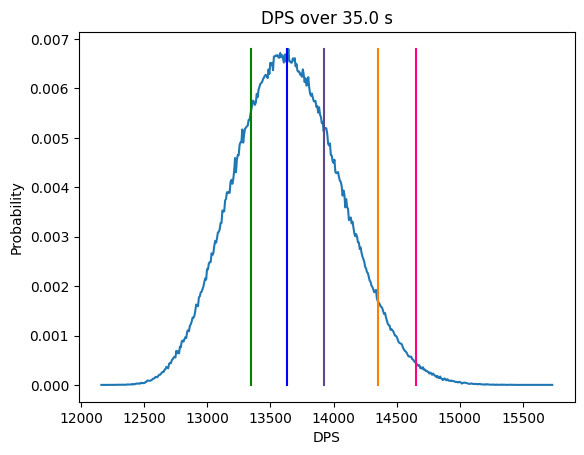

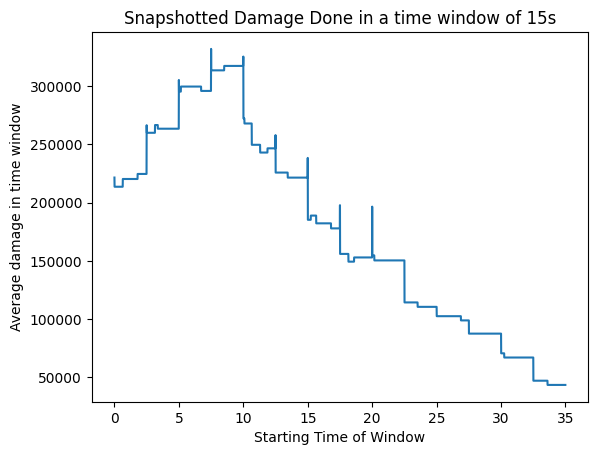

---Times (in ms) when skills get used:---
       0:               Tomahawk
     650:              Infuriate
     800:          Arcane Circle
    2500:            Heavy Swing
    5000:                   Maim
    5650:       Grade 8 Tincture
    6280:               Embolden
    6300:        Chain Strategem
    7100:          Battle Litany
    7500:            Storm's Eye
    8150:          Inner Release
   10000:            Inner Chaos
   10650:               Upheaval
   11300:              Onslaught
   12500:            Primal Rend
   15000:            Inner Chaos
   15650:              Onslaught
   17500:            Fell Cleave
   18150:              Onslaught
   20000:            Fell Cleave
   22500:            Fell Cleave
   25000:            Heavy Swing
   27500:                   Maim
   30000:           Storm's Path
   32500:            Fell Cleave
   35000:            Inner Chaos


---Times (in ms) when damage lands:---
time:      0.0, name:                   Auto, expected_dama

In [73]:
# @title Run rotation here. Has presets.
# rotation_to_use= ROTATION_LIBRARY['WAR 6.55']
# rotation_to_use= ROTATION_LIBRARY['WAR 6.55 Party Buffs']
# rotation_to_use= ROTATION_LIBRARY['PLD 6.55']
# rotation_to_use= ROTATION_LIBRARY['GNB 6.55']
# rotation_to_use= ROTATION_LIBRARY['DRK 6.55']
# rotation_to_use= ROTATION_LIBRARY['AST 6.4']
# rotation_to_use= ROTATION_LIBRARY['SCH 6.55']
# rotation_to_use= ROTATION_LIBRARY['WHM 6.55']
# rotation_to_use= ROTATION_LIBRARY['SGE 6.55']
# rotation_to_use= ROTATION_LIBRARY['SAM 6.55, 2.15 gcd']
# rotation_to_use= ROTATION_LIBRARY['SAM 6.5, Manual']
# rotation_to_use= ROTATION_LIBRARY['DRG 6.55, 2.5 gcd']
# rotation_to_use= ROTATION_LIBRARY['MNK 6.55, 1.94 gcd']
# rotation_to_use= ROTATION_LIBRARY['RPR 6.55, Early Gluttony']
# rotation_to_use= ROTATION_LIBRARY['NIN 6.4']
# rotation_to_use= ROTATION_LIBRARY['DNC 6.55']
# rotation_to_use= ROTATION_LIBRARY['DNC 6.55 extended']
# rotation_to_use= ROTATION_LIBRARY['BRD 6.55']
# rotation_to_use= ROTATION_LIBRARY['MCH 6.55 Delayed Tools (Extended)']
# rotation_to_use= ROTATION_LIBRARY['RDM 6.55']
# rotation_to_use= ROTATION_LIBRARY['BLM 6.55']
# rotation_to_use= ROTATION_LIBRARY['SMN 6.55 Fast Garuda']
rotation_to_use= ROTATION_LIBRARY['My Rotation']

dps, damage, per_skill_damage, t = execute_rotation(rotation_to_use, num_samples=1000000)

print('Results: ')
DisplayUtils.print_results(dps, title='Average DPS')
DisplayUtils.print_results(damage, title='Average Damage')

print('---Expected max damage over N runs---')
for num_runs in [1,5,10,20,50,100]:
  print('{} Runs: {:.2f}'.format(num_runs, StatUtils.get_expected_max_in_k_runs(dps,num_runs, num_trials=10000)))

plt.figure()
DisplayUtils.display_results(dps, title='DPS over {} s'.format(per_skill_damage[-1][0]/1000))

WINDOW_LENGTH= 15
plt.figure()
DisplayUtils.display_damage_snapshots_in_time_window(rotation_to_use, per_skill_damage, WINDOW_LENGTH)

print('---Times (in ms) when skills get used:---')
for tmp in rotation_to_use.get_button_press_timing():
  print('{:>8}: {:>22}'.format(tmp[0], tmp[1]))
print('\n')

print('---Times (in ms) when damage lands:---')
for sk in per_skill_damage:
  print('time: {:>8}, name: {:>22}, expected_damage: {:9.2f}, variance: {:6.2f}'.format(sk[0], sk[1], sk[2], sk[3]))


In [74]:
#@title create_test_skill_library, JobClassFnsTest

def create_test_skill_library():
  skill_library = SkillLibrary()

  # TimingSpecs
  gcd_2500 = TimingSpec(base_cast_time=2500, is_GCD=True, animation_lock=5)
  gcd_1500_lock = TimingSpec(base_cast_time=1500, is_GCD=True, animation_lock=50)
  gcd_instant = TimingSpec(base_cast_time=0, is_GCD=True, animation_lock=5)
  gcd_instant_no_lock = TimingSpec(base_cast_time=0, is_GCD=True, animation_lock=0)
  gcd_2500_app_delay = TimingSpec(base_cast_time=2500, application_delay=100, is_GCD=True)
  ogcd_instant = TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=0)
  ogcd_instant_animation_lock = TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=35)
  gcd_1500_const_cast = TimingSpec(base_cast_time=1500, is_GCD=True, animation_lock=5, affected_by_speed_stat=False, affected_by_haste_buffs=False)
  gcd_1500_no_haste = TimingSpec(base_cast_time=1500, is_GCD=True, animation_lock=5, affected_by_haste_buffs=False)
  auto_timing = TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=0)

  # DamageSpecs
  simple_damage = DamageSpec(potency=660)
  simple_tank_damage = DamageSpec(potency=200)
  simple_dot_damage = DamageSpec(potency=70, damage_class=DamageClass.DOT)
  simple_tank_dot_damage = DamageSpec(potency=50, damage_class=DamageClass.DOT)
  guaranteed_dh_damage = DamageSpec(potency=660, guaranteed_dh=ForcedCritOrDH.FORCE_YES)
  guaranteed_crit_damage = DamageSpec(potency=660, guaranteed_crit=ForcedCritOrDH.FORCE_YES)
  guaranteed_crit_dh_damage = DamageSpec(potency=660, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)
  guaranteed_no_crit_dh_damage = DamageSpec(potency=660, guaranteed_crit=ForcedCritOrDH.FORCE_NO, guaranteed_dh=ForcedCritOrDH.FORCE_NO)
  auto_damage = DamageSpec(potency=110, damage_class=DamageClass.AUTO, trait_damage_mult_override= 1.0)
  healer_auto_damage = DamageSpec(potency=80, damage_class=DamageClass.AUTO, trait_damage_mult_override= 1.0)
  simple_damage_trait_override = DamageSpec(potency=660, trait_damage_mult_override=1.0)
  guaranteed_dh_dot_damage = DamageSpec(potency=50, guaranteed_dh=ForcedCritOrDH.FORCE_YES, damage_class=DamageClass.DOT)
  guaranteed_crit_dot_damage = DamageSpec(potency=50, guaranteed_crit=ForcedCritOrDH.FORCE_YES, damage_class=DamageClass.DOT)
  guaranteed_crit_dh_dot_damage = DamageSpec(potency=50, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES, damage_class=DamageClass.DOT)
  pet_damage = DamageSpec(potency=350, pet_job_mod_override=100, trait_damage_mult_override=1, damage_class=DamageClass.PET)

  # StatusEffectSpecs (buff/debuff)
  simple_buff = StatusEffectSpec(duration=30000, max_duration=60000, crit_rate_add=0.05)
  simple_buff_2 = StatusEffectSpec(duration=10000, crit_rate_add=0.06, dh_rate_add=0.2)
  simple_debuff = StatusEffectSpec(duration=30000, max_duration=60000, damage_mult=1.2)
  simple_debuff_2 = StatusEffectSpec(duration=10000, damage_mult=1.3)
  auto_attack_buff = StatusEffectSpec(duration= 10000, auto_attack_delay_reduction=0.25)
  haste_buff1 = StatusEffectSpec(duration= 15000, haste_time_reduction=0.25)
  haste_buff2 = StatusEffectSpec(duration= 15000, haste_time_reduction=0.10)
  flat_cast_time_reduction_buff = StatusEffectSpec(duration=15000, flat_cast_time_reduction= 2500)
  simple_buff_with_allowlist = StatusEffectSpec(duration=30000, max_duration=60000, crit_rate_add=0.05, skill_allowlist=('test_gcd',))
  num_uses_buff_with_cast_reduction = StatusEffectSpec(duration=30000, max_duration=60000, flat_cast_time_reduction=3000, num_uses=2)
  guaranteed_crit_buff = StatusEffectSpec(duration=30000, max_duration=60000, num_uses=1, guaranteed_crit=ForcedCritOrDH.FORCE_YES)
  guaranteed_dh_buff = StatusEffectSpec(duration=30000, max_duration=60000, num_uses=1, guaranteed_dh=ForcedCritOrDH.FORCE_YES)
  guaranteed_crit_dh_buff = StatusEffectSpec(duration=30000, max_duration=60000, num_uses=1, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)
  num_uses_buff_with_priority1 = StatusEffectSpec(duration=30000, max_duration=60000, crit_rate_add=0.1, num_uses=1, skill_allowlist=('test_instant_gcd',))
  num_uses_buff_with_priority2 = StatusEffectSpec(duration=30000, max_duration=60000, dh_rate_add=0.1, num_uses=1, skill_allowlist=('test_instant_gcd',))

  # Skill creation
  test_gcd = Skill(name='test_gcd', timing_spec = gcd_2500, damage_spec=simple_damage)
  test_gcd_1500_lock = Skill(name='test_gcd_1500_lock', timing_spec = gcd_1500_lock, damage_spec=simple_damage)
  test_instant_gcd = Skill(name='test_instant_gcd', timing_spec = gcd_instant, damage_spec=simple_damage)
  test_instant_gcd_no_lock = Skill(name='test_instant_gcd_no_lock', timing_spec = gcd_instant_no_lock, damage_spec=simple_damage)
  test_tank_gcd = Skill(name='test_tank_gcd', timing_spec = gcd_2500, damage_spec=simple_tank_damage)
  test_gcd_with_app_delay = Skill(name='test_gcd_with_app_delay', timing_spec = gcd_2500_app_delay)
  test_ogcd = Skill(name='test_ogcd', timing_spec = ogcd_instant)
  test_ogcd_animation_lock = Skill(name='test_ogcd_animation_lock', timing_spec = ogcd_instant_animation_lock)
  test_non_dot_follow_up = Skill(name='test_non_dot_follow_up')
  test_follow_up = Skill(name='test_follow_up', timing_spec=gcd_2500, follow_up_skills = (FollowUp(skill=test_non_dot_follow_up, delay_after_parent_application=0, snapshot_buffs_with_parent=True, snapshot_debuffs_with_parent=True),
                                                                                          FollowUp(skill=test_non_dot_follow_up, delay_after_parent_application=3000, snapshot_buffs_with_parent=False, snapshot_debuffs_with_parent=True),
                                                                                          FollowUp(skill=test_non_dot_follow_up, delay_after_parent_application=7000, snapshot_buffs_with_parent=False, snapshot_debuffs_with_parent=False)))
  test_dot_tick = Skill(name='test_dot_tick', damage_spec=simple_dot_damage)
  test_tank_dot_tick = Skill(name='test_tank_dot_tick', damage_spec=simple_tank_dot_damage)
  test_dot_gcd = Skill(name='test_dot_gcd', timing_spec=gcd_2500, follow_up_skills = (FollowUp(skill=test_dot_tick, delay_after_parent_application=0, dot_duration=15*1000, snapshot_buffs_with_parent= True, snapshot_debuffs_with_parent=True),))
  test_dot_biolysis = Skill(name='test_dot_biolysis', timing_spec=gcd_2500, follow_up_skills = (FollowUp(skill=test_dot_tick, delay_after_parent_application=0, dot_duration=30*1000, snapshot_buffs_with_parent= True, snapshot_debuffs_with_parent=True),))
  test_dot_instant_gcd = Skill(name='test_dot_instant_gcd', timing_spec=gcd_instant, follow_up_skills = (FollowUp(skill=test_dot_tick, delay_after_parent_application=0, dot_duration=15*1000, snapshot_buffs_with_parent= True, snapshot_debuffs_with_parent=True),))
  test_dot_gcd_with_other_follow_up = Skill(name='test_dot_gcd_with_other_follow_up', timing_spec=gcd_2500, follow_up_skills = (FollowUp(skill=test_non_dot_follow_up, delay_after_parent_application=0, snapshot_buffs_with_parent=True, snapshot_debuffs_with_parent=True),
                                                                                                                                FollowUp(skill=test_dot_tick, delay_after_parent_application=0, dot_duration=15*1000, snapshot_buffs_with_parent= True, snapshot_debuffs_with_parent=True)))
  test_ground_dot_gcd = Skill(name='test_ground_dot_gcd', timing_spec=gcd_2500, follow_up_skills = (FollowUp(skill=test_dot_tick, delay_after_parent_application=0, dot_duration=15*1000, snapshot_buffs_with_parent= True, snapshot_debuffs_with_parent=False),))
  test_simple_buff_gcd = Skill('test_simple_buff_gcd', timing_spec=gcd_instant, buff_spec=simple_buff)
  test_party_buff = Skill('test_party_buff', timing_spec=gcd_instant, buff_spec=simple_buff)
  test_simple_buff_gcd_2 = Skill('test_simple_buff_gcd_2', timing_spec=gcd_instant, buff_spec=simple_buff_2)
  test_simple_buff_gcd_3 = Skill('test_simple_buff_gcd_3', timing_spec=gcd_2500, buff_spec=simple_buff) #NOT instant cast
  test_simple_debuff_gcd = Skill('test_simple_debuff_gcd', timing_spec=gcd_instant, debuff_spec=simple_debuff)
  test_simple_debuff_gcd_2 = Skill('test_simple_debuff_gcd_2', timing_spec=gcd_instant, debuff_spec=simple_debuff_2)
  test_guaranteed_dh = Skill('test_guaranteed_dh', timing_spec=gcd_instant, damage_spec=guaranteed_dh_damage)
  test_guaranteed_crit = Skill('test_guaranteed_crit', timing_spec=gcd_instant, damage_spec=guaranteed_crit_damage)
  test_guaranteed_crit_dh = Skill('test_guaranteed_crit_dh', timing_spec=gcd_instant, damage_spec=guaranteed_crit_dh_damage)
  test_guaranteed_no_crit_dh = Skill('test_guaranteed_no_crit_dh', timing_spec=gcd_instant, damage_spec=guaranteed_no_crit_dh_damage)
  test_guaranteed_dh_dot = Skill('test_guaranteed_dh_dot', timing_spec=gcd_instant, damage_spec=guaranteed_dh_dot_damage)
  test_guaranteed_crit_dot = Skill('test_guaranteed_crit_dot', timing_spec=gcd_instant, damage_spec=guaranteed_crit_dot_damage)
  test_guaranteed_crit_dh_dot = Skill('test_guaranteed_crit_dh_dot', timing_spec=gcd_instant, damage_spec=guaranteed_crit_dh_dot_damage)
  test_auto = Skill('Auto', timing_spec=auto_timing, damage_spec=auto_damage)
  test_healer_auto = Skill('Auto', timing_spec=auto_timing, damage_spec=healer_auto_damage)
  test_gcd_trait_override = Skill(name='test_gcd_trait_override', timing_spec = gcd_2500, damage_spec=simple_damage_trait_override)
  test_auto_attack_buff = Skill(name='test_auto_attack_buff', timing_spec=gcd_2500, buff_spec=auto_attack_buff)
  test_auto_attack_buff_instant = Skill(name='test_auto_attack_buff_instant', timing_spec=gcd_instant, buff_spec=auto_attack_buff)
  test_auto_attack_buff_instant_follow_up = Skill(name='test_auto_attack_buff_instant_follow_up', buff_spec=auto_attack_buff)
  test_auto_attack_buff_on_follow_up = Skill(name='test_auto_attack_buff_on_follow_up', timing_spec=gcd_2500, follow_up_skills = (FollowUp(skill=test_auto_attack_buff_instant_follow_up, delay_after_parent_application=0),))
  test_auto_attack_buff2 = Skill(name='test_auto_attack_buff2', timing_spec=gcd_2500, buff_spec=auto_attack_buff)
  test_haste_buff1 = Skill(name='test_haste_buff1', timing_spec=ogcd_instant, buff_spec=haste_buff1)
  test_haste_buff2 = Skill(name='test_haste_buff2', timing_spec=ogcd_instant, buff_spec=haste_buff2)
  _test_haste_follow_up = Skill(name='_test_haste_follow_up', buff_spec=haste_buff1)
  test_haste_follow_up = Skill(name='test_haste_follow_up', timing_spec=ogcd_instant, follow_up_skills = (FollowUp(skill=_test_haste_follow_up, delay_after_parent_application=0),))
  test_gcd_1500_const_cast = Skill(name='test_gcd_1500_const_cast', timing_spec=gcd_1500_const_cast, damage_spec=simple_damage)
  test_gcd_1500_no_haste = Skill(name='test_gcd_1500_no_haste', timing_spec=gcd_1500_no_haste, damage_spec=simple_damage)
  test_pet_gcd = Skill(name='test_pet_gcd', timing_spec=gcd_1500_lock, damage_spec=pet_damage)
  test_gcd_with_denylist = Skill(name='test_gcd_with_denylist', timing_spec = gcd_2500, damage_spec=simple_damage, status_effect_denylist=('test_simple_buff_gcd_2','test_simple_debuff_gcd'))
  test_flat_cast_time_reduction = Skill(name='test_flat_cast_time_reduction', timing_spec=ogcd_instant, buff_spec=flat_cast_time_reduction_buff)
  _test_buff_then_damage = Skill('_test_buff_then_damage', damage_spec=simple_damage)
  test_buff_then_damage = Skill(name='test_buff_then_damage',
                                timing_spec=gcd_instant,
                                buff_spec=simple_buff,
                                follow_up_skills=(FollowUp(skill=_test_buff_then_damage, delay_after_parent_application=0),))
  test_default_buff_damage_order = Skill(name='test_default_buff_damage_order',
                                         timing_spec=gcd_instant,
                                         buff_spec=simple_buff,
                                         damage_spec=simple_damage)
  test_damage_spec_with_cond = Skill(name='test_damage_spec_with_cond',
                                     timing_spec = gcd_instant,
                                     damage_spec = {SimConsts.DEFAULT_CONDITION: DamageSpec(potency=1000),
                                                    'cond1': DamageSpec(potency=200),
                                                    'cond2': DamageSpec(potency=400),
                                                    'cond3': None})
  test_timing_spec_with_cond = Skill(name='test_timing_spec_with_cond',
                                     timing_spec = {'instant': gcd_instant,
                                                    'cast': gcd_2500},
                                     damage_spec = DamageSpec(potency=1000))
  test_buff_with_cond = Skill(name='test_buff_with_cond',
                              timing_spec=gcd_instant,
                              buff_spec={'crit': StatusEffectSpec(duration=30000, crit_rate_add=0.1),
                                         'dh': StatusEffectSpec(duration=30000, dh_rate_add=0.2)})
  test_debuff_with_cond = Skill(name='test_debuff_with_cond',
                                timing_spec=gcd_instant,
                                debuff_spec = {'crit': StatusEffectSpec(duration=30000, crit_rate_add=0.15),
                                               'dh': StatusEffectSpec(duration=30000, dh_rate_add=0.25)})
  test_follow_up_with_cond = Skill(name='test_follow_up_with_cond',
                                   timing_spec=gcd_2500,
                                   follow_up_skills = {'1': (FollowUp(skill=test_non_dot_follow_up, delay_after_parent_application=0, snapshot_buffs_with_parent=True, snapshot_debuffs_with_parent=True),),
                                                       '2': (FollowUp(skill=test_non_dot_follow_up, delay_after_parent_application=0, snapshot_buffs_with_parent=True, snapshot_debuffs_with_parent=True),
                                                             FollowUp(skill=test_non_dot_follow_up, delay_after_parent_application=3000, snapshot_buffs_with_parent=True, snapshot_debuffs_with_parent=True))})
  _follow_up_buff = Skill(name='follow_up_buff',
                          buff_spec = StatusEffectSpec(duration=30000, max_duration=60000, crit_rate_add=0.15))
  _follow_up_buff_override = Skill(name='follow_up_buff',
                                   buff_spec = StatusEffectSpec(duration=30000, max_duration=60000, crit_rate_add=0.50))
  _follow_up_buff_other_duration = Skill(name='follow_up_buff',
                                         buff_spec = StatusEffectSpec(duration=10000, max_duration=60000, crit_rate_add=0.15))
  test_skill_with_follow_up_buff1 = Skill(name='test_skill_with_follow_up_buff1',
                                          timing_spec=gcd_instant,
                                          follow_up_skills = (FollowUp(skill=_follow_up_buff,
                                                                       delay_after_parent_application=0),))
  test_skill_with_follow_up_buff2 = Skill(name='test_skill_with_follow_up_buff2',
                                          timing_spec=gcd_instant,
                                          follow_up_skills = (FollowUp(skill=_follow_up_buff,
                                                                       delay_after_parent_application=0),))
  test_skill_with_follow_up_buff_other_duration = Skill(name='test_skill_with_follow_up_buff_other_duration',
                                                        timing_spec=gcd_instant,
                                                        follow_up_skills = (FollowUp(skill=_follow_up_buff_other_duration,
                                                                            delay_after_parent_application=0),))
  test_skill_with_follow_up_buff_override = Skill(name='test_skill_with_follow_up_buff_override',
                                                        timing_spec=gcd_instant,
                                                        follow_up_skills = (FollowUp(skill=_follow_up_buff_override,
                                                                                     delay_after_parent_application=0),))
  test_simple_buff_with_allowlist = Skill('simple_buff_with_allowlist', timing_spec=ogcd_instant, buff_spec=simple_buff_with_allowlist)
  test_num_uses_buff_with_cast_reduction = Skill('test_num_uses_buff_with_cast_reduction', timing_spec=ogcd_instant_animation_lock, buff_spec=num_uses_buff_with_cast_reduction)
  test_guaranteed_crit_buff = Skill('test_guaranteed_crit_buff', timing_spec=gcd_instant, buff_spec=guaranteed_crit_buff)
  test_guaranteed_dh_buff = Skill('test_guaranteed_dh_buff', timing_spec=gcd_instant, buff_spec=guaranteed_dh_buff)
  test_guaranteed_crit_dh_buff = Skill('guaranteed_crit_dh_buff', timing_spec=gcd_instant, buff_spec=guaranteed_crit_dh_buff)
  test_num_uses_buff_with_priority1 = Skill('test_num_uses_buff_with_priority1', timing_spec=ogcd_instant_animation_lock, buff_spec=num_uses_buff_with_priority1)
  test_num_uses_buff_with_priority2 = Skill('test_num_uses_buff_with_priority2', timing_spec=ogcd_instant_animation_lock, buff_spec=num_uses_buff_with_priority2)
  test_skill_with_conditional = Skill('test_skill_with_conditional',
                                      timing_spec=ogcd_instant_animation_lock,
                                      buff_spec=StatusEffectSpec(duration=30000,
                                                                 max_duration=60000,
                                                                 add_to_skill_modifier_condition=True,
                                                                 num_uses=1))

  skill_library.add_job_class_and_set_current('test_job')
  skill_library.add_skill(test_gcd)
  skill_library.add_skill(test_ogcd)
  skill_library.add_skill(test_gcd_with_app_delay)
  skill_library.add_skill(test_non_dot_follow_up)
  skill_library.add_skill(test_follow_up)
  skill_library.add_skill(test_dot_gcd)
  skill_library.add_skill(test_ground_dot_gcd)
  skill_library.add_skill(test_dot_tick)
  skill_library.add_skill(test_dot_gcd_with_other_follow_up)
  skill_library.add_skill(test_dot_instant_gcd)
  skill_library.add_skill(test_simple_buff_gcd)
  skill_library.add_skill(test_simple_buff_gcd_2)
  skill_library.add_skill(test_simple_buff_gcd_3)
  skill_library.add_skill(test_simple_debuff_gcd)
  skill_library.add_skill(test_simple_debuff_gcd_2)
  skill_library.add_skill(test_dot_biolysis)
  skill_library.add_skill(test_guaranteed_dh)
  skill_library.add_skill(test_guaranteed_crit)
  skill_library.add_skill(test_guaranteed_crit_dh)
  skill_library.add_skill(test_guaranteed_no_crit_dh)
  skill_library.add_skill(test_guaranteed_dh_dot)
  skill_library.add_skill(test_guaranteed_crit_dot)
  skill_library.add_skill(test_guaranteed_crit_dh_dot)
  skill_library.add_skill(test_auto_attack_buff)
  skill_library.add_skill(test_auto_attack_buff2)
  skill_library.add_skill(test_auto)
  skill_library.add_skill(test_instant_gcd)
  skill_library.add_skill(test_instant_gcd_no_lock)
  skill_library.add_skill(test_auto_attack_buff_instant)
  skill_library.add_skill(test_auto_attack_buff_on_follow_up)
  skill_library.add_skill(test_auto_attack_buff_instant_follow_up)
  skill_library.add_skill(test_ogcd_animation_lock)
  skill_library.add_skill(test_gcd_1500_lock)
  skill_library.add_skill(test_haste_buff1)
  skill_library.add_skill(test_haste_buff2)
  skill_library.add_skill(_test_haste_follow_up)
  skill_library.add_skill(test_haste_follow_up)
  skill_library.add_skill(test_pet_gcd)
  skill_library.add_skill(test_gcd_with_denylist)
  skill_library.add_skill(test_gcd_1500_const_cast)
  skill_library.add_skill(test_gcd_1500_no_haste)
  skill_library.add_skill(test_flat_cast_time_reduction)
  skill_library.add_skill(test_buff_then_damage)
  skill_library.add_skill(_test_buff_then_damage)
  skill_library.add_skill(test_default_buff_damage_order)
  skill_library.add_skill(test_damage_spec_with_cond)
  skill_library.add_skill(test_timing_spec_with_cond)
  skill_library.add_skill(test_buff_with_cond)
  skill_library.add_skill(test_debuff_with_cond)
  skill_library.add_skill(test_follow_up_with_cond)
  skill_library.add_skill(_follow_up_buff)
  skill_library.add_skill(test_skill_with_follow_up_buff1)
  skill_library.add_skill(test_skill_with_follow_up_buff2)
  skill_library.add_skill(test_skill_with_follow_up_buff_other_duration)
  skill_library.add_skill(test_skill_with_follow_up_buff_override)
  skill_library.add_skill(test_simple_buff_with_allowlist)
  skill_library.add_skill(test_num_uses_buff_with_cast_reduction)
  skill_library.add_skill(test_guaranteed_crit_buff)
  skill_library.add_skill(test_guaranteed_dh_buff)
  skill_library.add_skill(test_guaranteed_crit_dh_buff)
  skill_library.add_skill(test_num_uses_buff_with_priority1)
  skill_library.add_skill(test_num_uses_buff_with_priority2)
  skill_library.add_skill(test_skill_with_conditional)

  skill_library.set_status_effect_priority(('test_num_uses_buff_with_priority1', 'test_num_uses_buff_with_priority2'))


  skill_library.add_job_class_and_set_current('test_job2')
  skill_library.add_skill(test_auto)
  skill_library.add_skill(test_gcd)
  skill_library.add_skill(test_gcd_trait_override)
  skill_library.add_skill(test_party_buff)

  skill_library.add_job_class_and_set_current('test_tank_job')
  skill_library.add_skill(test_auto)
  skill_library.add_skill(test_tank_gcd)
  skill_library.add_skill(test_tank_dot_tick)
  skill_library.add_skill(test_pet_gcd)

  skill_library.add_job_class_and_set_current('test_healer_job')
  skill_library.add_skill(test_healer_auto)

  skill_library.add_job_class_and_set_current('test_job_haste')
  skill_library.add_skill(test_auto)
  skill_library.add_skill(test_instant_gcd)
  skill_library.add_skill(test_gcd)

  return skill_library

class JobClassFnsTest:
  JOB_MODS = {'test_job': 115, 'test_job2': 105, 'test_tank_job': 105, 'test_healer_job': 115, 'test_job_haste': 115}
  USES_SKS = {'test_job', 'test_tank_job'}

  @staticmethod
  def compute_trait_damage_mult(job_class):
    if job_class == 'test_job2':
      return 1.40
    elif job_class == 'test_healer_job':
      return 1.30
    else:
      return 1

  @staticmethod
  def compute_trait_haste_time_reduction(job_class):
    job_to_trait_haste_time_reduction = {'test_job_haste': 0.2}
    if job_class in job_to_trait_haste_time_reduction:
      return job_to_trait_haste_time_reduction[job_class]
    return 0

  @staticmethod
  def compute_trait_auto_attack_delay_reduction(job_class):
    job_to_trait_auto_attack_delay_reduction = {'test_job_haste': 0.2}
    if job_class in job_to_trait_auto_attack_delay_reduction:
      return job_to_trait_auto_attack_delay_reduction[job_class]
    return 0

  @staticmethod
  def isCaster(job_class):
    return False

  @staticmethod
  def isHealer(job_class):
    return job_class in ['test_healer_job']

  @staticmethod
  def isTank(job_class):
    return job_class in ['test_tank_job']


In [75]:
#@title Test utils

class TestClass:
  def __init__(self):
    self.test_fns = []

  def is_a_test(f):
    f.__is_a_test__ = True
    return f

  def _get_test_methods(self):
    test_methods = []
    for fn_name in dir(self):
      fn = getattr(self, fn_name)
      if getattr(fn, '__is_a_test__', False):
        test_methods.append(fn)
    return test_methods

  @staticmethod
  def _compare_sequential(result, expected, relative_tol = None):
    test_passed = True
    err_msg = ""
    if len(expected) != len(result):
      test_passed = False
      err_msg += "Expected {} skills returned. Instead got {}. ".format(len(expected), len(result))
      return test_passed, err_msg
    for i in range(0, len(expected)):
      if relative_tol is None:
        if expected[i] != result[i]:
          test_passed = False
          err_msg += "Position {} was not the same.\n Expected: {}\n Actual: {}\n".format(i, expected[i], result[i])
      else:
        diff = abs (result[i]-expected[i])
        if diff/expected[i] >= relative_tol:
          test_passed = False
          err_msg += "Position {} was not the same.\n Expected: {}\n Actual: {}\n".format(i, expected[i], result[i])
    return test_passed, err_msg

  def print_result(self, passing, failing):
    print('Testing for {}. {}/{} tests passed.'.format(self.__class__.__name__, len(passing), len(passing)+len(failing)))
    if len(failing) > 0:
      print('Failing tests:')
      for test_info in failing:
        print("{}: {}\n".format(test_info[0], test_info[1]))
    print('Passing tests:')
    for test_name in passing:
      print("{}".format(test_name))

  def run_single(self, test_name):
    for test_fn in self._get_test_methods():
      if test_name == test_fn.__name__:
        test_passed, err_msg = test_fn()
        if test_passed:
          print('{} passed!'.format(test_name))
          return
        else:
          print('{} failed: {}'.format(test_name, err_msg))
          return
    print('No test found with name {}'.format(test_name))

  def run_all(self, verbose=False):
    passing = []
    failing = []
    for test_fn in self._get_test_methods():
      test_name = test_fn.__name__
      test_passed, err_msg = test_fn()
      if (test_passed):
        passing.append(test_name)
      else:
        failing.append((test_name, err_msg))
    if(verbose or len(failing) > 0):
      self.print_result(passing, failing)
      print("================")
    return (len(passing), len(failing))

class AllTest():
  def __init__(self):
    self.__all_test_classes = []

  def register_test_class(self, test_class):
    self.__all_test_classes.append(test_class)

  def run_all(self):
    total_passing = 0
    total_failing = 0
    for test_class in self.__all_test_classes:
      print('Running: {}'.format(test_class.__class__.__name__))
      (num_pass, num_fail) = test_class.run_all()
      total_passing += num_pass
      total_failing += num_fail
    print('All tests done. Num passing: {}. Num failing: {}'.format(total_passing, total_failing))


In [76]:
#@title TimingSpecTest
class TimingSpecTest(TestClass):

  @TestClass.is_a_test
  def gcd_override_gcd_test(self):
    test_passed = True
    err_msg=""
    timing_spec = TimingSpec(base_cast_time=2000, is_GCD=True)
    if timing_spec.gcd_base_recast_time != 2500:
      err_msg = "Recast time was expected to be 2500, but it was {}.".format(timing_spec.gcd_base_recast_time)
      test_passed = False
    return test_passed, err_msg

  @TestClass.is_a_test
  def gcd_override_ogcd_test(self):
    test_passed = True
    err_msg=""
    timing_spec = TimingSpec(base_cast_time=2000, is_GCD=False)
    if timing_spec.gcd_base_recast_time != 0:
      err_msg = "Recast time was expected to be 0, but it was {}.".format(timing_spec.gcd_base_recast_time)
      test_passed = False
    return test_passed, err_msg

  @TestClass.is_a_test
  def gcd_override_set_recast_time(self):
    test_passed = True
    err_msg=""
    timing_spec = TimingSpec(base_cast_time=2000, gcd_base_recast_time=1500, is_GCD=False)
    if timing_spec.gcd_base_recast_time != 1500:
      err_msg = "Recast time was expected to be 1500, but it was {}.".format(timing_spec.gcd_base_recast_time)
      test_passed = False
    return test_passed, err_msg

In [77]:
#@title StatusEffectSpecTest
class StatusEffectSpecTest(TestClass):
  @TestClass.is_a_test
  def test_max_duration(self):
    test_passed = True
    err_msg = ""

    duration = 10000
    status_effect_spec = StatusEffectSpec(duration=duration)
    return test_passed, err_msg
    if (status_effect_spec.max_duration != duration):
      test_passed = False
      err_msg = "Max duration set incorrectly. Expected{} but got {}".format(duration, status_effect_spec.max_duration)

    return test_passed, err_msg

  @TestClass.is_a_test
  def test_set_max_duration(self):
    test_passed = True
    err_msg = ""

    duration = 10000
    max_duration = 30000
    status_effect_spec = StatusEffectSpec(duration=duration, max_duration = max_duration)
    return test_passed, err_msg
    if (status_effect_spec.max_duration != duration):
      test_passed = False
      err_msg = "Max duration set incorrectly. Expected{} but got {}".format(max_duration, status_effect_spec.max_duration)

    return test_passed, err_msg

In [78]:
#@title StatusEffectTrackerTest
class StatusEffectTrackerTest(TestClass):
  def __init__(self):
    self.__skill_library = create_test_skill_library()

  @TestClass.is_a_test
  def conditional_addition_with_num_uses_and_allowlist(self):
    test_passed = True
    err_msg = ""
    se = StatusEffectTracker()

    buff1 =  Skill(name='buff1', buff_spec=StatusEffectSpec(add_to_skill_modifier_condition=True, num_uses=2, skill_allowlist=('test1',)))
    test1 =  Skill(name='test1')
    test2 =  Skill(name='test2')

    se.add_to_status_effects(0, buff1, SkillModifier())

    skills_to_use = [test1, test2, test1, test1]
    expected = ((StatusEffects(skill_modifier_conditions_to_add='buff1'), StatusEffects()),
                (StatusEffects(), StatusEffects()),
                (StatusEffects(skill_modifier_conditions_to_add='buff1'), StatusEffects()),
                (StatusEffects(), StatusEffects()))

    for i in range(0, len(skills_to_use)):
      se.expire_status_effects(t=0)
      result = se.compile_status_effects(t=0, skill=skills_to_use[i])
      if (result != expected[i]):
        test_passed = False
        err_msg += "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)
    return test_passed, err_msg

  @TestClass.is_a_test
  def conditional_addition(self):
    test_passed = True
    err_msg = ""
    se = StatusEffectTracker()

    buff1 =  Skill(name='buff1', buff_spec=StatusEffectSpec(add_to_skill_modifier_condition=True))
    test1 =  Skill(name='test1')

    se.add_to_status_effects(0, buff1, SkillModifier())
    result = se.compile_status_effects(0, skill=test1)
    expected = (StatusEffects(skill_modifier_conditions_to_add='buff1'), StatusEffects())
    if (result != expected):
      test_passed = False
      err_msg += "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)
    return test_passed, err_msg

  @TestClass.is_a_test
  def status_effect_priority(self):
    test_passed = True
    err_msg = ""
    se = StatusEffectTracker(('test_num_uses_buff_with_priority1', 'test_num_uses_buff_with_priority2'))

    se.add_to_status_effects(0, self.__skill_library.get_skill('test_num_uses_buff_with_priority1', 'test_job'), SkillModifier())
    se.add_to_status_effects(0, self.__skill_library.get_skill('test_num_uses_buff_with_priority2', 'test_job'), SkillModifier())
    test_instant_gcd = self.__skill_library.get_skill('test_instant_gcd', 'test_job')

    se.expire_status_effects(t=1000)
    result = se.compile_status_effects(1000, skill=test_instant_gcd)
    expected = (StatusEffects(crit_rate_add=0.1), StatusEffects())
    if (result != expected):
      test_passed = False
      err_msg += "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)

    se.expire_status_effects(t=1000)
    result = se.compile_status_effects(1000, skill=test_instant_gcd)
    expected = (StatusEffects(dh_rate_add=0.1), StatusEffects())
    if (result != expected):
      test_passed = False
      err_msg += "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)

    se.expire_status_effects(t=1000)
    result = se.compile_status_effects(1000, skill=test_instant_gcd)
    expected = (StatusEffects(), StatusEffects())
    if (result != expected):
      test_passed = False
      err_msg += "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)

    return test_passed, err_msg

  @TestClass.is_a_test
  def num_uses_compile(self):
    test_passed = True
    err_msg = ""
    se = StatusEffectTracker()

    buff1 =  Skill(name='buff1', buff_spec=StatusEffectSpec(crit_rate_add=0.05, duration=30000, skill_allowlist=('test1',), num_uses=1))
    test1 =  Skill(name='test1')

    se.add_to_status_effects(0, buff1, SkillModifier())

    result = se.compile_status_effects(0, skill=test1)
    expected = (StatusEffects(crit_rate_add=0.05), StatusEffects())
    if (result != expected):
      test_passed = False
      err_msg += "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)

    se.expire_status_effects(t=0)
    result = se.compile_status_effects(0, skill=test1)
    expected = (StatusEffects(), StatusEffects())
    if (result != expected):
      test_passed = False
      err_msg += "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)

    return test_passed, err_msg

  @TestClass.is_a_test
  def allow_list_status_effect(self):
    test_passed = True
    err_msg = ""
    se = StatusEffectTracker()

    buff1 =  Skill(name='buff1', buff_spec=StatusEffectSpec(crit_rate_add=0.05, duration=30000, skill_allowlist=('test1',)))
    test1 =  Skill(name='test1')
    test2 =  Skill(name='test2')

    se.add_to_status_effects(0, buff1, SkillModifier())

    result = se.compile_status_effects(0, skill=test1)
    expected = (StatusEffects(crit_rate_add=0.05), StatusEffects())
    if (result != expected):
      test_passed = False
      err_msg += "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)

    se.expire_status_effects(t=0)
    result = se.compile_status_effects(0, skill=test2)
    expected = (StatusEffects(), StatusEffects())
    if (result != expected):
      test_passed = False
      err_msg += "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)

    return test_passed, err_msg

  @TestClass.is_a_test
  def expires_status_effect_duration(self):
    test_passed = True
    err_msg = ""
    se = StatusEffectTracker()

    buff1 =  Skill(name='buff1', buff_spec=StatusEffectSpec(crit_rate_add=0.05, duration=30000))
    buff2 =  Skill(name='buff2', buff_spec=StatusEffectSpec(dh_rate_add=0.05, duration=10000, expires_status_effects=('buff1',)))

    se.add_to_status_effects(0, buff1, SkillModifier())
    se.add_to_status_effects(10000, buff2, SkillModifier())

    se.expire_status_effects(11000)
    result = se.compile_status_effects(11000)
    expected = (StatusEffects(dh_rate_add=0.05), StatusEffects())
    if (result != expected):
      test_passed = False
      err_msg += "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)

    return test_passed, err_msg

  @TestClass.is_a_test
  def no_refresh_status_effect(self):
    test_passed = True
    err_msg = ""
    se = StatusEffectTracker()

    buff1 =  Skill(name='buff', buff_spec=StatusEffectSpec(crit_rate_add=0.05, duration=30000))
    buff2 =  Skill(name='buff', buff_spec=StatusEffectSpec(crit_rate_add=0.12, duration=30000, extends_existing_duration=False))

    se.add_to_status_effects(0, buff1, SkillModifier())
    se.add_to_status_effects(10000, buff2, SkillModifier())
    se.expire_status_effects(29000)

    result = se.compile_status_effects(29000)
    expected = (StatusEffects(crit_rate_add=0.12), StatusEffects())
    if (result != expected):
      test_passed = False
      err_msg += "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)

    se.expire_status_effects(31000)
    result = se.compile_status_effects(31000)
    expected = (StatusEffects(), StatusEffects())
    if (result != expected):
      test_passed = False
      err_msg += "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)

    return test_passed, err_msg

  @TestClass.is_a_test
  def prepull_buff(self):
    test_passed = True
    err_msg = ""
    se = StatusEffectTracker()

    buff =  Skill(name='buff', buff_spec=StatusEffectSpec(main_stat_add=262, duration=30000))

    se.add_to_status_effects(-2000, buff, SkillModifier())
    se.expire_status_effects(5000)

    result = se.compile_status_effects(5000)
    expected = (StatusEffects(main_stat_add=262), StatusEffects())

    if (result != expected):
      test_passed = False
      err_msg = "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)
    return test_passed, err_msg

  @TestClass.is_a_test
  def buff_override(self):
    test_passed = True
    err_msg = ""
    se = StatusEffectTracker()

    buff1 =  Skill(name='buff', buff_spec=StatusEffectSpec(crit_rate_add=0.1, duration=30000))
    buff2 =  Skill(name='buff', buff_spec=StatusEffectSpec(crit_rate_add=0.5, duration=30000))
    debuff1 =  Skill(name='debuff', debuff_spec=StatusEffectSpec(dh_rate_add=0.01, duration=30000))
    debuff2 =  Skill(name='debuff', debuff_spec=StatusEffectSpec(dh_rate_add=0.05, duration=30000))

    se.add_to_status_effects(0, buff1, SkillModifier())
    se.add_to_status_effects(1000, buff2, SkillModifier())
    se.add_to_status_effects(2000, debuff1, SkillModifier())
    se.add_to_status_effects(3000, debuff2, SkillModifier())

    result = se.compile_status_effects(3001)
    expected = (StatusEffects(crit_rate_add=0.5), StatusEffects(dh_rate_add=0.05))

    if (result != expected):
      test_passed = False
      err_msg = "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)
    return test_passed, err_msg

  @TestClass.is_a_test
  def simple_buff_expiry(self):
    test_passed = True
    err_msg = ""
    se = StatusEffectTracker()
    se.add_to_status_effects(1000, self.__skill_library.get_skill('test_simple_buff_gcd', 'test_job'), SkillModifier())
    #test_simple_buff_gcd_2 should expire after 18000 ms
    se.add_to_status_effects(8000, self.__skill_library.get_skill('test_simple_buff_gcd_2', 'test_job'), SkillModifier())
    #test_simple_buff_gcd_2 should expire after 19000 ms
    se.add_to_status_effects(9000, self.__skill_library.get_skill('test_simple_debuff_gcd_2', 'test_job'), SkillModifier())

    se.expire_status_effects(19001)
    result = se.compile_status_effects(19001)
    expected = (StatusEffects(crit_rate_add=0.05), StatusEffects())

    if (result != expected):
      test_passed = False
      err_msg = "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)
    return test_passed, err_msg

  @TestClass.is_a_test
  def multiple_auto_attack_buffs(self):
    test_passed = True
    err_msg = ""
    se = StatusEffectTracker()
    se.add_to_status_effects(100, self.__skill_library.get_skill('test_auto_attack_buff', 'test_job'), SkillModifier())
    se.add_to_status_effects(100, self.__skill_library.get_skill('test_auto_attack_buff2', 'test_job'), SkillModifier())

    result = se.compile_status_effects(101)
    expected = (StatusEffects(auto_attack_delay_mult=math.pow(0.75,2)), StatusEffects())

    if (result != expected):
      test_passed = False
      err_msg = "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)
    return test_passed, err_msg

  @TestClass.is_a_test
  def simple_buffs(self):
    test_passed = True
    err_msg = ""
    se = StatusEffectTracker()
    se.add_to_status_effects(100, self.__skill_library.get_skill('test_simple_buff_gcd', 'test_job'), SkillModifier())
    se.add_to_status_effects(100, self.__skill_library.get_skill('test_simple_buff_gcd_2', 'test_job'), SkillModifier())
    se.add_to_status_effects(100, self.__skill_library.get_skill('test_simple_debuff_gcd', 'test_job'), SkillModifier())
    se.add_to_status_effects(100, self.__skill_library.get_skill('test_simple_debuff_gcd_2', 'test_job'), SkillModifier())

    result = se.compile_status_effects(101)
    expected = (StatusEffects(crit_rate_add=0.11, dh_rate_add=0.2), StatusEffects(damage_mult=1.56))

    if (result != expected):
      test_passed = False
      err_msg = "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_buff_override(self):
    test_passed = True
    err_msg = ""
    se = StatusEffectTracker()
    se.add_to_status_effects(100, self.__skill_library.get_skill('test_simple_buff_gcd', 'test_job'), SkillModifier())
    # this should simply override the first buff
    se.add_to_status_effects(500, self.__skill_library.get_skill('test_simple_buff_gcd', 'test_job'), SkillModifier())

    result = se.compile_status_effects(501)
    expected = (StatusEffects(crit_rate_add=0.05, dh_rate_add=0.0), StatusEffects())

    if (result != expected):
      test_passed = False
      err_msg = "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)
    return test_passed, err_msg

  @TestClass.is_a_test
  def late_refresh(self):
    test_passed = True
    err_msg = ""
    se = StatusEffectTracker()
    se.add_to_status_effects(0, self.__skill_library.get_skill('test_simple_buff_gcd', 'test_job'), SkillModifier())
    #test_simple_buff_gcd should expire after 30000 ms
    se.expire_status_effects(31000)
    se.add_to_status_effects(31000, self.__skill_library.get_skill('test_simple_buff_gcd', 'test_job'), SkillModifier())
    se.expire_status_effects(61000-1)
    result = se.compile_status_effects(61000-1)
    expected = (StatusEffects(crit_rate_add=0.05), StatusEffects())

    if (result != expected):
      test_passed = False
      err_msg = "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)
    return test_passed, err_msg

  @TestClass.is_a_test
  def with_cond_simple_buff(self):
    test_passed = True
    err_msg = ""
    se = StatusEffectTracker()
    se.add_to_status_effects(0, self.__skill_library.get_skill('test_buff_with_cond', 'test_job'), SkillModifier(with_condition='dh'))

    result = se.compile_status_effects(1)
    expected = (StatusEffects(dh_rate_add=0.2), StatusEffects())

    if (result != expected):
      test_passed = False
      err_msg = "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)
    return test_passed, err_msg

  @TestClass.is_a_test
  def with_cond_simple_debuff(self):
    test_passed = True
    err_msg = ""
    se = StatusEffectTracker()
    se.add_to_status_effects(0, self.__skill_library.get_skill('test_debuff_with_cond', 'test_job'), SkillModifier(with_condition='crit'))
    se.expire_status_effects(100)
    result = se.compile_status_effects(101)
    expected = (StatusEffects(), StatusEffects(crit_rate_add=0.15))

    if (result != expected):
      test_passed = False
      err_msg = "Expected and actual status effects do not match.\nExpected{}.\nActual:{}".format(expected, result)
    return test_passed, err_msg

In [79]:
#@title SnapshotAndApplicationEventsTest
class SnapshotAndApplicationEventsTest(TestClass):
  def __init__(self):
    self.__skill_library = create_test_skill_library()

  @TestClass.is_a_test
  def test_get_last_event(self):
    test_passed = True
    err_msg = ""
    rb_result = SnapshotAndApplicationEvents()
    rb_result.add(Utils.transform_time_to_prio(2940), 2940, 3440, self.__skill_library.get_skill('test_dot_gcd', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(2940)+1, 2940, 3440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(2940)+5, 2940, 15440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(12940), 12940, 13440, self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(), [True, True])

    actual_last_event_time = rb_result.get_last_event_time()
    expected_last_event_time = 15440
    if actual_last_event_time != expected_last_event_time:
      err_msg = "Last event time was expected to be {}, but was {}.".format(expected_last_event_time, actual_last_event_time)
      test_passed = False
    return test_passed, err_msg

In [80]:
#@title RotationBuilderTest
class RotationBuilderTest(TestClass):
  def __init__(self):
    self.__stats = Stats(wd=126, weapon_delay=3.44, main_stat=2945, det_stat=1620, crit_stat=2377, dh_stat=1048, speed_stat=708, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    self.__skill_library = create_test_skill_library()

  @TestClass.is_a_test
  def test_adding_conditional(self):
    test_passed = True
    err_msg = ""
    stats = Stats(wd=126, weapon_delay=3.44, main_stat=2945, det_stat=1620, crit_stat=2377, dh_stat=1048, speed_stat=400, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    rb = RotationBuilder(stats, self.__skill_library, fight_start_time=0)
    rb.add_next('test_skill_with_conditional')
    rb.add_next('test_instant_gcd')
    rb.add_next('test_instant_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(0, None), self.__skill_library.get_skill('test_skill_with_conditional', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(35, None), self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(with_condition='test_skill_with_conditional'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2535, None), self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), [True, True]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)


  @TestClass.is_a_test
  def test_buff_with_num_uses_and_cast_reduction(self):
    test_passed = True
    err_msg = ""
    stats = Stats(wd=126, weapon_delay=3.44, main_stat=2945, det_stat=1620, crit_stat=2377, dh_stat=1048, speed_stat=400, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    rb = RotationBuilder(stats, self.__skill_library, fight_start_time=0)
    rb.add_next('test_num_uses_buff_with_cast_reduction')
    rb.add_next('test_gcd')
    rb.add_next('test_gcd')
    rb.add_next('test_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(0, None), self.__skill_library.get_skill('test_num_uses_buff_with_cast_reduction', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(35, None), self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(35+2500, None), self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(35+5000+2000, 35+5000+2500), self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(), [True, True]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_auto_on_first_damage_instance(self):
    test_passed = True
    err_msg = ""
    stats = Stats(wd=126, weapon_delay=3.44, main_stat=2945, det_stat=1620, crit_stat=2377, dh_stat=1048, speed_stat=400, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    rb = RotationBuilder(stats, self.__skill_library, enable_autos=True, fight_start_time=0)
    rb.add_next('test_simple_buff_gcd')
    rb.add_next('test_instant_gcd')
    rb.add_next('test_instant_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(0, None), self.__skill_library.get_skill('test_simple_buff_gcd', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2500, None), self.__skill_library.get_skill('Auto', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2500, None), self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(5000, None), self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), [True, True]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_auto_on_first_damage_instance_timestamp(self):
    test_passed = True
    err_msg = ""
    rb = RotationBuilder(self.__stats, self.__skill_library, enable_autos=True, fight_start_time=0)
    rb.add(0,'test_simple_buff_gcd')
    rb.add(2,'test_instant_gcd')
    rb.add(4,'test_instant_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(0, None), self.__skill_library.get_skill('test_simple_buff_gcd', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2000, None), self.__skill_library.get_skill('Auto', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2000, None), self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(4000, None), self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), [True, True]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_job_auto_delay_reduction_trait(self):
    test_passed = True
    err_msg = ""
    stats = Stats(wd=126, weapon_delay=3.44, main_stat=2945, det_stat=1620, crit_stat=2377, dh_stat=1048, speed_stat=400, job_class = 'test_job_haste', job_class_fns=JobClassFnsTest)
    rb = RotationBuilder(stats, self.__skill_library, enable_autos=True, fight_start_time=0)
    rb.add(0,'test_instant_gcd')
    rb.add(10,'test_instant_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(0, None), self.__skill_library.get_skill('Auto', 'test_job_haste'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(0, None), self.__skill_library.get_skill('test_instant_gcd', 'test_job_haste'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2750, None), self.__skill_library.get_skill('Auto', 'test_job_haste'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(5500, None), self.__skill_library.get_skill('Auto', 'test_job_haste'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(8250, None), self.__skill_library.get_skill('Auto', 'test_job_haste'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(10000, None), self.__skill_library.get_skill('test_instant_gcd', 'test_job_haste'), SkillModifier(), [True, True]),)

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_job_haste_trait(self):
    test_passed = True
    err_msg = ""
    stats = Stats(wd=126, weapon_delay=3.44, main_stat=2945, det_stat=1620, crit_stat=2377, dh_stat=1048, speed_stat=400, job_class = 'test_job_haste', job_class_fns=JobClassFnsTest)
    rb = RotationBuilder(stats, self.__skill_library, enable_autos=False, fight_start_time=0)
    rb.add_next('test_instant_gcd')
    rb.add_next('test_instant_gcd')
    rb.add_next('test_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(0, None), self.__skill_library.get_skill('test_instant_gcd', 'test_job_haste'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2000, None), self.__skill_library.get_skill('test_instant_gcd', 'test_job_haste'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(5500, 6000), self.__skill_library.get_skill('test_gcd', 'test_job_haste'), SkillModifier(), [True, True]),)

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_with_cond_follow_up(self):
    test_passed = True
    err_msg = ""

    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add(0, 'test_follow_up_with_cond', skill_modifier=SkillModifier(with_condition='1'))
    rb.add(10, 'test_follow_up_with_cond', skill_modifier=SkillModifier(with_condition='2'))

    expected = ((SnapshotAndApplicationEvents.EventTimes(1940, 2440), self.__skill_library.get_skill('test_follow_up_with_cond', 'test_job'), SkillModifier(with_condition='1'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(1940, 2440), self.__skill_library.get_skill('test_non_dot_follow_up', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(11940, 12440), self.__skill_library.get_skill('test_follow_up_with_cond', 'test_job'), SkillModifier(with_condition='2'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(11940, 12440), self.__skill_library.get_skill('test_non_dot_follow_up', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(11940, 15440), self.__skill_library.get_skill('test_non_dot_follow_up', 'test_job'), SkillModifier(), [True, True]),)

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_with_cond_buff_spec(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add_next('test_buff_with_cond', skill_modifier=SkillModifier(with_condition='crit'))
    rb.add_next('test_buff_with_cond', skill_modifier=SkillModifier(with_condition='dh'))

    expected = ((SnapshotAndApplicationEvents.EventTimes(0, None), self.__skill_library.get_skill('test_buff_with_cond', self.__stats.job_class), SkillModifier(with_condition='crit'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2440, None), self.__skill_library.get_skill('test_buff_with_cond', self.__stats.job_class), SkillModifier(with_condition='dh'), [True, True]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_with_cond_timing_spec(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add_next('test_timing_spec_with_cond', skill_modifier=SkillModifier(with_condition='instant'))
    rb.add_next('test_timing_spec_with_cond', skill_modifier=SkillModifier(with_condition='cast'))

    expected = ((SnapshotAndApplicationEvents.EventTimes(0, None), self.__skill_library.get_skill('test_timing_spec_with_cond', self.__stats.job_class), SkillModifier(with_condition='instant'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(4380, 4880), self.__skill_library.get_skill('test_timing_spec_with_cond', self.__stats.job_class), SkillModifier(with_condition='cast'), [True, True]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_snap_dots_to_server_tick_starting_at(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, snap_dots_to_server_tick_starting_at= -1.5, fight_start_time=0)
    rb.add(1.0, 'test_dot_gcd')
    rb.add(29.06, 'test_dot_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_gcd', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 4500), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 7500), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 10500), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 13500), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 16500), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(31000, 31500), self.__skill_library.get_skill('test_dot_gcd', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(31000, 31500), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(31000, 34500), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(31000, 37500), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(31000, 40500), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(31000, 43500), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_ignore_trailing_dot(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, ignore_trailing_dots=True, fight_start_time=0)
    rb.add(1, 'test_dot_gcd')
    rb.add(8, 'test_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_gcd', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 6440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 9440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 10440), self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(), [True, True]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_buff_then_damage(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add(0, 'test_buff_then_damage')
    expected = ((SnapshotAndApplicationEvents.EventTimes(0, None), self.__skill_library.get_skill('test_buff_then_damage', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(0, None), self.__skill_library.get_skill('_test_buff_then_damage', self.__stats.job_class), SkillModifier(), [True, True]),)

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_flat_cast_time_reduction_add(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add(0, 'test_gcd_1500_lock')
    rb.add(1.6, 'test_flat_cast_time_reduction')
    rb.add(6, 'test_gcd_1500_lock')
    rb.add(9, 'test_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(960, 1460), self.__skill_library.get_skill('test_gcd_1500_lock', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(1600, None), self.__skill_library.get_skill('test_flat_cast_time_reduction', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(6000, None), self.__skill_library.get_skill('test_gcd_1500_lock', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9000, None), self.__skill_library.get_skill('test_gcd', self.__stats.job_class), SkillModifier(), [True, True]),)

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_flat_cast_time_reduction_add_next(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add_next('test_gcd_1500_lock')
    rb.add_next('test_flat_cast_time_reduction')
    rb.add_next('test_gcd_1500_lock')
    rb.add_next('test_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(960, 1460), self.__skill_library.get_skill('test_gcd_1500_lock', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(1460+50, None), self.__skill_library.get_skill('test_flat_cast_time_reduction', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2440, None), self.__skill_library.get_skill('test_gcd_1500_lock', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(4880, None), self.__skill_library.get_skill('test_gcd', self.__stats.job_class), SkillModifier(), [True, True]),)

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_add_next_const_and_no_speed_skills(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add_next('test_haste_buff1')
    rb.add_next('test_gcd_1500_const_cast')
    rb.add_next('test_gcd_1500_no_haste')

    expected = ((SnapshotAndApplicationEvents.EventTimes(0, None), self.__skill_library.get_skill('test_haste_buff1', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(1000, 1500), self.__skill_library.get_skill('test_gcd_1500_const_cast', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2500+1460-500, 2500+1460), self.__skill_library.get_skill('test_gcd_1500_no_haste', self.__stats.job_class), SkillModifier(), [True, True]),)

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_add_const_and_no_speed_skills(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add(0, 'test_haste_buff1')
    rb.add(3, 'test_gcd_1500_const_cast')
    rb.add(6, 'test_gcd_1500_no_haste')

    expected = ((SnapshotAndApplicationEvents.EventTimes(0, None), self.__skill_library.get_skill('test_haste_buff1', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(4000, 4500), self.__skill_library.get_skill('test_gcd_1500_const_cast', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(6000+1460-500, 6000+1460), self.__skill_library.get_skill('test_gcd_1500_no_haste', self.__stats.job_class), SkillModifier(), [True, True]),)

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_stable_skill_sequence(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add_next('test_instant_gcd_no_lock')
    rb.add_next('test_haste_buff1')

    expected = ((SnapshotAndApplicationEvents.EventTimes(0, None), self.__skill_library.get_skill('test_haste_buff1', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(0, None), self.__skill_library.get_skill('test_instant_gcd_no_lock', self.__stats.job_class), SkillModifier(), [True, True]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_simple_with_haste(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add(0, 'test_haste_buff1')
    rb.add(1, 'test_simple_buff_gcd')
    rb.add(3, 'test_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(0, None), self.__skill_library.get_skill('test_haste_buff1', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(1000, None), self.__skill_library.get_skill('test_simple_buff_gcd', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(4330, 4830), self.__skill_library.get_skill('test_gcd', self.__stats.job_class), SkillModifier(), [True, True]),)

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_simple_with_haste_followup(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add(0, 'test_haste_follow_up')
    rb.add(3, 'test_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(0, None), self.__skill_library.get_skill('test_haste_follow_up', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(0, None), self.__skill_library.get_skill('_test_haste_follow_up', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(4330, 4830), self.__skill_library.get_skill('test_gcd', self.__stats.job_class), SkillModifier(), [True, True]),)

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_add_next_with_haste(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add_next('test_gcd')
    rb.add_next('test_haste_buff1')
    rb.add_next('test_gcd')
    rb.add_next('test_haste_buff2')
    rb.add_next('test_gcd_1500_lock')
    rb.add_next('test_gcd_1500_lock')

    expected = ((SnapshotAndApplicationEvents.EventTimes(1940, 2440), self.__skill_library.get_skill('test_gcd', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2440+5, None), self.__skill_library.get_skill('test_haste_buff1', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2440+5+0.75*2440-500, 2440+5+0.75*2440), self.__skill_library.get_skill('test_gcd', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2440+5+0.75*2440+5,  None), self.__skill_library.get_skill('test_haste_buff2', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes((2440+5+0.75*2440+5) + 980-500, (2440+5+0.75*2440+5) + 980), self.__skill_library.get_skill('test_gcd_1500_lock', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(((2440+5+0.75*2440+5)+1640)+980-500, ((2440+5+0.75*2440+5)+1640)+980), self.__skill_library.get_skill('test_gcd_1500_lock', self.__stats.job_class), SkillModifier(), [True, True]),)

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_add_next_with_haste_followup(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add_next('test_gcd')
    rb.add_next('test_haste_follow_up')
    rb.add_next('test_gcd')
    rb.add_next('test_haste_buff2')
    rb.add_next('test_gcd_1500_lock')
    rb.add_next('test_gcd_1500_lock')

    expected = ((SnapshotAndApplicationEvents.EventTimes(1940, 2440), self.__skill_library.get_skill('test_gcd', self.__stats.job_class), SkillModifier(), [True, True]),
            (SnapshotAndApplicationEvents.EventTimes(2440+5, None), self.__skill_library.get_skill('test_haste_follow_up', self.__stats.job_class), SkillModifier(), [True, True]),
            (SnapshotAndApplicationEvents.EventTimes(2440+5, None), self.__skill_library.get_skill('_test_haste_follow_up', self.__stats.job_class), SkillModifier(), [True, True]),
            (SnapshotAndApplicationEvents.EventTimes(2440+5+0.75*2440-500, 2440+5+0.75*2440), self.__skill_library.get_skill('test_gcd', self.__stats.job_class), SkillModifier(), [True, True]),
            (SnapshotAndApplicationEvents.EventTimes(2440+5+0.75*2440+5,  None), self.__skill_library.get_skill('test_haste_buff2', self.__stats.job_class), SkillModifier(), [True, True]),
            (SnapshotAndApplicationEvents.EventTimes((2440+5+0.75*2440+5) + 980-500, (2440+5+0.75*2440+5) + 980), self.__skill_library.get_skill('test_gcd_1500_lock', self.__stats.job_class), SkillModifier(), [True, True]),
            (SnapshotAndApplicationEvents.EventTimes(((2440+5+0.75*2440+5)+1640)+980-500, ((2440+5+0.75*2440+5)+1640)+980), self.__skill_library.get_skill('test_gcd_1500_lock', self.__stats.job_class), SkillModifier(), [True, True]),)

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_gcd_ogcd_with_animation_locks(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add_next('test_gcd')
    rb.add_next('test_ogcd_animation_lock')
    rb.add_next('test_instant_gcd')
    rb.add_next('test_gcd_1500_lock')
    rb.add_next('test_ogcd_animation_lock')
    rb.add_next('test_ogcd_animation_lock')
    rb.add_next('test_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(1940, 2440), self.__skill_library.get_skill('test_gcd', self.__stats.job_class), SkillModifier(), [True, True]),
            (SnapshotAndApplicationEvents.EventTimes(2445, None), self.__skill_library.get_skill('test_ogcd_animation_lock', self.__stats.job_class), SkillModifier(), [True, True]),
            (SnapshotAndApplicationEvents.EventTimes(2480, None), self.__skill_library.get_skill('test_instant_gcd', self.__stats.job_class), SkillModifier(), [True, True]),
            (SnapshotAndApplicationEvents.EventTimes(5880, 6380), self.__skill_library.get_skill('test_gcd_1500_lock', self.__stats.job_class), SkillModifier(), [True, True]),
            (SnapshotAndApplicationEvents.EventTimes(6430, None), self.__skill_library.get_skill('test_ogcd_animation_lock', self.__stats.job_class), SkillModifier(), [True, True]),
            (SnapshotAndApplicationEvents.EventTimes(6465, None), self.__skill_library.get_skill('test_ogcd_animation_lock', self.__stats.job_class), SkillModifier(), [True, True]),
            (SnapshotAndApplicationEvents.EventTimes(9300, 9800), self.__skill_library.get_skill('test_gcd', self.__stats.job_class), SkillModifier(), [True, True]),)

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_add_next_with_instants(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add_next('test_gcd')
    rb.add_next('test_instant_gcd')
    rb.add_next('test_gcd')
    rb.add_next('test_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(1940, 2440), self.__skill_library.get_skill('test_gcd', self.__stats.job_class), SkillModifier(), [True, True]),
            (SnapshotAndApplicationEvents.EventTimes(2445, None), self.__skill_library.get_skill('test_instant_gcd', self.__stats.job_class), SkillModifier(), [True, True]),
            (SnapshotAndApplicationEvents.EventTimes(2*2440 + 1940 +5, 3*2440 + 5), self.__skill_library.get_skill('test_gcd', self.__stats.job_class), SkillModifier(), [True, True]),
            (SnapshotAndApplicationEvents.EventTimes(3*2440 + 1940 + 10, 4*2440 + 10), self.__skill_library.get_skill('test_gcd', self.__stats.job_class), SkillModifier(), [True, True]),)

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_add_next_simple(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add_next('test_gcd')
    rb.add_next('test_gcd')
    rb.add_next('test_gcd')
    rb.add_next('test_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(1940, 2440), self.__skill_library.get_skill('test_gcd', self.__stats.job_class), SkillModifier(), [True, True]),
            (SnapshotAndApplicationEvents.EventTimes(2440+1940+5, 2*2440+5), self.__skill_library.get_skill('test_gcd', self.__stats.job_class), SkillModifier(), [True, True]),
            (SnapshotAndApplicationEvents.EventTimes(2*2440+1940 + 10, 3*2440+10), self.__skill_library.get_skill('test_gcd', self.__stats.job_class), SkillModifier(), [True, True]),
            (SnapshotAndApplicationEvents.EventTimes(3*2440+1940+15, 4*2440+15), self.__skill_library.get_skill('test_gcd', self.__stats.job_class), SkillModifier(), [True, True]),)

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_autos_with_buff_on_follow_up(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, enable_autos=True, fight_start_time=0)
    rb.add(0.1, 'test_auto_attack_buff_on_follow_up') #comes out after first auto
    rb.add(2.54, 'test_instant_gcd')
    rb.add(4, 'test_simple_buff_gcd') #should do nothing
    rb.add(17.44, 'test_instant_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(2040, 2540), self.__skill_library.get_skill('test_auto_attack_buff_on_follow_up', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2040, 2540), self.__skill_library.get_skill('test_auto_attack_buff_instant_follow_up', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2540, None), self.__skill_library.get_skill('Auto', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2540, None), self.__skill_library.get_skill('test_instant_gcd', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(4000, None), self.__skill_library.get_skill('test_simple_buff_gcd', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(5120, None), self.__skill_library.get_skill('Auto', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(7700, None), self.__skill_library.get_skill('Auto', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(10280, None), self.__skill_library.get_skill('Auto', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(12860, None), self.__skill_library.get_skill('Auto', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(15440, None), self.__skill_library.get_skill('Auto', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(17440, None), self.__skill_library.get_skill('test_instant_gcd', self.__stats.job_class), SkillModifier(), [True, True]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_autos_with_casts(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, enable_autos=True, fight_start_time=0)
    rb.add(14.0, 'test_gcd') #will NOT auto
    rb.add(2.5, 'test_gcd') #will delay auto
    rb.add(8.0, 'test_gcd') #will delay auto

    expected = ((SnapshotAndApplicationEvents.EventTimes(4440, 4940), self.__skill_library.get_skill('test_gcd', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(4940, None), self.__skill_library.get_skill('Auto', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 10440), self.__skill_library.get_skill('test_gcd', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(10440, None), self.__skill_library.get_skill('Auto', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(13880, None), self.__skill_library.get_skill('Auto', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(15940, 16440), self.__skill_library.get_skill('test_gcd', self.__stats.job_class), SkillModifier(), [True, True]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_autos_with_buffs(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, enable_autos=True, fight_start_time=0)
    rb.add(0.1, 'test_auto_attack_buff') #comes out after first auto
    rb.add(2.54, 'test_instant_gcd')
    rb.add(4, 'test_simple_buff_gcd') #should do nothing
    rb.add(17.44, 'test_instant_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(2040, 2540), self.__skill_library.get_skill('test_auto_attack_buff', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2540, None), self.__skill_library.get_skill('Auto', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2540, None), self.__skill_library.get_skill('test_instant_gcd', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(4000, None), self.__skill_library.get_skill('test_simple_buff_gcd', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(5120, None), self.__skill_library.get_skill('Auto', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(7700, None), self.__skill_library.get_skill('Auto', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(10280, None), self.__skill_library.get_skill('Auto', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(12860, None), self.__skill_library.get_skill('Auto', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(15440, None), self.__skill_library.get_skill('Auto', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(17440, None), self.__skill_library.get_skill('test_instant_gcd', self.__stats.job_class), SkillModifier(), [True, True]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_autos(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, enable_autos=True, fight_start_time=0)
    rb.add(2.54, 'test_instant_gcd')
    rb.add(17.44, 'test_instant_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(2540, None), self.__skill_library.get_skill('Auto', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2540, None), self.__skill_library.get_skill('test_instant_gcd', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(5980, None), self.__skill_library.get_skill('Auto', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9420, None), self.__skill_library.get_skill('Auto', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(12860, None), self.__skill_library.get_skill('Auto', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(16300, None), self.__skill_library.get_skill('Auto', self.__stats.job_class), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(17440, None), self.__skill_library.get_skill('test_instant_gcd', self.__stats.job_class), SkillModifier(), [True, True]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def pass_through_skill_modifier(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add(0.2, 'test_gcd', SkillModifier(guaranteed_crit=ForcedCritOrDH.FORCE_YES))

    expected = ((SnapshotAndApplicationEvents.EventTimes(2140, 2640), self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(guaranteed_crit=ForcedCritOrDH.FORCE_YES), [True, True]),)

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def simple_dot(self):
    test_passed = True
    err_msg = ""

    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add(1.0, 'test_dot_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_gcd', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 6440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 9440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 12440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 15440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def simple_ground_dot(self):
    test_passed = True
    err_msg = ""

    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add(1.0, 'test_ground_dot_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_ground_dot_gcd', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, False]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 6440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, False]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 9440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, False]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 12440), self.__skill_library.get_skill('test_dot_tick', 'test_job'),SkillModifier(), [True, False]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 15440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, False]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def dot_with_early_refresh(self):
    test_passed = True
    err_msg = ""

    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add(1.0, 'test_dot_gcd')
    rb.add(8.0, 'test_dot_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_gcd', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 6440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 9440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 10440), self.__skill_library.get_skill('test_dot_gcd', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 10440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 13440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 16440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 19440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 22440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def dot_with_early_refresh_from_instant_dot_gcd(self):
    test_passed = True
    err_msg = ""

    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add(1.0, 'test_dot_gcd')
    rb.add(8.0, 'test_dot_instant_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_gcd', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 6440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(8000, None), self.__skill_library.get_skill('test_dot_instant_gcd', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(8000, None), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(8000, 11000), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(8000, 14000), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(8000, 17000), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(8000, 20000), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def dot_refresh_with_other_follow_up(self):
    # this is a more complex test because dot refreshes are more likely to mess up the ordering
    # of skills
    test_passed = True
    err_msg = ""

    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)

    rb.add(1.0, 'test_dot_gcd_with_other_follow_up')
    rb.add(8.0, 'test_dot_gcd_with_other_follow_up')

    expected = ((SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_gcd_with_other_follow_up', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_non_dot_follow_up', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 6440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 9440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 10440), self.__skill_library.get_skill('test_dot_gcd_with_other_follow_up', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 10440), self.__skill_library.get_skill('test_non_dot_follow_up', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 10440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 13440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 16440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 19440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 22440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def skill_follow_up_test_non_dot(self):
    test_passed = True
    err_msg = ""

    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add(0, 'test_follow_up')

    expected = ((SnapshotAndApplicationEvents.EventTimes(1940, 2440), self.__skill_library.get_skill('test_follow_up', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(1940, 2440), self.__skill_library.get_skill('test_non_dot_follow_up', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(1940, 3000+2440), self.__skill_library.get_skill('test_non_dot_follow_up', 'test_job'), SkillModifier(), [False, True]),
                (SnapshotAndApplicationEvents.EventTimes(7000+2440, None), self.__skill_library.get_skill('test_non_dot_follow_up', 'test_job'), SkillModifier(), [True, True]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def party_buff_application(self):
    test_passed = True
    err_msg=""

    # For a 2500 ms gcd, this spell speed should result in a 2440 sm (2.44s) GCD.
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)

    rb.add(0, 'test_party_buff', job_class='test_job2')
    rb.add(3, 'test_gcd')

    expected = ((SnapshotAndApplicationEvents.EventTimes(0, None), self.__skill_library.get_skill('test_party_buff', 'test_job2'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(4940, 5440), self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(), [True, True]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def skill_timing_test_no_buffs_no_dot(self):
    test_passed = True
    err_msg=""

    # For a 2500 ms gcd, this spell speed should result in a 2440 sm (2.44s) GCD.
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add(0, 'test_gcd')
    rb.add(3.5, 'test_gcd')
    rb.add(2.4, 'test_ogcd')
    rb.add(4.0, 'test_gcd_with_app_delay')

    expected = ((SnapshotAndApplicationEvents.EventTimes(1940, 2440), self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2400, None), self.__skill_library.get_skill('test_ogcd', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(3500+1940, 3500+2440), self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(4000+1940, 4000+2440+100), self.__skill_library.get_skill('test_gcd_with_app_delay', 'test_job'), SkillModifier(), [True, True]))

    result = rb.get_skill_timing().get_q()
    result = [result[i][1:5] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

In [81]:
#@title DamageBuilderTest
class DamageBuilderTest(TestClass):
  def __init__(self):
    self.__stats = Stats(wd=126, weapon_delay=3.44, main_stat=2945, det_stat=1620, crit_stat=2377, dh_stat=1048, speed_stat=708, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    self.__skill_library = create_test_skill_library()

  @TestClass.is_a_test
  def skill_with_conditional(self):
    rb_result = SnapshotAndApplicationEvents()
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('test_skill_with_conditional', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(1000), 1000, 1000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(2000), 2000, 2000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), [True, True])

    db = DamageBuilder(self.__stats, self.__skill_library)
    result = db.get_damage_instances(rb_result)
    result = [result[i][0:-1] for i in range(0, len(result))]
    expected = [(1000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(with_condition='test_skill_with_conditional'), (StatusEffects(skill_modifier_conditions_to_add='test_skill_with_conditional'), StatusEffects())),
                (2000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(), StatusEffects()))]

    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def status_effect_priority(self):
    rb_result = SnapshotAndApplicationEvents()
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('test_num_uses_buff_with_priority1', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('test_num_uses_buff_with_priority2', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(1000), 1000, 1000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(2000), 2000, 2000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(3000), 3000, 3000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), [True, True])

    db = DamageBuilder(self.__stats, self.__skill_library)
    result = db.get_damage_instances(rb_result)
    result = [result[i][0:-1] for i in range(0, len(result))]
    expected = [(1000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.1), StatusEffects())),
                (2000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(dh_rate_add=0.1), StatusEffects())),
                (3000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(), StatusEffects()))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def guaranteed_dh(self):
    rb_result = SnapshotAndApplicationEvents()
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('test_guaranteed_dh_buff', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(1000), 1000, 1000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(2000), 2000, 2000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), [True, True])

    db = DamageBuilder(self.__stats, self.__skill_library)
    result = db.get_damage_instances(rb_result)
    result = [result[i][0:-1] for i in range(0, len(result))]
    expected = [(1000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(guaranteed_dh=ForcedCritOrDH.FORCE_YES), StatusEffects())),
                (2000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(), StatusEffects()))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def guaranteed_crit(self):
    rb_result = SnapshotAndApplicationEvents()
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('test_guaranteed_crit_buff', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(1000), 1000, 1000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(2000), 2000, 2000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), [True, True])

    db = DamageBuilder(self.__stats, self.__skill_library)
    result = db.get_damage_instances(rb_result)
    result = [result[i][0:-1] for i in range(0, len(result))]
    expected = [(1000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(guaranteed_crit=ForcedCritOrDH.FORCE_YES), StatusEffects())),
                (2000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(), StatusEffects()))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def skill_allowlist_status_effect(self):
    rb_result = SnapshotAndApplicationEvents()
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('simple_buff_with_allowlist', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(1000), 1000, 1500, self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(2000), 2000, 2000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), [True, True])

    db = DamageBuilder(self.__stats, self.__skill_library)
    result = db.get_damage_instances(rb_result)
    result = [result[i][0:-1] for i in range(0, len(result))]
    expected = [(1500, self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.05), StatusEffects())),
                (2000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(), StatusEffects()))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def with_cond_buff(self):
    rb_result = SnapshotAndApplicationEvents()
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('test_buff_with_cond', 'test_job'), SkillModifier(with_condition='crit'), [True, True])
    rb_result.add(Utils.transform_time_to_prio(1000), 1000, 1500, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), [True, True])
    # We are actually OVERRIDING the current buff from test_buff_with_cond with the dh version.
    rb_result.add(Utils.transform_time_to_prio(2000), 2000, 2000, self.__skill_library.get_skill('test_buff_with_cond', 'test_job'), SkillModifier(with_condition='dh'), [True, True])
    rb_result.add(Utils.transform_time_to_prio(3000), 3000, 3500, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), [True, True])

    db = DamageBuilder(self.__stats, self.__skill_library)
    result = db.get_damage_instances(rb_result)
    result = [result[i][0:-1] for i in range(0, len(result))]
    expected = [(1500, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.1), StatusEffects())),
                (3500, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(dh_rate_add=0.2), StatusEffects()))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def with_cond_debuff(self):
    rb_result = SnapshotAndApplicationEvents()
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('test_debuff_with_cond', 'test_job'), SkillModifier(with_condition='crit'), [True, True])
    rb_result.add(Utils.transform_time_to_prio(1000), 1000, 1500, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), [True, True])
    # We are actually OVERRIDING the current debuff from test_buff_with_cond with the dh version.
    rb_result.add(Utils.transform_time_to_prio(2000), 2000, 2000, self.__skill_library.get_skill('test_debuff_with_cond', 'test_job'), SkillModifier(with_condition='dh'), [True, True])
    rb_result.add(Utils.transform_time_to_prio(3000), 3000, 3500, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), [True, True])

    db = DamageBuilder(self.__stats, self.__skill_library)
    result = db.get_damage_instances(rb_result)
    result = [result[i][0:-1] for i in range(0, len(result))]
    expected = [(1500, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(), StatusEffects(crit_rate_add=0.15))),
                (3500, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(), StatusEffects(dh_rate_add=0.25)))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def status_effect_denylist(self):
    rb_result = SnapshotAndApplicationEvents()
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('test_simple_buff_gcd', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('test_simple_buff_gcd_2', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('test_simple_debuff_gcd', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('test_simple_debuff_gcd_2', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(2940)+1, 2940, 3440, self.__skill_library.get_skill('test_gcd_with_denylist', 'test_job'), SkillModifier(), [True, True])

    db = DamageBuilder(self.__stats, self.__skill_library)
    result = db.get_damage_instances(rb_result)
    result = [result[i][0:-1] for i in range(0, len(result))]
    expected = ((3440, self.__skill_library.get_skill('test_gcd_with_denylist', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),)
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def buff_and_debuff_snapshotting(self):
    rb_result = SnapshotAndApplicationEvents()
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('test_simple_buff_gcd', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('test_simple_debuff_gcd_2', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(2540), 2540, 3040, self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(guaranteed_dh=ForcedCritOrDH.FORCE_YES), [True, True])
    rb_result.add(Utils.transform_time_to_prio(2940), 2940, 3440, self.__skill_library.get_skill('test_dot_gcd', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(2940)+1, 2940, 3440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(2940)+2, 2940, 6440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(2940)+3, 2940, 9440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(2940)+4, 2940, 12440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(2940)+5, 2940, 15440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(12940), 12940, 13440, self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(), [True, True])

    db = DamageBuilder(self.__stats, self.__skill_library)
    result = db.get_damage_instances(rb_result)
    result = [result[i][0:-1] for i in range(0, len(result))]
    expected = [(3040, self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(guaranteed_dh=ForcedCritOrDH.FORCE_YES), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (3440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (6440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (9440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (12440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (13440, self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.0))),
                (15440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3)))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def buff_and_debuff_snapshotting_with_no_debuff_snapshot(self):
    rb_result = SnapshotAndApplicationEvents()
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('test_simple_buff_gcd', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('test_simple_debuff_gcd_2', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(Utils.transform_time_to_prio(1000), 1000, 1500, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, False])
    rb_result.add(Utils.transform_time_to_prio(1000), 1000, 11000, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), [True, False])

    db = DamageBuilder(self.__stats, self.__skill_library)
    result = db.get_damage_instances(rb_result)
    result = [result[i][0:-1] for i in range(0, len(result))]
    expected = [(1500, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (11000, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.0)))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def priority_test(self):
    rb_result = SnapshotAndApplicationEvents()
    rb_result.add(0, 0, 500, self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(), [True, True])
    rb_result.add(1, 0, 0, self.__skill_library.get_skill('test_simple_buff_gcd', 'test_job'), SkillModifier(), [True, True])

    db = DamageBuilder(self.__stats, self.__skill_library)
    result = db.get_damage_instances(rb_result)
    result = [result[i][0:-1] for i in range(0, len(result))]
    expected = [(500, self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(), (StatusEffects(), StatusEffects())),]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def default_buff_and_damage_order(self):
    rb_result = SnapshotAndApplicationEvents()
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('test_default_buff_damage_order', 'test_job'), SkillModifier(), [True, True])

    db = DamageBuilder(self.__stats, self.__skill_library)
    result = db.get_damage_instances(rb_result)
    result = [result[i][0:-1] for i in range(0, len(result))]
    expected = [(0, self.__skill_library.get_skill('test_default_buff_damage_order', 'test_job'), SkillModifier(), (StatusEffects(), StatusEffects())),]
    return self._compare_sequential(result, expected)

In [82]:
#@title RotationBuilderAndDamageBuilderIntegrationTest
class RotationBuilderAndDamageBuilderIntegrationTest(TestClass):
  def __init__(self):
    self.__stats = Stats(wd=126, weapon_delay=3.44, main_stat=2945, det_stat=1620, crit_stat=2377, dh_stat=1048, speed_stat=708, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    self.__skill_library = create_test_skill_library()

  @TestClass.is_a_test
  def two_skills_one_buff_different_duration(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add(0, 'test_skill_with_follow_up_buff1')
    rb.add(1, 'test_skill_with_follow_up_buff_override')
    rb.add(2, 'test_instant_gcd')
    rb.add(32, 'test_instant_gcd')
    rb.add(41, 'test_instant_gcd')

    db = DamageBuilder(self.__stats, self.__skill_library)
    result = db.get_damage_instances(rb.get_skill_timing())
    result = [result[i][0:-1] for i in range(0, len(result))]

    expected = [(2000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.5), StatusEffects())),
                (32000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.5), StatusEffects())),
                (41000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.5), StatusEffects()))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def two_skills_one_buff_different_duration(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add(0, 'test_skill_with_follow_up_buff1')
    rb.add(1, 'test_skill_with_follow_up_buff_other_duration')
    rb.add(2, 'test_instant_gcd')
    rb.add(32, 'test_instant_gcd')
    rb.add(41, 'test_instant_gcd')

    db = DamageBuilder(self.__stats, self.__skill_library)
    result = db.get_damage_instances(rb.get_skill_timing())
    result = [result[i][0:-1] for i in range(0, len(result))]
    expected = [(2000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.15), StatusEffects())),
                (32000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.15), StatusEffects())),
                (41000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(), StatusEffects()))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def two_skills_one_buff(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add(0, 'test_skill_with_follow_up_buff1')
    rb.add(1, 'test_skill_with_follow_up_buff2')
    rb.add(2, 'test_instant_gcd')

    db = DamageBuilder(self.__stats, self.__skill_library)
    result = db.get_damage_instances(rb.get_skill_timing())
    result = [result[i][0:-1] for i in range(0, len(result))]

    # Buff should not be applied twice, since it's the same buff. Should only get 1 application.
    expected = [(2000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.15), StatusEffects())),]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def skill_modifier_pass_through(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add(0.6, 'test_gcd', SkillModifier(guaranteed_crit=ForcedCritOrDH.FORCE_YES))

    db = DamageBuilder(self.__stats, self.__skill_library)
    result = db.get_damage_instances(rb.get_skill_timing())
    result = [result[i][0:-1] for i in range(0, len(result))]
    expected = [(3040, self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(guaranteed_crit=ForcedCritOrDH.FORCE_YES), (StatusEffects(), StatusEffects())),]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def test_buff_then_damage(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add(0, 'test_buff_then_damage')

    db = DamageBuilder(self.__stats, self.__skill_library)
    result = db.get_damage_instances(rb.get_skill_timing())
    result = [result[i][0:-1] for i in range(0, len(result))]
    expected = [(0, self.__skill_library.get_skill('_test_buff_then_damage', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.05), StatusEffects())),]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def buff_and_debuff_snapshotting(self):
    rb = RotationBuilder(self.__stats, self.__skill_library, fight_start_time=0)
    rb.add(0.0, 'test_simple_buff_gcd')
    rb.add(0.0, 'test_simple_debuff_gcd_2')
    rb.add(0.6, 'test_gcd')
    rb.add(1.0, 'test_dot_gcd')
    rb.add(11.0, 'test_gcd')

    db = DamageBuilder(self.__stats, self.__skill_library)
    result = db.get_damage_instances(rb.get_skill_timing())
    result = [result[i][0:-1] for i in range(0, len(result))]

    expected = [(3040, self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (3440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (6440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (9440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (12440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (13440, self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.0))),
                (15440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), SkillModifier(), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3)))]
    return self._compare_sequential(result, expected)

In [83]:
#@title ComputeDamageUtilsTest

class ComputeDamageUtilsTest(TestClass):
  def __init__(self):
    self.__stats = Stats(wd=126, weapon_delay=3.44, main_stat=2945, det_stat=1620, crit_stat=2377, dh_stat=1048, speed_stat=708, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    self.__skill_library = create_test_skill_library()

  @TestClass.is_a_test
  def test_guaranteed_dh_from_status_effects(self):
    test_passed = True
    err_msg = ""

    skill = self.__skill_library.get_skill('test_gcd', self.__stats.job_class)
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            self.__stats,
                                                            (StatusEffects(guaranteed_dh=ForcedCritOrDH.FORCE_YES), StatusEffects()))
    expected_base_damage = 18507.0

    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_dh_from_status_effects_and_dh_up(self):
    test_passed = True
    err_msg = ""

    skill = self.__skill_library.get_skill('test_gcd', self.__stats.job_class)
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            self.__stats,
                                                            (StatusEffects(guaranteed_dh=ForcedCritOrDH.FORCE_YES, dh_rate_add=0.1), StatusEffects()))
    expected_base_damage = 18969.0

    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_crit_rate_from_status_effects_no_guaranteed(self):
    test_passed = True
    err_msg = ""

    skill = self.__skill_library.get_skill('test_gcd', self.__stats.job_class)
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            self.__stats,
                                                            (StatusEffects(crit_rate_add=0.1), StatusEffects()))
    #we shouldn't get any bonus from the crit rate buff, because it's not guaranteed crit
    expected_base_damage = 17742.0

    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_crit_from_status_effects(self):
    test_passed = True
    err_msg = ""

    skill = self.__skill_library.get_skill('test_gcd', self.__stats.job_class)
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            self.__stats,
                                                            (StatusEffects(guaranteed_crit=ForcedCritOrDH.FORCE_YES, crit_rate_add=0.1), StatusEffects()))
    expected_base_damage = 18820.0

    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_crit_and_dh_from_status_effects(self):
    test_passed = True
    err_msg = ""

    skill = self.__skill_library.get_skill('test_gcd', self.__stats.job_class)
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            self.__stats,
                                                            (StatusEffects(guaranteed_crit=ForcedCritOrDH.FORCE_YES, crit_rate_add=0.1), StatusEffects(guaranteed_dh=ForcedCritOrDH.FORCE_YES, dh_rate_add=0.1)))
    expected_base_damage = 20094.0

    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_base_damage_with_default_condition(self):
    test_passed = True
    err_msg = ""

    skill = self.__skill_library.get_skill('test_damage_spec_with_cond', self.__stats.job_class)
    expected_base_damage = 26885.0
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            SkillModifier(),
                                                            self.__stats,
                                                            (StatusEffects(), StatusEffects()))
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg += "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)

    return test_passed, err_msg

  @TestClass.is_a_test
  def test_base_damage_with_condition(self):
    test_passed = True
    err_msg = ""

    skill = self.__skill_library.get_skill('test_damage_spec_with_cond', self.__stats.job_class)
    conditions_and_expected_base_damage = (('cond1', 5377.0),
                                           ('cond2', 10754.0))
    for cond, expected_base_damage in conditions_and_expected_base_damage:
      actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                              SkillModifier(with_condition=cond),
                                                              self.__stats,
                                                              (StatusEffects(), StatusEffects()))
      if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
        test_passed = False
        err_msg += "Base damage is not close. Expected: {}. Actual: {}. For cond: {}".format(expected_base_damage, actual_base_damage, cond)

    return test_passed, err_msg

  @TestClass.is_a_test
  def test_pet_tank(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=2.96, main_stat=2906, det_stat=1883, crit_stat=2352, dh_stat=868, speed_stat=650, tenacity=631, job_class = 'test_tank_job', job_class_fns=JobClassFnsTest)
    skill = self.__skill_library.get_skill('test_pet_gcd', 'test_tank_job')
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(), StatusEffects()))
    expected_base_damage = 8745.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_pet_non_tank(self):
    test_passed = True
    err_msg = ""

    skill = self.__skill_library.get_skill('test_pet_gcd', 'test_job')
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            self.__stats,
                                                            (StatusEffects(), StatusEffects()))
    expected_base_damage = 8654.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_no_crit_no_dh(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    skill = self.__skill_library.get_skill('test_guaranteed_no_crit_dh', 'test_job')
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(crit_rate_add=0.25, dh_rate_add=0.2), StatusEffects(crit_rate_add=0.07, dh_rate_add=0.12)))
    expected_base_damage = 17945.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_autos_not_sks(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job2', job_class_fns=JobClassFnsTest)
    skill = self.__skill_library.get_skill('Auto', 'test_job2')
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(), StatusEffects()))
    expected_base_damage = 3254.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_autos(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    skill = self.__skill_library.get_skill('Auto', 'test_job')
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(), StatusEffects()))
    expected_base_damage = 3385.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_tank_autos(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_tank_job', job_class_fns=JobClassFnsTest)
    skill = self.__skill_library.get_skill('Auto', 'test_tank_job')
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(), StatusEffects()))
    expected_base_damage = 2623.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_healer_autos(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=3.12, main_stat=2947, det_stat=1695, crit_stat=2255, dh_stat=904, speed_stat=839, job_class = 'test_healer_job', healer_or_caster_strength=351, job_class_fns=JobClassFnsTest)
    skill = self.__skill_library.get_skill('Auto', 'test_healer_job')
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(), StatusEffects()))
    expected_base_damage = 135.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_crit_dh_dot_with_buffs(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    skill = self.__skill_library.get_skill('test_guaranteed_crit_dh_dot', 'test_job')
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(crit_rate_add=0.25, dh_rate_add=0.2), StatusEffects(crit_rate_add=0.07, dh_rate_add=0.12)))
    expected_base_damage = 1804.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_crit_dh_dot_no_buffs(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    skill = self.__skill_library.get_skill('test_guaranteed_crit_dh_dot', 'test_job')
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(), StatusEffects()))
    expected_base_damage = 1419.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_crit_dot_with_buffs(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    skill = self.__skill_library.get_skill('test_guaranteed_crit_dot', 'test_job')
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(crit_rate_add=0.32), StatusEffects()))
    expected_base_damage = 1640.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_crit_dot_no_buffs(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    skill = self.__skill_library.get_skill('test_guaranteed_crit_dot', 'test_job')
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(), StatusEffects()))
    expected_base_damage = 1376.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_dh_dot_with_buffs(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    skill = self.__skill_library.get_skill('test_guaranteed_dh_dot', 'test_job')
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(), StatusEffects(dh_rate_add=0.32)))
    expected_base_damage = 1532.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_dh_dot_no_buffs(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    skill = self.__skill_library.get_skill('test_guaranteed_dh_dot', 'test_job')
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(), StatusEffects()))
    expected_base_damage = 1419.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_dh_with_buffs(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    skill = self.__skill_library.get_skill('test_guaranteed_dh', 'test_job')
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(dh_rate_add=0.2), StatusEffects(dh_rate_add=0.12)))
    expected_base_damage = 19971.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_crit_with_buffs(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    skill = self.__skill_library.get_skill('test_guaranteed_crit', 'test_job')
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(crit_rate_add=0.2), StatusEffects(crit_rate_add=0.12)))
    expected_base_damage = 21396.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_crit_no_buffs(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    skill = self.__skill_library.get_skill('test_guaranteed_crit', 'test_job')
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(), StatusEffects()))
    expected_base_damage = 17945.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_dh_no_buffs(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    skill = self.__skill_library.get_skill('test_guaranteed_dh', 'test_job')
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(), StatusEffects()))
    expected_base_damage = 18492.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_crit_dh_with_buffs(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    skill = self.__skill_library.get_skill('test_guaranteed_crit_dh', 'test_job')
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(crit_rate_add=0.32), StatusEffects(dh_rate_add=0.32)))
    expected_base_damage = 23527.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_crit_dh_skill_modifier_with_buffs(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    skill = self.__skill_library.get_skill('test_gcd', 'test_job')
    skill_modifier = SkillModifier(guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(crit_rate_add=0.32), StatusEffects(dh_rate_add=0.32)))
    expected_base_damage = 23527.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_crit_skill_modifier_with_buffs(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    skill = self.__skill_library.get_skill('test_gcd', 'test_job')
    skill_modifier = SkillModifier(guaranteed_crit=ForcedCritOrDH.FORCE_YES)
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(crit_rate_add=0.2), StatusEffects(crit_rate_add=0.12)))
    expected_base_damage = 21396.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_dh_skill_modifier_no_buffs(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    skill = self.__skill_library.get_skill('test_gcd', 'test_job')
    skill_modifier = SkillModifier(guaranteed_dh=ForcedCritOrDH.FORCE_YES)
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(), StatusEffects()))
    expected_base_damage = 18492.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_base_damage(self):
    test_passed = True
    err_msg = ""

    skill = self.__skill_library.get_skill('test_gcd', self.__stats.job_class)
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            self.__stats,
                                                            (StatusEffects(), StatusEffects()))
    expected_base_damage = 17742.0

    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_dot_tick_damage(self):
    test_passed = True
    err_msg = ""

    skill = self.__skill_library.get_skill('test_dot_tick', self.__stats.job_class)
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            self.__stats,
                                                            (StatusEffects(), StatusEffects()))
    expected_base_damage = 1920.0

    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_tank_dot_tick_damage(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=2.96, main_stat=2906, det_stat=1883, crit_stat=2352, dh_stat=868, speed_stat=650, tenacity=631, job_class = 'test_tank_job', job_class_fns=JobClassFnsTest)

    skill = self.__skill_library.get_skill('test_tank_dot_tick', stats.job_class)
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(), StatusEffects()))
    expected_base_damage = 1013.0

    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_tank_base_damage(self):
    test_passed = True
    err_msg = ""

    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_tank_job', job_class_fns=JobClassFnsTest)

    skill = self.__skill_library.get_skill('test_tank_gcd', stats.job_class)
    skill_modifier = SkillModifier()
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill,
                                                            skill_modifier,
                                                            stats,
                                                            (StatusEffects(), StatusEffects()))
    expected_base_damage = 4316.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

In [84]:
#@title DamageSimulatorTest
#TODO: add in tests that checks actual damage?
class DamageSimulatorTest(TestClass):
  def __init__(self):
    self.__stats = Stats(wd=126, weapon_delay=3.44, main_stat=2945, det_stat=1620, crit_stat=2377, dh_stat=1048, speed_stat=708, job_class = 'test_job', job_class_fns=JobClassFnsTest)
    self.__skill_library = create_test_skill_library()

  @TestClass.is_a_test
  def test_trait_damage_mult_override(self):
    stats = Stats(wd=126, weapon_delay=3.44, main_stat=2945, det_stat=1620, crit_stat=2377, dh_stat=1048, speed_stat=708, job_class = 'test_job2', job_class_fns=JobClassFnsTest)
    dmg_instances = [
                 (0, self.__skill_library.get_skill('test_gcd', 'test_job2'), SkillModifier(), (StatusEffects(), StatusEffects()),1),
                 (1000, self.__skill_library.get_skill('test_gcd_trait_override', 'test_job2'), SkillModifier(), (StatusEffects(), StatusEffects()),2)]

    sim = DamageSimulator(stats, dmg_instances, 2)
    expected_trait_damage_mult = [1.4, 1.0]
    actual_trait_damage_mult = sim.get_trait_damage_mult()
    return self._compare_sequential(actual_trait_damage_mult, expected_trait_damage_mult)

  @TestClass.is_a_test
  def test_guaranteed_crit_dh_dot(self):
    dmg_instances = [
                 (0, self.__skill_library.get_skill('test_guaranteed_crit_dot', 'test_job'), SkillModifier(), (StatusEffects(), StatusEffects()),1),
                 (1000, self.__skill_library.get_skill('test_guaranteed_dh_dot', 'test_job'), SkillModifier(), (StatusEffects(), StatusEffects()),2),
                 (2000, self.__skill_library.get_skill('test_guaranteed_crit_dh_dot', 'test_job'), SkillModifier(), (StatusEffects(), StatusEffects()),3)]

    sim = DamageSimulator(self.__stats, dmg_instances, 2)
    expected_crit = [1, self.__stats.processed_stats.crit_rate, 1]
    expected_dh = [self.__stats.processed_stats.dh_rate, 1, 1]
    (actual_crit, actual_dh) = sim.get_crit_and_dh_rates()
    (test_passed_crit, err_msg_crit) = self._compare_sequential(actual_crit, expected_crit)
    (test_passed_dh, err_msg_dh) = self._compare_sequential(actual_dh, expected_dh)
    return test_passed_crit and test_passed_dh, err_msg_crit+err_msg_dh

  @TestClass.is_a_test
  def test_guaranteed_no_crit_dh(self):
    dmg_instances = [
                 (0, self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(), (StatusEffects(), StatusEffects()),1),
                 (2000, self.__skill_library.get_skill('test_guaranteed_no_crit_dh', 'test_job'), SkillModifier(), (StatusEffects(), StatusEffects()),2)]

    sim = DamageSimulator(self.__stats, dmg_instances, 2)
    expected_crit = [self.__stats.processed_stats.crit_rate, 0]
    expected_dh = [self.__stats.processed_stats.dh_rate, 0]
    (actual_crit, actual_dh) = sim.get_crit_and_dh_rates()
    (test_passed_crit, err_msg_crit) = self._compare_sequential(actual_crit, expected_crit)
    (test_passed_dh, err_msg_dh) = self._compare_sequential(actual_dh, expected_dh)
    return test_passed_crit and test_passed_dh, err_msg_crit+err_msg_dh

  @TestClass.is_a_test
  def test_guaranteed_crit_dh_from_status_effects(self):
    dmg_instances = [
                 (0, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(guaranteed_crit=ForcedCritOrDH.FORCE_YES), StatusEffects()),1),
                 (1000, self.__skill_library.get_skill('test_instant_gcd', 'test_job'), SkillModifier(), (StatusEffects(guaranteed_dh=ForcedCritOrDH.FORCE_YES), StatusEffects()),2)]

    sim = DamageSimulator(self.__stats, dmg_instances, 2)
    expected_crit = [1, self.__stats.processed_stats.crit_rate]
    expected_dh = [self.__stats.processed_stats.dh_rate, 1]
    (actual_crit, actual_dh) = sim.get_crit_and_dh_rates()
    (test_passed_crit, err_msg_crit) = self._compare_sequential(actual_crit, expected_crit)
    (test_passed_dh, err_msg_dh) = self._compare_sequential(actual_dh, expected_dh)
    return test_passed_crit and test_passed_dh, err_msg_crit+err_msg_dh

  @TestClass.is_a_test
  def test_guaranteed_crit_dh(self):
    dmg_instances = [
                 (0, self.__skill_library.get_skill('test_guaranteed_crit', 'test_job'), SkillModifier(), (StatusEffects(), StatusEffects()),1),
                 (1000, self.__skill_library.get_skill('test_guaranteed_dh', 'test_job'), SkillModifier(), (StatusEffects(), StatusEffects()),2),
                 (2000, self.__skill_library.get_skill('test_guaranteed_crit_dh', 'test_job'), SkillModifier(), (StatusEffects(), StatusEffects()),3)]

    sim = DamageSimulator(self.__stats, dmg_instances, 2)
    expected_crit = [1, self.__stats.processed_stats.crit_rate, 1]
    expected_dh = [self.__stats.processed_stats.dh_rate, 1, 1]
    (actual_crit, actual_dh) = sim.get_crit_and_dh_rates()
    (test_passed_crit, err_msg_crit) = self._compare_sequential(actual_crit, expected_crit)
    (test_passed_dh, err_msg_dh) = self._compare_sequential(actual_dh, expected_dh)
    return test_passed_crit and test_passed_dh, err_msg_crit+err_msg_dh

  @TestClass.is_a_test
  def test_guaranteed_crit_dh_with_skill_modifier(self):
    dmg_instances = [
                 (0, self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(guaranteed_crit=ForcedCritOrDH.FORCE_YES), (StatusEffects(), StatusEffects()),1),
                 (1000, self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(guaranteed_dh=ForcedCritOrDH.FORCE_YES), (StatusEffects(), StatusEffects()),2),
                 (2000, self.__skill_library.get_skill('test_gcd', 'test_job'), SkillModifier(guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES), (StatusEffects(), StatusEffects()),3)]

    sim = DamageSimulator(self.__stats, dmg_instances, 2)
    expected_crit = [1, self.__stats.processed_stats.crit_rate, 1]
    expected_dh = [self.__stats.processed_stats.dh_rate, 1, 1]
    (actual_crit, actual_dh) = sim.get_crit_and_dh_rates()
    (test_passed_crit, err_msg_crit) = self._compare_sequential(actual_crit, expected_crit)
    (test_passed_dh, err_msg_dh) = self._compare_sequential(actual_dh, expected_dh)
    return test_passed_crit and test_passed_dh, err_msg_crit+err_msg_dh

In [85]:
#@title StatFnsTest
#TODO: fdetdh test
class StatFnsTest(TestClass):
  @TestClass.is_a_test
  def get_time_using_speed_stat_test(self):
    test_passed = True
    err_msg=""

    gcd_inputs_and_expcted= {2500: ((1408, 1409, 1410), (2330, 2320, 2320)),
                             3500: ((999, 1000, 1001), (3360, 3350, 3350))}

    for gcd_time, inputs_and_outputs in gcd_inputs_and_expcted.items():
      speed_stat = inputs_and_outputs[0]
      expected = inputs_and_outputs[1]
      for i in range(0, len(speed_stat)):
          gcd_actual = StatFns.get_time_using_speed_stat(gcd_time, speed_stat[i])
          gcd_expected = expected[i]
          if gcd_actual != gcd_expected:
            err_msg += "gcd_time expected: {}. Actual: {}. For {} gcd.\n".format(gcd_expected, gcd_actual, gcd_time)
            test_passed = False

    return test_passed, err_msg

  @TestClass.is_a_test
  def get_crit_stats_test(self):
    test_passed = True
    err_msg=""

    crit_stat_inputs_and_expected = {400: (0.05, 0.40),
                                     475: (0.057, 0.407),
                                     476: (0.058, 0.408),
                                     1150: (0.128, 0.478),
                                     1151: (0.129, 0.479),
                                     1152: (0.129, 0.479)}

    for crit_stat, expected in crit_stat_inputs_and_expected.items():
      #TODO: consider using math.isclose isntead for float comparison fiddliness.
      crit_rate_actual, crit_bonus_actual = StatFns.get_crit_stats(crit_stat)
      if (crit_rate_actual, crit_bonus_actual) != expected:
        err_msg += "crit stat: {}. crit rate/bonus expected: {}/{}. Actual: {}/{}.\n".format(crit_stat, expected[0], expected[1], crit_rate_actual, crit_bonus_actual)
        test_passed = False

    return test_passed, err_msg

  @TestClass.is_a_test
  def fDetDH_test(self):
    test_passed = True
    err_msg=""

    #(det_stat, dh_stat, fDetDh_expected)
    stat_inputs_and_expected = ((390, 400, 1000+0),
                                (1706, 1360, 1096+70),
                                (1707, 1369, 1097+71))

    for (det_stat, dh_stat, expected) in stat_inputs_and_expected:
      fDetDH_actual = StatFns.fDetDH(det_stat, dh_stat)
      if fDetDH_actual != expected:
        err_msg += "fDetDh expected: {}. Actual: {}.\n".format(expected, fDetDH_actual)
        test_passed = False

    return test_passed, err_msg

  @TestClass.is_a_test
  def fDet_test(self):
    test_passed = True
    err_msg=""

    det_stat_inputs_and_expected = {390: 1000,
                                    566: 1012,
                                    567: 1013,
                                    1706: 1096,
                                    1707: 1097,
                                    1708: 1097}

    for det_stat, expected in det_stat_inputs_and_expected.items():
      fDet_actual = StatFns.fDet(det_stat)
      if fDet_actual != expected:
        err_msg += "fDet expected: {}. Actual: {}.\n".format(expected, fDet_actual)
        test_passed = False

    return test_passed, err_msg

  @TestClass.is_a_test
  def dh_rate_test(self):
    test_passed = True
    err_msg=""

    dh_stat_inputs_and_expected = {400: 0,
                                   472: 0.020,
                                   473: 0.021,
                                   1360: 0.277,
                                   1361: 0.278,
                                   1362: 0.278}

    for dh_stat, expected in dh_stat_inputs_and_expected.items():
      dh_rate_actual = StatFns.get_dh_rate(dh_stat)
      if not math.isclose(dh_rate_actual, expected, abs_tol=1e-4):
        err_msg += "dh_rate expected: {}. Actual: {}.\n".format(expected, dh_rate_actual)
        test_passed = False

    return test_passed, err_msg

  @TestClass.is_a_test
  def wd_test(self):
    test_passed = True
    err_msg=""

    #(wd, job_mod, fWd_expected)
    wd_stat_inputs_and_expected = ((120, 100, 159),
                                   (126, 115, 170))

    for (wd, job_mod, expected) in wd_stat_inputs_and_expected:
      fWD_actual = StatFns.fWD(wd, job_mod)
      if fWD_actual != expected:
        err_msg += "fWd expected: {}. Actual: {}.\n".format(expected, fWD_actual)
        test_passed = False

    return test_passed, err_msg

  @TestClass.is_a_test
  def fAuto_test(self):
    test_passed = True
    err_msg=""

    stat_inputs_and_expected = ((120, 3.44, 105, 183),
                                (126, 2.6, 115, 147))

    for (wd, weapon_delay, job_mod, expected) in stat_inputs_and_expected:
      fAuto_actual = StatFns.fAuto(wd, weapon_delay, job_mod)
      if fAuto_actual != expected:
        err_msg += "fAuto expected: {}. Actual: {}.\n".format(expected, fAuto_actual)
        test_passed = False

    return test_passed, err_msg

  @TestClass.is_a_test
  def spd_test(self):
    test_passed = True
    err_msg=""

    #(spd, fSpd_expected)
    spd_stat_inputs_and_expected = ((859, 1031),
                                    (1700,  1088))

    for (spd, expected) in spd_stat_inputs_and_expected:
      fSpd_actual_actual = StatFns.fSpd(spd)
      if fSpd_actual_actual != expected:
        err_msg += "fSpd expected: {}. Actual: {}.\n".format(expected, fSpd_actual_actual)
        test_passed = False

    return test_passed, err_msg

  @TestClass.is_a_test
  def fTnc_test(self):
    test_passed = True
    err_msg=""

    tnc_inputs_and_expected = {751: 1018,
                               1100: 1036,
                               500: 1005}

    for tnc, expected in tnc_inputs_and_expected.items():
      fTnc_actual = StatFns.fTnc(tnc)
      if fTnc_actual != expected:
        err_msg += "fTnc expected: {}. Actual: {}.\n".format(expected, fTnc_actual)
        test_passed = False

    return test_passed, err_msg

  @TestClass.is_a_test
  def fAP_tank_test(self):
    test_passed = True
    err_msg=""

    ap_inputs_and_expected = {390: 100,
                              699: 223,
                              1219: 431}

    for ap, expected in ap_inputs_and_expected.items():
      fAP_actual = StatFns.fAP(ap, is_tank = True)
      if fAP_actual != expected:
        err_msg += "fAP expected: {}. Actual: {}.\n".format(expected, fAP_actual)
        test_passed = False

    return test_passed, err_msg

  @TestClass.is_a_test
  def fAP_non_tank_test(self):
    test_passed = True
    err_msg=""

    ap_inputs_and_expected = {390: 100,
                              699: 254,
                              1219: 514}

    for ap, expected in ap_inputs_and_expected.items():
      fAP_actual = StatFns.fAP(ap, is_tank = False)
      if fAP_actual != expected:
        err_msg += "fAP expected: {}. Actual: {}.\n".format(expected, fAP_actual)
        test_passed = False

    return test_passed, err_msg

In [86]:
#@title EndToEndTest
class EndToEndTest(TestClass):
  def __init__(self):
    self.__skill_library = create_test_skill_library()
    self.__relative_tol=5e-3

  @TestClass.is_a_test
  def test_simple(self):
    test_passed = True
    err_msg=""
    stats = Stats(wd=126, weapon_delay=3.44, main_stat=2945, det_stat=1620, crit_stat=2377, dh_stat=1048, speed_stat=708, job_class = 'test_job', job_class_fns=JobClassFnsTest)

    rb = RotationBuilder(stats, self.__skill_library)
    db = DamageBuilder(stats, self.__skill_library)

    rb.add(1.0, 'test_dot_gcd')
    dmg_instances = db.get_damage_instances(rb.get_skill_timing())
    # just make sure it actually runs and doesn't die
    sim = DamageSimulator(stats, dmg_instances, 2)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_skill_modifier_with_condition(self):
    test_passed = True
    err_msg=""
    stats = Stats(wd=126, weapon_delay=3.44, main_stat=2945, det_stat=1620, crit_stat=2377, dh_stat=1048, speed_stat=708, job_class = 'test_job', job_class_fns=JobClassFnsTest)

    rb = RotationBuilder(stats, self.__skill_library)
    db = DamageBuilder(stats, self.__skill_library)

    rb.add(0.0, 'test_damage_spec_with_cond', skill_modifier=SkillModifier(with_condition='cond1'))
    rb.add(2.0, 'test_damage_spec_with_cond', skill_modifier=SkillModifier(with_condition='cond2'))
    rb.add(4.0, 'test_damage_spec_with_cond')
    expected_damage = (6508.0, 13020.4, 32594.1)

    dmg_instances = db.get_damage_instances(rb.get_skill_timing())
    sim = DamageSimulator(stats, dmg_instances, 100000)
    per_skill_damage = sim.get_per_skill_damage()
    actual_damage = tuple(per_skill_damage[i][2] for i in range(0,3))

    return self._compare_sequential(actual_damage, expected_damage, self.__relative_tol)


In [87]:
#@title JobsTest
# The purpose of these tests is not to test that we have the truly correct
# DPS numbers, but to check that nothing has inadvertently changed.

class JobsTest(TestClass):
  def __init__(self):
    self.__skill_library = create_skill_library()
    self.__relative_tol = 5e-3

  def __test_skills(self, stats, skills_and_expected_damage):
    test_passed=True
    err_msg=""

    for sk, skill_modifier, expected_damage in skills_and_expected_damage:
      rb = RotationBuilder(stats, self.__skill_library)
      rb.add_next(sk, skill_modifier=skill_modifier)

      db = DamageBuilder(stats, self.__skill_library)
      sim = DamageSimulator(rb.get_stats(), db.get_damage_instances(rb.get_skill_timing()), 100000)
      dps = sim.get_dps()
      actual_damage = np.mean(sim.get_raw_damage())
      diff = abs(float(expected_damage - actual_damage))
      if diff/expected_damage >= self.__relative_tol:
        test_passed = False
        err_msg += "Did not get expected damage for {} / {}. Expected: {}. Actual: {}.\n".format(sk, skill_modifier, expected_damage, actual_damage)
    return test_passed, err_msg

  def __test_rotation(self, stats, rb, expected_damage, expected_total_time):
    test_passed=True
    err_msg=""

    db = DamageBuilder(stats, self.__skill_library)
    sim = DamageSimulator(rb.get_stats(), db.get_damage_instances(rb.get_skill_timing()), 100000)
    dps = sim.get_dps()
    actual_damage = np.mean(sim.get_raw_damage())
    damage_diff = abs(float(expected_damage - actual_damage))
    if damage_diff/expected_damage >= self.__relative_tol:
      test_passed = False
      err_msg += "Did not get expected damage for rotation. Expected: {}. Actual: {}.\n".format(expected_damage, actual_damage)

    actual_total_time = max(sim.get_damage_time())
    if abs(expected_total_time - actual_total_time) > 1e-3:
      test_passed = False
      err_msg += "Did not get expected total time for rotation. Expected: {}. Actual: {}.\n".format(expected_total_time, actual_total_time)

    return test_passed, err_msg

  @TestClass.is_a_test
  def test_war_skills(self):
    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'WAR')
    skills_and_expected_damage = (('Auto', SkillModifier(), 2450.2),
                                  ('Heavy Swing', SkillModifier(),5130.7),
                                  ('Maim', SkillModifier(), 7701.5),
                                  ('Maim', SkillModifier(with_condition='No Combo'), 3751.4),
                                  ("Storm's Path", SkillModifier(), 11259.5),
                                  ("Storm's Path", SkillModifier(with_condition='No Combo'), 6316.0),
                                  ("Storm's Eye", SkillModifier(), 11255.7),
                                  ("Storm's Eye", SkillModifier(with_condition='No Combo'), 6316.0),
                                  ('Upheaval', SkillModifier(), 10270.0),
                                  ('Onslaught', SkillModifier(), 3751.8),
                                  ('Fell Cleave', SkillModifier(), 13430.3),
                                  ('Primal Rend', SkillModifier(), 18168.5),
                                  ('Inner Chaos', SkillModifier(), 29564.9),
                                  ('Tomahawk', SkillModifier(), 3751.5),
                                  ('Overpower', SkillModifier(), 2764.0),
                                  ('Mythril Tempest', SkillModifier(), 3754.5),
                                  ('Mythril Tempest', SkillModifier(with_condition='No Combo'), 2567.3),
                                  ('Orogeny', SkillModifier(), 3749.9),
                                  ('Decimate', SkillModifier(), 5133.2))
    return self.__test_skills(stats, skills_and_expected_damage)

  @TestClass.is_a_test
  def test_war_rotation(self):
    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'WAR')

    rb = RotationBuilder(stats, self.__skill_library, enable_autos=True)
    rb.add_next('Heavy Swing')
    rb.add_next('Maim')
    rb.add_next('Grade 8 Tincture', job_class='GENERAL')
    rb.add_next("Storm's Eye")
    rb.add_next('Inner Release')
    rb.add_next('Inner Chaos')
    rb.add_next('Upheaval')
    rb.add_next('Onslaught')
    rb.add_next('Primal Rend')
    rb.add_next('Inner Chaos')
    rb.add_next('Onslaught')
    rb.add_next('Fell Cleave')
    rb.add_next('Onslaught')
    rb.add_next('Fell Cleave')
    rb.add_next('Fell Cleave')
    rb.add_next('Heavy Swing')
    rb.add_next('Maim')
    rb.add_next("Storm's Path")
    rb.add_next('Fell Cleave')
    rb.add_next('Inner Chaos')
    expected_damage = 338736.4
    expected_total_time = 31980.0

    return self.__test_rotation(stats, rb, expected_damage, expected_total_time)

  @TestClass.is_a_test
  def test_gnb_skills(self):
    stats = Stats(wd=126, weapon_delay=2.80, main_stat=2891, det_stat=1844, crit_stat=2377, dh_stat=1012, speed_stat=400, tenacity=751, job_class = 'GNB')
    skills_and_expected_damage = (('Auto', SkillModifier(), 2031.8),
                                  ('Keen Edge', SkillModifier(), 5175.9),
                                  ('Brutal Shell', SkillModifier(), 7773.0),
                                  ('Brutal Shell', SkillModifier(with_condition='No Combo'), 3984.2),
                                  ('Demon Slice', SkillModifier(), 2594.8),
                                  ('Lightning Shot', SkillModifier(), 3782.5),
                                  ('Solid Barrel', SkillModifier(), 9166.3),
                                  ('Solid Barrel', SkillModifier(with_condition='No Combo'), 3588.9),
                                  ('Burst Strike', SkillModifier(), 9765.6),
                                  ('Demon Slaughter', SkillModifier(), 3988.4),
                                  ('Demon Slaughter', SkillModifier(with_condition='No Combo'), 2588.2),
                                  ('Sonic Break', SkillModifier(), 21729.7),
                                  ('Rough Divide', SkillModifier(), 3789.3),
                                  ('Gnashing Fang', SkillModifier(), 9762.1),
                                  ('Savage Claw', SkillModifier(), 11950.9),
                                  ('Wicked Talon', SkillModifier(), 13957.8),
                                  ('Bow Shock', SkillModifier(), 10767.7),
                                  ('Jugular Rip', SkillModifier(), 5185.7),
                                  ('Abdomen Tear', SkillModifier(), 6185.1),
                                  ('Eye Gouge', SkillModifier(), 7177.4),
                                  ('Fated Circle', SkillModifier(), 7781.5),
                                  ('Blasting Zone', SkillModifier(), 18543.0),
                                  ('Double Down', SkillModifier(), 31124.2),
                                  ('Hypervelocity', SkillModifier(), 4580.7))
    return self.__test_skills(stats, skills_and_expected_damage)

  @TestClass.is_a_test
  def test_gnb_rotation(self):
    stats = Stats(wd=126, weapon_delay=2.80, main_stat=2891, det_stat=1844, crit_stat=2377, dh_stat=1012, speed_stat=400, tenacity=751, job_class = 'GNB')

    rb = RotationBuilder(stats, self.__skill_library, enable_autos=True)
    rb.add_next('Keen Edge')
    rb.add_next('Grade 8 Tincture', job_class='GENERAL')
    rb.add_next('Brutal Shell')
    rb.add_next('No Mercy')
    rb.add_next('Gnashing Fang')
    rb.add_next('Jugular Rip')
    rb.add_next('Sonic Break')
    rb.add_next('Blasting Zone')
    rb.add_next('Bow Shock')
    rb.add_next('Double Down')
    rb.add_next('Rough Divide')
    rb.add_next('Savage Claw')
    rb.add_next('Abdomen Tear')
    rb.add_next('Rough Divide')
    rb.add_next('Wicked Talon')
    rb.add_next('Eye Gouge')
    rb.add_next('Solid Barrel')
    rb.add_next('Burst Strike')
    rb.add_next('Hypervelocity')
    rb.add_next('Keen Edge')
    expected_damage = 272831.6
    expected_total_time = 34500.0

    return self.__test_rotation(stats, rb, expected_damage, expected_total_time)

  @TestClass.is_a_test
  def test_pld_skills(self):
    stats = Stats(wd=126, weapon_delay=2.24, main_stat=2891, det_stat=1844, crit_stat=2377, dh_stat=1012, speed_stat=400, tenacity=751, job_class = 'PLD')
    skills_and_expected_damage = (('Auto', SkillModifier(), 1635.9),
                                  ('Fast Blade', SkillModifier(), 5176.2),
                                  ('Riot Blade', SkillModifier(), 7792.7),
                                  ('Riot Blade', SkillModifier(with_condition='No Combo'), 3587.3),
                                  ('Total Eclipse', SkillModifier(), 2589.3),
                                  ('Shield Bash', SkillModifier(), 2592.1),
                                  ('Shield Lob', SkillModifier(), 2588.7),
                                  ('Prominence', SkillModifier(), 4385.4),
                                  ('Prominence', SkillModifier(with_condition='No Combo'), 2595.6),
                                  ('Circle of Scorn', SkillModifier(), 6582.1),
                                  ('Goring Blade', SkillModifier(), 18159.6),
                                  ('Royal Authority', SkillModifier(), 10370.0),
                                  ('Royal Authority', SkillModifier(with_condition='No Combo'), 3588.8),
                                  ('Holy Spirit', SkillModifier(), 8976.4),
                                  ('Holy Spirit', SkillModifier(with_condition='Divine Might'), 11556.7),
                                  ('Holy Spirit', SkillModifier(with_condition='Requiescat'), 16721.4),
                                  ('Holy Spirit', SkillModifier(with_condition='Divine Might, Requiescat'), 11556.7),
                                  ('Requiescat', SkillModifier(), 8168.9),
                                  ('Holy Circle', SkillModifier(), 2592.8),
                                  ('Holy Circle', SkillModifier(with_condition='Divine Might'), 5174.1),
                                  ('Holy Circle', SkillModifier(with_condition='Requiescat'), 7773.7),
                                  ('Holy Circle', SkillModifier(with_condition='Divine Might, Requiescat'), 5174.1),
                                  ('Intervene', SkillModifier(), 3783.2),
                                  ('Atonement', SkillModifier(), 10376.6),
                                  ('Confiteor', SkillModifier(), 10767.4),
                                  ('Confiteor', SkillModifier(with_condition='Requiescat'), 23904.3),
                                  ('Explacion', SkillModifier(), 11557.3),
                                  ('Blade of Faith', SkillModifier(), 5580.8),
                                  ('Blade of Faith', SkillModifier(with_condition='Requiescat'), 18536.6),
                                  ('Blade of Truth', SkillModifier(), 8170.1),
                                  ('Blade of Truth', SkillModifier(with_condition='Requiescat'), 21129.6),
                                  ('Blade of Valor', SkillModifier(), 10759.5),
                                  ('Blade of Valor', SkillModifier(with_condition='Requiescat'), 23948.3))

    return self.__test_skills(stats, skills_and_expected_damage)

  @TestClass.is_a_test
  def test_pld_rotation(self):
    stats = Stats(wd=126, weapon_delay=2.24, main_stat=2891, det_stat=1844, crit_stat=2377, dh_stat=1012, speed_stat=400, tenacity=751, job_class = 'PLD')

    rb = RotationBuilder(stats, self.__skill_library, enable_autos=True, ignore_trailing_dots=True)
    rb.add_next('Holy Spirit')
    rb.add_next('Fast Blade')
    rb.add_next('Grade 8 Tincture', job_class='GENERAL')
    rb.add_next('Riot Blade')
    rb.add_next('Royal Authority')
    rb.add_next('Fight or Flight')
    rb.add_next('Requiescat')
    rb.add_next('Goring Blade')
    rb.add_next('Circle of Scorn')
    rb.add_next('Explacion')
    rb.add_next('Confiteor')
    rb.add_next('Intervene')
    rb.add_next('Blade of Faith')
    rb.add_next('Intervene')
    rb.add_next('Blade of Truth')
    rb.add_next('Blade of Valor')
    rb.add_next('Holy Spirit')
    rb.add_next('Atonement')
    rb.add_next('Atonement')
    rb.add_next('Atonement')
    expected_damage = 308622.6
    expected_total_time = 28500.0

    return self.__test_rotation(stats, rb, expected_damage, expected_total_time)


  @TestClass.is_a_test
  def test_drk_skills(self):
    stats = Stats(wd=126, weapon_delay=2.96, main_stat=2906, det_stat=1883, crit_stat=2352, dh_stat=868, speed_stat=650, tenacity=631, job_class = 'DRK')
    skills_and_expected_damage = (('Auto', SkillModifier(), 2175.1),
                                  ('Hard Slash', SkillModifier(), 4350.8),
                                  ('Syphon Strike', SkillModifier(), 6532.2),
                                  ('Syphon Strike', SkillModifier(with_condition='No Combo'), 2969.7),
                                  ('Unleash', SkillModifier(), 2969.1),
                                  ('Unmend', SkillModifier(), 3759.2),
                                  ('Souleater', SkillModifier(), 8714.3),
                                  ('Souleater', SkillModifier(with_condition='No Combo'), 2971.2),
                                  ('Flood of Shadow', SkillModifier(), 3958.1),
                                  ('Stalwart Soul', SkillModifier(), 3562.0),
                                  ('Stalwart Soul', SkillModifier(with_condition='No Combo'), 2571.5),
                                  ('Edge of Shadow', SkillModifier(), 11889.3),
                                  ('Salted Earth', SkillModifier(), 6041.9),
                                  ('Salt and Darkness', SkillModifier(), 12885.7),
                                  ('Plunge', SkillModifier(), 3765.7),
                                  ('Abyssal Drain', SkillModifier(), 6139.5),
                                  ('Carve and Spit', SkillModifier(), 13066.5),
                                  ('Bloodspiller', SkillModifier(), 12880.7),
                                  ('Quietus', SkillModifier(), 5154.5),
                                  ('Shadowbringer', SkillModifier(), 15454.4),
                                  ('Living Shadow', SkillModifier(), 67148.1))
    return self.__test_skills(stats, skills_and_expected_damage)

  @TestClass.is_a_test
  def test_drk_rotation(self):
    stats = Stats(wd=126, weapon_delay=2.96, main_stat=2906, det_stat=1883, crit_stat=2352, dh_stat=868, speed_stat=650, tenacity=631, job_class = 'DRK')
    rb = RotationBuilder(stats, self.__skill_library, enable_autos=True)

    rb.add_next('Hard Slash')
    rb.add_next('Edge of Shadow')
    rb.add_next('Syphon Strike')
    rb.add_next('Grade 8 Tincture', job_class='GENERAL')
    rb.add_next('Souleater')
    rb.add_next('Living Shadow')
    rb.add_next('Salted Earth')
    rb.add_next('Bloodspiller')
    rb.add_next('Shadowbringer')
    rb.add_next('Edge of Shadow')
    rb.add_next('Bloodspiller')
    rb.add_next('Carve and Spit')
    rb.add_next('Plunge')
    rb.add_next('Bloodspiller')
    rb.add_next('Edge of Shadow')
    rb.add_next('Salt and Darkness')
    rb.add_next('Hard Slash')
    rb.add_next('Plunge')
    rb.add_next('Edge of Shadow')
    rb.add_next('Syphon Strike')
    rb.add_next('Shadowbringer')
    rb.add_next('Edge of Shadow')
    rb.add_next('Souleater')
    rb.add_next('Hard Slash')
    rb.add_next('Syphon Strike')
    rb.add_next('Souleater')
    expected_damage = 368442.5
    expected_total_time = 26950.0

    return self.__test_rotation(stats, rb, expected_damage, expected_total_time)

  @TestClass.is_a_test
  def test_sch_skills(self):
    stats = Stats(wd=126, weapon_delay=3.12, main_stat=3366, det_stat=1948, crit_stat=2498, dh_stat=688, speed_stat=954, job_class = 'SCH', healer_or_caster_strength=351)
    skills_and_expected_damage = (('Auto', SkillModifier(), 185.3),
                                  ('Broil IV', SkillModifier(), 14476.0),
                                  ('Ruin II', SkillModifier(), 10793.4),
                                  ('Energy Drain', SkillModifier(), 4901.0),
                                  ('Art of War II', SkillModifier(), 8830.6),
                                  ('Biolysis', SkillModifier(), 35583.0))
    return self.__test_skills(stats, skills_and_expected_damage)

  @TestClass.is_a_test
  def test_sch_rotation(self):
    stats = Stats(wd=126, weapon_delay=3.12, main_stat=3366, det_stat=1948, crit_stat=2498, dh_stat=688, speed_stat=954, job_class = 'SCH', healer_or_caster_strength=351)

    rb = RotationBuilder(stats, self.__skill_library)
    rb.add_next('Grade 8 Tincture', job_class='GENERAL')
    rb.add_next('Broil IV')
    rb.add_next('Biolysis')
    rb.add_next('Broil IV')
    rb.add_next('Broil IV')
    rb.add_next('Chain Strategem')
    rb.add_next('Broil IV')
    rb.add_next('Energy Drain')
    rb.add_next('Broil IV')
    rb.add_next('Energy Drain')
    rb.add_next('Broil IV')
    rb.add_next('Energy Drain')
    rb.add_next('Broil IV')
    rb.add_next('Broil IV')
    rb.add_next('Energy Drain')
    rb.add_next('Broil IV')
    rb.add_next('Energy Drain')
    rb.add_next('Broil IV')
    rb.add_next('Energy Drain')
    rb.add_next('Broil IV')
    rb.add_next('Broil IV')
    rb.add_next('Broil IV')
    expected_damage = 277852.31
    expected_total_time = 31200.0
    return self.__test_rotation(stats, rb, expected_damage, expected_total_time)

  @TestClass.is_a_test
  def test_whm_skills(self):
    stats = Stats(wd=132, weapon_delay=3.44, main_stat=3366, det_stat=2047, crit_stat=2502, dh_stat=616, speed_stat=1062, job_class = 'WHM', healer_or_caster_strength=214)
    skills_and_expected_damage = (('Auto', SkillModifier(), 37.2),
                                  ('Glare III', SkillModifier(), 15776.6),
                                  ('Assize', SkillModifier(), 20346.5),
                                  ('Dia', SkillModifier(), 37846.1),
                                  ('Afflatus Misery', SkillModifier(), 63011.8),
                                  ('Holy III', SkillModifier(), 63187.1))
    return self.__test_skills(stats, skills_and_expected_damage)

  @TestClass.is_a_test
  def test_whm_rotation(self):
    stats = Stats(wd=132, weapon_delay=3.44, main_stat=3366, det_stat=2047, crit_stat=2502, dh_stat=616, speed_stat=1062, job_class = 'WHM', healer_or_caster_strength=214)

    rb = RotationBuilder(stats, self.__skill_library)
    rb.add_next('Grade 8 Tincture', job_class='GENERAL')
    rb.add_next('Glare III')
    rb.add_next('Dia')
    rb.add_next('Glare III')
    rb.add_next('Glare III')
    rb.add_next('Presence of Mind')
    rb.add_next('Glare III')
    rb.add_next('Assize')
    rb.add_next('Glare III')
    rb.add_next('Glare III')
    rb.add_next('Glare III')
    rb.add_next('Glare III')
    rb.add_next('Glare III')
    rb.add_next('Glare III')
    rb.add_next('Glare III')
    rb.add_next('Glare III')
    rb.add_next('Glare III')
    rb.add_next('Glare III')
    expected_damage = 302093.5
    expected_total_time = 28560.0

    return self.__test_rotation(stats, rb, expected_damage, expected_total_time)

  @TestClass.is_a_test
  def test_sge_skills(self):
    stats = Stats(wd=132, weapon_delay=2.8, main_stat=3366, det_stat=2047, crit_stat=2502, dh_stat=1012, speed_stat=664, job_class = 'SGE', healer_or_caster_strength=214)
    skills_and_expected_damage = (('Auto', SkillModifier(), 30.9),
                                  ('Dosis III', SkillModifier(), 17288.4),
                                  ('Phlegma III', SkillModifier(), 31353.7),
                                  ('Toxikon II', SkillModifier(), 17293.5),
                                  ('Dykrasia II', SkillModifier(), 8886.4),
                                  ('Pneuma', SkillModifier(), 17292.5),
                                  ('Eukrasian Dosis III', SkillModifier(), 39958.0))
    return self.__test_skills(stats, skills_and_expected_damage)

  @TestClass.is_a_test
  def test_sge_rotation(self):
    stats = Stats(wd=132, weapon_delay=2.8, main_stat=3366, det_stat=2047, crit_stat=2502, dh_stat=1012, speed_stat=664, job_class = 'SGE', healer_or_caster_strength=214)

    rb = RotationBuilder(stats, self.__skill_library)
    rb.add_next('Grade 8 Tincture', job_class='GENERAL')
    rb.add_next('Dosis III')
    rb.add_next('Eukrasia')
    rb.add_next('Eukrasian Dosis III')
    rb.add_next('Dosis III')
    rb.add_next('Dosis III')
    rb.add_next('Phlegma III')
    rb.add_next('Phlegma III')
    rb.add_next('Dosis III')
    rb.add_next('Dosis III')
    rb.add_next('Dosis III')
    rb.add_next('Dosis III')
    rb.add_next('Dosis III')
    rb.add_next('Dosis III')
    rb.add_next('Dosis III')
    rb.add_next('Dosis III')
    rb.add_next('Dosis III')
    expected_damage = 329801.1
    expected_total_time = 36800.0

    return self.__test_rotation(stats, rb, expected_damage, expected_total_time)

  @TestClass.is_a_test
  def test_ast_skills(self):
    stats = Stats(wd=132, weapon_delay=3.2, main_stat=3366, det_stat=2047, crit_stat=2430, dh_stat=400, speed_stat=1350, job_class = 'AST', healer_or_caster_strength=214)
    skills_and_expected_damage = (('Auto', SkillModifier(), 33.0),
                                  ('Fall Malefic', SkillModifier(), 12454.1),
                                  ('Combust III', SkillModifier(), 29158.2),
                                  ('Earthly Star', SkillModifier(), 14669.9),
                                  ('Earthly Star', SkillModifier(with_condition='Big'), 14669.9),
                                  ('Earthly Star', SkillModifier(with_condition='Small'), 9699.6),
                                  ('Stellar Detonation', SkillModifier(), 14654.9),
                                  ('Stellar Detonation', SkillModifier(with_condition='Big'), 14669.9),
                                  ('Stellar Detonation', SkillModifier(with_condition='Small'), 9699.6),
                                  ('Gravity II', SkillModifier(), 6469.3),
                                  ('Macrocosmos', SkillModifier(), 12454.1),
                                  ('Lord of Crowns', SkillModifier(), 12454.1))
    return self.__test_skills(stats, skills_and_expected_damage)

  @TestClass.is_a_test
  def test_ast_rotation(self):
    stats = Stats(wd=132, weapon_delay=3.2, main_stat=3366, det_stat=2047, crit_stat=2430, dh_stat=400, speed_stat=1350, job_class = 'AST', healer_or_caster_strength=214)

    rb = RotationBuilder(stats, self.__skill_library)
    rb.add_next('Earthly Star')
    rb.add_next('Grade 8 Tincture', job_class='GENERAL')
    rb.add_next('Fall Malefic')
    rb.add_next('Lightspeed')
    rb.add_next('Combust III')
    rb.add_next('Fall Malefic')
    rb.add_next('Fall Malefic')
    rb.add_next('Divination')
    rb.add_next('Astrodyne', skill_modifier=SkillModifier(with_condition='3 seal'))
    rb.add_next('Lord of Crowns')
    rb.add_next('Fall Malefic')
    rb.add_next('Fall Malefic')
    rb.add_next('Fall Malefic')
    rb.add_next('Fall Malefic')
    rb.add_next('Fall Malefic')
    rb.add_next('Fall Malefic')
    rb.add_next('Fall Malefic')
    rb.add_next('Fall Malefic')
    expected_damage = 220157.2
    expected_total_time = 27930.0
    return self.__test_rotation(stats, rb, expected_damage, expected_total_time)

  @TestClass.is_a_test
  def test_nin_rotation(self):
    stats = Stats(wd=132, weapon_delay=2.56, main_stat=3360, det_stat=1697, crit_stat=2554, dh_stat=1582, speed_stat=400, job_class = 'NIN')

    rb = RotationBuilder(stats, self.__skill_library, enable_autos=True, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)
    rb.add_next('Huton')
    rb.add_next('Hide')
    rb.add_next('Suiton')
    rb.add_next('Kassatsu')
    rb.add_next('Spinning Edge')
    rb.add_next('Grade 8 Tincture', job_class='GENERAL')
    rb.add_next('Gust Slash')
    rb.add_next('Mug')
    rb.add_next('Bunshin')
    rb.add_next('Phantom Kamaitachi')
    rb.add_next('Trick Attack')
    rb.add_next('Aeolian Edge')
    rb.add_next('Dream Within a Dream')
    rb.add_next('Ten')
    rb.add_next('Jin')
    rb.add_next('Hyosho Ranryu')
    rb.add_next('Ten')
    rb.add_next('Chi')
    rb.add_next('Raiton')
    rb.add_next('Ten Chi Jin')
    rb.add_next('Fuma Shuriken')
    rb.add_next('Raiton')
    rb.add_next('Suiton')
    rb.add_next('Meisui')
    rb.add_next('Forked Raiju')
    rb.add_next('Bhavacakra')
    rb.add_next('Forked Raiju')
    rb.add_next('Bhavacakra')
    rb.add_next('Ten')
    rb.add_next('Chi')
    rb.add_next('Raiton')
    rb.add_next('Forked Raiju')
    expected_damage = 567108.9
    expected_total_time = 25220.0
    return self.__test_rotation(stats, rb, expected_damage, expected_total_time)

  @TestClass.is_a_test
  def test_drg_rotation(self):
    stats = Stats(wd=132, weapon_delay=2.8, main_stat=3379, det_stat=1818, crit_stat=2567, dh_stat=1818, speed_stat=400, job_class = 'DRG')

    rb = RotationBuilder(stats, self.__skill_library, enable_autos=True, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)
    rb.add_next('True Thrust')
    rb.add_next('Grade 8 Tincture', job_class='GENERAL')
    rb.add_next('Disembowel')
    rb.add_next('Lance Charge')
    rb.add_next('Dragon Sight')
    rb.add_next('Chaotic Spring')
    rb.add_next('Battle Litany')
    rb.add_next('Wheeling Thrust')
    rb.add_next('Geirskogul')
    rb.add_next('Life Surge')
    rb.add_next('Fang and Claw')
    rb.add_next('High Jump')
    rb.add_next('Mirage Dive')
    rb.add_next('Raiden Thrust')
    rb.add_next('Dragonfire Dive')
    rb.add_next('Vorpal Thrust')
    rb.add_next('Spineshatter Dive')
    rb.add_next('Life Surge')
    rb.add_next("Heavens' Thrust")
    rb.add_next('Fang and Claw')
    rb.add_next('Wheeling Thrust')
    rb.add_next('Raiden Thrust')
    rb.add_next('Wyrmwind Thrust')
    rb.add_next('Disembowel')
    rb.add_next('Chaotic Spring')
    rb.add_next('Wheeling Thrust')

    expected_damage = 450376.7
    expected_total_time = 32500.0
    return self.__test_rotation(stats, rb, expected_damage, expected_total_time)

  @TestClass.is_a_test
  def test_rdm_rotation(self):
    stats = Stats(wd=132, weapon_delay=3.44, main_stat=3379, det_stat=1601, crit_stat=2514, dh_stat=1708, speed_stat=502, job_class = 'RDM', healer_or_caster_strength=214)

    rb = RotationBuilder(stats, self.__skill_library, enable_autos=True, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)
    rb.add_next('Verthunder III')
    rb.add_next('Veraero III')
    rb.add_next('Swiftcast')
    rb.add_next('Acceleration')
    rb.add_next('Verthunder III')
    rb.add_next('Grade 8 Tincture', job_class='GENERAL')
    rb.add_next('Verthunder III')
    rb.add_next('Embolden')
    rb.add_next('Manafication')
    rb.add_next('Enchanted Riposte')
    rb.add_next('Fleche')
    rb.add_next('Enchanted Zwerchhau')
    rb.add_next('Contre Sixte')
    rb.add_next('Enchanted Redoublement')
    rb.add_next('Corps-a-corps')
    rb.add_next('Engagement')
    rb.add_next('Verholy')
    rb.add_next('Corps-a-corps')
    rb.add_next('Engagement')
    rb.add_next('Scorch')
    rb.add_next('Resolution')
    rb.add_next('Verfire')
    rb.add_next('Verthunder III')
    rb.add_next('Verstone')
    rb.add_next('Veraero III')
    rb.add_next('Jolt II')
    rb.add_next('Verthunder III')
    rb.add_next('Fleche')

    expected_damage = 519524.7
    expected_total_time = 34190.0
    return self.__test_rotation(stats, rb, expected_damage, expected_total_time)

  @TestClass.is_a_test
  def test_sam_rotation(self):
    stats = Stats(wd=132, weapon_delay=2.64, main_stat=3367, det_stat=1736, crit_stat=2587, dh_stat=1494, speed_stat=508, job_class = 'SAM')

    rb = RotationBuilder(stats, self.__skill_library, enable_autos=True, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)
    rb.add_next('Meikyo Shisui')
    rb.add_next('True North')
    rb.add_next('Gekko')
    rb.add_next('Grade 8 Tincture', job_class='GENERAL')
    rb.add_next('Kasha')
    rb.add_next('Yukikaze')
    rb.add_next('Midare Setsugekka')
    rb.add_next('Hissatsu: Senei')
    rb.add_next('Kaeshi: Setsugekka')
    rb.add_next('Meikyo Shisui')
    rb.add_next('Gekko')
    rb.add_next('Hissatsu: Shinten')
    rb.add_next('Higanbana')
    rb.add_next('Hissatsu: Shinten')
    rb.add_next('Ogi Namikiri')
    rb.add_next('Shoha')
    rb.add_next('Kaeshi: Namikiri')
    rb.add_next('Kasha')
    rb.add_next('Hissatsu: Shinten')
    rb.add_next('Gekko')
    rb.add_next('Hissatsu: Gyoten')
    rb.add_next('Hakaze')
    rb.add_next('Hissatsu: Shinten')
    rb.add_next('Yukikaze')
    rb.add_next('Midare Setsugekka')
    rb.add_next('Kaeshi: Setsugekka')

    expected_damage = 610623.5
    expected_total_time = 32460.0
    return self.__test_rotation(stats, rb, expected_damage, expected_total_time)

  @TestClass.is_a_test
  def test_rpr_rotation(self):
    stats = Stats(wd=132, weapon_delay=3.2, main_stat=3379, det_stat=1764, crit_stat=2567, dh_stat=1558, speed_stat=436, job_class = 'RPR')
    rotation_name = 'RPR 6.55, Early Gluttony'
    rb = RotationBuilder(stats, self.__skill_library, enable_autos=True, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)
    rb.add_next('Harpe')
    rb.add_next('Shadow of Death')
    rb.add_next('Grade 8 Tincture', job_class='GENERAL')
    rb.add_next('Soul Slice')
    rb.add_next('Arcane Circle')
    rb.add_next('Gluttony')
    rb.add_next('Gibbet')
    rb.add_next('Gallows')
    rb.add_next('Plentiful Harvest')
    rb.add_next('Enshroud')
    rb.add_next('Void Reaping')
    rb.add_next('Cross Reaping')
    rb.add_next("Lemure's Slice")
    rb.add_next('Void Reaping')
    rb.add_next('Cross Reaping')
    rb.add_next("Lemure's Slice")
    rb.add_next('Communio')
    rb.add_next('Soul Slice')
    rb.add_next('Unveiled Gibbet')
    rb.add_next('Gibbet')

    expected_damage = 464024.1
    expected_total_time = 24600.0
    return self.__test_rotation(stats, rb, expected_damage, expected_total_time)

  @TestClass.is_a_test
  def test_mnk_rotation(self):
    stats = Stats(wd=132, weapon_delay=2.56, main_stat=3356, det_stat=1453, crit_stat=2647, dh_stat=1453, speed_stat=771, job_class = 'MNK')
    rotation_name = 'MNK 6.55, 1.94 gcd'
    rb = RotationBuilder(stats, self.__skill_library, enable_autos=True, ignore_trailing_dots=True, snap_dots_to_server_tick_starting_at=0)

    rb.add_next('Form Shift')
    rb.add_next('Dragon Kick')
    rb.add_next('Grade 8 Tincture', job_class='GENERAL')
    rb.add_next('Twin Snakes')
    rb.add_next('Riddle of Fire')
    rb.add_next('Demolish')
    rb.add_next('The Forbidden Chakra')
    rb.add_next('Bootshine')
    rb.add_next('Brotherhood')
    rb.add_next('Perfect Balance')
    rb.add_next('Dragon Kick')
    rb.add_next('Riddle of Wind')
    rb.add_next('Bootshine')
    rb.add_next('Dragon Kick')
    rb.add_next('Elixir Field')
    rb.add_next('Bootshine')
    rb.add_next('Perfect Balance')
    rb.add_next('Twin Snakes')
    rb.add_next('Dragon Kick')
    rb.add_next('Demolish')
    rb.add_next('Rising Phoenix')
    expected_damage = 382539.3
    expected_total_time = 23300.0
    return self.__test_rotation(stats, rb, expected_damage, expected_total_time)

In [88]:
#@title Tests
all_tests = AllTest()
all_tests.register_test_class(TimingSpecTest())
all_tests.register_test_class(StatusEffectSpecTest())
all_tests.register_test_class(StatFnsTest())
all_tests.register_test_class(RotationBuilderTest())
all_tests.register_test_class(SnapshotAndApplicationEventsTest())
all_tests.register_test_class(StatusEffectTrackerTest())
all_tests.register_test_class(RotationBuilderAndDamageBuilderIntegrationTest())
all_tests.register_test_class(DamageBuilderTest())
all_tests.register_test_class(ComputeDamageUtilsTest())
all_tests.register_test_class(DamageSimulatorTest())
all_tests.register_test_class(EndToEndTest())
all_tests.register_test_class(JobsTest())

st = time.time()
all_tests.run_all()
end = time.time()
print('Tests completed in {}s.'.format(end-st))

Running: TimingSpecTest
Running: StatusEffectSpecTest
Running: StatFnsTest
Running: RotationBuilderTest
Running: SnapshotAndApplicationEventsTest
Running: StatusEffectTrackerTest
Running: RotationBuilderAndDamageBuilderIntegrationTest
Running: DamageBuilderTest
Running: ComputeDamageUtilsTest
Running: DamageSimulatorTest
Running: EndToEndTest
Running: JobsTest
All tests done. Num passing: 149. Num failing: 0
Tests completed in 7.220677614212036s.


In [89]:
#@title Cell graveyard

# #------ feedback ------
# stats=rotation_to_use.get_stats()
# gcd_time = StatFns.get_time_using_speed_stat(2500, stats.speed_stat)/1000
# print('---Stats---')
# print('{},{},{},{},{},{},{},{}'.format(stats.wd, gcd_time, stats.weapon_delay, stats.main_stat, stats.det_stat, stats.crit_stat, stats.dh_stat, stats.speed_stat))

# dps_percs = np.percentile(dps, DisplayUtils.PERCENTILES_TO_USE)
# damage_percs = np.percentile(damage, DisplayUtils.PERCENTILES_TO_USE)
# print('---Percentiles---')
# print('{}, {}'.format(np.mean(dps), np.mean(damage)))
# for i in range(0, len(DisplayUtils.PERCENTILES_TO_USE)):
#   print('{:.2f}, {:.2f}'.format(dps_percs[i], damage_percs[i]))

# print('---Expected max damage---')
# for num_runs in [1,5,10,20,50,100]:
#   print('{:.2f}'.format(StatUtils.get_expected_max_in_k_runs(dps,num_runs)))

# plt.figure()
# DisplayUtils.display_results(dps, title='DPS for Rotation ({}s)'.format(per_skill_damage[-1][0]/1000))
# plt.figure()
# WINDOW_LENGTH = 15
# DisplayUtils.display_damage_snapshots_in_time_window(rotation_to_use, per_skill_damage, WINDOW_LENGTH)

# print('---Times when skills is used:---')
# for tmp in rotation_to_use.get_button_press_timing():
#   print('{},{}'.format(tmp[0]/1000, tmp[1]))
# print('\n')

# print('---Times (in s) when damage lands:---')
# for sk in per_skill_damage:
#   print('{}, {}, {:9.2f}, {:6.2f}'.format(sk[0]/1000, sk[1], sk[2], sk[3]))
# #------ feedback ------